In [2]:
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
import plotly.express as px

In [3]:
# input --> dataframe[x,y,z] , R
# output --> multiplication matrix, bias matrix 

In [4]:
def getCalibParameters(df, R):
    x,y,z = df.iloc[:,0], df.iloc[:,1], df.iloc[:,2]
    D = pd.DataFrame({'x^2':x**2, 'y^2':y**2, 'z^2':z**2, '2yz':2*y*z, '2xz':2*x*z, '2xy':2*x*y, '2x':2*x, '2y':2*y, '2z':2*z, '1':np.ones(len(x))})
    S = D.T.dot(D)
    S11, S12, S21, S22 = S.iloc[0:6, 0:6], S.iloc[0:6, 6:], S.iloc[6:, 0:6], S.iloc[6:, 6:]
    S22_inv = np.linalg.inv(S22)
    S22a = np.dot(S22_inv, S21)
    S22b = np.dot(S12, S22a)
    SS = S11 - S22b
    C = np.array([[-1,1,1,0,0,0],[1,-1,1,0,0,0],[1,1,-1,0,0,0],[0,0,0,-4,0,0],[0,0,0,0,-4,0],[0,0,0,0,0,-4]])
    E = np.linalg.inv(C).dot(SS)
    eigen_values, eigen_vectors = np.linalg.eig(E) # these are normalized eigen vectors
    l = [(idx,eigVal) for idx,eigVal in enumerate(eigen_values) if eigVal > 0]
    if len(l) >= 1: 
        # chose eigen vector with heighest eigen value out of the positive eigen values
        idx = max(l, key=lambda x:x[1])[0]
        v1 = eigen_vectors[:,idx]
    if v1[0] < 0.0: v1 = -v1
    v2 = np.dot(S22a, v1)
    V = np.array([v1[0], v1[1], v1[2], v1[3], v1[4], v1[5], -v2[0], -v2[1], -v2[2], -v2[3]])
    A,B,C,D,E,F,G,H,I,J = V[0], V[1], V[2], V[5], V[4], V[3], V[6], V[7], V[8], V[9]
    Q = np.array([A, D, E, D, B, F, E, F, C]).reshape(3, 3)
    U = np.array([G, H, I])
    bias = -np.linalg.inv(Q).dot(U)
    lmb, V = np.linalg.eig(Q) # these are normalized eigen vectors
    lmb1, lmb2, lmb3 = lmb
    V_inv = np.linalg.inv(V)
    const = R/np.sqrt(((bias.T.dot(Q).dot(bias))-J))
    sqrtEigDiag = np.array([[np.sqrt(lmb1), 0, 0], [0, np.sqrt(lmb2), 0], [0, 0, np.sqrt(lmb3)]])
    matMult = const*(np.dot(V, np.dot(sqrtEigDiag, V_inv)))
    return matMult, bias


In [5]:
def dfScatter3D(df_raw, df_calib):
    # Create a 3D scatter plot
    fig = plt.figure(figsize=(10, 10))
    ax = fig.add_subplot(111, projection='3d')
    ax.scatter(df_raw['x'], df_raw['y'], df_raw['z'], c='b', marker='o')
    ax.scatter(df_calib['x'], df_calib['y'], df_calib['z'], c='r', marker='o')
    ax.set_title('3D Scatter Plot of Raw and Calibrated Data')
    ax.set_xlabel('X-axis')
    ax.set_ylabel('Y-axis')
    ax.set_zlabel('Z-axis')
    ax.legend(['raw', 'calibrated'])
    # ax.set_aspect('auto')
    # Create projections on XY, XZ, and YZ planes
    fig, axes = plt.subplots(1, 3, figsize=(18,3))
    # XY plane projection
    axes[0].scatter(df_raw['x'], df_raw['y'], c='b', marker='o')
    axes[0].scatter(df_calib['x'], df_calib['y'], c='r', marker='o', alpha=0.1)
    axes[0].set_title('XY Plane Projection')
    axes[0].set_xlabel('X-axis')
    axes[0].set_ylabel('Y-axis')
    axes[0].legend(['raw', 'calibrated'])
    axes[0].set_aspect('equal')
    # XZ plane projection
    axes[1].scatter(df_raw['x'], df_raw['z'], c='b', marker='o')
    axes[1].scatter(df_calib['x'], df_calib['z'], c='r', marker='o', alpha=0.1)
    axes[1].set_title('XZ Plane Projection')
    axes[1].set_xlabel('X-axis')
    axes[1].set_ylabel('Z-axis')
    axes[1].legend(['raw', 'calibrated'])
    axes[1].set_aspect('equal')
    # YZ plane projection
    axes[2].scatter(df_raw['y'], df_raw['z'], c='b', marker='o')
    axes[2].scatter(df_calib['y'], df_calib['z'], c='r', marker='o', alpha=0.1)
    axes[2].set_title('YZ Plane Projection')
    axes[2].set_xlabel('Y-axis')
    axes[2].set_ylabel('Z-axis')
    axes[2].legend(['raw', 'calibrated'])
    axes[2].set_aspect('equal')
    plt.show()


In [6]:
# rawdf = pd.read_csv(r"C:\Users\Samarth Walse\Downloads\EllipsoidFitting\mag.txt", sep="\t", header=None, names=['x','y','z'])
rng = np.random.default_rng(seed=0)
N = 5000
phi = rng.uniform(0, 2*np.pi, size=N)
theta = np.arccos(1 - 2*rng.random(size=N))
a, b, c = 3, 2, 1  
x_raw = a*np.sin(theta)*np.cos(phi)
y_raw = b*np.sin(theta)*np.sin(phi)
z_raw = c*np.cos(theta)
rawdf = pd.DataFrame({'x': x_raw, 'y': y_raw, 'z': z_raw})
# print(rawdf)

multFactor, bias = getCalibParameters(rawdf, 1.0)
# print(multFactor, bias)

calibdf = rawdf.apply(lambda x: np.dot(multFactor, (x.T - bias)), axis=1).to_list()
calibdf = pd.DataFrame(calibdf, columns =['x','y','z']) 
# print(calibdf)


In [7]:
rawdf_np = rawdf.to_numpy()
rawdf_flatten_np = rawdf_np.flatten()
l = rawdf_flatten_np.tolist()
print(l)

ll = [-1.2470801751586957, -0.966788153753125, -0.77040844395771, -0.3439072058981608, 1.8346399051817117, -0.3812909030793666, 2.8992525001510026, 0.5088898924112744, 0.035985899278364424, 2.7849098592962283, 0.19349759341650477, -0.3590162652790431, 0.8606215392939255, -1.366407902822271, -0.6715175031299755, 1.7402511750695535, -0.708391383589247, 0.7335177461229923, -2.2030561246384868, -1.1636164399303184, -0.34960874453874374, -0.3832504493807632, -1.9722997334933141, -0.10577494761646704, -2.782921499171424, -0.5216705625127702, -0.2672976979400795, 2.4168860541641695, -0.696382989511148, 0.4792964691440598, 0.6734731950705154, -1.022456867604047, -0.8296078894254457, 2.999033969043388, 0.03440532217880876, -0.018654366741830908, 1.8537248015607142, -1.5444539334405736, -0.14783397854370928, 2.875223888800782, 0.4106080588241163, -0.19825345417583967, -0.30933972628578865, -1.6045079212078592, 0.5880104097717254, 0.9800663717216705, 1.2954910141991036, 0.6882588118910744, 1.8922001504112216, -1.4642930172160042, -0.25717093325079554, -2.3191874461074096, -0.41214455234506564, 0.5999238417180257, -0.6553473954061869, 1.35296334348876, 0.7033153806144539, -2.628819548608064, 0.9252876253169443, -0.13455858052477737, 1.0688726719439363, 0.12815055043772472, -0.9321754986840713, 1.3971909710534256, 0.9231088957089083, -0.7550250043982145, -1.4348729300602185, -1.7563029894861826, -0.009364502150098345, -1.6329028627740705, -1.4440059449259615, -0.4271395310064678, -1.873981069717175, -1.1068085220603916, 0.550947513653048, -1.8803529852076581, 1.1238185363446456, 0.5398142087894737, 2.970673646242223, -0.03472180095299795, -0.1383977680189892, 1.9933290870241729, -0.1607958929973576, -0.7430017707929054, -0.5277195971087372, -0.8206481138232434, -0.8948134219988536, -1.176263681801581, -1.0859013424362212, -0.742611373501856, -0.9373388873859488, -1.5343766818826032, 0.5601779732973431, -1.2650535119456519, 0.7073768808134304, -0.8349171612945909, 1.610157285306019, 1.2190659622229307, 0.5834399351177921, -0.5198700354101364, -1.9139041032831732, -0.2328375886066143, -2.426255969037526, -0.25988011086065216, -0.573616423391746, -0.9955271227148332, 1.668861848483295, 0.4400064446449991, -2.7127252321775184, 0.1613796522906261, -0.41932805803745676, 2.3041024487730786, -1.2790945456056768, -0.033208898091339346, 2.612201637857508, -0.7660586145382291, -0.3084008126396256, -1.6378035135442661, 1.3577068470016915, -0.49103314163242584, -2.651422714802698, -0.8526244383264425, 0.1927227754393621, -1.2681043278277038, 1.7431300698106276, -0.24839058022914512, -2.4022034112043262, -1.078091464871463, -0.2612546769988008, -1.1758432986373502, 1.2718133377904997, 0.6648305475951128, -2.2178214154956075, 1.1980376208404857, 0.3076535482637558, 1.2763168526898616, -0.7014403753956285, 0.8342643759631552, 0.36809245489620335, 1.6980384666502304, -0.5139179590432686, -2.122142491446725, -1.38289357433804, -0.14667549618083547, 2.5163613826832645, 0.9781567604231755, 0.23924567425019058, 0.5147866950882217, -0.6004138902117029, 0.9383127155551345, 0.6889344418911462, -1.9345761125498753, -0.10778253850890591, 0.1995279026142114, 1.9885199906787567, -0.08380676920951113, 2.1336861427416216, -1.3961709912337046, 0.08264597291845562, 2.1134528937411865, 0.5432376525200661, -0.655686729478432, -0.3572040611431559, 0.3962913702766988, 0.9729137135345516, 0.9411718829335359, 0.866804675911321, -0.844831160506606, -0.913561568541582, 0.19645465983027052, -0.9474273812924211, 0.6138549068792679, -1.3660715059534707, 0.7011372979111852, 0.24429408802875544, 1.332407379217763, -0.7413107156410205, 2.765340802214016, 0.6250032368383877, -0.22948611528533913, -1.4147534158830635, 0.6448668666164438, -0.8207586532533893, 0.82906439190712, 1.6484985145184936, -0.49420763643993226, 2.38464614681816, 1.019478267785895, -0.3291330181734891, -2.168011863419979, -0.7985183939236348, -0.5642156210018838, -0.8128415459175354, 1.7154733570109606, 0.4368929101365011, -1.412184067291161, -1.7645360210267185, 0.0042762744972711705, 0.9355191183672638, 1.8997876242777239, 0.021394937386731656, 2.0503116820924694, -0.520299482646699, 0.6820818633728568, -1.669117824380965, 1.260401832266985, 0.541568394785441, 0.5943616064913828, 0.30933585674130415, 0.9678977659587102, -1.3257074467671763, -0.9306505993102534, -0.7669384340852236, 1.1331553527729035, -0.3721200867440014, 0.9070338649089986, -1.6250646457550653, 0.425972088898909, 0.813148708618058, 2.6431344389963543, -0.5168545975288124, -0.39620117205943356, -2.0497794917572656, 0.0008945538343103085, -0.730175187096415, -2.458902821056437, 0.8322850708719971, -0.39373220290062105, -1.976645999120666, -1.2407927896417488, -0.4254207608421494, 2.9013619214421733, -0.05961199792067204, 0.25256537605564594, 2.344152504723076, -0.5192664183582765, -0.5674763240115158, -2.434164000714337, 0.4161675043446119, -0.5462148525548272, 0.13978224849538215, -1.9174528819461594, 0.28048636833927554, -1.6084797165899871, 0.0173663239034425, -0.8440717732518878, -2.9384074616438633, -0.36492037258731325, 0.08572314164073926, 0.6277369453975166, -1.8297452143917343, -0.345288822872602, -2.528017325799018, 1.0016354286238667, 0.19769869154355937, -0.2888306557512545, -1.9687990042984405, -0.1472697577062083, -0.4068501073523982, -1.0887835217506114, 0.8277956998604519, 2.6961841429552598, -0.8175766305736559, 0.15868210248488968, 1.915013665398827, 1.1245810538542873, -0.5256939256605614, -0.2899957221201654, -1.457763018113334, -0.6777813637113279, 2.5534495486498834, -0.8349571763945284, 0.31820679126614787, 1.3385313705527415, -0.18230700278279913, 0.8902904097167765, 2.237713882055632, 0.1382404803321481, 0.6624565489860006, 1.7699575988513794, -1.361695546685802, 0.4340080496020504, 2.9789244778195156, -0.23574806143164181, 0.010329953172841829, 2.5471650174822726, -0.46787566545560216, 0.4736862753954477, 1.7212216981583606, 1.5538515382499267, 0.259245274084238, 0.7679167141074724, -0.0889217054537063, 0.9656611444651444, 2.27645063251081, -1.2565312497309156, 0.1716952271558456, 1.2117475522940861, -1.6523039021152366, -0.39284213020591763, -2.960733732025714, 0.24950392732797302, 0.10219170226311809, 0.2622457601672583, 1.5720852986392742, 0.6119603965335403, 0.48917870952580217, -0.9647521035091947, -0.8606537755547288, 2.062653187522472, -0.7167220503410004, 0.6315464449140449, -0.205267081033608, 1.3455998268247258, -0.7366536887284278, -2.2867505266737314, -0.3805637764286139, 0.6186820450599262, -2.01027474338713, 0.5039815129553309, 0.6981961984641514, 2.7217741025624074, -0.8397221482742668, 0.024485461537445293, 2.750072188406171, 0.4770085061706326, -0.3206147653591688, -0.3369530520268478, -1.9784237684154407, 0.09404565912936866, -2.257828311704649, -1.3165305749821297, -0.016304792832125305, 2.861050257720357, 0.34358578397528755, -0.2469314441884575, -0.5762629347353071, -1.9616222552466336, 0.0333446937686949, 1.2129570691662557, 0.08152568897884024, -0.9137092087226895, 0.10737259651189276, -1.4316568530736715, 0.6973583567350972, -2.918894844326203, -0.15633132341350248, 0.2173231213693416, 1.8072746879916533, -0.5752642632043107, 0.7445481861859189, 2.185954297405062, 0.6424341968012893, 0.604885663292565, 1.5807653810407756, -1.6306023984217268, -0.2400778580171589, 1.863838268475543, 0.5534412172161745, -0.7331013460263048, -1.6032450298800633, 1.587497154644466, 0.29045445964619254, -1.9145411328104482, 0.5976861613756193, -0.7095199918021307, 2.846562459760666, -0.4109110488388937, 0.2397161307442801, -2.518879606668604, -0.6922569176865264, -0.4185957127929987, -0.10489351940150185, 1.2542072245915123, 0.7781507198050526, 0.15599701037551664, 1.986560917775271, -0.10339261884337057, 0.8822398142558018, -0.49839721214789023, 0.922722626116087, 0.31718048276978855, 1.3839549305718242, 0.71413515910103, 1.9575618277014584, 1.2977589141123806, 0.39137233516893943, -0.3090420488939364, 0.8388545139712644, 0.9019251014045835, -1.715802876407422, -0.6874225212514944, -0.7448179205672839, -2.167093617262391, -0.5108274479735818, -0.6426144273731764, 0.5541545802030007, -0.9380667456410601, -0.8636474304988514, -2.3257859425990666, -0.6192659380090643, 0.5505418108814382, -0.7130350980166007, 1.9307031507451615, 0.10772803840512551, -2.0141212182873676, 0.8182441819845404, -0.6179615009586513, 1.1134882856499366, -1.6271121045208021, 0.44762121712629227, -2.0078518169530994, -1.3641509092206014, -0.29467284102156843, 2.758933490932479, -0.48362821800662675, 0.30948333697623753, -1.9824767646129087, 1.4180123064791048, 0.24621091901637773, -2.6573062148621664, -0.6079198886420633, -0.3507450563031826, -1.189973710565159, -0.5313335828266477, -0.8786829140901191, 1.363094872976499, -1.2794242432812304, -0.6199361956506085, 1.7450245856449331, 1.5090310974005812, 0.3039089367301814, -1.267649898051089, 0.5626803602280248, 0.8615678901122199, 0.878028617277399, -0.371687692258294, -0.9379779866491343, 2.7392638899362804, 0.5065834472874088, 0.31955230242978105, 1.1891765283139688, -1.6129792774204055, -0.4386886200667871, -1.2027437214710814, 0.47159265746156365, 0.885250018838097, 0.3112245906371995, -0.378513793569262, 0.9764320365128549, 2.8715693253646166, 0.11989383796256742, -0.28318563047483397, -1.359847289286091, 1.027694994748539, -0.7283514181432134, 2.617164519840617, 0.9397329209122086, 0.13477531101532658, -1.656946475686588, -1.5741385597389954, -0.2747172111424943, -0.4093171358639231, 1.807378311856458, -0.4058698022502183, -0.6287846146729129, -1.3672445615378528, -0.6990926741520243, 1.618532465849682, -0.3976760359573345, 0.8181635017557707, 2.091955503403334, 1.4268518773099619, -0.06906763373585881, 1.96756254972012, -1.4920258075865556, 0.1154124676993846, 2.6466529900297835, 0.6917266889583568, 0.31948480625975567, -2.122089008451376, 1.3156855969683818, 0.258612518506022, -2.6735973196144274, 0.8418256127796867, 0.16910518005857417, -2.25889655883958, 0.10567903954784827, 0.6559351426960558, 2.036178999829664, -0.2022323954166808, -0.7273967824220636, 0.43703505968406303, -1.78922801013984, 0.4224258506927922, -1.062288838729834, 1.8269026877590715, 0.20055539672288164, -0.36754302941687234, 1.955729124126682, -0.16962055885387212, 1.8163687492709595, -1.4066594915276913, -0.37249160843429713, 2.203303768148345, -1.3568304877835067, 0.018936493166306235, -2.9734497603598493, -0.13355272977380003, 0.11472904139192086, -1.6145670268813859, 1.5990169119445024, 0.26671861476661674, 2.998368448842089, -0.06385746075264041, -0.008243856819140345, -1.0215861497979741, 1.54857760607416, 0.5334013898206702, 0.3468318971441365, 0.5139257408770209, 0.9594812478086161, 1.2194564381014101, -0.7624878983600815, -0.8303147633742733, 0.8958397066819284, -1.4460604927579654, 0.6229425321561786, -1.4504099807660538, -1.7049053489848616, 0.19895025270167171, 2.8895380184657906, -0.5151247076284873, -0.07711805158312002, 2.5306787028566844, -0.8501104297451483, 0.32823058996420973, -0.03266943204484618, -1.9789900064169947, 0.14415634099384758, 1.8772503147434818, -1.4993011682876516, 0.21554769284852146, 0.05354250339094351, 1.9908553928882713, 0.09383585591513098, 1.5975643693811525, 1.3081430191553907, -0.5372256125391509, -1.442612389764284, -1.75101296326233, -0.04745184517539674, -0.4455310054142212, -1.3139926309394792, -0.7391214526830916, 1.400162916446195, 1.6258688358033528, -0.3482946544915745, -2.375667176066398, 1.219646116600808, -0.03205551893371057, 2.3893558164743554, -1.007300402644882, 0.3346651817116706, -1.484944727084047, -0.4020684228445816, 0.8453274428058202, -2.451763561682575, -0.8764501938546909, 0.374237642475821, 1.0005458986431075, 1.8214383615594834, -0.24363521651740402, -2.9597964415673657, -0.32552894521129494, 0.01142396409993463, -2.005965290743019, -0.19834741868903663, 0.7369293973952484, 2.5179951729337, 1.0496311080787555, -0.14174233948638226, 2.7114738645238488, -0.20597576544532242, 0.41532463154539134, -2.3962389581576846, -0.7689042584138029, 0.46281840673828645, 2.7698104459381327, 0.0743970658325656, 0.3823460497611917, 0.39460600072709556, -1.8360900336393475, -0.37402112656064573, 2.8076409595649845, -0.25720953061060414, -0.3280073798695398, -1.4095885486166484, -0.5952921368530544, 0.8310449570110106, -1.0322876663839753, 1.4701079311898142, 0.5842034636818025, 1.1252929130142517, 1.811379980142264, -0.19755354742012346, -0.791154682978377, -0.9965573551864254, 0.8259364720461937, 0.863362534106962, 1.6021124347472335, -0.5248688263815235, -2.3167105180997023, -0.8200926893117737, -0.48529605310519475, -1.8423705898617535, -0.9190502764254074, 0.6416299068057341, 0.6769255012271821, -0.10857428806297527, -0.9726965965080141, 2.118951503454541, 0.6894607914691374, -0.6182855430155164, -1.9263348946188528, 0.00021928624690325938, 0.7666111404225195, -0.06931936234441374, -1.2455086139130562, -0.7820761887088333, 1.201505664353574, 1.6279712843768348, 0.4207441169227923, -2.28497760532487, 1.2916840591717436, 0.05256741549608242, 1.916649570856087, 0.5329920263610881, 0.7216703846838062, -0.4503438620794301, -1.9659333298729407, 0.1060289407559398, 1.9643787141137037, 0.8055503797168706, -0.6395454623269999, -2.3510440642557664, 1.2143252354268894, -0.13113767523312764, 1.1013484362571648, -0.7479915510354516, 0.8516765205566901, -2.7564156577790913, 0.3230904251473661, 0.36013901948506405, 2.549372247293085, -1.0397146464964118, -0.08720118240705672, 0.2978076054595782, -1.9785585023731482, 0.10710830379470683, 2.5838371802725275, -1.0139911218631685, 0.03396883637546439, 0.3368567634421293, 0.2314570645965966, -0.986913802508272, 2.6850357610651487, 0.8917961189509042, 0.01133944347808244, 0.7343838044338045, 0.23161022243885349, -0.9626342915680468, 0.9562253553858958, -0.6887198637432693, 0.8830741258435648, -1.2658844096616735, -0.946040600333824, -0.7734341042135505, -2.957093745179609, 0.042471782129684964, 0.16717851888717045, 1.0793821594505104, 1.1917284862117568, -0.7179791383498766, -0.7511660164631356, -0.9637922350051769, -0.8396913985463341, -1.2393283332818708, 1.8141246639550554, -0.08110803186161591, -0.4432814004232195, -1.1779756172649352, 0.7945188517153527, -2.8018602159054344, 0.47515428909135815, 0.26699838410498244, -1.5422926630732916, -0.04829330802170821, 0.857391767923769, 0.5710451039362445, -1.495750703764982, -0.6359638015284105, 0.7139278452366686, 0.31369387174890817, -0.958523075718106, -2.463935428733946, -0.886424929318953, -0.35917909546382704, 0.9486367831529928, 1.8371713384478496, 0.23708684960885038, 0.9364616212093522, -1.6324009793656602, -0.48618589012108965, -0.33195477434281156, 0.015534904831144773, -0.9938289047884874, 2.9876199835581687, -0.14171079943022416, 0.05670826397232251, 0.7229773905692275, 1.0754555480987404, 0.8079427414990423, 2.869539433415368, -0.45268244603714847, -0.18398982367279387, 0.6622353599468584, -1.3325918243947026, -0.7122649432571462, -2.7509667354162017, 0.21694293197963432, -0.38388185251710877, 0.9441048057383746, -1.4920206527136335, -0.5868828628632111, -2.391008185791712, -1.2022865328358165, 0.05842451410979806, -1.407461431291885, -1.3829393849001457, -0.5493308352727195, 2.4938208181726753, -1.0017781123225316, -0.24102768573327765, 2.092905980613777, 0.6066042118500692, 0.6490861138883428, 1.1417520173572782, -1.2872825614488481, -0.6639892441052703, -2.101734604074034, 1.2860248920053023, 0.30939485785588183, -1.284758654323726, 1.6668360219681824, -0.34930486061544513, 2.9675248917655312, -0.07428414135496715, 0.14196252088494285, 0.31623210248810574, -1.0619453944223076, -0.8408070997363033, -2.893071070694389, 0.17577620076387962, 0.24958207650490669, -1.8751573246086897, 0.6606057809913224, 0.7072548662680302, 2.0938904006897956, -1.3522557777446143, 0.2360043998885571, 1.9773196461667972, 0.8000169281262159, 0.6368451822140895, -0.52233765202015, -1.302389506358779, -0.7386678638804064, 0.7227912480749479, -1.91898293359816, 0.14604334895426924, 0.9126307575609807, -1.9052052872543497, -0.002079811538680787, -1.01146054984905, 1.3811133807378562, -0.6398898058415535, 0.536116539821372, -1.1845416697483704, -0.7856714311230787, 0.4339368447470677, 1.851230478212244, -0.3497342923137201, -1.9203437502704257, 1.5026235692432537, -0.1605737287891666, -2.493131034705523, 0.9487561948150525, -0.29039942418222453, -2.2297000235832543, -0.3957291782451371, -0.6391039077554906, 2.1705956899912415, 1.2376976601356349, 0.30582302077158036, -1.8239793079262239, 0.8048068365159137, -0.6844091437977546, 0.5617873009323693, 0.0007075875508098104, -0.9823098573136915, -0.10324674800486541, -1.9486980847284652, 0.2223949444423258, 1.4399901700574678, -1.2890880880216, -0.5951185771769166, 1.4693834107143673, 1.1680662746967014, -0.6473072465245538, -0.857305932293889, -1.9126564296659743, 0.061421718998770435, 1.0470028580542425, -1.4570308387471624, -0.5894604471549161, 1.3587581173712417, -0.10387683576474943, 0.8900373266335295, 1.0000770220396695, -0.9972637199398535, 0.8001487614461762, -0.9985486669650467, 0.34391177349525415, 0.9271689955521032, 2.0679460540775794, -0.17690174026659422, -0.719041577346689, 2.8946780369630303, -0.3182841215561777, 0.20893999743296457, -2.650648994647057, -0.04083281135850496, -0.46789225262385253, 0.0593010451581594, -1.8253249104111398, 0.40823584846758226, 1.8029682439716286, -0.722748341656518, -0.7128958073436628, -2.734921695298891, 0.27532396928329506, 0.3872475410501011, 1.820937953726531, -1.398320075338896, -0.37782449544328245, -0.5220436255712603, -1.108167998101563, -0.814069936318841, -0.8059870666236637, 1.8972559507010216, 0.16710925497240764, 0.2385738661679456, -1.4281216879995329, -0.6955522593976633, -2.4881755344807157, -0.7892996205981143, -0.3954247020173889, 1.5243325304040782, 0.6798967941107114, 0.7913649335734465, -2.2916954879876967, 1.2417418295727474, 0.17600680381034944, 2.1403667312137453, 0.712886406876883, -0.6032655984460522, -1.2573054304189117, 0.12646551710676585, -0.9057346691959015, -2.3125838951490048, 0.7428342363609239, 0.5175153939524832, -2.3578712141270373, 0.816701507770799, 0.464242548411702, -0.2040981106485758, -0.08197670111874356, 0.9968407627932179, 1.9856655919768362, 1.28590784933094, -0.38537491322011547, 2.71530933240748, -0.800026696250117, -0.1441446500478944, -1.06685862943616, -1.6170385650641397, -0.46886171768112345, 0.43682683408549766, -0.5825314010888015, 0.9454958100970832, 2.2581688812714726, -1.1406907316631483, -0.3288074033917758, -2.381543519831692, -0.9164798135130252, -0.3997771815301505, 1.5845615073826418, 0.27277527874975754, -0.838103052252392, -0.28719101792159946, -0.7757033038430172, 0.9167370387618716, -2.6392206277099715, -0.8148322751177292, -0.2450902999077261, 0.6111458373765023, -0.7878768544925506, -0.8962770780230578, -2.8503404576532043, -0.3892923278116301, -0.24371547923212059, 0.9839795705683625, -1.5629825270323872, 0.5307465235281411, 2.9491541126343894, -0.036937354080750766, 0.18239767044293048, -1.5428919107117844, 1.4054100972399002, -0.4916339066663823, 0.9459938477739648, 1.164816919213886, -0.7492439979056088, -2.3303223381692546, 1.257907109789867, -0.032239782696072805, 0.05585408849411436, -1.9428187057211612, -0.23667961076653482, -1.0034405075679085, 0.26861637306048647, -0.93278310847166, -2.425010494435678, -1.0030380656459912, -0.30833460167728527, 2.0828963652488173, 1.4303741770324558, 0.08035310089459699, -0.2744889400647139, -1.2106202754411266, 0.790713640842988, -0.48148020541074765, 1.6779513990261261, -0.5199631175420814, 0.6370527334447111, 1.0849553453071659, -0.8127884504635051, 1.9222738436001254, -1.491900000105159, 0.18162557547658614, -2.5804046944411025, -0.736904011711564, 0.3527195435050936, -1.9764369356245515, 0.12873871999258601, 0.7495484795633851, 2.3923214145432494, -1.1768552708572801, 0.13357249812264702, 0.7835296420916511, 0.31342078963443776, -0.9524855186633088, -0.9770425390579792, -1.851250651998372, -0.19274268387649815, -1.4027490253132764, 1.7533524567214873, 0.11315883017898237, 0.15695208762780521, 0.20667086791294634, 0.9932696923120192, -1.3653520482817576, -1.780862853557639, -0.00026917456745362305, -1.7874702942864824, 1.3895375513490889, 0.4028533069345117, -1.1890059544563383, 1.4441005974519456, 0.567064089583353, 2.6686816326714777, -0.6572699544539446, 0.3173028362672449, 0.7616013459048634, 1.539517842063786, -0.5856813905702052, -2.934751434107206, -0.14994401857320122, -0.1934042399907127, 2.7534413692847584, 0.27907929832176503, 0.37168068773549784, 1.148950052218543, 1.2653849348306996, -0.6730705718809957, 2.218806450406002, -1.3304450172869988, -0.10231164894204448, 0.6952359456186634, -1.8412727290256083, -0.31420183515793837, -2.7415447815160094, -0.6819219813033057, 0.22051521404477797, 0.39223664026099486, 1.4956903806752866, -0.6508710880757719, -2.8032426915697797, -0.7094956478157798, -0.032000425438437154, 2.937843481698859, 0.1497661593054457, 0.18815135647045264, -0.6542541842098285, -1.8419252385803022, 0.3229038637936735, -0.5844599987883964, -1.837882053012615, -0.34291771252138165, -1.0203212200876277, -0.8889179371521891, -0.8287239612205263, -0.8752965369805973, -0.49106423687728024, -0.924438675430488, 2.4524681957778505, 0.8165217148326046, 0.4062439605586618, 0.06627810262659233, 1.956335322054988, -0.20663963677868286, -2.1917369954535153, -0.7373190703281419, 0.5747560126749338, -1.4832756839347063, 0.7751561610304539, -0.7780275865564165, 1.454577627258787, -0.04864257057940836, -0.8742539805148736, 2.5961774256835657, -0.8991349034930501, -0.2213254846355066, 1.2740168128535163, 1.200587051227758, -0.677717600030598, -1.3733767957652805, -0.5807296570654444, 0.8403061990868406, -0.9268549633319639, -1.758297796958415, -0.36283066231937816, 1.669433405488745, 1.2873546065909218, -0.5253684281465724, -0.6797288773605833, 1.0921502218205974, -0.8065142013271176, -0.45609798379486094, -1.398136050346697, -0.6987059224659043, 2.361843139401301, -1.1273208977981584, -0.24995089961941758, -1.1846405375725044, 1.2148541467566838, 0.6892764282994426, 0.1543923034376776, 1.4792642298314849, -0.6710408190851814, 1.1049868815463089, -1.5207925392924555, 0.5349124133479419, -2.45783394094988, -0.9687986307474965, -0.30682388145930406, -1.3827989357839832, 0.13659245199507522, 0.8848030372678131, -0.10498540131582995, 1.8103598972285067, 0.42358541197612243, 2.6923987622947423, 0.8815438783790256, -0.016565638471744627, 2.3238830858860897, 0.17489707504817806, -0.6263423081401193, -0.7343578231470417, -0.26902498279318987, 0.9602011418046896, 0.7591657466411982, 1.304810392508229, 0.7143742023020634, 2.4611718325188376, -0.25424469173011804, -0.5574936365806982, 1.4892352423736455, 0.7951684063439022, 0.771687876264709, -2.0827302707191975, 0.4310844479878375, 0.6867078115918765, -1.9475946945566212, 1.0115922187581061, -0.5680774171974977, 0.274836859552937, 1.6417949178451945, 0.5636794753168077, -0.023259126225850666, -1.983339429279051, -0.12857319862763403, -1.7519428031365674, -1.480686719887362, 0.3329534166656049, -0.24752300731651117, -1.0749626039515472, 0.8392296077744184, 1.7228705865580771, 0.6580933871360142, -0.7496125964672008, -1.6655935483333368, 1.4742069803318545, 0.3852710640023094, -2.9421833093718677, -0.24569968043910143, 0.15192418609142652, -2.2513059465052496, 0.7443984355054492, -0.5461818191335639, 2.2035961814337273, 0.38327377990278894, -0.650951576186612, 0.7021049419710942, 1.2756029043779284, 0.733782621363106, 2.5926615145360405, -0.6219746911956445, 0.39548677586345965, 1.2354424250715146, 1.3453618342635432, -0.614743439518041, 1.7157428989855965, -1.5323947824892385, -0.2930112480643322, 1.0589944706266632, -1.4494726490346685, 0.5917343670664792, -1.5070071756703072, 0.8174719607738572, -0.7619670055201742, -2.925610591693168, 0.4130753447749875, -0.07950008716665999, 1.284538574227417, -1.7070833013892703, -0.2968651968836828, -1.2510878844130497, -1.7924881583645835, -0.15110631292461754, 1.117491272983946, -1.2253124514610674, 0.6970640331233149, 0.08535524240260957, -1.1912711963339548, 0.8027507285965616, -1.0738597283230857, -1.8512476639896738, 0.12284135146811441, 2.2711172584021995, -0.9216355798250019, 0.46318331853107086, 0.773834149070607, -1.0479378009128204, -0.81173956085562, 0.9685725215823278, 1.351496658203177, -0.6626667531759963, -0.010751503910758109, -0.6423982945394701, -0.9470048911819253, 2.1955956205994336, 0.8866508915753023, 0.5175286157261915, -2.6048497971876787, 0.8730888315742666, 0.23561227366090362, -2.143602880536398, 1.083516515911339, -0.44264967336704986, 0.8474471609436822, 1.8229113591862334, 0.29908568200908253, 2.717371058886165, -0.7449846800208073, -0.2019734960692863, 1.3706423082450958, 0.6191191469717, -0.8339261556049116, 1.656767393539304, 0.03401195464716905, -0.8335012480376185, -1.1668972673976423, 1.5773856893880267, 0.47609792852312555, 1.5177860541529553, -0.05890860714441473, 0.8620722765412092, -0.2568229637223779, 1.849067331389015, -0.3713607820917468, 1.3291346797785346, -1.5952677861335653, -0.40925712600735054, 1.1069400610208315, 1.4068539631084047, 0.6074901037969529, -2.535919941128205, -1.0196905296167469, 0.1597325214784038, 2.884524293093958, -0.5142865260968983, 0.09684792372579017, -0.6005731934437752, -1.874760923216118, -0.28502878433120205, 1.9135541265121883, -0.15702374544970907, -0.76614718469026, -1.7404148952840983, -0.5871249694358693, -0.7597766923664211, 1.8856175628674106, -0.13211329517191797, 0.7749677470273131, 1.3784580480569575, -1.5092511034480323, -0.4684152834485917, 0.5295378595712339, -1.9680696446171158, -0.022776380646529853, 2.0404349227120333, -1.1472424262669085, -0.4564663381488129, -1.2420356681661093, -0.8984825703692764, 0.7916921264800167, -1.591646223297589, 1.3440050333134281, 0.5166533179271191, -2.7535017642390587, -0.32968281293432494, 0.3611207601586025, 0.40202972023588096, 1.8019978921658621, 0.41260422204767266, 0.4882528353369131, -1.8619937082188454, -0.3267368780890979, 1.4067944696222474, 1.7079614028780996, -0.2254334034124971, -2.6378079341717497, -0.9268295075959485, 0.11014646616706647, -2.4017157366414077, -0.3674054878464605, 0.5703840068317234, -0.5842382735881637, -0.7289949203678406, -0.910612739578867, 0.1896465771444139, -1.9160644606113009, 0.27960336729764546, 1.6208008593114969, 0.8919289237364396, -0.7136016522784198, -1.5347050944573444, -1.0223779484285387, 0.6906400225573814, -2.543648044725176, 1.0179473606971525, -0.14846127777138612, -1.8912093128299845, -1.1003564936202022, 0.5476274489607986, -0.861401470991025, -1.5637132386492671, -0.5534025606432742, -2.381113339435208, -0.9452589260701555, -0.3829551439941584, -0.08485722098322562, -0.5240704814593701, 0.9646436904421485, -0.890637551539162, -0.07510485813355122, -0.9541763805868848, -2.8977023257638597, 0.45906539129019946, -0.11979329694276929, -0.31685835373557475, 0.8980274363913876, -0.8872605098789997, 0.2330422645746045, 1.1792291844921925, -0.8039405033552729, -0.8790493858746184, -1.637515148940443, -0.49373817683984567, -0.8411355214479966, -1.5796802438209778, -0.5454727074282781, 0.8150810638004451, 1.5237957061119596, -0.5879576527657349, 2.135130589608233, -0.2545374955026695, 0.6908482192148901, -1.3404218649782476, -1.6536906298286087, 0.3415992861569794, -2.586032685370029, -0.34254778727171925, -0.4770770064124504, 1.591355639908446, -1.644742046307234, -0.20573454574795041, -0.8913405147860307, 0.05044851117553756, 0.9545089324459148, -1.0292741330319526, 0.10450862801152704, -0.9378474253476774, -0.0028412487155597722, 0.03640072845766132, -0.9998339110951922, 1.0976898185889037, 1.093501823267181, 0.7531156048057075, -0.7141715793462161, -1.9359702705735138, 0.07958360804772145, 1.147856672561889, -1.1396552959581665, 0.7272545881328691, -1.295139801075953, -1.770879753378388, 0.1721042702635578, -1.8278418675970738, 1.3170443399239986, -0.44173031894485354, -1.9831972171122167, -0.6812330711670641, 0.6685599930881305, -1.457769642355878, -0.4090953868798294, -0.8497287044045498, 1.8591060309470935, -0.5219194126594932, 0.74018203847633, -1.9556332330573025, 1.1110465846253452, -0.5161872510204716, 1.1067452175967116, 1.2437230663288692, -0.6907893331753994, 2.1468456742982083, -1.3968821059727508, -0.008657111890879572, 1.8014593253270854, -0.934855841209344, -0.6487890044403937, 1.7432161700068842, 0.36365076268071844, -0.7932810319545881, 0.9039162315531296, 1.7865621498501867, 0.33356254402049396, -1.8012101005695447, -1.384398474556243, -0.4004697404036267, 0.7150365560793985, -1.9141438871674994, -0.1649384992162997, -2.01361599955719, -1.0643364968724711, 0.5160236002929928, 0.8552322261910057, 1.483145835865415, 0.6072894519258236, 0.8268235143503861, 0.5024647105702584, -0.9278591613097716, -1.5239732353680375, -0.038144839659635534, 0.8611511522438628, 1.185518701905538, -1.8104298076465972, 0.15628293732763981, 0.49235705240542377, 1.5635761351220359, -0.6015582810704144, 1.9922127487637091, 0.6781174726023727, -0.6663700109718765, -2.8302022281046373, -0.6267848940098576, -0.10853668886802666, 0.6593547722512926, 1.1483627748175376, -0.7886763097106667, 2.73073870395413, 0.8209336934844932, -0.05448632882171172, 0.4000192477152437, -1.8113628264267991, 0.4024446409542761, 0.7299522187506631, -1.0137965658763675, -0.8269527015313427, -2.401623125615396, 1.189033877244865, -0.07538998587230017, -0.7435879442053716, 1.7440123820675002, 0.42210106667870795, -0.49673177902903703, 1.9244847903850906, -0.21604107010516693, -1.2138270196202323, 0.96610921594166, 0.7764984208256958, -2.5861901157001497, -0.9046782817977068, 0.2285520606759069, -2.231161057659027, -0.26268357225654126, 0.6554611906246346, -1.8435014724468675, 1.577260913381458, -0.021240281710262363, -1.882021883853568, -1.4675669125144932, 0.2607787871836531, -1.2577294533604528, -1.66542638645068, 0.36169589169259875, -0.8942668870159862, -0.22861755374622214, 0.9476689686075159, -1.8435938254382782, 1.0524606336044413, 0.5877354554096186, -1.9015939142254206, -1.2503691690020229, 0.4553678248407205, -2.513420328886488, -1.09169382592669, -0.011443478567954031, -1.4344995004381602, 1.5001834513689345, -0.45685796610956925, -0.45191634750308196, 0.8674728416303509, -0.8883584155424258, -2.8748072874717074, -0.5665984201726505, -0.03823476890612092, -2.1812431068202653, -1.2394730794378064, 0.2954315301355781, -2.1676128252040683, -1.2077321956019011, 0.3365785797882887, -0.2785400300361102, 0.16824844182241294, 0.9921202598908072, -2.5877018752459713, -0.7565130015519186, -0.33600548630359284, 2.9867874705215676, -0.1785124256101997, 0.02867550680864327, -1.208677990558221, 0.3914625348419105, 0.8940731360666332, 1.6488511727473487, -1.6616878953751952, -0.08728931552772516, 0.5092702905316614, 0.19034326747329117, -0.9808797079022074, 1.4234992641633268, -0.9462813709702176, 0.7422855747677499, 2.800497512949251, -0.7161420777285877, -0.01909002096753219, -0.2154157854455132, 1.9229553847364311, -0.26533874849698413, 2.239192292071088, 0.11372455629103062, 0.6630667815408395, -0.8379050224743577, 0.05986483133606709, 0.9597367479182757, 1.037336474999844, 1.5370928546787497, 0.5383060404691168, 2.7733118095483102, -0.3330897508023432, 0.34304305646802985, 1.3616534897959414, -0.6798040446568967, 0.8236840892990611, 2.7689474966581584, -0.46575192275732474, 0.30638553060159546, -2.1461978474139336, -1.0936541809652756, 0.43495287072719296, -0.7774060090683863, -0.04951793658759962, 0.9655236252628014, 0.9797726631148943, -1.1415161446177053, 0.7533748170481713, -1.7215134318583036, -1.6296876171170762, 0.08209588757855457, 0.017069154112575282, 1.2556432410452045, -0.7783364567544212, 2.535160631061257, -0.7403937353599641, 0.38579630306915674, -1.2806604715724648, 0.33989931277741847, -0.8881918452171386, 0.33594465093462805, -1.5021152654702892, -0.6506708574234012, -2.47394286908692, -0.00971999915242519, -0.5656259172251424, 1.063502949586475, 1.5930615983243197, -0.48976294153347366, -0.5469273971017575, 1.2282800017077038, -0.7678511832423848, -0.3029019474522694, -0.10195089825663174, 0.993582963180625, 1.8183403718372988, 1.5229275827325073, 0.2297811379189069, 2.117499564097857, 0.12215506008091793, -0.7057400697111268, -0.6451415099180429, 0.18968666724608438, -0.9719873747914678, 0.19011238500842514, -1.650550184499535, -0.5611641154358052, -2.2497027422811176, -1.3082046583986966, 0.0989886962102838, -1.12408796186335, 1.4904734489622204, 0.5515660808961145, -0.5100400231055738, -1.6285726895590762, 0.5550073986674691, -0.9119446299509182, 0.05934061903753094, 0.9522157812469252, 2.999729991614516, -0.006265648871213636, -0.0130454168532531, 0.32789812802112417, -1.324551667062313, 0.7412451461730345, 1.2392236645224577, -1.4887379570272699, -0.5246753624572311, -0.10438617440155779, 1.1585017145217955, -0.8144063636141115, 0.27978919521307866, 0.26467437804018334, -0.9868074123636374, 0.8978955882833989, 1.8152395607392038, -0.2943581569520239, -1.9009974398445606, 0.5744767874804138, 0.718304769745973, -2.5236217995465884, -0.12867743332628317, -0.5368713666229658, 0.7962731061152609, 1.4632102789295713, -0.6279361626839289, 0.5072708225742277, -1.7761528922240384, 0.42746778245257255, 1.9100946480641718, -1.3831010823877983, 0.3411352088096504, -1.0865064608017625, 1.6452636608168674, -0.438304251890277, -2.5515535383036188, -0.08626334454165191, -0.5241746391332635, -1.9309365030981314, -0.8674670774142469, 0.6305518903317533, -0.3205004995871813, -1.21874789090781, 0.7856525936500771, 1.664490267989101, 1.4773959853624465, -0.3827386152234031, -0.5274174263490152, 1.789933325047313, 0.4100329140074257, -0.2846949688296586, -1.5579427042963907, -0.6198370276411185, -1.1069448646871234, -0.3370753406976925, 0.9140282362282821, 2.1690525467814825, -1.0513586139208018, 0.4482264365007512, -2.5411910604110473, 0.5757709773597487, -0.4467718163739774, -1.0371604931133604, 0.45972897347664055, 0.9097471548093647, -0.7697328699324918, 1.384075527315888, 0.6747233928710914, 0.3467502421885635, 1.966089926737045, 0.14234842601642966, -1.2878543860364473, -1.193765241367417, 0.6778242409437238, -0.2760857750148687, 1.9889975521597048, 0.05002921836900223, 1.936127478960158, -1.5155994403376905, -0.09607094729276403, -0.1534713836528179, 0.7841943154149796, 0.918500281537431, -1.1259256496223122, -1.4363761012586906, 0.5859602514886297, -2.6486046082455674, -0.8064159543037799, 0.2407635016705708, -1.456888648658946, -1.0144191867295895, 0.7119707641467361, 1.3625981371226783, -0.7008239391682218, 0.8190936305765364, 1.4320774884640228, 1.73632773541734, -0.13571930030629906, 1.6839756375243946, 1.5414357866062822, -0.3015094272905393, 1.1926281115891035, 0.764721618151162, 0.8341222993592334, 2.3738712752129816, 0.8244731319026679, -0.45157554947496586, -1.5981293521994515, -0.23275037378672153, 0.8382583741516547, 0.845760256596792, 0.9634762459796224, 0.8297285376746628, 1.0091674461629088, -1.7917532710776956, -0.29025401723038347, 0.44856402909815396, 0.04277198469932356, -0.9885271909810638, -1.97453693844713, 1.3228754784815646, -0.3595838540251495, -1.8551430488684644, 0.21021678647289108, 0.7788177863685655, 0.6239682939835107, 1.9486946663349947, 0.08595156080786961, -1.606717244304629, 1.364793986356052, 0.4974902333121103, 0.45791945284343316, 1.7682852836908232, 0.4415799757113487, -0.5488879332495222, 1.805334036416149, -0.38950856856744787, 2.688243631045832, -0.8867702524559197, 0.021168237999066832, -2.403151185821607, 0.9181582473944524, -0.3841414094014928, -2.251965739272191, 1.3091516503961007, -0.08970613179889035, -1.8541403088069621, -1.038044234051659, 0.5904525659374869, -1.4590536573857575, -1.6246925362825775, -0.32180123102477365, -1.0832427770249882, -1.142327496789144, -0.7371516381542879, 1.5742358832247052, 0.6185236197894868, 0.7930948927694859, -2.192261518071193, -0.8263738273858574, -0.5433924922354211, -0.21363606632590437, -1.6061176521263028, -0.5916294193067756, 0.7877924074095073, -1.7839291652142846, -0.3680241195595338, -2.4461911106219256, -1.013987570521643, -0.2794368872644505, 2.044955240164803, 1.4622863837469153, -0.027937952116834964, 2.5289758479620974, 0.9791602942041533, -0.22288080434168583, -1.2638285451699989, 1.7048253866401128, 0.3097078929886302, 0.6984801099598257, -0.22790792985957192, -0.9658189375332982, -2.5446609245677343, 0.2947855459101524, -0.5087216127273895, 2.3751768832503473, -1.220716227948854, -0.02516948686933772, -2.3977828417716847, 0.41391242350989693, -0.5642260757936656, 0.04429834869597623, -0.9180309928968753, 0.8883055419345405, -0.6877066046257553, 0.04296868044275339, -0.9731338513666603, -0.5383571440136794, -1.3519788340387595, 0.7147273262650298, -1.1650072018523023, 1.7294203250854652, -0.31854621726248733, 1.59867323442115, -0.8832124965580472, 0.7218109311442333, -0.27759688442461355, 1.8689913577197301, 0.34373769157566547, 2.9761443616815173, 0.07704177702517957, -0.11981931246910388, -0.3886632332758012, -1.4145095874524718, 0.6949865547748977, -1.3244495103142224, -1.7769799879923378, -0.12521238390413408, -1.5315143767626243, -1.5416721757844554, 0.38104669358031906, -0.3850229713931481, -0.618750266221516, -0.9422396813864942, -1.357471638387274, -0.5449530341954475, 0.8491224018326748, 1.4722564821115736, 0.868374591881965, -0.7554096298088558, -1.404404004788414, -1.6830660262458532, 0.2695776700595248, 1.1877829171496244, 0.03284894364341927, 0.9181348165502548, 0.8931048559623642, 1.3262829629786994, -0.6867438545621115, -1.5952814470059606, 0.5770548565093371, 0.7962303137731286, -0.6457707975672882, 0.41266081752075, 0.9545115061757039, 2.1699145978147913, 1.3408636246449428, -0.16538215120150324, -2.376129068821308, 0.7827411218605975, -0.4685049987443881, -1.572688902983899, -1.0303974687328241, -0.6780512920123476, -1.969471868355541, 1.2729524580902638, 0.4048679686707939, -0.7658922283220394, -1.913554201362027, 0.13928679889103524, 0.3491614477274673, 1.932579564636571, -0.2296477478193221, 1.7871973816032853, 1.5128371523363393, 0.2700625355233755, -0.00987895658855159, -0.9527499913206926, -0.8792360432534072, -1.4492621990172097, -1.7246732902551867, -0.1516643489678539, -2.506344628101647, 0.794349017039483, 0.37984036021362244, 1.841191847018086, 1.4238463720300016, -0.34132112240566786, -1.3886998602846186, -1.536300697919777, -0.44234452015252307, -0.00024711442668336344, -0.5925335732092765, -0.9551052216221528, 1.50158037723431, 1.667308490291568, 0.23343849217455914, -0.7839674192133952, -1.3033151733457284, -0.7120765090913238, -1.8171484753352134, 1.5489264724403597, -0.1825229605882815, 2.583293901154879, -1.0167721694405898, -0.007340299879794954, 0.028581674339103996, -1.969565262339457, -0.17352925210011003, -0.22643381317827074, 1.0048833255017067, -0.8613103136783945, 2.3802483749784047, -0.6511478845623312, -0.5142883050477691, 1.5781582599956618, 0.16821475784508086, -0.8462827243437743, 1.1293921136637228, 1.7346491331405145, -0.3256116158874671, 0.08486731378039529, 1.1111398504578534, -0.8309884383927522, -0.20802284978832486, -1.226487801629756, 0.7868441718512216, -1.6333498469472159, -0.18066633451083652, 0.8339149668561303, -2.9188297277347264, 0.4429822847128991, 0.0657504416636927, 0.4414296870467413, 1.688273336402992, 0.5155406439385217, 0.11522128901245868, -1.889349107545738, 0.32575279339547325, 2.179675021349641, 1.315680225361535, 0.1983919455796298, 0.040523985290971364, 1.6170307598526579, 0.5883199932783549, 0.7314908203818811, -1.319045388712449, -0.7110391081883064, -2.8536285632192024, 0.6043203145864023, -0.062447468839766096, 2.1003279807770374, -1.3685941803729729, 0.20392259000409946, -2.4083015088538833, -1.192334923125965, 0.012215938650693117, 0.12146760454241536, -0.3191783955317226, 0.986352833684375, 0.936827620492402, 1.5052132024024865, 0.5797129312510692, -0.5651741013854883, 0.8526732422258556, -0.8847292118436397, -1.8067262271188742, 1.1789342630372703, 0.5383613870887934, -1.0387997428797262, 0.02525226058551738, 0.938051190364452, -2.785819872903658, 0.32453213413348597, -0.33370564991109314, 1.0059004114708991, -1.369602539498027, -0.6470093036214074, 1.3770683396381784, 1.7522281678989136, 0.14738452923288384, 1.638508565578671, -1.4743309148934827, -0.3978516579568814, 2.0277046665388054, -1.132021113341468, -0.4720054416979539, 2.3847329249444815, 0.8165963965660588, 0.4487862777902226, 2.722982592973142, 0.10723104099660677, -0.4162656980050293, -0.3434626033174177, 0.8317950819426791, 0.9021761689781214, -1.850895792611177, 0.8877106492074629, -0.6498817689295053, 2.7859358002837573, -0.34886474487593205, -0.32740084906362893, 2.140883231403053, 0.6871093648198903, 0.6104962108577505, 0.5523469566889815, -1.8478700836939845, 0.33532889086871615, -1.010354865763355, 0.10484017887685869, 0.9401212837381803, 0.4660620424891356, 0.3303439859239831, 0.9739524336559728, -1.9777369430686405, 1.475226769121318, 0.14601941966519144, -1.3613697479636806, 0.8426521125136325, -0.785212752358734, 0.11955447652033543, 1.972497466395256, 0.16039106844716722, -0.8254161578043178, 1.9227238717647976, 0.009050601966313935, -2.515358878947784, 0.923000835712974, -0.289851684096681, 2.874494663302162, -0.4631097235715664, -0.16823315319245805, -1.7227600203175972, 0.3036671950524039, 0.804474772780047, 2.80659731682781, -0.6061915101515426, -0.18141669973062613, 2.6754781424240637, 0.3464337240628009, 0.4179021652895215, 0.9913455386550881, 0.29148609087985394, 0.9325034825875815, 0.9891007122211966, 0.11643298440417059, 0.9422890180244112, -1.4656571991346634, -1.6748021921796272, 0.2451039718235107, 0.4135266137943267, 1.4567563559482763, -0.6711667128833251, -0.8564297822178004, -0.29736211122157247, 0.9467824765695498, 0.24326240876514596, -0.5534542573966946, -0.957521236588579, -1.3689835307207487, 1.6162047263158656, 0.37247210612077813, 0.06835349542298504, 1.677440277714516, 0.5440858345008948, -0.46137691458107294, -1.9748119264727648, -0.0371132150449218, -1.5751244936016011, 0.1602500483846985, 0.8472965277962268, 1.2207390647056384, 1.1085244965619032, 0.7260958290807769, 2.276964495889785, 0.9294972191146473, -0.4560106301987301, -0.23703144903806833, -1.955604639557842, -0.19406176081099144, 1.8790999794237155, -1.506331489521793, 0.20101285630489457, 2.278106944738511, -1.2506004739610057, -0.1798843057274152, -2.7707700788169576, -0.11725188039118366, 0.3788726204233816, 1.6727691726692717, 1.6071438177371138, -0.20824477596847757, 0.4515706287656524, 1.9529119691999914, -0.15451981479763904, -2.721582008409408, 0.545426510166549, -0.32035374475711775, 0.7951429721354307, -0.7119900069669342, 0.8961123237702893, -1.612020151079003, -1.483035288649475, -0.4017676610113884, -0.4544285145042629, 1.9764559815384999, -0.0214571136792297, 0.05830626834459226, -1.0412508872943247, -0.8535639470880307, -2.005172835513096, 0.574092937498769, -0.6861908402127523, 2.981956149072935, -0.21613755631157625, 0.017725617674072457, -2.60478827473046, 0.8341746674473557, -0.26862229746371796, 1.559266127711791, -1.7036147014295526, 0.06541090495657413, 2.9190259919964756, 0.17829968195066784, -0.21285310812223027, -0.5471426623924264, -1.8024654541375666, 0.39308622915074976, -2.4100663451627944, 1.1909774590351656, -0.003632707460874287, -1.022388537305499, 0.004242763760508207, 0.9401348116352832, 0.9416235017452141, 1.8845885789442012, -0.11646574566297827, 2.7063999160635985, -0.855797197128203, 0.05530179668856283, 0.7927299514812003, 1.6142546055867286, 0.5279403246784403, -2.093812678230014, -0.5688281400033013, -0.6572608309871373, -1.8804751129974875, -0.8792646155495601, -0.643283612503733, 1.8886708797584273, -1.5526788756412855, 0.030904878276348562, -0.8709233102071963, 0.12341412703491424, -0.9549416929580461, 1.4394467241847906, -1.7483905779626625, 0.07456279884119789, -2.96515157834435, -0.29905552159080157, 0.02718078611738745, 2.6495625750969847, -0.49715511360271597, -0.39772980009290015, -0.5919897241996964, -1.853359377584392, -0.3198838254154771, 2.3603224236598517, -0.9696481306491184, 0.38201057104454167, 1.3317337003250462, -0.33636953546525683, -0.8801458406008668, 0.5678303574823427, -1.1114459070098155, -0.8095346177246608, 1.0528971447332376, 0.6790870352122851, 0.8726587343335321, 1.5352756731339352, 1.016194065599206, 0.6927774418018222, -2.067236094040116, -1.2342519854602598, -0.3799026941745052, -0.3985289750393528, 1.9821436529587422, 0.01137428329205955, -1.5529475943060296, 0.9109787831041495, 0.7242711659923144, 1.3482714378736604, 1.7324350352252798, 0.2183699815153316, 0.224659733758141, -1.954593035563979, 0.1982006982296536, 1.8087238844129536, -1.5647004597501672, -0.15630133655636363, 1.6795975578813627, 1.235310743821367, -0.5523151895539197, -2.8613271791602854, -0.20253104457770402, 0.2829437360164926, -2.2339783388036225, 1.1550403680860548, -0.33459340415933303, 0.7049903379450045, -1.8297729248833212, -0.3282670780821011, -2.9202568998245897, 0.43526872991310667, -0.07134983277757849, -0.35446457015248856, -1.9502631635397698, -0.1875042081368581, -2.013754109976905, -0.5920413651648276, 0.6795537901939035, 2.9685069464607077, -0.27216953202349303, 0.04864261614661096, -2.601220232666048, 0.9585682048678027, 0.1359060310802847, 2.965370425769411, -0.1534510835057239, -0.13063815979716817, -2.581882050559222, 1.0115553657353942, -0.05924102990416616, 0.12985517098011018, 0.1922745350463941, 0.9944264827699703, 0.600421081776893, -1.9588345051762386, -0.02618551879809151, -0.4079615239266867, 1.9806171592016135, 0.028220657360459818, -2.3953833066395127, -0.7000593896675411, 0.48983576940348683, -1.8068724435475105, -1.573558706167636, 0.13499638628814764, 0.5365612762894304, 1.0933614054609404, 0.8180168349358188, 1.9523984593660693, 0.2858535285995667, -0.7456755115170663, 1.9610338936739002, -0.10674907135471244, -0.75488825503685, 0.6692759456601051, -0.9900093843761659, -0.8397620629259486, 1.751557149617728, 1.1488588209116923, -0.5737135583443441, 1.1706228341304288, -1.10348563552332, -0.7371009992341812, -0.14776420623050648, 1.9267208474227693, -0.2636487532045158, 0.04485674906826866, 1.752682176596313, -0.4814589569107918, 0.42360386706468384, -1.9739181931012042, 0.07729125251067408, 0.13327532060191846, -1.9194294698626855, -0.27744195327219534, 0.8315214993828324, -0.8052360125369777, 0.8723952127664012, 1.9405219950339905, 1.498465201738583, -0.1422942861900546, -0.04301917120441859, -1.890827326777884, 0.3255570263420982, -1.5658553669595654, 0.20033276420184826, 0.8470732116355593, -1.3674916151576528, 1.764948260465882, 0.1160083175658073, -0.24015609438397642, -1.6180466485487572, -0.582299693490344, 1.237832261643609, -1.2119314992307173, -0.6801160754420392, -0.8632365757833766, 1.1754569028886872, 0.756159890535747, 0.8476732735230013, 0.8294280561106688, 0.8649701662011158, 2.919600965144792, -0.10178516568967946, 0.22425672526222443, 2.5539082831253372, -0.9473313094361424, 0.22566447789394004, -0.5257964947061035, 1.3709070620254065, -0.7067074797612697, 1.1631016508629606, -1.810092825309168, -0.1748693061909925, 2.06759192454393, 0.8710334094224691, -0.5790788118322959, 1.8812149137451677, -0.7680424777633844, 0.6777232835090583, 0.20570711015189538, -0.8782720277239634, 0.8958001163948748, 0.4180827539541016, 0.8035723708823325, -0.9050670669774138, -0.2451057932538458, 0.5535073539508645, 0.9574613291081906, -2.282293097773321, -1.0418026263749685, -0.3871684406807179, -1.820677567599434, 1.549514090906065, 0.17729350415129194, -0.25607691721981674, -1.968796304717958, 0.1538639771418792, -1.0164110817177854, -0.44426957404507544, -0.9142582749913449, 0.7497958211394695, 1.8061612955391935, -0.3492554492087735, -1.811630698419126, -1.0005413858830132, -0.6205335801281429, 2.751145332344445, 0.16243922049611784, 0.390417118038836, 0.5578901814197416, 0.31462770430899306, 0.9698814195994538, 1.47932576316307, 1.580413437023675, 0.36389182834261524, -1.4129653239802884, 1.2354485720884054, -0.6297512164083262, 2.5875837680671365, 0.12932930593421874, 0.5018606033933757, 2.235833375400921, -0.7024603645624679, 0.5667436564302679, 0.18864721287752673, 1.90515749241807, 0.2977239249728112, -0.3829309528732659, 1.9576101906294487, 0.16014894241333, -1.7061885704841993, 1.128314671232182, -0.5985592951212161, 2.006562496566021, -0.5224670523624664, 0.6959821478046535, -1.7821033280796879, 1.5965344661076901, 0.0994610754350804, -2.608521790022684, 0.8032492119334506, -0.28749746934451614, -0.7806246899301211, 1.654312893300042, 0.49810028088498426, 2.924907009002375, -0.293222268931629, 0.16715447477793993, -1.3486067992871111, 1.0216422009358501, 0.7327888835558465, 2.2470639888007584, 0.8674585261498389, 0.500845259692409, -1.6240120486400669, -1.6591519813933262, -0.13695820400916403, -0.6047289144307976, -1.8930722358483394, 0.25186577934304827, -2.0690580578939146, 1.4280439081867073, 0.12044020864157831, 0.45529535492114503, 1.2263854122164788, -0.7752174237211791, -1.4825428250107948, 0.6337737854926135, 0.8095479566372092, -2.692178358231316, 0.7227892066044929, -0.2531405305374519, 2.996084049862297, -0.059004469427516776, -0.04169589572498981, 1.384032852198268, -1.1379336741929613, 0.6807629468794363, -2.1155805560825462, -1.3396805650800734, 0.23241363358977463, 0.7641649203428564, 1.3854068074739485, 0.6747435664818886, -0.9764446069451763, -1.5832143664802678, 0.5171265197169695, 0.16673339379852567, -1.9637849884979364, -0.18110283850474634, 2.241016592300594, 0.765838920076348, -0.54346612049675, -1.958202169518123, 1.2338662846529425, -0.4396950640800443, -1.3656377515394418, 1.7366659636229091, 0.19692469679102956, -2.163902267772725, -0.6836181160439176, -0.602405002765796, -1.5788653860038542, -1.5087864186263764, -0.3923153584891501, 0.9173438640253793, 1.3296081853420239, 0.6815668142388975, -2.9412126557829295, 0.37839446773308283, -0.05488146189497817, 2.9929628467172416, -0.09826971094133448, 0.04766234475874629, 2.946142578919987, 0.19628337493521447, -0.16109272254194462, -1.7328650687902651, 1.2149198168929933, 0.5452940888525786, -1.4341005481669253, 1.6326773173979054, 0.3241529759867632, -2.3327675910245254, 1.0485906517663253, 0.3470870956305489, 0.6322280199197017, -0.45341769332874043, -0.9508893860443035, -0.26196376418954426, 0.07130650983282827, 0.9955419849942393, 2.139980962416818, -1.2887153590703961, -0.27562254945440773, -2.623354912839682, -0.8985959425963947, -0.18293623605745513, -2.4980881188590933, 0.8536048357605649, 0.3527846392534905, -0.043401151250137535, 1.9993523560716837, 0.02093426664328329, 0.8495447323277411, -1.1358997027673259, -0.7728137942029807, -1.678722141773013, -1.4279278473179635, 0.42087100321730575, 0.7047939386338927, 1.942384775064743, 0.039907701369635964, 1.406043620948723, 0.9990759956408134, 0.7285600283810691, 1.8638147809554186, 1.249296382750337, -0.47311335209765104, 1.3533721090436968, -0.5799914058733469, 0.844031750651268, -1.7920353756787035, 0.829683562722459, 0.6863563927038898, 1.2292211457543734, -1.732779050710019, 0.2854505382386079, 2.3740672335893773, -1.2219196666345755, 0.02200381041115147, 0.4344324472382759, 1.9332633270005122, -0.2113126942748096, 0.3690871343278671, 0.05107284360899672, 0.9920744656037361, 0.9534088011872242, 1.3581683267002926, -0.6616993232580981, 0.38833203865622573, -1.7806316298821616, -0.43655698046637775, 2.8683378955911207, 0.18576836133821992, 0.27788696294012, -2.7564013853351055, -0.7833309973188953, 0.04902905868669121, 0.9974394936629793, 1.7193539579904609, 0.3878307022618167, 0.0891231585682086, -0.5655046810803251, -0.9587327914073964, -2.945812632782893, 0.2559255070777121, 0.1393707030817474, -1.3038176303481739, -0.2768790484579228, 0.889916979272324, -0.6944931965013638, 1.6552545828748795, -0.5113138629740124, -2.6651435076923677, 0.49714207592078474, 0.3859939601126279, 2.8174478479814233, 0.5548278894329949, 0.20258363249568984, 0.5804622751881237, -0.9860716682344449, -0.8482206567980631, 1.157198184483826, -0.5067655566316779, 0.887134392343238, 0.049850586509712004, -1.997652208953451, 0.045500471508280606, -1.9460628547265935, 0.03569470099504058, -0.7608454810403249, 1.6607577975012926, -1.656225872770574, -0.088156564865959, 2.868549328304133, 0.045919515687832944, 0.29186762539123134, -1.4756192859382062, -1.6864966823204033, -0.2167789040428908, 0.2542545068166999, -1.545494971791961, -0.6290298132076421, -1.189643685985799, 1.5172944889622964, 0.5169179094901037, 0.3553880965310797, -0.2992921826589708, -0.9816173573916038, 2.3743537422301038, 0.001889694126483961, -0.6112315684232346, -0.7498996187977958, -0.5467923368156208, 0.9288548132946812, -0.9384159875175562, 1.8840981939612294, 0.12122839980499878, -2.07170321838393, -1.445581419352243, 0.026263800585306463, -0.02381245405065283, 1.859567004979149, 0.36802124236940154, 0.17353228660016964, 0.44800240608145386, -0.9728707630760784, -1.9949448731159547, -1.3494993566824913, -0.32017543757443645, -1.9462230859134324, 0.02499141375580389, -0.7609066533232423, 0.759839045882678, 1.2181918634881543, 0.7515660640546535, 2.2571685486092714, -1.307025470302633, -0.08265059529564849, 2.215477036427214, -1.3458765633437213, 0.0422270616342981, -2.5470510128345047, -0.5466383172677173, -0.4521800127938036, -0.7994153054744026, -1.882701467493523, 0.2070062623967288, -1.7509384218496173, 0.36806320994162717, -0.7908789736206707, 0.6378193524996244, -1.2693833277857087, -0.7429434627540824, 1.0384788620220247, -1.190084931028013, 0.7253261206173669, 0.2527608667522232, -1.8890206229080948, 0.31749267502512224, 0.11448038008304369, 1.7718518508703214, 0.462254323259962, 2.847260526813793, 0.29439037295708687, 0.27850986141446965, -1.3871533474226454, -1.4224483901683416, -0.529491043852072, -1.975910562916404, 0.821437998412953, 0.6304818774885033, 1.1133818127490438, -0.5812929707553305, 0.8819235620618118, 1.9016555637466603, -1.5354637994263567, -0.09368723874710956, -2.4065140817697737, -0.34542803741410255, -0.5715688724828966, -1.302678444168612, 0.8421799630529971, 0.796323351285321, -0.5132296305108697, -1.4447324931335943, -0.6700147924365923, -0.5565774074171715, -1.421751282044624, 0.6784069572300186, -0.6085048089574526, -0.8952012105716621, 0.8709257642050576, 1.6306566134557863, -1.6566805176620907, -0.1356591928286788, -2.3134499238363366, -0.814356291813133, -0.48942177531432907, -0.2301945416476136, -0.015522323349180267, 0.997021584092719, -2.771451989311281, -0.19702884595794817, 0.36994114353631735, 1.5581833365603346, -0.8706271741569913, 0.7353444708894661, -2.0012423571424836, 1.480156030833793, -0.08536835729686422, 1.3667913917431505, -1.3983180772550619, -0.551006255238305, -2.9686427202384262, -0.06082096705466411, -0.14096383381724403, 2.2647207998039636, 0.897246952849979, 0.4783853033949504, -2.4547461801643697, 0.5433272435762201, 0.5066240201724369, -0.7301736503251107, 1.838408067874757, -0.3095555840071664, -2.1937365271402984, -0.25889307902486375, -0.6697190447547332, 1.8008762117877999, -1.5821957929774153, -0.11753105185774985, 1.2284532254863982, 1.725054333084225, -0.29726992141142217, -2.9457453256559774, 0.30819959031979355, 0.10998169269931725, -2.514857826290165, -0.9563311568852483, -0.261981600261626, 0.13205772499045734, -0.7032810352221354, -0.9350995950900589, 2.2093445539207295, -0.5727275698632001, -0.6128946516488284, -0.5114063930935527, -0.1122187988185968, 0.9837642625697363, 2.637482004012386, -0.9434957167414468, -0.0673088252547166, -1.5519539363867585, 1.7109990723938677, -0.022419910385203794, 0.1508023562801692, -1.114363264591095, 0.8288677891512664, 0.19671925484880548, -1.5169468374070663, -0.6483966715293712, -2.8172761826219084, -0.6269897188738015, 0.14080864430182657, 1.2674116835236986, 1.6275486834356403, -0.3991114452162146, -1.9866062363742363, 1.1499262657250167, 0.4805265889555562, -0.33860025893254614, 0.8600753898197755, -0.8957280150966044, 2.771071111720937, -0.3901022447319401, 0.32977440618291887, -1.7308685685126337, -1.480350470816648, -0.3453435626749294, 2.4193538783538884, -1.0373096949759077, 0.283960316845941, -0.543661831351276, 1.2144286326157927, 0.7735954139074954, -0.8488759008956064, 0.27091844351262184, 0.9495184099817973, -1.7781723665426077, -0.5341059803979208, -0.7598426254236544, -1.8111812460937817, 1.562142204052894, -0.15950405637854786, -2.8401380095795856, 0.5307966235421562, -0.1824797436316526, -1.6913602213740926, -0.8117529057970347, 0.7193113486288303, 2.733840501191284, 0.32737050528334427, 0.377856580178082, -1.4290891950796367, 1.505200895104321, -0.45461059888964633, 2.920593867396373, 0.0027122216900515406, 0.2285497539795664, -2.9804834961788114, 0.21889021873673814, 0.03147140028632876, -1.9218609219357707, -1.0331014638739011, 0.5681381550247944, 1.2477607094099379, 0.5500940504567153, 0.8668099508010898, 0.14886877909140553, 1.9963670375596065, -0.03416471886995263, 0.7972157044479459, -1.5061014107420958, -0.6019116617395935, 0.6114155819643052, -0.6397865960765946, 0.9252738625799679, -1.6011184947739745, 0.908954115322357, 0.7131678158617727, 0.7364370723263127, -1.1498924157381256, -0.7804978582799507, -0.4241298123446723, 1.642008068213998, -0.5531410595761039, -0.6730666163605741, -1.585601479348897, -0.566684726622578, -1.765982817607547, -0.3457095928528357, -0.7896831757164349, -2.1934533863273598, 0.5779136496037507, -0.6179983659285122, -1.5365215580362117, -1.5370613007321368, 0.3834561045023629, 2.9492684746286524, 0.16581812122578005, -0.16328239123139332, 0.46498174928269986, 0.5054509024466406, -0.9550427907556884, -0.7455814016924616, 1.7593126323465011, 0.4055108249272845, -1.2525547352272357, -1.7909487744584605, -0.15428589321550037, -0.6882511003074817, -1.6263284133740397, -0.5349128879851132, -1.2274001455392305, -1.7607039503076398, -0.23997974019005758, 0.32704921426089534, -1.9616818079386082, -0.1614513691340849, 2.5911592735085174, 0.9433393810347688, 0.17752713305480436, 2.310714816435169, 1.2087567748692256, -0.20361672064183461, 1.5175570469660835, -1.2983564483830456, 0.5680502039944717, -1.5710068629437621, 1.3184974807621666, 0.5395942221642311, -1.6555098590531134, -0.5056194865303435, 0.7947097450550891, -2.850035852383668, -0.04182395653089532, -0.31151241149037295, -2.0301332105910936, -1.3819980460052421, 0.25413082788637037, 1.6575769921404095, 0.5801849948445172, -0.7813844978683389, 0.23465493729367926, -1.2515879279800992, 0.7760565766965908, 0.6527142697928292, 0.42649305140669763, 0.9524644849306498, -1.088490591469181, -1.5773222090264691, 0.49635462147482584, -2.3383380865707504, 1.1008531138431437, 0.29915630284960715, -2.8061612144749826, 0.09103173060249438, -0.3506840921572199, -1.2504216183478385, -1.5553194014513185, 0.47065607697882456, -1.2103807705880276, 0.8485060545660774, -0.8106967311969877, 2.581681489175678, 0.5122214498454749, -0.4402759687165417, 0.7108880983120288, -0.10840274736500918, -0.9700056134715391, -1.06664221154479, -0.10201029118573683, -0.9332655135275332, -0.11620075555962417, -1.568263124410683, -0.6193846967208727, -1.8708253507357833, -0.24845212717438442, -0.7718033336986402, 1.202157566791743, -1.7118765853952171, 0.32679316197974545, -2.704115572100195, -0.7749605793319277, 0.19335925079403146, 1.6736218345071605, 1.0847323798447586, -0.628184350093596, -1.8812193893901603, -1.5535237705083544, 0.05848301893132913, 1.369204380949728, 1.7303067801393401, 0.20786370215084235, 0.7564507917493514, -1.0107860118736847, 0.825226122924491, -1.1679595471325237, -1.6837548928301362, 0.37372773560155415, 2.3827484047875056, -0.6311416269624931, 0.5192136784056419, -2.0153555084315307, -1.414298582609038, 0.220555131153273, 0.4262890867536815, 1.8063005219896506, -0.40512742427530984, -2.3441680114226813, -0.5864611483616572, -0.5508598135352554, 0.40804694275685877, -1.9761236886861002, 0.07234317773829459, -0.5461684342276382, -1.4913619353129164, 0.6409488705321269, -1.107104194103291, 1.1267371381179538, 0.7392085108010886, -1.2615661014351685, -1.2434513172980646, 0.6607710832476548, 1.726827342392886, -0.4958676423826574, 0.7792322940168968, -0.8327454407791075, -1.2787180130282623, -0.7170553657505564, -1.836549686741569, 1.3489388250571623, 0.41270171528593796, 2.5405199793615436, -1.0635560194825446, -0.008612456517060099, 0.8928919518805759, -1.1221346834355341, 0.7724114407912348, 1.2391982798971681, -1.0625078001604704, -0.7396929742914927, 0.7411503860665973, 0.3925029289725606, 0.9489212805084546, -0.5166144248149892, 1.3129626063692106, 0.7344234490926622, 0.7047260354907846, -1.823736773015406, 0.33662138739935277, -0.3644438547856649, 1.5461063671963293, -0.6226002511570723, 2.490609231182257, 0.829083522927254, 0.3727170224734736, -1.1038611712583186, -1.6509953801901847, 0.42797619188937974, 0.519057989056731, -1.0818578267630092, 0.823079718024359, -1.813436501930655, -1.4948797982326603, 0.27557020245831304, -1.5532621681423986, 1.5269348610771591, -0.38606763650067366, -2.1312626056605093, -0.560211453337645, -0.6456337749924621, 2.4395392031386893, 0.2212563538049448, -0.5714018954025428, -2.385015315985044, -0.6604966739032054, -0.5088250371616583, 0.6486166393990448, -0.5446208445873494, 0.9376044984893301, 2.411737203808024, 0.8584683667164418, -0.4116829689483919, -2.2028176536644533, 1.3225168213817668, 0.15356150172898003, 1.3103648216189854, 1.474254659437732, 0.5156154609673607, -1.25641965874608, 0.7864928583508071, -0.8185098149539491, 2.852791463798846, 0.15578540185544446, -0.2994393665866074, 1.0646042665577575, -1.335120285029403, -0.6545472447729535, -1.495865382723176, 0.023543287518150227, 0.8667397156649952, -1.9852073993301431, 0.5636758736048643, 0.6947467946473884, -1.3489815655482267, -0.6690180524876997, -0.8281963091269536, 0.9242319697552346, -0.8477481492308352, -0.8517154053831381, -0.7408650922325755, 1.862284336704324, 0.2683048175239669, -0.3217456419249472, 1.9409926210339319, -0.21595059706611813, 1.3479273207293987, 0.28882471209574145, 0.8816271308601054, -0.30459633232753297, 1.9637803741470938, -0.15994652547047325, 1.8212527421329487, 0.5364303729802484, 0.748003563040966, 2.8972796033647836, 0.516142272263139, 0.026592601703505834, -1.057143026732372, -0.2424351812234317, 0.9279730170028133, 1.0307740520795405, 1.556621083251237, -0.5255261026088737, 2.6096208924349606, 0.8762491929716728, 0.22664223872145753, 1.3228468349925036, -0.508808861682965, -0.8607220303174609, 0.9661017789746321, 0.8718135421221236, 0.8404043296169426, 1.3157151658292168, 0.5947437916655763, -0.848071223589565, 1.0413473133528912, -0.12936891112303583, 0.9355888854887722, -0.8729286981829356, -1.0123778095820968, -0.8118532038823683, -0.4344486499281005, -1.886470200399058, -0.29889096531825593, -2.7173690660948524, -0.7597861179669005, -0.18768671658927397, 2.176851032298792, 0.6872443354265143, 0.5961574955854145, 0.8891037506598285, -0.910094722278266, -0.8397011116823672, -1.1600232851130876, 0.43771006049229194, 0.8958712866142637, -1.713044523712995, 0.915317431042711, -0.6815354364915056, 0.4179733628127619, 0.31730589636421264, -0.9774548268207774, 2.178812112847786, 1.251994391538915, 0.2840041812890058, -2.7956213440488806, -0.26221578689343583, -0.3382631755144386, -1.8888827481714736, -0.5804630843033661, -0.7206488458421405, -2.963412181022538, -0.23301734538629484, -0.10329021038520336, -0.5982960087143971, -0.34337867294645674, 0.9647536721665084, 1.8605224184326743, -1.1998149809487444, 0.5054651714965248, -2.9232251504048268, -0.051499371008765615, -0.22330529757076437, -1.5859540534821766, 1.0035825639441234, 0.6846409703288097, -0.06405424895038371, 1.0334413700314742, 0.85588775589918, -0.20980905562723356, 0.374808519279302, -0.9797900541214053, -0.057856679636314176, -0.015498093045540775, 0.999783986398137, 0.26986422771326535, -0.6138882242830764, 0.9474668629089948, -1.5847961879817511, 0.40972553757960917, 0.8239944886703825, 2.6494995569962665, 0.4625466207411134, -0.40808032987374565, 0.19572152182653707, 0.3187098361940969, 0.9850632904989998, 2.419937086634947, 1.0331242193350398, -0.28720429786929136, -1.0003636023572506, 1.1549514436472945, -0.7452045788772923, -0.7112404781134692, -1.0840513173662871, -0.8062265087192627, -1.5476957235827362, -0.6613167287560693, 0.7902617964113254, -1.3522055597895062, -1.4633688314454794, 0.5113469539874953, -2.1754294113587984, 0.4253508178488223, 0.654932516468056, 2.2813260429523456, 1.2546562535305414, -0.16789092956439863, -0.6290869061337767, 1.4021578479692627, -0.6815541672149027, -2.205692140380698, -0.1014262484777887, 0.6759171376838198, -2.971888733883798, 0.035296001288007375, 0.1354311165927284, 0.11589510144879675, 1.9389654487644221, 0.24209675512538936, 1.3502892856453166, -1.758483131826207, -0.15603677059787455, -2.6347795837633403, 0.782317432401254, -0.2750535854149101, 1.6749587200644735, -1.632997914273028, -0.1469990034111521, -0.2913594378355874, 1.9891064222665134, -0.037837180428311364, 2.7466528002286834, -0.6992938598415059, -0.19878006119798222, 1.4343416418593773, 0.8100408725336591, 0.7793366174926659, 0.24081161563445436, -1.325534958478543, 0.7445105164499335, 2.957325022491245, 0.25141160519748335, -0.11156023389691772, 0.20457136815403115, 1.582841441039618, 0.6074564221698673, 2.045613346285895, -1.4421578368366654, -0.1228697495592845, -1.5285006661786371, 1.4005897210394722, -0.4999966320395738, 2.1531317053654093, -0.6483401661579528, -0.6162834552090252, 1.8070875223418394, -0.5723000903160887, 0.7451694849347195, 0.5075644791713994, -1.0371434840314455, 0.8381281017792284, -0.9666391052558708, 0.4927372611472417, 0.9140466387938879, 1.8852218037681228, -1.5533300027127797, 0.04354057062094191, -2.0156194963862912, 0.37120044462630886, 0.7170348715433923, 1.5937608437513378, 1.0782746272647352, -0.6535293061836962, 1.5156148696652474, -1.3553214089366241, 0.5343630989240259, 1.2062030595117632, -1.8190201601223441, 0.1055129837342548, 1.7741985275867704, 1.3512697637356572, 0.44018646835933106, 1.5942603398963318, -1.1824960498981198, 0.6066452309013486, -1.397429553422184, -0.111529244203995, -0.8831259760091277, -0.06252126806288781, -1.0344634718638912, 0.8555916129363512, -0.3027519175578772, 1.7596371282847465, -0.4644728103666565, 0.562826779978704, 1.7017918888585954, 0.49069235004370954, 1.051970154890684, -0.9871133589157649, 0.7958904887456322, -1.818674263912689, -0.8833870317812588, 0.6613610094984439, 1.7463148199376202, 1.554758235032358, 0.23840206899599387, -1.9022182830264172, 1.4226737489087866, -0.3032351971459198, 1.7603418059803189, -1.436219078967296, -0.3741753792365281, -1.8965238725424685, 0.25534885645950633, 0.7642345745371908, -1.5369037435377313, 1.6873607867631082, 0.16047063681268664, -1.040510888491225, 1.0787103480296527, 0.7673331202795917, 1.0581488191097457, -1.3921745304577715, 0.6253429058695352, -2.4253876743464438, 0.4774926989711013, 0.5379483922577476, 1.3882735757885853, -0.3113398836975289, -0.8727095928842917, -1.025300911525966, 1.659030633088575, 0.4417008914274074, 0.0960970944576533, -1.5725409618493902, 0.6170515849023785, -0.17203648561087598, 0.5026220615259078, -0.9662061167249525, 0.30945481794106106, -1.8328900582350949, -0.38663710994860734, 2.953951965534439, 0.21864005888722404, 0.13605961347767678, 0.8405292998582932, 0.5953717720935456, -0.9126249391067661, -0.12070859492382577, 1.3820096458208964, -0.7217294389591047, 1.0485777816156063, -0.7435531533488279, -0.8600080251065088, -1.2671147277557595, 1.7243798367043017, -0.2796976877772878, -2.5981460824325047, 0.1799361154146839, 0.49179813741366435, 1.8065622956225418, 0.9592401053517478, -0.638227938877617, -2.091781425265926, -0.6210027238946143, -0.6460779628713772, 2.3528898729034053, 1.0804051131898171, -0.305057376501813, 0.5637807348860164, 0.4637574245208745, -0.9544190582161227, 0.9274824220981683, -1.864166492048521, 0.18878669886844837, 0.11193378463698914, 1.9493111506058742, 0.22057737711010134, 1.7915685199351048, 0.48380572530947336, -0.7647533577517024, -2.291901411210083, -1.1371025245770339, 0.3051289491791295, 0.6222801888930428, 0.5453635247340435, -0.9394779445559098, 1.6750949819389958, 0.38482666550308053, -0.8069731364038913, 1.3675688635394314, -1.6448519708506772, -0.34030948168981484, -1.4035858096780587, 0.7054817777134004, -0.8103573740316781, 1.4132990189989456, -1.0623061367844733, 0.7042311524188178, -0.10434993216742562, -1.8541713378291187, -0.37323221161688036, 0.7805972690600924, 1.6352580781760302, -0.5135943809722057, 2.280163699218375, 0.8965590305453449, 0.4704917983048112, 1.0336147738184112, 1.2791447729549246, 0.6871976071491799, -0.43144540186604985, 0.009798700554572408, 0.9895924431867218, -1.8102500586901056, 1.50157051887887, 0.26871880653877483, 1.4521738236561028, -1.7101962253064233, -0.18572863882564827, -2.8424489943965696, 0.370860461352068, -0.2605601615786069, -2.2632889255847983, -0.5405437599012449, 0.5981546843321843, -2.028449587339516, 1.155675011002483, -0.45708334114215393, 0.08328090584789612, -1.8026481848998273, 0.4322548391921406, -0.7427884247381463, -1.226773406953111, -0.7499686011248515, -1.137855627330941, -1.7765563717637507, -0.259045545486793, 0.15992391111799223, -0.7809528492375032, -0.9190682358300191, -2.3720823333536134, 1.1702423431242923, 0.1801000756059284, 1.7786492965871348, 1.100760301895873, 0.5878531453738001, 1.1684528718601854, -1.7127717886566118, -0.3389766767134501, -1.481477347593337, 1.4430718680699708, -0.4853060811527049, -1.0227516738627063, -1.779445185982383, -0.3035937309593398, 2.595697927244103, -0.12562826445394354, 0.4974202039449608, -0.6722759331221919, -1.433156192555541, 0.6605290436173974, 2.2415261328819494, -0.9925862710714974, -0.4420656949906564, 1.6414535490236186, 0.09204080720080629, 0.8357677341136958, -2.2836050510066035, -1.1613691912702995, 0.2887514453153843, 2.421736978965958, 1.1319985417057004, 0.16732982508115535, 0.007508271772838485, -0.0051649895633497245, -0.9999935334424979, 2.697847134550065, -0.4588097714473681, 0.37237696316366364, 2.3448283571974953, 0.34070217033926264, -0.6000559738072826, 1.9863095851015893, 1.4693432074611952, -0.1479087346908957, 1.4879210414927677, -1.732460306033593, -0.060460154301594606, -1.1554829239460844, -1.8396299456756011, -0.07477592761754016, 2.7357826102540246, -0.2111304734673052, -0.3965402230644437, 0.08005462548827239, -1.3042047867404079, -0.7576611287365875, -2.4462898874762122, -1.0962405923594563, -0.18611318380498196, -2.8846940878554834, -0.48404065188479, 0.1296900047413289, 1.626260902258042, 0.0673033588159403, 0.8396483098459251, 0.37804726185626014, -1.1683281335683149, 0.8017932232403076, -2.046932424227466, 1.21837180178587, 0.4041590025425413, 1.76510170554255, 0.932506137532351, -0.6606300571664646, -2.395920122712811, -0.48408904532676567, -0.5509886878267833, -0.6201791842304993, 0.44048911075188957, 0.9532872251024909, -2.2047778727881058, -1.1528783548880754, -0.35721381770473515, 2.469547507414135, 0.17309704004803453, 0.5611416232170017, 1.3479746681920688, 1.5190133858903214, -0.4703793438699865, -2.0912155632961253, -0.3563770634746299, 0.6945067868033934, -2.3125299484654076, -1.2738842227683649, 0.010262976391532801, 2.58451498388668, 0.9786904481031631, -0.13546363322817517, -1.4514020951611106, -1.1168734247962553, -0.6738585329920415, 1.56769413105538, -1.619263649568407, -0.26724975545647794, -0.6697184759642165, 1.897300204288213, 0.22411406229615258, -1.2286308440807574, -0.11044042333781842, -0.910617788035657, 2.4865654338222445, -1.1096171789679816, -0.07201790258405225, -0.8278736510838208, -1.812642422784866, 0.3200454783416671, 0.68112924009984, 1.628552592948159, 0.5342336125792336, 2.82694325180854, -0.4027441297060957, -0.26738143260674907, -1.4857143148243237, 1.5166655403085756, 0.42387572367869114, 0.7776681072454696, -1.0302369844066541, -0.8169801279974649, -2.643538110250309, 0.5419605218202223, -0.38741788282995704, 0.679542188616557, -1.775187087747043, -0.4010848790408066, 2.3421248858839103, -0.8466454990444756, 0.45966553862028303, 1.7553217685703226, -0.8199897411429269, 0.6996811451359632, 0.5611185980229745, -1.0472446971608458, 0.8311653561621131, -0.6843089260037001, 0.9242790790964578, -0.856969123498431, 2.518010057947507, -1.0268121015358234, -0.1786845113567669, 1.6351099296088898, 1.568545357519172, -0.29639740706913903, -0.17792145308777713, 1.8491680185289447, -0.37633372377349716, -1.746103409474239, -1.5273487679029694, 0.27935159070989135, -0.03416833198263994, -1.993103046312607, 0.08219088915661041, 2.504066470734282, 0.5463160250007424, 0.4782042116090827, -0.23891893539957293, 1.3375229691884607, 0.739199299002901, -1.8367037545232683, 1.319903496614843, -0.43546814238292625, 0.5224997691629636, -0.497309698481595, -0.9528046835390752, 2.634740893966749, 0.02116170399357593, 0.4780902787594381, 1.8540196446272448, -1.0225767772485266, 0.5972035582853643, -1.5216706380096978, 1.7219831601077398, -0.037653332604792686, -1.9199195498691142, -1.151113676751279, 0.5090860933762382, 1.8671094457612778, -0.5315971782154414, 0.7362111946237619, 2.336959876076281, 0.635019339812324, 0.5407101321671812, -1.9141013476657094, -0.37293658440364136, -0.7470893308845962, 0.0892138045413589, 0.3372458068468505, -0.9852319380085497, -0.8315582340299282, -1.7918939530327047, 0.34705459718703335, 1.1936647980062536, -1.7530921682583536, 0.2708355408281207, 0.05545023761829759, 1.5683977764769454, -0.6202342034638533, 0.8055028144039598, -0.6499999653353699, 0.9067978040813816, 1.303925084987471, 1.7719890192194196, 0.16155595288508298, -2.7098601125043804, 0.22738992197614016, -0.4136986655997385, 1.8433271210638316, 1.3299466298108313, -0.42458339567207304, -1.0048801542852916, 1.7723294190534027, -0.32017787483915916, -1.112038330932137, 0.74953791721276, 0.8497911377066898, -0.9755209281892512, -1.8159589771156792, 0.2642637894833658, -1.142136274457266, 1.70489518946181, -0.3583174592927851, -0.8778412713322993, -0.11032513782007107, -0.9546382980693614, -1.7431048637498792, -1.6276758378854033, -0.008137766487379752, 0.6635591204544524, -1.9369814548063544, -0.11446527472862454, -0.559416777500356, 1.3291220771218928, -0.7235929260212758, 2.1295254226143876, 0.524756902712506, 0.6536682312418862, 0.23073621012433107, 1.8866220503770532, -0.3228758944853442, -2.450671902923926, -0.48521728148782967, 0.5232883899116275, 2.131892171456761, -1.3742320401977282, 0.15124665050206745, -1.6101266182879699, -1.6351267269108136, -0.2086473882734241, -1.9683164140557137, -1.0482883371422385, 0.5429534980226072, 2.8617179988503794, 0.38600183681495553, -0.2298129443459545, -2.7105619229311912, 0.022291036785216427, 0.42839961338469473, -1.265587460887068, 1.5143412444411464, 0.49872306036521513, -1.5210186440993672, 1.4444054023961799, -0.4704975628395688, 1.7296026224503884, -0.3007881963676482, -0.8031126464157378, 1.5517483755418249, 1.71141271286717, 0.014819892921100827, 1.8498899460393945, 0.7650224891802021, 0.6880789293712002, -1.012897838140651, 1.872329584153386, 0.09797806340310959, -1.5163916905336448, -1.2650718620146464, -0.586859902337366, -0.27783136587777235, 1.4957487504782303, 0.6573486308126018, -0.6422420620909731, -1.5026252290631488, 0.624258611909867, -0.6631211062045367, -1.2301540102329738, -0.7568496767301264, -2.4413119581985825, 0.665849125479146, -0.47638068839468917, 1.4216141880252449, -1.6094781749725924, -0.3575484598159519, -0.6039650564289473, 0.8053913217578551, -0.8929198080825955, -1.8629707564724207, -1.2141058474873323, -0.49584055350451517, -2.2376673674845375, -0.3832530792420392, 0.6379096223265037, 0.6417880595482744, 0.20692604711305423, -0.9713545359977211, -0.6927040971703062, 0.6594913692757457, -0.9153973687802215, -1.9133301689302677, -0.5343573126698574, 0.7223963020587054, 2.8209312299236515, -0.28506583299510707, -0.3090318763626076, 0.5345774488096868, -1.6603240408889197, 0.5282787700035608, -2.6798052730660054, 0.21535577670137449, 0.4364367014929815, 0.8791092940980427, 1.676315553941488, -0.4600230328969756, -0.08921518899090364, 0.4717017995471604, 0.9713341242125155, 2.875508274665894, 0.5234498548969553, -0.11301559552988748, -0.9476311373605034, -0.3555262771349046, -0.9319989047802744, -2.544982710658328, 0.8748511119961944, -0.2983273647611501, -1.4632770514953968, -1.5065019933232724, 0.44125284951188254, -0.24948157899369117, -0.0333142661875716, -0.9963969423765855, -2.3635717784041717, 0.90818915853453, 0.4160277055480414, -1.588594606928746, 1.4193241332941697, 0.46473229274695815, 2.7349598092509324, 0.4757517309597806, 0.33511697715239663, 2.9517971086614065, -0.21141070252104321, 0.14388700726309428, 2.209814731051223, 0.752939650902179, 0.5618573453933784, 1.3153607790350867, 0.1415221520121763, 0.8959639037916622, 0.5886631988759015, 1.7715162865422154, -0.4206302470961441, 1.1584257033005343, 0.8892584122679271, 0.8082074617741546, 0.8263593557295941, -1.9217673299768292, -0.028777800904436678, 1.3213519642374028, 1.2389384413517968, 0.6498162089154058, -1.0697058158876596, 1.1245040962123527, -0.7461443989723144, 2.9890830074617547, 0.1662624317722011, -0.018813656420205018, 2.707775612188102, -0.827816785261546, -0.11835437213331389, -1.2000168783803236, 1.6716580149369458, -0.37601245902389285, 1.3495619587975445, -1.3626032068715126, -0.5774595364149712, 1.1831826647204675, -0.1923363184465802, -0.91389544431573, -0.34291217499956483, -1.6028203668954482, 0.5870913899171477, -0.19712109288368931, 1.944117745327303, 0.22535335399796247, -2.9108949434584, 0.0958490618530662, 0.2371168915131108, 0.5910898156306519, -1.8937370685580557, 0.25420303324274124, -0.8775748962160346, -1.7498103243856862, -0.3859664516287869, 1.3675870792057863, -1.7200741260600125, -0.2291849890183026, -2.1703800569688085, -0.4161749997806411, -0.6582592143775576, -1.3632798944451414, -1.383646216571627, -0.5611392193047445, -1.1269045617875733, 0.871871700827134, -0.8178376310966593, 0.7002935362967619, 1.210295994648794, -0.761121400378665, -0.6579125663355522, -1.274280507577299, -0.7388896871565686, 1.9505179658287968, 0.023552196477083374, 0.7596952295764972, 0.5553833471257345, -1.712913921287124, 0.48188087610737984, 2.867368562370793, 0.08693666609087335, 0.29082107208688945, -1.0549131609478164, -0.6343070686929947, 0.8807749708651664, -1.8338959748829005, -0.8265470718422882, -0.6749214286676807, 1.61532124530629, 0.8408815998224933, 0.7302817628523068, -2.409540985651807, -1.050885684347862, -0.2807332887947702, 0.13302740113865777, -1.7972591800123738, 0.436461459445811, -1.6448228856415692, -0.2522936407706529, 0.8267298693735585, -1.0398005606161964, -1.3144266174333876, -0.6692824346312287, -0.738157147506118, -1.8523037747753366, -0.28583370436904365, 0.638548459143777, 1.4971605073804635, 0.6279511923169687, 1.4009289633343713, -0.4639850585339445, -0.8532951317601211, -1.3919754294365152, 1.7515528541047365, -0.13314372026728596, -2.5685351546250375, -0.9939247755102203, -0.1413752398037033, 0.659829164830254, 0.3332368193022664, 0.961178109482048, 0.9155536639328806, -0.013789328587635746, 0.9522682664096498, -0.970222764353594, -0.9407982296272396, 0.821055543023947, -2.84179859410832, 0.4638404818796213, 0.22113288290220387, -2.7292484970320414, -0.8026126021833564, -0.10634426055942657, 2.9515442258144544, 0.33944853465805647, -0.056891456864971976, 0.14299532672237703, 1.527427474638531, -0.6437929518274333, 2.2058560052119645, -0.2358615769782162, 0.6674187629639821, 2.6177673319238064, 0.9742021241685329, -0.03634280268029598, 1.3487892244089006, 1.1108990547325894, -0.6995276208553148, -1.2119572509098124, -0.3994615042561242, 0.8926943150968656, 0.44997020475432514, -1.9765342561583206, -0.028828163037149655, 1.594913683519601, -1.409256611970309, 0.46995755077363227, 0.6845339463661587, -0.5430514210919144, -0.9349912282942665, 0.1107343904909191, -1.147812926656388, 0.8180885741853605, -1.655623002401874, 1.5671716172238168, 0.2853559178748916, -1.8485393051844865, -0.6935268097799523, 0.7071616746190403, 1.1374754188241196, -1.8106556009110228, 0.19136464176840925, 1.61709827884429, 1.2840829560431124, -0.5451847618578388, 1.201386547960372, 0.4496674740937243, 0.8883016553795064, -2.855401456136965, 0.5068409783998951, 0.17278278758597818, -0.7941223029114144, 1.3288401793137012, -0.6989105226598606, 2.429164735018135, 0.0380088312731817, 0.5865064345409161, -2.0280499012415003, -0.1437953809659275, -0.733370460954329, -0.9180064771856026, 0.6277575874390908, 0.8988007462739662, 1.6172896687361742, -0.9732506805925665, 0.687437765347443, -1.2875107960928474, 1.468675504587491, -0.5258906244489636, -1.2752546267831302, -1.390703957409399, 0.5794725828306051, -1.6694434385892059, -0.507398913302322, 0.7911797012201744, -0.9175951242094288, 1.8962179226609557, -0.08680998728427537, -2.8794029835566777, 0.39612116740915904, 0.1988820155347032, -1.8030037638152998, 1.3183192703979145, 0.45200228681664145, 0.0704317267045529, 0.6007658438583973, 0.9535297160080136, 0.5860745655937563, 0.24153857378009108, 0.9732676700260097, 2.692326095828021, 0.6097589134725185, 0.31882019409505497, 0.49529323132595654, 1.9062962632846954, 0.25347854770572015, 1.0651975567898415, 0.40991115956997265, 0.9120972814736104, 1.6666634110537901, 1.5421358330701713, 0.31114867597817186, 1.1017551005746236, 0.7337643120847627, -0.8547067756161267, -2.0979898112606015, 1.4288830786064912, -0.02260367253539342, 0.21105696720487066, 1.8901004649051365, 0.3192657339490797, 2.545478613181603, 0.04702145930499592, -0.5286843040517268, 2.6208043384429844, 0.3665491221063013, -0.4508114334835459, 2.558261087372245, -0.10672462489148359, -0.5195802131775833, 0.08948161473053574, 1.9547556922894962, -0.2093869234520134, 0.9891012820560613, 0.17296519339401753, 0.9401161570106311, -1.1110719555007713, -0.7501739998248859, 0.8497912679770145, -1.994972920686898, -0.44735005356685303, -0.7125703386151423, -1.5642596052772446, 0.8754637827621092, -0.7324698711065459, -0.3076399622997775, -1.9511556271000017, 0.1942475571066724, 1.545458120054959, -0.43069360112837607, -0.8296043902257872, -2.285084543040951, 1.1610208406287486, -0.28779960202141885, -1.7879254189989016, 1.1870798485681506, -0.5408548707191123, -2.977538172592536, -0.1773685136783109, 0.08398568267818193, 0.28421328130050727, 1.936386491483896, 0.23157416878338621, 1.3465311146813908, 1.7340812569325963, 0.21628656261075688, -2.1507118165882084, 1.206302412134748, 0.34965320685297085, -1.195665026200529, -1.614734156877469, 0.43510033976858087, 1.1880098133883297, 0.07371206066732254, -0.9175091510621706, 1.5700470282485945, 1.239577657522099, 0.5847799775010176, 1.0542830226669513, -1.8387736836270927, 0.17671000223758154, -1.4783968225714743, 1.7369203573582441, 0.054093640464388894, -2.785537902564682, -0.7238793702857411, 0.08284897387124882, 2.16012917036606, 0.5235145870879783, 0.6426671888675586, -2.7412739393629306, -0.6036311515511734, 0.2719443189214573, 2.9418590469841988, 0.3453152090555973, 0.09259800337763618, 0.7702940029322265, 1.8660148116477067, 0.2521291060696302, -1.6681400065817003, 0.37765965169405, 0.8094167028914399, -1.535823811641334, -0.15434373771680251, 0.8555469818586885, 1.4772227667961695, 0.9886390825154271, -0.7163678925614145, -2.3156639183614183, 0.4063497676507955, 0.6024192261615631, 0.5446270055512616, -1.8724341415364294, 0.30089861571335524, -0.2809447320247623, -0.6567901810030519, -0.9398865202398985, -2.004749662769696, 1.4398230152640852, 0.18753535377375433, -2.760350282907562, 0.04458595252767225, 0.3910091679140928, 0.7453397132265999, -1.5625248191127983, 0.5726284560995367, -0.2480627016671787, 1.9930165959091148, 0.011574901060195621, 1.8339169458125928, 1.4820586559785565, -0.2778145767312435, 2.9098995361914692, -0.3826183918042739, -0.15021903021261723, 2.087157806471311, -1.426724342011379, 0.08419686434403473, 1.2044679406199228, -0.8112157791087263, 0.8211507602410508, -2.9670427942567006, 0.2856721158868496, -0.03806106498485669, 2.37531980755664, 0.35764462466125807, 0.5840527979694634, -0.11749041704315875, -1.7704841406575713, -0.4634789092867923, 0.40694142068415345, -1.0522873709680765, -0.8395074005470261, 1.948913117272571, -0.289301617441828, -0.746355809781425, 1.5895901997648232, 0.2423400398216231, 0.8393822750679978, 1.1057853856745745, -1.769923766434198, 0.284570020304346, -1.3527619671782989, 1.4863450166432342, 0.4943330710305557, -0.5000109989891153, -0.5767188158015923, 0.9429050068665352, 0.17189808558692574, -0.08264601748094491, -0.997501474725129, -0.026047317512167094, 1.7079309109953034, 0.5202572595041179, 2.020905406673612, -0.055662737631403475, 0.7385398561024135, 2.7760822955935143, 0.44860963044197394, -0.3056056349302977, 1.7273397723467394, 1.0115849707600755, 0.642379514553929, -2.5229537653269665, 0.20520923065110785, 0.5312412022014043, -0.2982627449381975, -1.0062794466060034, 0.8584671807933242, 2.6154310060694796, -0.867900797475495, -0.22723069907243762, 1.5714307650450232, -1.4951726831704997, -0.4083350078260432, 2.772390122070066, -0.3463998962364952, -0.34056636044403243, -2.531711117255499, 0.651639258102722, 0.4262254154120293, -2.393865356345635, 1.0654049263118568, -0.2819498433363725, -1.5563181332623266, -0.653428643819193, -0.7900206491542723, -0.9258306817163908, -1.616478728575041, 0.5015065878527647, 2.0310935052523242, -0.9468145155891896, 0.5634841304408813, -1.9390027409400328, -0.8435943883146896, -0.6358766925920256, 2.3441506928552975, -1.048218338716187, 0.3387466664926512, -1.5048656283931483, 0.5875594714321324, -0.813676201120178, 0.32853047295570004, -1.6222469560580413, -0.5745313122547464, 1.9269950941316645, -0.015599827256772022, 0.7663870765060206, 1.044497135003583, 0.3758313678612763, 0.9184053206246643, -0.6436607341524976, -1.558698152353019, -0.5887119665918186, 2.4491133529918634, -1.1374267177855966, 0.10051524093875977, 1.2697876858906698, -0.6609800477512178, 0.8435787738905869, 1.3484522147974225, -0.9246522357177128, -0.7643419588928879, -0.1512801180329852, 0.5522765498178479, 0.9597941448306528, -2.257073024299011, 1.0047226552335313, -0.42613498534538513, -2.9927705641702813, -0.10158855039275222, -0.0472626522758938, 2.9448835721432904, -0.37869559285489, -0.023540637235804865, -0.21689319409010432, 1.4740296040613665, -0.6719986753166877, -1.5163219720347791, -1.603923190871184, -0.3184137895084453, 0.17873477213265548, -1.9368240554231604, -0.24213338438017978, 1.2293342288315627, 1.080029204146027, -0.7351640345871745, 1.1226885460782194, -0.7935856400505296, -0.8381573407244379, -2.8863460361286166, -0.0632432017811779, -0.27080276318520274, 1.6717768487892668, -0.31397977083899026, -0.8153628879037026, 2.306202873472993, -1.276938027105137, 0.037482106818236244, 1.7032870683774977, -0.3892635283888938, 0.7998527260271109, 0.3167277537122334, 0.4701514543072864, 0.9662262302700633, 0.5742181222148341, -0.6505695684930896, 0.9260418655258387, 0.7604105994294145, -0.5911449571954936, -0.9210807606849478, 1.9717555090359709, -0.45210177718313327, 0.7189721965331226, -0.7924677896401592, -0.7228238362422584, 0.8942052729374899, -0.679868382302163, 0.4916672909738294, -0.9424478383128672, -2.5169868295754725, -1.0194787227961868, 0.1903999739486411, 0.6745735380967878, 0.6882217224316914, -0.9116066390011759, 2.900943888625575, -0.046352351545473805, -0.25379132699805174, -0.4775358817165438, -1.8053455982456594, 0.39980493037744225, -1.6003324237553536, 1.6915425311005186, 0.010407426850996378, 2.5273129355954143, -0.9418418826136677, 0.2617867089657912, -0.31819853004534365, -0.8809334868819326, -0.8914813593601489, -1.4591071350045774, 1.6899478157666703, 0.2224055913430883, 2.6954683046742076, -0.8540977932775319, -0.10171516734558575, -0.6107729834575194, 0.8073758280308916, 0.8919567114171656, -0.2411088274648169, 0.34180547775048187, 0.9820045721732784, 2.9447613497109164, 0.3709772244179475, 0.04561477089696535, -0.8038159823825807, -1.6818527132395864, 0.47016139441044547, 2.274874581775048, 1.2228792368121661, 0.2261317154483717, 2.7709737410961455, 0.5832366832241458, 0.24862582588532756, -1.5142301159715807, -1.5070650552774132, -0.42121592826251775, 2.138156848739424, -0.2872148321158343, 0.6865920251233795, 1.0754340427751272, 0.3058589031100606, -0.9209267593790775, 0.09635102602162544, -1.0369001207136561, 0.8545045539198979, 0.3385933640785889, 1.6734372663793218, 0.535876425811127, 1.3437334559540977, -1.065939829881664, 0.7178569980822795, 2.9703174930085186, 0.15139358999571242, 0.11815430013854518, 0.6133361667918954, 1.1169678278707171, 0.8039264896869898, 2.0060766960009513, -0.21056973028332837, 0.7360474142570814, -2.6091601247233784, -0.8916712510441437, 0.2117017815207602, 0.27901451571596714, 0.20241785288841477, 0.9905083811912998, 1.7963616989094542, 0.035521603012983266, -0.8007111861103202, -1.659236220780849, 0.7114608075117682, 0.7533656395906134, -2.5258109498312797, 0.7358932877383204, 0.39466109949637673, -1.6856784781749825, -0.23495984780027743, -0.8188253290565722, -1.2366323477551409, -1.7750296953049387, 0.2059117915929954, 1.6965536176267793, 1.6414320202373214, 0.0813312152262758, -1.0373446786402651, 1.5097684602217936, -0.557301455414655, 2.833522129558927, 0.6532018964773892, -0.035180055565167664, 2.610382953092793, -0.038234097047518865, 0.4924554897319501, -2.3163699674363873, 0.800936372461259, -0.4934073435828205, -0.9608244200716379, -1.3282716776379135, 0.6755350736975647, -0.44941160635966443, 1.3300318506682767, -0.7316506133043013, 1.8144117249788045, 1.50436459974856, 0.2615989683257748, 1.037091066285134, 1.8663214804408659, 0.09851193747902803, 2.6298040029469707, 0.16784218708368387, -0.47384317103315043, -0.928161734504135, -1.5147713372214588, 0.575018679450211, 2.481204190016139, -0.10730926686708604, -0.5595351632527333, 1.9319001254146155, 0.8356377178117601, 0.640885543231333, 1.4350225419525373, 1.6232418148297176, 0.3353528536253204, 0.9271655179937651, -1.8355270567672795, 0.2493892664451973, -0.884624627588765, -0.6808263777364538, 0.8928424656283949, 2.7219783341201897, -0.6174776852743431, 0.28537633866018125, -1.2338806410733032, 0.9364517592573419, 0.7820499624845056, -0.39637415165317336, 0.128298664508601, 0.9891551558130118, -0.6794643434948355, 1.9457941496348992, 0.046630631591953735, 0.6145340472754092, -1.1518065488489988, -0.7914379789909534, 1.147766115619082, 1.8478374215746298, -0.0003138560602859407, -1.689904649583543, 1.060606213471534, -0.6336165866755582, -1.5858063170007086, -1.6520426621942763, 0.19562355291996028, 2.5578866694736666, -1.0319969656643966, -0.0822772262015171, 0.720151229521765, -1.1523101193163345, 0.7812945334287571, 2.533618478017324, 0.998383087409048, -0.19380621251773592, 0.8414089959413086, -0.6437282369960968, 0.9042899181469715, 0.6444871958537153, -1.6173592774290493, -0.5476182197822704, -2.6622488612734454, 0.33008744408250523, -0.4304101569667357, -2.559778416260511, -0.5996071119546839, -0.4266920448255781, -0.28826341547393297, 0.0716345839788621, 0.9947282318776653, 2.7688900335825037, 0.6706381113750811, 0.18894389524783498, -1.171787100916367, 1.6525117729866285, 0.40587708599776623, 1.8969465676666422, -0.7685924767628307, -0.6726763568769156, -2.1372477492461055, -1.0166898036505896, -0.48378613335469006, 2.114985860236182, 1.0000102650531522, 0.5029677058359319, -2.7160652713744637, -0.6065132810459332, -0.2972668332663952, -1.742738471757443, -1.069671875103593, 0.6135884703197838, 0.9924833664796617, -1.6338847312550344, 0.4723961741833321, -1.9429918688645431, -0.7290124915633427, 0.6690789165048416, 0.3081593856434228, 0.6509280141986935, 0.9399584159705858, 2.7773641631987056, -0.3540699347366195, -0.33402858958472886, -0.8257001158919952, 1.8400084404602597, -0.2789961034066212, -0.460103042383807, -1.9657323784616747, -0.10223702144789239, -1.0685497500015382, -1.72671897486765, -0.35741276960550133, 2.6575625639632308, -0.9270289651099302, 0.020412792223961352, 0.21449581582876695, -1.5100341452903288, -0.6517953432311991, -1.7430866433413503, 0.9899057946719612, -0.646085960790345, 2.5672213882053243, 0.5326171450527906, 0.44360794023197636, -0.9228755337848837, -0.9218878569758142, 0.8324046159739387, 2.9486878470514335, 0.1470745041675951, -0.16884260706839, 1.0492977707113518, 0.2390266267102668, 0.9291826336301101, 2.7056389974318305, 0.26436339505739215, 0.41126763455902343, -2.0775321453410602, -0.6853317263447556, -0.6348299108178974, 0.2681008347969536, -0.7456666859270586, 0.9235847809097459, 1.9927912120798674, 0.627729427728308, 0.6784118429240136, -1.2652627185763974, 1.813308871548351, -0.010054627457427698, -1.7898223113408562, 1.1321357216063, -0.5688820114456644, 2.404965179062915, -1.1736477006429222, -0.11396022977821817, -1.7202378160865786, -1.5043874807899882, -0.32465760567454793, -2.451444578556622, 1.114408473098626, 0.14762205014790017, 2.6359924942026907, -0.9374135431818704, -0.0909024085307995, -1.1388703578399717, -1.8210376124180934, 0.16383387246107614, -0.9487220902757464, -1.1899618012481923, -0.7389110566273764, -0.6546640741206965, -1.797664144848375, 0.3801057017156109, -1.8325507910537042, -0.32868044402283997, 0.7745025802318097, -2.799477537807784, 0.38651389993589486, -0.30309354568285507, 2.719096230908942, -0.3164704895262202, -0.3917439856858911, -1.3711631248066087, -0.4430341764580121, 0.8614124900271816, -2.2151482508510116, 0.9874462303927498, -0.45937827506784606, 1.7590715407971589, 0.7817298545189842, -0.7095138235364172, 0.6471020769909654, 1.1364706539229235, 0.7940918237340191, 2.982304752793746, -0.2095211437191491, 0.02805820283452536, 1.9704476129049093, -0.32232713991143236, 0.7366269173491276, 2.711325430101391, 0.03380444314768051, 0.4276737134049649, 2.6119620742253487, 0.9261137984540017, 0.16595143048256675, -0.0563692698023156, -0.0784364875050749, -0.9990539897342137, 0.5987646255732004, 1.959560629026791, 0.01396718690546523, -0.8091498203871417, -0.8947612583541454, 0.8527036558240693, 0.661790140348071, 1.7103911174792785, -0.4690177462818848, -2.3789882403240203, 1.201071799720454, -0.10253706604151963, -0.7275788491801773, 0.9390067670218735, 0.8489685358697661, 0.05288544026059883, 1.595519492782484, -0.6027176982034029, 0.47125673998737816, -1.9744104594342498, 0.027385305850841066, -0.9613703901912392, 1.8227161488073504, 0.2583290569187056, 2.5711949826606935, -1.0187531722804029, -0.07729870098797843, 1.0907519642942858, 1.7943457287355542, 0.25077387232485404, 1.827994222705669, -0.9460755939946405, -0.6363571940054138, 1.7047616109593093, 1.638628122845018, -0.07623652419906998, -0.77110338845955, 1.731025665506431, -0.42990792184189314, 2.837869051487564, -0.1944069562069569, -0.30938336542411354, 0.6728290761656196, 0.13743136397839353, -0.972099927974083, 0.5571206473578861, -0.5993556474005604, 0.9357917267170026, 1.1046036051988621, 1.2220027013767476, 0.7007890014115457, -2.8742217544653226, -0.23101306889401435, -0.262207184972042, 1.7064368169717772, -0.3058474418086312, 0.8081255684845463, 1.2471617018706587, 0.7703209465006066, -0.8239100799101201, -1.8502486610883513, 1.2043408648639962, 0.5069622849091445, -2.784996811162375, -0.09550967488701086, 0.36867149504404495, -0.8514433232434726, -0.8047757096527001, -0.8703639338357481, -1.4231674109771364, 1.576182101638488, -0.3922594069263932, 0.006844293145814252, 0.5794511685286362, 0.9571070373239714, 2.506711281702432, -1.092926232008319, -0.056569638312212754, 2.8270913988246633, 0.09562520963314619, 0.33115619276802133, 2.5479175534039027, -0.20133432459754436, 0.5182139458401203, 0.5902979310473373, 0.5366986689493638, 0.9430120810339713, 0.3558322989706022, 1.980830356973483, -0.07077612828644805, -0.28721044374465765, -1.6516377300749239, 0.5557496419090304, 0.04573440826559219, -1.5849930190952761, -0.6096858849799341, -1.8844970807949304, -0.10299961252971113, -0.7763733839724519, 2.929084354241392, 0.2660003205854593, -0.1703797920976879, 0.39039976265180965, 1.5001808504611587, 0.648405498221778, 0.7696346409974678, 1.8983126269867567, 0.18244729905057086, 1.9656262275284213, -1.0523145606546342, 0.5420885721888216, -2.8672630654967977, 0.5057384545689444, -0.15030225039747028, 0.31531060275202805, -1.9102984353953076, 0.27684511738439044, 2.2464177679908297, -1.0008678731039535, 0.43457515498586907, -2.3149693240982936, 1.2260956809309493, -0.16946587207702904, 2.2302057302048537, -0.7707389339423423, 0.5466662364122934, -1.1925410062658743, -1.7010021165820959, 0.34442826974352125, -2.346746288480549, -1.2113449161542256, -0.1457660680086115, -2.6975302396275973, 0.5758213695385487, 0.3295278684312967, -2.63062969951158, 0.6675848406713192, 0.34593367462978214, -0.6653038784411783, 0.884364026990861, 0.8690765438607981, -0.25931839268200013, 0.9414559268457663, 0.8780338282069982, -2.23797931060427, 0.1396694161035703, -0.6622819664084957, -0.9987682998021434, 0.4364182388281453, 0.9173588238434627, -0.22174013617043323, 1.9063110596721125, 0.29331100966146284, 2.6129292711613807, 0.8700770797575542, 0.22834521703608984, 2.5354131515823677, -0.2865883553067911, -0.5149844828988, -2.637176689964725, -0.8644657055077543, 0.20107266649671773, -1.5243517484231277, 1.6947719640012997, 0.15412286752908888, 1.6021678978747476, -1.6759018401262933, 0.11234981437335535, -0.48746187667915536, 0.026505556031991763, 0.9866216314980105, 1.4372394161175082, -1.6006632766363622, -0.36048829216935885, 1.2570847547752408, 1.4123451645336897, 0.5707325191563382, 0.596532689401053, 0.5166895462109543, -0.9453670982661628, 0.2475290467411878, 1.7768863218443791, -0.4515095814554516, 1.5417375242592544, -1.2388179953802223, -0.5934866701223029, 0.24550872412475663, -1.776726377878401, 0.4517894134830965, -1.4046208050115456, 1.754137491778057, 0.10739032078799599, 2.718575030798678, -0.8041691209465917, -0.1309375839342877, 1.2622110412517251, -1.01257058308987, -0.7527652813629948, -1.9241772904710084, 1.0875346655598606, 0.5412327025768997, -1.0028871506750778, -0.48484437028844174, 0.9107567500808162, 2.984733318070079, -0.1902028212676068, 0.033280817400356315, -0.7983646736942412, -1.889410575451743, 0.19160176346964303, 0.9641567471945347, 1.8866820098238668, 0.08257757491188154, -1.6673280102541403, -0.7930631861682245, -0.7306680023860627, 1.1059440909212883, -0.6002450782087141, 0.8797869578893813, -2.773167257524506, -0.3807724604220057, -0.33054182991439257, -2.906802591935323, 0.4028944570123534, 0.14347660229796289, -0.0852139751286615, -1.9624274118927716, -0.19082148371053437, -2.0598151270429197, 0.4079127308913049, -0.6978361676045426, -1.8402783257640103, -1.35929454990235, 0.4022287793706721, 1.7563888201782814, 0.05173089848613919, 0.8102864458649335, 0.23595813054133122, -1.9500333321021708, 0.2077408291691778, 2.8949769270996315, -0.4822529601304397, 0.10318848830227956, 1.5418750713856493, -1.5080080142583119, -0.4090534981770695, 0.9607436508714392, -1.4374898050123956, -0.6171280727335493, -1.9708444510066443, 0.22006980934798182, 0.7458628878849569, -0.15260665655133476, -1.1028577929243795, 0.8326695194569924, -1.0952976097613336, 0.049814794536803195, -0.9306353707788946, 0.23356781775583213, 0.13476431974129927, -0.994684923608659, 2.5738919888940712, 0.36700812735766547, 0.47981667298008696, -0.9156515815282026, 0.8605364990065255, 0.8495361664179841, 1.4918772591518143, -1.6430982875139477, -0.2788498766073317, -2.5771300318641686, 0.325896868755238, -0.4852755309522318, 2.2884672826547567, 1.2787405772346285, 0.09647579000826263, 2.461042014935582, 0.3511327129966654, 0.5442487473486239, -2.2899455372554365, -0.2699840182288395, 0.6317650630206333, 0.02799565194608598, 1.8671315420529608, -0.35828461746086626, -1.836206319502805, -1.4556972674005038, 0.30920572978808697, -0.5384102250208168, 1.2146929938084865, 0.7738996865712944, -2.162315235801136, 0.5334218972667712, 0.6398072843472298, 1.061181757021508, 0.8705401093752514, -0.8278991547548951, -2.482769856095436, 1.1124127129502117, 0.07569253802503047, -2.2565724974022827, -0.6921400087436729, -0.5607535141450611, -2.1278216099530347, -0.2749581408480222, -0.6913971959393388, 2.2408532107593344, 1.1168615418376278, 0.36085893745167325, 1.6370482549397753, -1.3185505018851382, -0.5172876163702516, -0.5499867041354002, -1.5877012971582543, -0.579820370174991, 1.5427331029478264, 1.3939520706365496, -0.49977708684274014, 2.2611752146994895, 1.251107248581917, 0.20144770941493995, 0.40308236275067394, 0.5142599075105226, -0.9569907866023284, -2.492319997157093, 1.0508916218482238, -0.18363651591953506, 0.07032284566106416, 1.4431717518605842, -0.6919279916211054, 0.40088674484061465, 1.9804260243373697, -0.040267898156494876, -1.9537268960539367, -1.346565770701063, 0.35010516234126254, 2.134097671000752, 1.3261287789177907, 0.23303258463444476, 0.6174125260491374, 1.7390098910825842, 0.44900533525545044, 2.163438846809027, -0.8597180973654273, -0.5432947982764217, 0.7349749574479943, 0.44696625234987336, -0.9434163357335352, 0.18127920007893802, 0.6995482577134273, 0.9348832595369259, 2.281283498025985, -0.9854565412847349, 0.4230465253402803, 0.5297999065672027, -1.7866031705329775, 0.4133094830275879, -1.9780367207825313, 0.4443860497777519, 0.7182573872035685, 2.5604865760192426, -0.33065998267264524, -0.4941774804559188, -0.673309332839614, 0.8551884202331964, 0.8756663028538729, -1.7537273130233026, -0.7807214313818408, 0.7112592210973061, 0.8608610310547912, 1.9023416048958897, -0.11371759677477661, -1.369151381882289, 0.23907814693762747, -0.8817166452575325, 0.08663408624988432, 1.956717487574949, -0.20489077068065142, -0.3893150341162254, -1.396867924156079, -0.7038105655607769, 1.116553070365367, 1.6967522264244224, -0.37647944843364933, 1.3454605007940887, -0.780818551267055, -0.8040150232355846, 1.8739760507212346, -0.9449105654180013, -0.6217616383118811, 0.300873619931364, -1.712185013628917, -0.5069983172024038, 1.6751697522953264, -0.9730170378583386, 0.671945058111064, -0.9421574203782166, 1.8389271607650446, -0.23655394366651847, 2.478179086725031, 0.5574239108243488, -0.4898418369809212, 2.0763089157497516, -0.8991505467045564, -0.5646906674051348, -2.0065006325762123, -0.7014988247331608, -0.6554666581054842, 2.8838255656220717, 0.544764690078427, -0.04192696038348805, 0.4517721045096812, -1.8316262011117141, 0.3723020352765128, -1.2393866067802646, 1.7133597644978256, 0.308907942612826, 2.755043444910043, -0.571270132219761, -0.2739523676630746, 2.982157137017781, -0.19278489575966257, -0.05067902706634109, -2.2902724555932426, -1.14850626674662, -0.2956634964973449, 1.283709347892949, -0.559560801146467, -0.8594311204530063, -0.5408609649350166, 0.4527269788849109, -0.9572127101605694, -0.34995309695902976, 1.49405689804817, -0.6544776795333999, -0.33754080956935756, -1.7968909034574385, -0.42442485714815176, -2.770028515879207, -0.7158259424490241, 0.13905505163991397, 2.2747262413679312, 0.23723098573619517, -0.641092280625379, -1.6708785207599919, 1.559212985920877, 0.2863735738250985, 2.8605003146234695, 0.10358104999079552, -0.296909567924373, -0.631114510585724, 1.0814700101206234, -0.8144626970006371, -2.89849378198065, 0.39776631943446306, -0.1642299183893385, -1.8821959752056872, 1.479470239365369, 0.24323420019303624, -2.287466740217754, -0.23312667910588603, 0.6364146799102985, 2.722689697050265, 0.3400575605580377, -0.3839520714400283, 2.828652316759476, -0.6269662548561842, 0.11268492468056222, 0.5063714307154796, 1.3539272881352675, 0.7164007255138696, 2.532242113784974, 0.9858672494540054, 0.21105498275075546, -1.6383390429757607, -0.8589087487002325, -0.7192562241205394, -0.7679108728962942, -0.9459044295897783, -0.8430868357789021, -0.7210651188178355, 1.0070980698156557, -0.8298601233818984, 0.5472870855073633, -0.21436951553993952, 0.9773592365458279, 1.613137276296767, 1.5723885239181883, 0.3045717156900099, 1.290256511641267, 1.6123895772108452, 0.4062959785395141, 1.5069745777240333, -1.5059405207468262, -0.42509472212832516, -2.2178379699891617, 0.48932671590171345, 0.6273802063927116, -2.276242779383272, -0.5984263191449221, 0.5785962107216915, 0.22175805514644986, -1.3171337131927336, -0.7488829179749951, -2.9630578850388267, 0.3062847118220693, 0.03199781128521641, 1.9023110099532314, -1.0430285935766224, -0.5709075003515852, 0.4598852244717298, 1.852914324143178, -0.34376990397792145, -2.90208476060689, 0.12727437579256992, 0.24527916455951634, 0.9835902227323973, 1.191095823758728, -0.7333677594684824, 0.13624508325847506, 1.1952881329513514, -0.8004742625847682, -1.0176159167795873, -0.5860006165318198, -0.8939186652114992, -2.296045946606998, -1.1417546216043086, 0.29722136815124456, -0.7988040892162215, 0.49191218279608767, -0.9319908462228834, 2.9890866248868577, 0.11471652985341703, -0.06302681433227199, -1.2532608922920394, 0.2812419379173842, 0.8976121919139708, -0.36399393787092965, 1.948296629201103, 0.19056173209206695, 2.0206103760145178, -0.039963472818906914, -0.7388835632397658, -2.6421738835552557, -0.9462934048665744, -0.021361832128813624, 1.396356063203699, -0.8136702372715332, 0.7860277363607655, -1.0736781104599329, -1.8502724123692151, -0.1266325897917759, 2.448405727813835, 1.0564817508245166, 0.23427514448272754, -2.3457374231132437, 0.09152616272495313, -0.6217062190513333, 2.7468694925593455, -0.5987440190660038, 0.2683479478463887, -2.7980055890028934, -0.3724294417590464, -0.30895548465010325, 1.6360392188050454, 1.3420378580371148, 0.5023254861829983, 0.20371040007301353, -1.7284589127332564, 0.49849429882355323, 0.24518245155339757, -0.9192420632010988, 0.8843467225550223, -0.16141882548967376, -1.1041174324104541, 0.8320673401924246, -1.1893571114106478, -1.2619530339592517, 0.6668539217615852, 1.0048898063093834, -0.9113492292503077, 0.8247182877572632, -2.5849892898517144, 0.8067240454658392, 0.30795419553043907, -1.3793492322767478, 1.4424442336819434, -0.5181102005292778, 1.9296053169838188, -0.989942677227845, 0.5842044625171388, 1.950973613514437, 0.7775653344994617, -0.652630089048756, 2.303048625442206, -0.3017758209730659, 0.6228128464269393, 1.3035588741846935, 1.7997959039240754, -0.037099484909732944, -1.1459466800885934, 1.3045654190659859, 0.65468835741329, 0.9540155101793535, -1.8822813674194332, 0.114572794683794, 0.9075372004381742, 0.6043882006266565, 0.9039717769342632, -1.732715755878836, 1.1861820789909534, 0.5609400125544033, -0.25671999225781655, -0.23192723429318315, -0.9895603289149095, -1.4431808064168588, 1.7348803906290868, -0.12699813120409176, 1.0242317866981767, -1.005030238131623, -0.7943030658039173, -0.7999169984333547, 1.8615881844220463, 0.2500519983174363, -2.425986976102475, -1.0239374629360445, 0.2897468921839631, -1.6439672415292663, 1.4573052137027325, 0.41082033320027017, 0.9015214394869189, 0.4950567680408716, 0.9210999696066002, -0.532997372811579, 1.9681631920068154, -0.004275410863008207, 1.099990804862703, -1.6612514933041287, -0.4190688156437911, -1.1993166732647769, 1.7874499823872383, -0.20356278809492034, -1.675710425124169, 1.63699912134791, 0.13437955934138351, 1.8177652260055068, -1.0210771642317957, 0.6100895005985183, 2.2815750156085057, -0.889821844297959, -0.4729228138013352, -2.4575576920913993, -0.8223686989858757, -0.3998273330980959, 2.2690572416122583, 1.257835647003796, 0.17998165826972798, -0.12747261430182955, 1.46680655833233, 0.6784645576248625, 0.6226222706307333, -1.5554088203988234, -0.5933824100791529, -1.2846091272488356, 0.8120522980436243, -0.8073319768075335, 2.5709252846799524, -0.8301794480995905, -0.3054410053035679, -2.1731426960846916, 1.374553565590888, 0.05406419736125881, 1.7871132213626544, -0.09728373126269083, -0.8017295231215184, -1.5424574692741544, -1.5246108083029406, 0.3931128185102341, -0.5389298910004559, 1.9669286286751089, 0.022939665810104946, -0.08912450838021357, -0.01815418568949594, -0.9995173990745831, 0.727574773841262, -1.4822433227259846, 0.6260354175281548, 0.03166573475230446, 1.8543258153484863, -0.3745097187494284, -0.8389890496740248, 1.9147331935406207, 0.07237262298762567, -2.1689238048128847, 0.8378689561748827, -0.5493647499655525, -0.2651286110825544, 0.20598375242791586, -0.9907483636395937, 2.747024637678976, -0.7320858836071946, -0.16598819328380862, -1.591131685108846, -1.4066334147329347, -0.47333455902369487, -2.4613538641325627, -1.0391953687315783, 0.23849094395457332, 2.4727808570893046, -0.5731731090495004, 0.48832686613503457, -2.36587307691516, 1.1165011965025766, -0.25773608592613134, -0.9293465352908913, -1.4618516309145808, 0.6080974052115948, 1.349417807545095, 1.6016493039375825, -0.39541686468161774, 1.5029420091824772, -1.7218328285638784, 0.08855109360884056, -0.6069923867301723, 0.7568273174546247, 0.9032526512830721, -2.7209649601996575, 0.25113265128286677, 0.4020015984144376, 1.6203128052579365, 0.18822642858843452, -0.8363193661098913, 1.0271432152031508, 0.9046154066761639, -0.8235247071090487, 1.1601285235793883, -1.8069024399106648, -0.18501797126780944, -1.307705320001279, -1.7319276139612276, 0.2451455261760362, 2.7889246587051697, 0.05757304872464792, -0.3673389703442991, 0.0745439494725658, -0.6717468574912658, 0.9415793209261001, -1.90004380726934, -1.2958687579455943, -0.42314469489547374, 2.8341869637289347, -0.6404607599594151, -0.07028259486722434, 2.4185606757912046, -0.7532165411301507, -0.4563210556412909, -0.5766966617094798, 0.20578361936180528, -0.9759405970013659, 2.1330715484976035, 1.1936894318543485, -0.3717814822084987, -1.54393398840611, 0.5699001219699965, -0.8086682470543923, -2.3480837517411444, 1.1858691915707784, 0.1892557883737083, -1.350336755168351, -0.00012515493366941385, -0.8929719799260815, 0.0025674504286137823, 0.3747536077618246, -0.9822877383663926, -0.8534613692490736, 1.0956393666730921, -0.7867405362309676, 1.5068719203583054, 0.4274470233533821, 0.8378701411346459, 0.024107569945863508, -1.0618453594798851, 0.8473821647554787, -0.4023480741702842, 1.438125420145836, -0.6818810093373884, -1.0232754610439003, -1.4693951985023375, -0.5864092493696526, -0.23247338708406923, 0.9141570285720172, 0.8860442182532751, 0.8297435237106522, -0.8553763342001226, 0.8605728822104197, 0.17466527954251915, 1.573810599846667, -0.6143209874591848, 2.023290410320678, 1.276322661623891, 0.3713409571646044, 0.5580552267284955, -1.8854214805670106, 0.27693611483680464, 0.40174898143588145, 1.9332616189291574, 0.21838336822608076, 0.3839225831131719, 0.4989514972967473, 0.9598877311495404, -2.6950784202611526, -0.8586802696956467, -0.09282944104487, 1.7773529777828563, 0.4905153485266552, 0.7673659456797581, -2.678167387986542, -0.6876900743637907, -0.2912339181203872, 1.7593097731591827, 0.13594785704280807, 0.8071379496191664, -1.0977976592639704, 0.3534547162824854, -0.9137071781894471, -1.8723837084785742, 0.7351602825445914, -0.6894557278433615, 2.2730298850347848, 0.901845488740373, -0.4717995394969362, 0.8746426560759987, 0.33050669198315513, 0.9421737401066874, -2.5602900827695643, -1.0392551874029337, 0.04055060877475156, 2.52736675651149, 0.043624754973424135, 0.5383240721366417, -0.3338383560360443, -1.9292989232834756, 0.23888972291459296, -2.0204309053558367, 1.4606730688151084, -0.11418108194591829, -0.21543672520642615, 1.7783852526303596, -0.4518622303796132, 2.8184325206479923, -0.5969252753937788, -0.16823218467507714, 2.2379188365017892, 0.21110553635646548, 0.6575583454805183, -1.60351075103045, -1.0957267816613077, 0.6435461320093365, 2.9528135438914798, 0.22191681249560746, -0.1374717198220806, -1.9501999126560274, 1.1904790703196664, 0.47233808074781636, -1.1098782212462603, 1.7844479928290728, -0.25897176937562916, 1.9981047757961155, 0.736043482200499, 0.6488123583936203, 0.4543154077254689, -1.4312702181085937, -0.6818597955023732, -2.69926087497033, -0.8726034542412219, 0.00917699453677606, 2.6453554255231477, 0.9314418599832783, -0.0745585608504043, 2.6426140257912007, -0.25446603432433634, -0.45593578309839555, 2.2485154373866787, 1.2518946962163524, -0.21548075046815332, -2.227768514920702, 0.07398244207978438, -0.6687245147810046, 2.3965380830793976, 0.3100811163963732, 0.5812120519676942, -1.9814337063479444, 0.8878004406081522, -0.6055753753501415, -2.4565278121479435, 0.08676516269613567, -0.5723763983859885, 1.509137741380709, -1.2752743271129652, 0.5834069388233534, -0.6254755671489173, -0.8517880791847469, 0.8804234283227934, -1.1972669482259632, 1.0661734960804983, 0.7460204440347713, 1.1969745424140759, 1.822036183406377, 0.10417201272571566, 2.863468699819112, 0.5574583912096971, -0.10611174655548941, -1.1986831669508027, 1.4863361262779173, 0.5367049401094911, 2.767062315252148, 0.7685363425175125, 0.04001096589753573, 1.33123929268533, 1.7665860728027114, 0.15126968272831354, -1.6708604161088894, -1.54839969640059, -0.30069490357063683, 0.7099545680207975, 1.5064583138312608, -0.6137115723109966, -1.348495991699472, 0.9113003544342492, 0.768331873056348, 0.4017486186572206, 0.011935718873048033, -0.9909746890640732, 2.365757926999748, -0.9640996749669936, 0.3817854281715299, 0.8041975053437732, -0.8348364225548998, 0.8682757309393434, 2.4727300567816957, 1.1145635337125737, -0.10029919532977682, -0.9013465901604611, -1.3783309106005868, 0.6593795991007814, -2.580033445761472, 0.0888420207962426, -0.5083380746521042, 0.8546082948631532, -1.174318104988012, 0.7576896818633869, 1.1024623279470902, 1.5303987084452582, 0.5286046989883341, 1.0900033201595742, 1.5468805201741485, -0.519401818198274, 1.4878955774209053, -0.2949350378573107, -0.8557288464902985, 0.7572753435175229, 1.8808249037902676, 0.2278288434050787, -2.2594141561896985, 0.6519038963869275, -0.5714353874265091, 1.36355829290257, 1.5873279600079517, -0.4043631705746796, -1.3338912975866553, 1.7456606938594703, -0.20117396438827456, -1.450344460209392, 1.7471510478690464, -0.05606859150742263, -1.1928511427705613, -0.638798340727829, 0.8601655965199411, -2.7077677277753276, -0.3341366287439272, -0.39676294873704526, 1.708348226741031, -0.3171366768079222, -0.8065875356981849, 0.8283224444605489, -1.4522440286267906, 0.6296915745001248, -0.11977148554645149, -1.9386537079963506, 0.24251090291916055, -0.7750262426063463, 1.70947151885883, 0.4502067867158477, -0.889703826250035, 1.7192531289899347, 0.41604041311275214, -2.7851975747420314, 0.5079072142265975, -0.2712609564727096, -0.6729117954988184, 1.6054510372429067, 0.5525572259216258, 1.1768559705713482, 1.8378194321714938, -0.04143861280319486, 0.430355257866123, 0.8241039522566269, -0.8997970680316849, -1.5236994221173707, 0.964792957317383, 0.713674591847514, -1.4193743676620731, 1.5726979853309637, -0.3972507968007853, 2.196034902748772, -0.5679734406754139, 0.6192822538996869, -2.005851160062962, -1.037619192482976, 0.5327174099009058, 0.8951239688896026, -0.6368843287367905, 0.8997594969947786, 1.9930978949042097, 0.9478727677894468, -0.577929207267498, 1.2220041533385826, 0.20444237021401057, 0.9075402233547514, 1.4967976349247318, -1.718423866020347, 0.11323060424540704, -2.7177127773901426, 0.75280597608814, -0.1940573726544167, -2.4795618621656, -0.5448018891567625, -0.49260672845013576, -0.40979366074119183, 1.9011550330140197, 0.2788250390514977, -2.1657064671774844, 0.6441099952707549, -0.6124849843518444, 1.3171900680632527, 0.967477667815596, 0.7571130100381491, 2.8084118928373587, -0.09854244825368683, 0.3481656308309254, -1.4146146924007752, -0.3041377013830664, 0.8686349990318825, 1.2922059135864068, 0.6161732000237772, 0.8482627802312173, 1.7783379180918952, -1.5982296134243241, -0.10014100077004665, -2.521567222873032, 0.7900128385944641, 0.3707991518266396, -1.9707498950595672, -1.4939804786961866, 0.10230406312709317, 1.6334857971009458, 1.652201314677299, -0.14519851781128554, -1.073095421287356, 0.5506937888083775, 0.8923205083432639, -2.584284724078588, 0.02179236801826424, 0.5077624032579288, -1.4673880278866847, 0.01688881410372278, -0.8721703836802576, 0.8618407679440918, -1.2258761143352475, 0.7360550200894365, -2.936311121726313, 0.05180026013651023, -0.20331684244285386, -0.9574400854222421, 1.8643107021452618, 0.17097306351410788, -0.29703559919963585, 1.7676925635955403, 0.4571787401709198, -1.0316295996896103, 1.813127698052471, 0.24472620932900271, -1.7917598526780076, 0.20975684746556852, -0.7951660397153418, -0.24659394716871078, 1.825426007667941, -0.40024800352213435, 2.2501056525129655, 0.2954098499649276, -0.6446940573940243, 0.922194582525853, 1.8616980933823613, 0.197551012378814, -1.418366261416956, -0.5056566509160475, 0.844125957497452, -0.36014061071057574, 1.8506281232116188, 0.35969797933946646, -1.2631448514537813, 1.4909138977778835, -0.5167323098541139, -0.16112520144607123, 1.9911226961045292, -0.07728525074048964, 2.0386395826904278, 0.9459465064379816, -0.5608144244006804, 1.0123751955446136, 1.443518431488158, 0.6043057700868579, -0.07112475657233783, 1.6837844243944167, -0.5391246811450475, 1.2880260216680932, -1.3653634371065124, 0.5912792166034231, 0.4714888536573726, 1.7196004256712711, -0.4858429795436906, 1.3748980147729961, -1.7077874395619448, -0.24663177384757248, -0.05865644669465243, -0.9282986930151341, 0.8855411326471856, 1.4089878864697307, -0.15304570049996083, -0.879523318892944, 0.037099908143427736, -1.0962664914820786, -0.8362995941803718, 2.224826773969108, 1.3095060976975028, 0.1459953694241292, 1.848270082369431, -0.4874717542510594, 0.749016622159032, 1.5760597733002641, -1.6084609233085205, 0.2778800444458599, -2.7637226582656034, 0.6813245235640287, 0.1877883201809266, -2.3491901882816424, 0.6942728563268745, 0.516050402518832, 2.827371811592893, 0.37129333458165437, 0.27804605400388877, 0.4745701283513452, 1.5346131276070656, -0.621463231018602, -0.6441741818021346, -1.9148093885808668, -0.19305321248451626, 2.2934959532799732, 1.2734445650218742, -0.10063074793794292, 2.7764255555721924, -0.09609196214663834, 0.37574893918530855, 2.602803178554726, 0.23786869773479405, -0.4828281497409947, 2.0546820809061224, -0.07777150869349424, 0.7276043361137094, -0.673864941344029, 1.503627411817831, 0.619936502599252, -2.905429987712178, 0.48611659223304227, -0.05454923230258574, -2.8495230397452658, -0.5580161777347519, 0.14126760385093756, -0.6318718987819445, 1.6599855880451175, -0.5164779827904182, 0.35070013039679565, 1.2467872998323533, -0.7731201310804995, 2.837611236583255, 0.6221523898609376, 0.09252439831061897, 0.5785403866185831, -0.7757544858389819, 0.9013109107712554, 1.0994059908302223, -0.1288228517404232, 0.9281981937114576, 1.295609884633937, 0.8698121029946171, -0.790155087743189, 1.9000335674651259, -1.534481849085909, 0.1010746236225715, -0.4307817990172983, -1.5337162544023162, 0.6255472765103114, 0.0038531972150046548, -1.8143006761048135, 0.42080472251440926, -1.971306680606748, 1.1180815629807437, 0.5056580544938902, 2.7991118574786236, 0.7061347211904931, -0.0691726979405114, -0.9341321067402488, -1.585198822890721, 0.5242426032907154, 2.5275090269485347, -0.4087195590846289, -0.49842327429632427, -0.5466050106854943, -0.5644252665524673, -0.9418909602418104, 0.2660688522406936, 1.7642831886932648, -0.4625584928272501, -1.911864571450599, -0.29952882706086026, -0.7559327898101196, 1.973079730165948, 1.2615447758344318, -0.41178367165555785, -0.39338587194601377, -1.2817371901994254, 0.756368116585771, -0.14719471217996347, -0.18636494827828537, -0.9944393705515144, -2.0979722658112654, 0.4858064815625284, -0.6722676808507803, 1.4917258878275819, 0.0541938711700974, -0.8671886684582869, 1.4499936610650144, 0.38530304286723027, -0.8539767694261098, -1.1498248468537713, -1.682971667929292, 0.3807911563353794, -0.9671162682056633, -1.7034603514929971, -0.4130761959947582, -2.1452576424000522, -0.7310798613095605, -0.595846240381998, 0.3742224773379592, 1.768176322445055, -0.450364129977137, -0.2968305618728206, -0.325817539462674, -0.9816674143879363, 1.6010007146827805, 0.8333488853973299, 0.7359225797747597, -1.7834451348280318, -1.2297037959737263, 0.5182167867832698, -0.8295907289083861, -0.27015734695713906, 0.9514645430569235, -1.7197244340010578, 1.468608608441969, 0.3635813481224074, 0.561835833898022, 1.9090944314931309, -0.23187568794565439, -0.45430377444322984, -1.8803191101207806, 0.3052336408910532, 1.191630842951729, 1.7159085801694747, -0.32578893290883565, 1.6274482555320398, 1.6484196396622106, 0.16245195242201238, -1.2794243863129233, -0.9405101217933195, 0.7726444373432717, -1.449494652039808, -1.535981490378787, -0.4204068388595554, 2.0563564406074777, 1.0221709494688247, 0.5186009948582445, -0.21255793980163804, 1.8316814865188977, 0.3952412370384425, 2.4410282594384802, 1.1605464422207914, 0.03484559015975464, 2.361604692689555, -0.9467701796769847, -0.39524707967634265, 2.5513251477347616, 0.08970944627517406, -0.5241535477792797, -1.771257285986051, 1.603748825978828, 0.09166633877351903, 1.3533788071109532, 1.3608605052282339, 0.577494381541725, -1.6521614426510842, 0.23174551941246327, -0.8266078002857787, 1.7450805524171435, -0.7711552957649787, -0.7162140247049171, -0.7663557344460384, -1.8618665571917545, 0.2609742357454401, -1.4455334571971519, 1.1623138855086752, 0.6558067546600339, 0.8334388118538505, 1.3214802281448275, -0.697310887289785, -0.7450542601107163, -1.7101490272805218, -0.4551583771485743, -2.284235344856403, -0.4105960662814134, -0.6149022819933594, -0.5567279791857899, -1.965091490246797, 0.0128611639824756, 2.0399927096112997, 0.3937744959198545, -0.7062851524427448, 0.722883443233936, 0.919120029912072, 0.8548346728644032, -0.9591232873611901, 1.3616397080493068, -0.6589926198317239, -2.187621141980777, 0.311240487650752, 0.6663628304763685, -0.9201173202997639, -0.28604589636129396, -0.9409973458179491, -2.58077748329146, -0.7075253445159295, 0.3671595667626348, -0.19335497804072205, -0.03562606664327487, -0.9977618350344497, -1.3390119693547062, -0.39375147142203737, 0.8729392525713877, -2.544585641418707, 0.9679484066358242, 0.21525299022077807, -0.46254202171127756, 1.684661667085451, -0.5164369144995349, -2.810061875808544, -0.21432628802765105, -0.3333661315885809, 2.106097039128371, 1.3497362325797093, 0.22738427882555465, -0.013408886207385043, -1.9525913335508152, 0.2163949940606913, 2.724052716033721, -0.5532475605043896, -0.314616231491316, 0.9728348694151053, 0.22934413808289858, -0.9389855735541812, 0.597720795294003, -1.934769586767902, 0.15642882820365514, 0.49099067854308703, 1.9729146043059504, 0.01078101647167273, -1.3635350813537341, 1.5064244695386795, -0.47548969453275325, 2.5206744605714926, 0.35945177787677485, -0.5115866069212062, 0.5276732311616813, -0.06920256087932351, -0.9838013419409211, -1.3715536757712132, -0.37602502069429317, 0.8692718650338691, 2.082255534467411, 0.7812146287143796, 0.6047079389549055, -1.2806083768419545, 1.7691925451913817, -0.18780814553110858, 2.590242447435657, -0.24818807965968787, 0.48899557905419444, 0.963421836089078, 0.25448974380154604, -0.9384441644978939, 1.6627216010473174, -0.6285232198961752, -0.7707509788097847, -0.4219887680900595, 1.4998110619407155, -0.6464175406024282, 2.0940355580877834, 0.7435094503576619, 0.6120276773179545, -1.3793273346517745, -0.9154677895524586, 0.7609769479673472, 2.311070099722398, -1.1760425687097176, -0.24653909234306204, -1.623996892146706, 1.2062404861755613, 0.5858372779096663, -1.656507154975237, 1.5899097060309493, -0.2513088141267529, -0.155951519234709, 1.335026480958569, 0.7427810943947222, -0.6476691218684048, 1.0660663734323508, -0.8180875601949137, 2.5991902648739327, 0.7828022575459662, -0.31009969266918175, -2.098176669120395, -0.04634351385698198, -0.7143623646524427, -1.4169672345518567, 1.456599981930843, 0.49647826008624274, 1.3971070130199483, 1.6010350272062122, -0.3772175010525221, -0.5148028404189742, -1.9570352854533508, -0.11426433357703278, 2.1902782389607873, -1.1587664159863105, 0.36232537872207765, 1.0538804613070658, -1.8716234992148706, -0.029141983737184105, 1.8824036574992518, 1.433337715383316, 0.304417149094945, 1.4323593046980765, -0.5766177267781566, 0.8300099608416036, -1.8397323858938166, 0.7912995960793143, -0.6836613752512644, 2.3841460034584743, -0.9455607601895426, -0.3806655347283197, 2.5864534303648377, 0.9999125753548224, -0.08209212051805537, 2.4875767776303532, -0.16949447846321544, -0.5525016766568601, 2.2205909894008253, 1.029905776851287, 0.4323562525550022, -0.08593328137426211, -1.9923300779299427, -0.0826723166399232, -0.1811462817342079, -0.5310595568827055, 0.9622099248582716, 0.08976857986378692, -1.327974080177665, 0.7471451218111571, 0.0991458748762325, 1.9707401711801187, -0.16719324990135054, -0.024147733267321905, -1.2374775670455025, -0.7855555533690878, -2.92265959121164, -0.15828851462642493, 0.21126249935609856, 1.7484902189245746, 0.35499478674407287, 0.7929714883791561, 1.270603725299184, 0.5955615492157286, 0.8555378857590312, -0.5212473181842658, 1.8070071202383764, 0.3917812718785947, 1.3561764917331864, -1.287306882407259, -0.6175379027423514, -2.5884808682411675, 0.8713202352389896, -0.2563784424962798, -0.3758162902704037, 1.6458024362081312, -0.554202568576689, -2.8285052793259253, -0.42027229774106173, -0.25865959510654285, -1.2532924958330207, 1.5148797307001487, 0.501754873009032, -0.9702324085058773, 1.6931911682750451, 0.4227071912426834, 0.8017938257124951, 1.5839978278923443, 0.5489147013093783, -1.1063788859891517, 0.9979990389550466, 0.7842137659740069, 0.9909406964463594, 1.1282516946688659, 0.7567397021616464, -2.5038800960568, -0.8387263189430963, 0.3571173677087376, -1.8040950509212477, 1.1752623867872116, -0.5413406477542295, 2.5547935961863595, 0.4307506428543602, 0.4779064203105524, 0.6334854911937433, 1.9538818949824033, -0.03157635979646116, -2.325993862213929, 0.211626349447117, 0.6226274703435277, -0.5236345053890334, 1.9617400197575774, -0.08618656652830983, 0.9310283150714173, -0.5659630148502875, -0.9075289695182566, 2.5628158207879417, 0.6546772479633255, 0.403817876436499, -1.4093974979543236, -1.2584385314467672, 0.6191702990959242, 1.5640157366150635, -1.244607948325989, -0.583903973201923, 2.571746117670701, -0.93123340731986, 0.21983116594873595, -2.00324667867869, 0.13298118457839558, -0.7414110986337759, -2.097255250122992, 0.974751820393336, -0.5232062388422701, 2.9030096540222945, 0.4409213895180054, 0.1225237787582286, -2.7568150329658594, 0.41510747362505024, 0.33537108651460157, -1.4732175834226875, -1.3500795887743322, -0.5506078899057143, -1.3857189262641845, 1.4922878951731453, -0.4794911588470716, 1.1561674469800771, 1.2444349589293968, -0.6814107513730409, -2.820472894216105, 0.3510714199860898, 0.29204595978627246, 1.5458021278297187, 1.6773865022019074, 0.17633253201346805, -1.8671960183962144, -0.474256093142749, -0.7459156665653386, -2.8551266250488987, 0.5271997252632289, -0.15737004046451664, 2.4778605784929995, -0.05391584710130915, -0.5630932808820767, 1.5237668910659339, 1.666992068975972, 0.21748402396663416, -1.0300971260652305, -0.7810444491436748, -0.8541618009559836, 0.4025927942752508, 0.8158251548333756, 0.9031048299348641, -1.7815593828242067, 0.6678813967856866, -0.731998683596504, -0.04663998661977738, -1.9312459300563085, 0.259481387973146, -0.8912338184688239, 0.010603068421155682, 0.954838515982479, -0.920183582822214, 0.7349426433658771, -0.8779993434298875, 1.924940133949562, -1.0734577106787209, -0.5479157177000797, 0.5184310269067415, -0.3583178185043709, -0.9685239650256194, -1.9616438254993667, 1.1895361000257605, -0.4676432878493671, 2.4583925139526026, 1.1087486672710327, -0.14542204142785248, -1.6193751842673656, 1.63529273431915, -0.20019817321171823, 1.1543014927610493, 1.8290750428605742, 0.1248012468220023, -0.08984931938639666, -1.8585167567585816, -0.36821444472131204, -1.6442607226380987, -1.3008986052808564, -0.5258483112754162, -2.456345068106479, -0.05293952754965041, -0.5734944609671796, 0.20091905942458582, 0.013829740405771047, -0.997730825016371, 2.2004687582577014, -0.3173540808928752, -0.6609195290946501, 2.9126606098692536, 0.16470435044412993, -0.22493733567912705, -2.9343362914894686, -0.3407764353854081, 0.1194344198905661, -2.254842639317013, 0.6884864092141084, 0.5626479278726695, -0.07985469293477258, 0.7110206614690057, 0.9342932486755069, 2.1625933906909425, -1.1927462740000674, -0.35311967749735185, -1.3904706940139069, 1.4004201684011006, -0.5430309783411387, -1.7615966108461723, -0.509149635336389, 0.7683678474198936, 1.8544379703150653, 1.3258785067238452, -0.42238262425083134, 1.8316400361113367, 0.4175505942228484, -0.7639670336080092, 1.5301734905751123, -1.6024240921158721, 0.31289018378943534, 2.029964054531006, 1.4207629701307165, -0.1936403448547114, 1.7029834270008117, 1.2919133551536033, -0.510392788133265, -0.9104973491905384, -0.9157605699982224, -0.8356039318693195, 0.6113981295237528, 1.818215710576404, -0.3633025207568336, 0.5101808378415296, -1.7313074639619792, 0.4708748429449379, 1.6578444625422797, 0.5601531569200916, -0.7849674961282667, 0.666845770769255, 0.08823178740860065, -0.9739838470775122, -1.41134527929111, 0.8916125446937365, 0.7615346647430954, 1.9026652258077126, -1.403532044514803, 0.32447994092210325, 1.9530243194775023, 1.4668575919637086, -0.19562884885838433, 1.6470970173901798, 0.03650367521653071, 0.8356017957216801, -2.9327544721126753, 0.22100675813495882, -0.17921192768932795, -2.2239384071560226, 0.49322555587992123, -0.6242094734753136, -2.5027109555168967, 0.6853781340785297, -0.4319871015463214, 0.30542092251839376, 1.5997155882611653, 0.5914920533518078, -0.6089568277868647, -1.5928536635924102, 0.5696500188953539, 1.5972247747245827, -1.4339190482159234, -0.45001165245703134, -1.8551045704601263, 0.3685190135357176, 0.7639824707230554, 2.645405820984211, -0.8859567158527795, 0.16185027785731315, -0.47002233411458805, -1.4752378607785857, -0.6567888065103555, 1.2299505166227787, 0.429432283149016, 0.8864595330480287, 2.015320451585567, -0.5276788423903472, -0.6921771060960488, -2.262431638134546, 1.2023122830257151, -0.2643450448141578, -1.1675076609792885, -0.8109524139678934, 0.8271253614298322, 0.9639979508559333, 1.2706567604028727, 0.7022130568219571, -2.7915442602739824, -0.24982421391576057, 0.34429530812136516, 0.5395454162055914, 1.916731988690623, 0.22178626643040283, -1.2564413570455988, -1.2292499020455439, 0.6684543234231333, -0.4265971556613172, 0.7767379588750801, -0.9104663450414033, 2.3900104592280376, -0.0318108145203117, 0.6042050026420929, 1.3481142914731474, 0.7330318991761205, -0.8146971070011177, -2.052254522712973, -0.5819533959710759, 0.6688501264665638, 0.8469841236425296, 1.2732973741058289, -0.7176136331048668, -0.7433063793536845, 1.6881463913028363, 0.47555343079374857, 1.4217318141029662, -1.1404387696816245, 0.6710131085930504, -2.433996170506685, -0.013008870214993144, 0.5845493870280847, 2.460183518244413, 1.0266223620521655, -0.253004554078691, -0.3831681241174885, -1.889407182099962, 0.30202985764393064, -2.710538165206796, 0.6621500281833256, -0.2721288237326871, 2.4028516092386636, 0.9161863989966892, 0.38552413516312695, -1.601398371750159, 0.10391666408629821, -0.8440133122000166, -2.1907877522621675, 0.5203558151817548, -0.6316834766587153, -2.4033086858316253, -0.9311422902531673, -0.37613516188199647, -2.6618429108975556, 0.7761709101964491, -0.24924317299805887, -2.2186878775467993, -1.0875037945989343, -0.39671273817544694, -0.8021486016394236, -1.7918165624228841, 0.3547601358349603, 2.588201848926764, -0.11441161739553694, 0.5024118107547927, -2.796848404142207, -0.7062347957404463, -0.07846579873454637, -2.7434010189341995, 0.7159316131025597, -0.1887076461300857, -0.5277508205027952, -1.4473111066355004, 0.6673648704527759, 1.4969432476119147, -0.599891128014966, -0.813050144764843, 2.9644190928869225, 0.28770729270468237, -0.053722122080713, 2.0589583955988906, 0.3164384017918038, -0.709881874790416, 2.8830003967632627, -0.2757183122747474, -0.239736519696263, -1.2044751140601004, -0.238816452708994, 0.9080452007178061, 2.8414827827390496, 0.6389675254072816, -0.02857101039721771, -1.3226927299284321, -1.3967108561616326, 0.5638342158654055, 2.1819194257797707, 1.0090994933966726, 0.46524707860622927, 1.5063504079657524, 0.790587987987862, -0.7691692757797818, -1.5463232766766966, 0.7222623165275192, -0.777113097931306, -1.4733422256530864, -1.6303754324944069, -0.30704389328357723, 1.13050708747035, -1.5984898908789198, -0.4681905333758161, 1.2761716978961404, -1.1130569548757443, 0.7136658322971174, -2.0743972369121026, 1.1920096695389573, -0.408231992305314, 2.892181589048989, -0.24133988375111043, -0.2366982472159242, 1.7497812954444383, 1.4004774698866016, -0.41167096419859844, -1.216164444054007, -1.4905901330547098, 0.5293351615531694, 0.21608169132884436, 1.2424476565533153, 0.7803159829556308, -0.6997007553705895, -1.7364741231710756, -0.4379115203551242, -2.603790505251285, 0.33859968363350784, 0.4669419517587759, 1.1404672831426672, 0.1464891192460876, -0.9220178045070389, 2.880874797224592, 0.5535074174179118, 0.0353189674548832, -0.134136560748463, 0.3014088716555707, -0.9875672095422183, 2.1855783025448665, 1.0228884382569838, -0.45571321146400395, -0.5064615355962339, -0.8235498199942137, 0.8955116181660487, -1.4074848102163116, 0.23619240813531472, -0.8751803679669977, -1.0604823154023137, -0.8998991991429958, -0.8201141844163454, -1.4820506917985568, -1.7096995944435782, 0.15867932885337352, 0.8570977172824692, 0.17577276974132294, 0.954280843428907, -1.934748438548841, 0.7673524293133971, -0.66096575304568, -1.1473219395689374, -1.704956931219044, -0.3563981166604569, 2.3674720607873674, -1.100162828359932, -0.2732052507538231, 2.729796822903282, -0.6423207706910067, -0.2624485912897352, -1.9454694460268622, 1.1770818775645424, -0.48278413682991783, -2.645313610938111, -0.9174512676314629, -0.10977402835358932, 0.46050504129466413, -0.13510526127273573, 0.9858366376833412, 2.7124600658622944, 0.5275564201852534, -0.3360472675127858, 2.9618641855505863, -0.2976493105294149, -0.055798789533695624, -2.66309121284676, 0.5183496700124957, -0.38055527210668394, 0.7060803764532319, -0.6535014902485836, -0.9153357645654858, 1.4807144699377364, 1.7390418814621296, 0.017903013987367895, 0.8785129725736505, -0.24976788156473745, 0.9479715753492823, 0.45817447353033464, -1.9721215543911998, -0.06602478061126135, -1.5127533111589715, -1.4432106103640376, 0.47435915499827025, 1.3944059575261558, 1.7708213228381269, -0.0026598125387997324, -1.4375956395594642, 0.39154299227006295, -0.8555946904430519, -2.272178948057754, -0.9047218844661338, -0.47087731705842495, -1.6472091924585908, 0.7774741706732359, 0.7398688459326825, 2.1564235712134576, -1.1462668062346486, -0.39348871247334705, -2.0052101412145933, -0.44167546426525056, -0.7102588381216167, 0.7131783326093972, 0.2977788420180257, 0.9598532369702781, 2.0261729789689187, -1.3450828394040215, -0.3025475919151771, -0.4835016085264565, 0.7949809287735374, 0.9033418308977104, 1.4019826172193663, 1.740607981364183, -0.15548612486870123, -1.6217629017859798, -1.35615396257364, 0.4979725067635428, 0.884739221104323, -1.546992336888751, -0.5610079824403915, -0.7340413442636494, 1.8909079660737982, 0.21505404967862263, -2.9847381085453906, 0.1580545601500908, -0.06247721756532742, 2.694945647936973, -0.36640046157047057, 0.3993337553736913, -2.759609195375631, 0.7023013594833745, -0.17473659218976204, -1.9080126504085528, 1.3035069978884979, 0.41317794329189583, -2.252568685020426, -0.4923406269083726, 0.6128744578922214, -0.7769361744025082, -1.8739075327923387, 0.23462237688797993, -1.4418887581579602, -1.2111998223215514, 0.6342270481561911, 2.639354529567325, 0.372423262794184, 0.43738296494851014, 2.046758117084781, -0.5435768478609327, 0.678721075397946, -2.8838329609840914, 0.512732584978984, -0.10110191218021296, -0.7111049730991152, -1.602440851853876, 0.5494180940808406, -2.059795562133367, -0.980153016465834, 0.5370358344054242, 1.0199743051151422, 1.1371830964113343, 0.7490724099909334, 2.4577079021679062, -0.05415784642288089, 0.5728168657201211, 0.5923461239443026, -1.6624471620489856, 0.5196935309057452, -0.3431447401138458, -0.43353583954984976, -0.96949910938818, -0.35032076708163595, 1.877544817781489, -0.3241454815529167, 0.2889264028084475, 0.49995312211846266, 0.9634502238223008, 2.5366058548142227, 1.0678381106308903, 0.000724082696920001, -1.9343118380247994, -0.4885454597283131, -0.7242939254719069, 0.6312227009777952, 1.687344187670176, -0.4939089529824031, -1.489938772726549, 0.538663533021325, 0.8251078077345286, 0.17217755310611765, -1.6508450530947725, -0.5615903770364574, -1.881832148142846, -0.9930966587758211, -0.59996903396525, -1.1178737049139187, 1.65026309118613, 0.4246279118981473, 1.870535074499687, 0.8229590211575583, -0.6647689695952929, -1.0372288400275507, 1.806707434596377, 0.25379888941334, 0.6136962196649217, 1.190190303119026, 0.7771838617929212, -2.8780726033044473, -0.560918723323662, -0.03123567798831034, -2.6499573789537427, 0.9367584564190561, 0.019189050596712717, -1.8925740581608685, 1.548732813799149, -0.04873219921786071, -2.219152149299438, 1.281834833851353, 0.205044038736276, -1.718454452509798, 0.747481548211373, 0.7295184712144176, -2.3412085591431064, 0.7803303558194257, 0.4886128538031809, -0.7364864524160679, 0.9325105589650352, -0.8499046897283188, 0.1494925481308074, -1.6357032769135262, -0.5732674628164076, -2.8570188253871476, -0.35307834255611154, 0.24876332357920686, 2.440693570213088, 0.11564057523848979, 0.5785927588532889, -1.82620335829576, 0.7656054097515933, 0.6949132716795394, 0.46233162646814185, 1.9461099542525004, 0.17150496286172529, -0.9935594520078863, -0.452864285903597, 0.9159934483675267, 1.3476683709038615, -1.4280013944505918, -0.5370306220651825, -0.08122469522807901, -1.298516445802603, -0.7600859884718089, 1.896154723099702, 1.2328361613975845, 0.46961639358987556, -2.347875455288493, -0.004936955406901913, -0.6224883761533492, -2.52962241145372, 0.37123730512413017, -0.5045263893395969, -2.786445625228067, 0.7410709504948372, 0.0024021262778769867, -1.2438290763847806, 0.8935566192057522, -0.7927723161549638, -1.1616529308883323, -1.8432709797835825, 0.025505298155066816, 2.1638601466618415, 1.3837501473183924, 0.03247085484678615, 2.848786115609406, 0.6156314382341093, 0.0593136812877357, -0.9213284760469113, -0.7763696929135091, -0.8689052220439484, 0.729772009167003, 1.5146688851942276, 0.6060283907120585, -1.8781991289913567, 1.5401531046829553, -0.12256833180850611, 1.6382737659394717, -0.5821563367656484, 0.7855302927076717, 1.8825853614378434, 1.5544787381013914, -0.0459021007495956, 1.1293586164374472, -1.0391622105799205, 0.7670193674730967, -1.574136611649022, 0.7059476250812355, 0.7746525613181552, 0.7687800044393669, 1.3370852646740865, 0.6981271806694218, 2.0340320763416453, -0.12917730744944714, 0.7322088548967998, -2.2725414508802007, -1.2163298921720958, 0.23729352175469215, 0.5117094764193194, 1.9357668626813107, -0.18468242464921472, 0.22818220603313147, -1.8004419207554099, 0.4287388331321474, -0.780583174741291, 0.5504479059326174, 0.9255002184244414, -2.370169877528511, -0.32472446449147446, 0.591142143229539, -1.8613479122294907, 1.5676839893738665, -0.025187068829073185, 1.328022577585678, 1.4656135990646026, -0.516753087875064, 0.7861923168223433, -0.9832072167781529, -0.8304506588419375, -0.7990006290710236, -1.9070919250486786, -0.1407712371686344, -0.19410603790816264, 1.9408725626652803, -0.23252327503740503, -2.7401957791917324, -0.3210462238413905, 0.3740793241120982, 2.9737050674293415, 0.15895502722068472, -0.10552940370548558, 1.5936928582301608, -1.5669914530377291, 0.3223788475908893, 0.5086516653169562, 1.9309894615874466, -0.19766773655030528, -0.042021386764466116, 0.07387343440236274, 0.999219434990021, 2.247262982146196, -1.229193989688496, -0.2472614213587535, 0.9797712501599128, 1.870903327075516, 0.135162438906365, -0.5491212633286697, -0.7342761921004743, -0.9119790692053426, 2.1887495019411025, 0.5274134544009511, -0.6310048842930793, -2.687845897853973, -0.8737142750710637, 0.080199059185338, 0.3267267496010773, -1.712243646967527, 0.5051675675004216, -1.5426291778610717, -0.4574134071902941, -0.8266084934630613, 1.4425367244051004, -0.03256455922241101, -0.8766541054282956, -1.506026495651388, -0.6445312454994271, -0.8025783457734241, -1.2976294149729937, 0.47252608904991006, -0.870107009097351, -0.46228544410468764, 1.0362233396718956, 0.8413174091458642, -1.6617763634410578, -1.2331707039253634, -0.5594542828719704, -0.5567288524463624, -1.9622917397488395, 0.05398356036699346, -2.4423057889880164, 1.062798490423151, 0.234206939069024, 2.6016481389281743, -0.5573323801981187, -0.41265177028480393, -1.0171156023481793, -1.6463150786164027, 0.45548275254338705, -1.935344504845162, -1.0622411113880537, 0.5493066584784705, -0.5742013963240525, 1.5033748524401385, 0.6311353857069673, 2.9243147070745557, -0.20220547755865584, 0.1989940311470353, 0.07653681511084383, 1.0858344946206895, -0.8393985862303313, -2.3652331140781384, 0.06365322257599013, -0.6143249156046133, -2.8830071847345833, 0.4985832326499134, 0.11969998748704525, -2.5739964117394596, 0.3255571680926431, -0.4871767493009831, -1.7382565793578193, 1.3876606919044414, -0.4276368037952104, -0.2251116140448874, -0.6312750936357207, 0.9459082180382885, 1.066445418990788, -1.6443701779667372, -0.44457211430946036, 1.6735852443175712, 1.2747035595922098, 0.5315759388751664, 2.7686304682576455, 0.4838774002769948, -0.29960646755611847, -2.5595099203621916, 0.6198909309456668, 0.4195650185957125, 2.908839039141468, -0.005394720869552689, -0.24462896225978767, -0.20129110992936933, -0.23346087408864877, -0.9908945416850132, -1.9610196194344565, -1.0773349290996355, 0.5315531034318605, -2.8337602493565597, 0.6542246720071113, 0.027447982875334453, 0.7498578589879897, -1.6350995524930345, -0.5187832411354879, 2.6399790047560208, 0.7678215794743956, 0.2796870084293949, -2.0299327575901716, -1.231173935460297, -0.4039866837890097, 0.7044197975696921, -1.094906804655925, -0.8032189198820039, -1.9515821189818996, 1.5106353974604207, -0.07943117127719948, -1.995547612468315, 0.4281071414255905, -0.715341359550959, -0.6596175957249725, 1.2792480619398008, -0.7365712244705456, -2.8039246803603057, 0.5279305807414839, -0.2382592696533584, -1.3138280501717625, -1.3421925600468714, -0.5981939392900584, 1.9425671765924089, 0.0030764848784733743, 0.762044870997151, 2.7025416420794928, 0.48592151124337213, 0.35978377980175436, -2.3067567196652434, -0.21495861077413697, -0.6302475022208749, 0.9324840751721488, 1.8747161763021831, 0.15730783011871172, 0.4434472788751588, 1.7244299571786696, -0.48449544053856824, -2.771724490399575, 0.7552029982384479, 0.06173178551465893, -2.687823398270819, -0.6336403066438726, -0.31131090100296316, -0.141011067928642, -1.9732212421850976, -0.15617341495487194, 0.37692574568656917, 0.7743000012289718, 0.9134161078948786, 1.8404571104013243, -1.3460188013554444, 0.4131508661988749, 1.2616972898942558, -1.1950395000865337, 0.6827112032548834, -2.6120080382792414, -0.94039804766621, -0.14438756096091715, 2.0402098944370306, 1.465832544722931, 0.018400561619476105, -2.741099177783286, 0.8118038865782365, 0.019910381052350695, 1.7049923123025124, 0.4965018851761877, 0.7844562476664569, 2.892051986304211, -0.4086083341100841, -0.17008937991191445, 1.3275996932044294, 1.2704143523723799, 0.6329898756867729, 0.8549204720609191, -0.5467401599186397, -0.9187267869114935, -2.4559563347964857, -0.26247049894528757, -0.5590939361776625, -1.1405570453778957, 1.7224423916092857, -0.3372786670643322, 2.1062844369139553, 0.7737786912715217, 0.5978122688339782, -0.6713515758124073, -0.19340732938785907, 0.9698294622576735, -2.350467368996635, 1.2414029625780834, -0.029571358914295014, 1.3569679644444288, 0.8338690493091612, 0.7883969926961554, 2.4992697937983093, 0.9310681580351191, -0.2987292883135368, -1.270694531763003, 0.16275734174244674, -0.9022030452849354, 1.583314476084419, 1.2116935124280073, -0.5953208884184737, -0.2133083348501234, 1.3164849239061522, -0.7494406288708523, 2.9695312115149766, -0.24105482117303798, 0.07538248655591606, -0.6720930026942782, -1.6122448606466773, 0.5477013218590885, -0.1937305418646917, -0.763080367141579, 0.9220937691553288, 2.7211563750667263, -0.27044311993863307, 0.3987123928499079, 0.3607315571561786, 0.5524107383276257, -0.9535470675370995, 1.997335632995315, -0.9812610708641706, 0.5621571022490888, 0.38783075249769605, 0.14638425687257317, -0.988903630763313, -0.7721422241762947, -1.0572188809181695, -0.8089049470846295, -0.4897696019126817, 1.9650715584155796, -0.08927903837044675, 1.3656580420655924, -1.4180601290800985, 0.5385644932334861, 2.300152311191545, -1.047640634632928, -0.371155825589095, -2.955767629814906, -0.3152839487791592, 0.0664820692061385, -2.079948167153307, 1.1335396457791411, 0.44506720250506, -1.3334851627781181, 1.118268841504324, -0.6998520174073241, 2.78698190292996, -0.727889388003848, 0.06718978932968801, 1.5836263473180583, -1.290274067850966, -0.5523999617025224, 0.6485317157159868, -0.4448873384426242, -0.9506767145285225, -0.2792224616364334, -0.36917073657411525, 0.9783994295246061, 2.8164958027024607, 0.2211144346663378, -0.32614674758106066, -0.9501028984541441, 0.27632395589329223, 0.9384091676282005, 2.63623725425782, -0.9437806982121961, -0.07159191842031945, 2.011902964630756, 0.8623534554855987, 0.6036027138944846, -0.9127369047419056, 0.7084619980231255, -0.8842821908050995, 2.103159199754905, -0.9183148876980012, 0.5456180345166974, -0.5026147729726701, 1.683304380520011, 0.5133736678595872, 0.38799986389004104, -1.3702387117757182, -0.7168572862239702, -0.47014399169944554, 1.191130228119363, -0.7878722669531188, -2.4112448802376307, 0.8629742682450262, -0.4096431787826621, 0.8351538733973474, 1.1706440744951099, -0.7615117291108636, 1.0080599755217747, -0.6200899420078453, -0.8893608272454019, 1.454339874289799, -0.4298610526951541, 0.8478167614949663, -1.7698409541115239, -1.4588573328896353, 0.34626056057163196, 2.0607986029919516, -1.1618717886438081, 0.43661965371630385, -1.8261135467129077, 1.3031101583842697, -0.4527193297203496, 2.5819208707689865, -0.034189418296864914, -0.5089263814213532, 1.1045755244755566, -1.2345464516943592, 0.695275867919386, -0.2490391892123098, -1.0448817860138948, -0.8486249729260339, 2.005035586914217, 0.612612734506534, 0.6778577349618529, 1.1830329603753105, -0.5648855824529588, 0.8744819191208388, 1.5047541997052971, -1.730092402787872, -0.010383874007156523, -1.5718538577712862, 1.578775802945755, -0.3199090354883443, -1.5296767542731127, 0.13180778643038293, 0.857710072691505, 1.2335272953002763, 0.4274716695553508, 0.8861441661074365, -0.6847495648742381, 1.4351176597946862, 0.6580359635673203, -2.102723569526045, 1.0740948247042197, -0.46937006036847734, -2.078929186095397, 1.3251604082526967, -0.2842027244180365, 0.29241467123111126, -1.4524182589781915, -0.6805289088699081, 2.0945205255723223, -1.087751160731151, 0.4655675086141069, -1.065772385267851, 0.38659226638349176, 0.9145647821558833, 1.07137765225168, 1.1785357115089503, 0.7247237384630234, 2.4903564839422123, -1.1142828985701934, -0.02227413119267785, 1.528670244751606, 1.2902511608684388, 0.5693548153671417, -2.1583157206683654, -1.1640290355157368, -0.37903461583160003, -2.3475747423448485, -0.1747718800891627, -0.6164563701284266, -0.293134280649026, 0.1421567857953918, -0.9926733295095458, 1.8220784432416772, 1.570721473445805, -0.11967862781471847, -2.1293201902460757, -1.1997308822039594, 0.3693009312733335, 1.2004272474041635, -0.4098655246198721, 0.893246108308706, 0.05805590044636957, 0.7271164004638401, -0.931370461430091, 2.4462444398563594, -0.5620932261476155, 0.5060745829958179, -2.2587807014943784, -0.22099538875557886, 0.6487613906849554, -0.24701568853999425, -0.6594885753576812, 0.9404727884481932, -2.979883389418416, -0.2145596552173023, -0.04309464102097339, 1.0766446169462676, 1.195164718066224, 0.7170072281018289, 1.5709021647718082, 0.5905801347518824, 0.7991314989618594, 2.902007079173317, 0.42163767529463514, 0.14077313177404654, 2.8206514462321097, 0.5610397814869447, 0.19313286645442962, -1.6081652999164793, 0.36047450344731813, -0.824717808031899, -0.9314610906399975, 0.8759557969660045, 0.8436665007630195, -0.5944394922804278, -1.8450609030890412, 0.33117296316358674, -2.4210021551424257, 1.1452465166183339, -0.14440375540910227, -2.960494722906568, 0.14788140414452663, -0.14386179665680338, 1.940111875976983, 1.4693521857900667, -0.20500006922748645, -0.5267019882022842, -1.790097523520607, -0.40995588411246414, -0.39933026116500137, 0.7293338458925877, -0.9215745981921876, 0.18291640631843792, -1.4235676436124969, 0.6997472327311061, -0.697148414570162, -1.0539190793711501, 0.8175034406907962, -1.708757316155679, -1.434044909722884, 0.40180946666364187, 2.003828633691948, 0.11739027989896918, -0.7418943269850238, 0.800810371317096, -1.203008594948214, 0.7529524088747503, -2.2007099876517815, -1.3559747844919816, -0.04699103206289644, -2.076099578690544, -1.0955374608767416, 0.47014835731174204, 1.4965002959932705, -1.6691456187568166, -0.23378073694718807, 0.626266122755232, 1.6355802155374946, -0.5363212967583844, -2.4962994348303846, -1.1090176533244864, 0.01139581818262788, 2.6104261991959428, -0.28770466330584593, -0.4713377673829131, 0.9880869014876652, -1.2020539344993353, -0.7282081156171791, 2.3374016016469703, -0.8581301538524122, 0.45700500732473837, -2.9451977794195385, -0.293241662281348, 0.12125777270975696, 2.6289933078432464, 0.9067811961373616, -0.1627291128640687, -1.4297147686328766, -1.556940750082954, 0.40848916169466337, 1.3950824533021255, -1.7388215729436833, -0.16695605136490443, -0.6463119300093001, 1.8462012503423264, -0.31854670186212264, -1.25766739139945, 0.21267728238130168, -0.9016344155118179, -0.5688874533241789, 1.7775597664717577, -0.41726622701250865, 1.2609855774859218, 1.7876758104271149, 0.15613369136147817, 1.034620787454985, -0.9155631284500387, 0.819449963306504, -0.8798124120959376, -1.217105150385584, 0.7373303186012748, -1.9644545954734334, -0.31209650766438046, -0.7395012301549851, 0.758518119205379, -0.9401122855027273, -0.8456473698227045, 0.04638818779218555, 1.2202924930504966, -0.7921379058313377, -1.1291543985286459, -1.4582992624965234, 0.5715551573983748, 2.8505002451123933, -0.6212131591363773, -0.026583886461825103, 1.056504057080903, -1.8556843024361753, 0.12282763857378608, -0.8834379679819658, -1.8691372949525962, -0.19965813702337412, 1.8182342878456426, -1.507176171969748, 0.25450803184386384, -0.5396369120545779, 0.5904210407627483, -0.938346580193861, -1.8872644769488105, 1.5329935490960334, 0.12934752736309263, 2.081961647549534, 0.08444175275651172, -0.7187483160570417, -0.9371414502958243, -1.7021598183475946, 0.42199694521589554, 0.4329229259193619, -0.33918549638840295, 0.9748915858843463, -2.5481039262906426, 0.931790318443492, -0.24802367412673101, 2.1582628809941657, -1.2819266761682788, -0.2675807935332798, 1.2745118889602138, -1.672464155537983, 0.34674080199135365, 0.20011404465161403, -1.2320123490218147, 0.7849120195433874, -1.579955611565899, 1.217375007325993, 0.5934116026504905, 0.6460631948154425, -1.7702824955933472, 0.41248933876396443, -2.212545697902166, -1.280680486314393, -0.21455921007059497, 2.844166590611169, -0.5757928144638231, 0.13530103603851476, 1.6213468408884322, 1.3634666498120382, -0.4931070973321851, 0.833686716780907, -1.8821756354033201, -0.19268567744294396, -2.671424941696734, 0.7185400655002757, 0.27924783357162963, -0.058732240241816114, 1.7565962128300912, -0.47771242515949397, 1.0537293375412407, 0.13998166042497306, -0.9336645862395243, 2.695000953848802, -0.8604530300570397, -0.0888920510455623, 2.3165477354782666, 0.4177251289563667, -0.6000920717955504, 1.7967910134316056, -1.3938845397049349, -0.3944032491537673, -0.7003356211006657, 0.43017038686800546, -0.9482835519392488, 1.7243737652127111, -0.8888455911463976, 0.6870978037142297, -1.1585262339919542, 1.8260057311097326, 0.13150786733958092, -0.886249985697515, -0.9945948540001924, -0.815735413581778, -1.959523884649806, 1.4815697949973385, 0.15684591385174781, -1.5151926103616578, 1.7062247275297513, -0.13080307787280143, -1.5981534622517746, -1.404700206127002, 0.4721398692987389, 0.43854706205814326, -1.8066292277503995, 0.40330314619756097, 1.866211758873644, 1.528519034855981, -0.17010460220711165, 2.2431066076642106, 0.8772959789926278, 0.4985271884317214, 0.12408656403667737, 1.056642197073241, 0.848036547705286, 1.7498263992047633, 1.528381698577291, -0.27532176840473227, 0.12600919217154583, 1.9092607865197275, 0.29481613740486806, 2.5578996307416486, -0.8907290687469507, 0.27325270411438535, 2.2934736001833835, -1.01910337462637, 0.394854761887688, -1.0644959002970302, -0.6491829323277641, 0.8767751453222103, 2.441297720867639, -1.0849433301269873, 0.20858940835889855, -0.5560119337572474, 1.3498164132091777, 0.7142471517027582, 2.399449949388752, 1.0750190595968403, -0.267164428928297, -1.8589954641701956, 1.3928756597002832, 0.36192464018805354, 1.5887152271289489, -0.9995761162683084, -0.6853945335520293, 2.9489581793307407, 0.35228722139987967, 0.052075279104832325, 1.6691204786981597, -1.1130792277558128, -0.6170187959726731, -2.2794095117602, 0.4135931517446376, 0.6163881229986767, -0.08609178701221362, -1.6439896741099012, -0.5687714435424333, -2.245017433687098, -0.25771192206602866, 0.6506801564685407, 0.5878974924600537, 0.24966506592709983, 0.9726326294469687, -0.3049319839690954, -1.9864581400240753, -0.056254002820419736, 2.0540515423690744, 1.4147705258795564, 0.17553950782652653, 2.33068707191922, -0.5590994746601171, 0.5641675550969734, -1.3229018328589266, -0.06482371608466492, -0.8969377523144876, -1.8120367554372832, -1.5640098426235953, -0.15374492741098653, 2.0968206152853606, 0.12773072799161211, -0.7123228235731848, 0.870324195550665, 0.6770712474042397, 0.8951150440027644, 0.9155242450907713, -1.353903478510369, 0.6697796023175087, 2.4067341390766215, 0.6138159458775814, 0.5120653440423112, 1.6920624573289287, 0.3046269567105191, 0.8115917199689813, 0.43949205185080775, 0.17728470110791797, -0.9852314753145515, 1.3497796996379954, 1.747924582236487, 0.18372805561339767, 0.006821060540586565, -1.1870300588511025, 0.804819694213623, -1.5160928070230641, -1.7127241808366436, 0.10607038090196132, 0.27734053606006126, -0.7057726192788027, -0.9310879836263046, 0.21872262260338235, -1.960578684343797, -0.18362270041799741, 1.310960174544058, 0.376662314816125, -0.879530543787958, 0.03640517706280222, 1.3959323797421421, 0.7160278892190013, 2.435168100362404, -0.7801103308564344, -0.4346990062461171, -2.6455723680697445, -0.3994413654058464, -0.4271288753489784, -0.8528205421957299, -1.911471931717693, -0.0758770898549467, 2.559525299244166, -0.247954980846029, 0.5066772454317513, 2.6557381845564154, -0.8755910374893089, 0.15708117115855327, 2.6865584617915377, -0.8866708633528251, -0.03871101847003579, -1.7484086358692286, 0.7359273724276902, -0.7245298684640784, -2.915003639920245, -0.4436158682249612, -0.08162580102346767, 2.141431826960727, 0.6412073883124518, -0.6226457145047409, 2.6764942143981325, 0.5516800856273303, 0.3577070740328558, -2.7411377197755717, -0.40252722659431367, 0.3530188258887323, 0.35513172660933856, 1.8778591752706946, -0.32310688323107906, -0.2539368376904367, 0.22593077871555778, -0.9899868388423145, 0.006951306999633637, 1.2223548830863362, 0.7914902185027461, -1.9308964983667216, 0.2720024562534333, -0.7531542343244292, 1.5093910614352684, -0.49442206048410525, 0.8280981545685995, 0.18721910819589177, 1.0039608596360896, -0.8626245377556638, 2.5928309348492644, 0.972301638644638, 0.12916147135307982, 2.8453530402921268, -0.5736439111319445, 0.13481038879690518, -1.936260555841724, -1.504193951866282, 0.13335262736299064, -1.95449181964177, 1.3822536627038013, 0.31288177636338, -2.96637559788541, -0.03615040717731374, 0.14820233744109318, 1.8720241743708403, 0.8700138408735364, -0.6491401409317685, -1.0677857421096537, 1.7625616252627194, -0.31090026491851536, 1.6400143498852606, 0.27071222222482605, 0.8263347075981005, 1.6985741083175725, 1.5602985030880023, 0.2660723181541227, -1.6344045902389877, 0.17725651377283533, -0.8338682899020287, 2.243196781744456, 0.8530323462354606, -0.5089011893822883, -0.9777510954879355, 1.3110709922963124, -0.6812131103064311, -0.7561665486555686, -0.329688340107757, -0.9535693033770865, 0.8112145167585216, -0.6358599650557563, -0.9087363475171104, 0.40340372392616214, 1.9817131623755377, -0.011028020747593497, -1.7590026239759244, 1.3670321572225823, -0.43476196569877956, -0.42421675821982313, 1.6345883834418389, 0.5586006305103162, -0.6788017689662914, 1.9475172324342174, 0.024439436560851277, 2.5774390258479523, -0.43947408154133044, -0.46215062049991623, -1.783292124074277, 0.5315428096526813, 0.7589582951215548, 1.075625171773123, -1.8304294930846718, -0.18392879034231036, 1.5618746052225794, 1.4286486661355684, -0.46764355398413326, -1.4561058058294107, 0.2402057410973714, 0.8660211433525917, -2.372922057983891, 0.3268210520947813, 0.5896245421665225, -1.3696382337810697, -0.8829478681780802, 0.7724418711135475, -1.3918033743115044, -1.758769774512407, -0.10699083441723148, -2.3126871995802833, 1.2376520762591707, 0.1509109110601621, 0.9545129454442288, 1.8890086087128197, 0.08172420316685224, 1.102592454350541, -0.26599908884408824, -0.9204521817660545, -2.051218402733295, 1.4483520575169684, -0.0898299496162915, 0.5693961823805195, 0.37935176973226653, -0.9633273076969988, -1.814367202813993, -0.32448716788563164, 0.7796840406057259, 0.651797072716409, 1.5650714004362387, 0.5834667920623304, 0.7688215904819589, -1.5523861421896474, 0.5760625168106772, -0.6782730313893297, -1.1572778365762975, 0.7836197146767627, -0.8697309502109087, -0.420883656976593, -0.9336306791617188, 2.508909760634422, 0.1630105893036124, -0.5421750225287882, -2.419088022376288, 0.8532087114483493, -0.4096192884306703, -2.8131362557937964, -0.6376606572307272, -0.13799734310390593, 0.15472485823040538, -1.1844213156051513, 0.8041309352552914, -1.0332602275212983, 1.0718235147988748, -0.7708264393747254, 1.1880581596359976, -0.33903195763860683, 0.9024594054056903, -2.0919290944935187, 0.4878350838582658, 0.6739906657995902, 2.5585617287897846, 1.0258990037668372, -0.09758594880081783, -2.7553000615589203, 0.78122150531975, -0.062477311376729745, 0.38110921849209084, -0.39413936767477353, -0.9721241130746423, 1.0977478199456503, 1.7856363023206043, 0.2626428636492421, -1.1082300681009025, 1.508352008979396, -0.5429132429592397, 1.4391967159211674, -0.13632935060591442, 0.8747631429420899, 0.9890774038538062, 0.32784089720397996, 0.9297488709895398, -0.799741541836824, 0.8532241302309075, -0.8642551564685185, -1.7840668006007003, 0.47626660206372273, -0.7678786383748266, -1.7871517303437754, 0.1405640013736664, -0.8001133708658177, -2.0452063102707982, -0.42818030932891255, 0.6995728696466033, -1.1760813060343491, -1.8132668603082007, 0.15598260997788949, -2.214063232888982, 1.2058547320953623, -0.3029908913567531, 2.7980110454477702, 0.4106277836197571, -0.29660112422451357, -1.5863137310554227, 1.696591024598807, 0.028208077998364292, 2.757418957393743, 0.24694530362722364, -0.3740812792982349, -2.0869073199477084, -0.007822762794715643, 0.7183840003638378, 2.031573171919413, -1.458082607143018, 0.09955425450928246, 1.0044240435053875, 0.3914966914858933, 0.921729992223463, -2.4768122111045145, 1.0957776536540524, -0.13489163217046488, 2.5628758545511414, -1.0387059399199539, -0.021395190276007208, 0.8106742073444259, -0.9786457400983681, -0.8291813559280389, -0.11746639701417065, -1.0641091804785918, 0.8458042105081716, -0.26523054290495, -0.7000782746337229, -0.932553613604932, 1.3471741681611014, 0.043580816692807715, -0.8932368333187837, -2.0131054119369503, 0.5732036303411187, -0.6837918133709857, 1.680645234116092, -0.9331448014898228, -0.6844481435442908, -0.37643157458730586, -1.4227722339239581, 0.6915094120832532, -0.6351351410905881, 0.5681024852861903, -0.9351433268951082, -2.777597818385168, -0.7411881036978908, -0.07370421208345275, -2.1195064475903487, -1.3132425146601834, -0.2640137072247881, 1.7859755311898635, -1.373871699110011, 0.4167818040062543, -2.765437410018768, -0.5817672100320971, -0.2562196293686973, 1.3310075464433302, -1.153505778135728, 0.6859400569759686, -0.24443651359054322, -1.9638746401486402, 0.1707638674476344, 2.5593958711221623, -0.03524039032717902, -0.5213975379672088, -1.5192384807875154, 1.5695477495230477, -0.3573178056204153, -1.2017242187705326, -0.07922009405552369, -0.9154075169981509, -1.4883588408438837, -1.070251798638938, 0.6837438123042883, 2.76157102436006, 0.17263551937331384, 0.38103203083191167, -2.308502972826203, -0.38651593378416615, -0.6087031979314012, -2.6325810435934276, 0.334067914516213, 0.4494952679292149, -0.5308518291143769, 1.9403570504851084, -0.16565660531136314, -0.9884742754057011, -0.5855203245520869, -0.8976229097713903, -0.47915919284093206, -1.751472878963419, 0.45560431967895504, -1.3776057557733539, -1.6761156541579578, 0.29460596808940687, 2.305818666163293, -1.0256508910064495, 0.38243239646195476, -1.5863678637799372, 0.23619429771112513, 0.840496848540325, -0.6917741222696739, -1.8986058374467047, -0.21366231932341315, 1.2311248616507604, 1.7298576016035503, -0.2889473425533575, -1.6509212892872702, -1.5740295247610805, -0.2788724859409509, 2.021977986903089, 1.4721236710218395, 0.0628240835083639, 0.822215451217047, -1.8442832035323897, 0.2730192399424217, 0.8217431158674827, -1.3349992460365498, 0.6923981297682031, 1.8998366235304227, 1.516815366284105, -0.15419355774568874, 1.03094025768819, -0.35049281411541294, 0.9226026264142404, -2.8495574161810286, 0.1298624854537979, -0.3058826818222898, 2.550123819072218, -1.0310870064849007, -0.10791075210615377, 0.70442083969029, -0.5323392266240957, 0.9348900656199495, -1.359744041965009, 1.1931693919960529, 0.6623087937786809, -0.3153452891818342, -1.5828222942849124, -0.6021787215509639, 1.5632961443173843, -0.960039197453396, 0.705717588204197, 1.6113926613350842, -0.007140416055715117, 0.8434913536754491, -0.053056504684519314, 1.6623920381911994, 0.5556981202722799, 0.6222215248762186, -1.6594704516571708, 0.5181908131131053, -0.8554661974280835, 0.4900082472376272, -0.9266387525619397, 2.708203563733986, 0.8226853727464093, 0.12596657699741762, -0.5079588283353466, 1.7282240396239577, 0.4739633815747964, 1.3809052587515835, 1.4350125293537268, -0.5227877737770967, -0.5205011112005127, -1.9634722863151957, 0.078049770589336, -2.860276049715686, -0.5579110733623246, -0.11473408697077345, 1.6578450169930248, 1.5618407000050032, -0.29117016067339396, -1.3870112060300697, -0.7141845912584495, 0.8116215419329973, 1.2719008049139415, 1.3516785191065528, -0.6029040829995339, -1.2062303856143053, -0.39121863081272423, -0.8944670181086148, -1.157544027941704, 1.152405869322485, 0.7204939221091815, 0.146595334969225, -1.8172411594820579, -0.4147539546934824, -0.9957615208864224, 0.02680654152726468, -0.9432121338229446, 1.277084958872832, -1.6999336869575734, -0.3103870867698279, -1.7907990188789227, 1.603831129218892, -0.024544107951710536, -2.1572219224080085, 0.9779462529140965, 0.49379945455931246, -0.07128615811738509, 0.3259680128716442, -0.9863425259499536, -0.6544170251500699, -1.1812879134291008, -0.776888080368148, 2.22605673499083, -0.7241858820057784, -0.5641778414732628, 1.614651154249091, 0.5111232645301218, 0.8031255553639749, -2.062339536010892, -0.8005265862396285, 0.6059757332723184, -2.9275564683233313, -0.423281707424874, 0.05404367178193529, 1.2539057668267366, -1.2788100523088235, 0.6453398106316581, -2.8965775159074143, 0.2834871447388759, -0.21833143296047813, -1.476441550707447, -1.0588642886460735, 0.6910085052026969, -0.8437603844140686, 1.806110061663194, -0.3246353364933085, -1.8761170570395698, -1.1280398585558702, 0.5392503502992733, 0.6862775850370427, -0.9617321197437335, 0.8464260529784093, 2.1970522660439293, 1.3533387205949021, 0.07603254550445292, -1.100353929652513, -1.3683180345128827, -0.6303931032352024, 1.9961791228092653, 1.207607625244138, -0.438945391747578, 0.5429114899661677, -1.8472153421391493, -0.3379327585211859, -2.4421665432763113, -0.22465808057391207, 0.5698208544286076, -2.2016312689478887, -1.1815567404459304, -0.33526904802647073, -0.659051675232723, 0.32445352005839967, 0.9619882878905195, -1.4042221677778732, 0.10919439457165724, -0.88200103413633, 0.8242636165135436, 1.1197012758746925, -0.7817142742646753, 0.8515093823728989, -1.2115496003263828, 0.7432857828674673, 0.036460403465967364, 1.1321421399915255, -0.8242668481346027, -1.9296686153327036, -0.9646617883159003, 0.5946606139328641, -1.186269931032239, -1.835764947484635, -0.03364773444399695, -0.5848683645968085, 1.3177116537714444, 0.7265680353936761, 1.9719292584397976, 1.24337121224915, -0.4259705341852686, 1.3647250165544895, 1.4129971386395344, -0.5421422090120765, 1.7169974493347242, 1.4294550114675193, -0.40199517574585103, -2.1485710283300548, 0.2036059507180329, 0.690440111176535, -1.6259497558377902, 1.625968757732816, 0.21286275937635304, 1.5242140961129065, 1.3591494486185407, -0.5291896463178948, 2.269315454475148, -1.2048858746650266, 0.25468279473446404, -0.08277286557221962, 1.2801127461384803, 0.767832389578033, 2.9904373069429324, 0.004126046460832572, -0.07975407245628267, -1.1580279250210697, 1.783023700224441, -0.23707263651481397, -0.07890269429459386, 1.0764580951607199, -0.8423881261627367, -1.7769146542482135, 0.9066560339099435, 0.6660845536008679, 0.06833544341681777, 0.540939554672964, -0.9624589551479881, -0.8113741096164481, 0.8756441885761657, 0.8574172054634579, -2.79033899549893, -0.6871492325547285, -0.12979327051840678, 2.671030246941616, 0.8024220483914283, -0.21521690518519623, 2.60809949873477, 0.7951978930085698, 0.2934569255439915, -0.08252279997452061, 1.7987074922520068, -0.43635555602264486, -2.4273757520377233, 0.6320418226711009, 0.4954261925977505, -0.9530333124961433, -0.10892249016712441, -0.94663340671198, -0.5803471188646198, 1.093540272579628, 0.8146286805232934, 2.823530408056484, 0.3446783473586456, 0.2906637839536213, 1.4909204638733156, -0.8704612318549569, 0.750727422721772, -0.651994386050211, 1.9376795583551418, 0.11881295342185164, -1.3804566050398765, -0.003680609488933167, -0.8878381409736428, 0.9837021954391821, 0.4554702380183964, -0.9168521285607214, 1.6090029518422082, 1.3444748568207359, 0.5103355170387637, -0.9383737821405651, -1.2116282485855148, 0.7315400700089127, 0.20561507024327505, 1.8724740553375523, 0.34461967685588163, -1.9152545497849642, -1.077764688846961, 0.5495707799269731, -0.44209207181958315, -0.04694127577957707, 0.9888038094613605, -2.429611089410123, -0.326913217230801, 0.5633754804859448, 2.221896524565728, -1.0771760489132585, 0.40172991111080897, -1.2875045034482362, 0.1473218954304961, -0.9002159454903482, 2.5670651330223153, -1.029977301531405, -0.0508339443283649, -2.0263829610567936, -0.9989487373342637, -0.5424737874404452, -0.09275876730901, -1.2750598496995096, 0.7698048934183046, -2.693027264960909, 0.3308979031087799, -0.4084175355419097, -0.6473758406369614, -0.4853202724963833, 0.9458064780589026, 2.398809918127036, -1.1764597606213874, 0.12091385725308075, -2.4993723975887217, -1.0569617857985059, 0.16313223359365092, -0.47939872205491957, -0.9372441667295668, -0.8688253214118576, 0.692968903654308, 1.257243335227739, -0.7426160432795347, 2.6373632945958647, 0.9464872916832258, 0.05644950285509798, 2.84758208423821, -0.5790759049366752, -0.12328207955270512, 0.8594264467415246, 1.2830847522687903, 0.7115863810494709, -0.2982939551533543, 0.4725428223198131, -0.966586381650826, -2.2279935327422424, 0.9745496206132637, 0.4593611688741061, 1.2224907254515809, -1.8191448656068336, 0.08138955129603688, -0.8086288726787245, 1.7859963780276324, -0.360417575109874, 1.3226322605249585, 1.3365119017818923, 0.5992170595691397, -2.069275736608734, 0.6761884806909504, 0.6402541585347463, 1.3041601514301784, -1.7017578023094808, 0.29499758182604524, 2.8734031124970594, 0.5440024735860125, -0.0929112466221198, -2.1089711669180735, -0.30138500523975587, -0.6950512806017859, -0.7818323459022078, -1.7545009947679195, -0.4031297373823149, -2.882222770927119, 0.4103795273906674, 0.18674591967015797, 1.8476225104829154, -1.2705229554871358, 0.46598482960670784, -2.1638444941122676, 1.3336602005489142, -0.18732489945773068, -0.23649053912521614, -0.5687904624872286, 0.9554607031233842, 1.4573705424103274, 1.7353930336744685, 0.10540709133398021, 1.9299243642409476, 1.4840519159733527, -0.18855274751961837, -1.7227778919176808, -1.2867665003299267, 0.5062452497208341, -0.6944666432155604, 0.21765807705767623, 0.9667311613437264, -2.6631166638972514, -0.4551913977819682, 0.40022374507402364, -0.6724496503103596, -0.4033668698349466, 0.9534571945479065, -0.519990882536006, 1.740921933492667, -0.46071066244550324, -2.0029180478475825, 0.09491838140753324, -0.7429706081046185, 1.595605012837653, -1.652643783336228, -0.1852247359163757, 1.7192893171924974, 0.7327592532325261, 0.7330255389360596, -2.52317995035613, -0.8074345444540687, -0.36004231465372416, 1.3534045030449307, -1.6853485652135085, 0.29390034819767513, 2.8966563425227307, 0.2529419933471323, -0.22740756762703213, -0.6457948154851122, -1.9526024197273644, -0.022292462256064245, 0.806351211569872, 1.7218921422446725, 0.4318879081905549, -1.4730245438236136, 1.7260898192536314, 0.11859363342402468, 2.982794450251591, 0.047012668057142944, 0.10433085081878436, -1.5753038402770605, 1.6290878062587935, -0.24654994528512844, 1.530454136546955, -1.7193312487105208, 0.026843713609700462, 2.4372694447990004, 0.895710985184102, -0.37335517395122636, 1.8851062248455355, -0.7236211306914696, -0.68865509463385, -2.217046644682232, 0.6946726737160827, -0.5772464712548505, -1.5549874460133877, 0.03607795824257477, 0.8549909291156979, -0.49759581283828774, 1.480927453823364, -0.6513080538593394, 2.470955999901111, -0.7083324962345992, 0.44290365955229527, 0.8347219212363473, 1.6406323392214774, 0.49966341460849556, 0.1765710583282959, -0.6368822389143561, -0.9461136848715239, -1.9275685747532632, -0.2147503803290351, -0.7587060993309507, -1.1279263813292013, 1.7306037530927403, -0.3315043221286175, -0.23919526028227495, -0.3299765057297925, -0.9830675073014963, 0.685609111732317, -1.6543098285421525, -0.5134061502558183, 0.45514834293289785, -0.2898684135660127, -0.9777404033599935, 0.7568331194516869, 0.20729629587747958, 0.9620878443469154, 2.916412377812013, 0.22656930728911745, 0.20522024152455556, -0.36719799565002803, 1.7998044207869155, 0.4185623194740304, -0.9975418310770285, 1.2276246221052516, -0.7160090251179799, -0.13969222550812127, 0.8107628610457476, -0.9129609425878247, 1.0618530358760856, 1.7513614738600476, 0.3284842889745357, -0.5453241899223096, 1.8382604085391714, -0.34951053652528363, -0.2714135282442526, -1.5082487621011567, -0.6504701255273198, -1.7607193083960408, 1.4345407905287053, 0.3755848975985828, -2.2459009895208686, -0.909472820745206, 0.48245459417926806, -1.8891922316345189, -0.4208095695840652, -0.7477760471901073, 1.1345585737922366, -1.7186891168840939, -0.34424139003497667, -0.6827146537417729, -0.7857048981263887, 0.8909983963666641, 0.5563412286502909, -0.7657951629362043, 0.9049855380217586, -2.092127570181811, -0.4804737649805252, 0.6752430338369033, 2.1085907101963888, 0.45280556797044874, -0.6743326933187891, -1.8488086708125362, 1.4366783199290531, 0.3228013080108271, -0.4804782489336151, 1.9650657250530004, -0.09475302328862813, 0.6911849487818319, 1.7100526080642213, -0.4645946311088068, -1.76091638015809, -1.6138176370932165, 0.06604453805020097, 1.1303700923311903, -1.4038701415443993, -0.6044141205556391, 0.4306767343792164, -1.8574698819992812, -0.34182195410313954, -1.0258313035684374, 1.8561819766391456, 0.14738241762279827, -2.4260639991764505, 0.4815814709255427, 0.5366968798263076, -0.76898705745128, 1.7855296212163634, 0.3704948405593764, -1.9190682438493623, 1.4196095247954268, 0.2949146522388875, -2.846460216325767, 0.6241403435529587, 0.048504418883752266, 2.590882215089478, -0.11719285694705152, 0.5007136545487809, 1.586535210412343, 0.5877566384145575, 0.7962150622107214, -2.103049824862465, 0.9059779202536865, -0.5507964387215186, 2.1803677702317406, -0.8493957560367669, 0.5398232013245746, -1.8828181481306319, -0.6736778127280729, -0.7018904458282849, -1.658057475090219, 1.3562954432932444, 0.4844110304651649, 0.12967994477445852, -1.9702485767157525, 0.16631774820431455, 2.7392324316929004, -0.21817722548241764, 0.3929239050296273, 0.0014658623112370236, -1.845354473430457, -0.3855729218932429, 2.076033589019978, -0.8628249825401033, -0.5787950989048367, -2.0845860172172612, -0.5922480971028898, 0.6553452073905435, -0.9330335698981055, 1.875726790943464, -0.153897014753842, 1.8295544439493827, 1.383323207745441, -0.3868919700179033, 2.31885785483327, -0.5827743344895495, 0.5635936201401026, 1.0155861334589038, 1.8563340693176371, -0.15461004979549658, 0.7794825330516714, -1.7695835423751014, -0.38682449012102577, -0.7163227302954209, -0.31967658998911597, -0.9578301415839872, -1.4048265535943694, 0.6211351347511377, -0.8272036178976035, -0.988918963829981, 1.7587839474965006, -0.3435221311877312, 2.8364149512172694, 0.193858928862736, -0.31094700063525804, 1.5901254598804606, -0.712716325546438, 0.7694572950581624, -2.4111345084216924, -0.6719155001458993, 0.49110101855042443, 0.1084837591043609, -0.622458525747017, -0.9496466235975183, -1.4951000817263735, -1.5571667520342753, -0.38136408455985693, 1.0937031297909343, -0.5875056509936181, -0.883628690338204, 2.322756019435399, 1.1756769340713984, -0.23447764741481839, -0.5631981892181734, -0.9884282236305693, -0.8488279177001814, -0.6965054777128968, -1.5408631780059943, 0.5937448591134431, -0.6886877184061765, 0.08498348278632188, -0.9723659172769663, 0.7789067286599007, 1.3857005660777377, -0.6727167701595412, -2.6762478630706634, 0.7044760528265026, -0.28304941267602557, 2.9717386643976, 0.24019046621549173, 0.06579726892976048, -0.5019150320732034, -1.6998062023501708, -0.49967364550337695, 2.796665781741233, -0.14838220738275126, 0.35420044959429364, 0.8457442375930674, -0.7804098454276327, 0.8765068136381715, -2.951228500789326, 0.060213174923690986, -0.17704132494715816, -0.5903407507842473, -1.7108224126958236, -0.47911293153229007, -1.2914020482090725, 1.8023682767444105, 0.05064592623578669, -0.19023640149686255, 0.18664204522166236, -0.99361465771279, -2.172179257124795, 1.3163382762497924, 0.20627859949758237, 0.4617079515111986, -1.6687282430953563, -0.529292439811771, -0.2606092044140085, 0.2267512107279501, 0.9897472512128127, -2.2270557093126886, -1.1123207961036405, -0.37362984837452345, 0.8054510835267304, -1.8946099556269869, 0.1747277447706087, 2.7132406785130327, -0.8488033749234042, -0.04381005665759483, -0.8942539013084073, -1.7893047790014427, -0.3327801873176513, -2.873051409209655, -0.4671543786036222, -0.16817678191554103, 0.9953253807488938, -1.5166541902521629, 0.5611285788099848, -2.1403992533738423, 1.1822708402175945, 0.3761975355805425, -1.8372698570181127, 0.26004995158533867, -0.7797635698312437, 1.6206502567032537, -1.391584218499902, 0.4733277947794761, 0.3960732929998834, 0.10062797341623789, -0.9899687128190828, 0.7874597662642058, -0.8545432545841402, -0.8651819156888849, 0.5427958446829823, -1.8179783892673136, 0.3755026952630287, 2.838827743638301, -0.3484479240657081, 0.27241127840733004, -0.5891570513513724, 1.5643217470168052, -0.5913180456889048, -1.4239653791477855, -0.6184356238488563, 0.8240672641158557, 2.326403680044476, -1.2273349359260937, -0.14853210141242779, 2.4870819463364233, 0.24222530208137447, 0.5459353771309992, 1.3262931607799775, -1.784532638451398, 0.09170834921827117, 1.2011041880596929, -1.8284736642597912, -0.06226097620259842, -1.5365926239836338, -1.4221209773851455, -0.481712217073593, -2.174249577770416, -0.7760123649233526, -0.5693758371047696, 1.8944414446115285, -0.3503209653506444, -0.7553484009028709, -2.0435196722346642, 1.0524195722997183, 0.5090248518088294, -2.3184828171427525, 1.2613676503276723, -0.0705365474253615, -1.7024373572756035, 1.310125219193779, -0.4988591253077676, -2.4542137455992727, -0.03836381012670194, 0.5747969092137242, -0.4693183584582878, -1.070884530095091, -0.8299567930936596, -2.5419429757419976, 0.6787899265594219, 0.4084966256054278, -1.7312202775132401, 0.5155787207455269, 0.7749392923774663, 0.9101297746890696, 1.4844860100665669, -0.5975265393024513, -2.4809273393116955, -0.5320323094604308, 0.4953246057843441, 0.5947594337139571, 1.6875129445383816, 0.49876919128133174, -1.4990530263159376, -0.9648023480878721, -0.7194474723951799, 2.441016393485296, -0.20721138304902909, -0.5720170658768825, -1.5435473414771197, 0.3670263475553251, 0.8376135306180132, 1.391892730602289, 1.3158367297588511, 0.5931952510566962, 2.934677763272279, -0.0916412902379629, 0.20242162875299466, -2.2861886401946276, 1.2591185536605674, 0.15137795012536223, -2.2320010841475715, 0.0017336211835477457, -0.6681786519352979, 1.3961510117527853, -0.948162002847642, -0.7474391234358196, -0.07832554743762973, -0.1953147046826136, -0.9948775738430091, -2.223770507909566, 0.32805337972220566, 0.6508713760345961, 0.767670109361558, -0.5958185379266119, 0.9196577388949623, 0.029609320548807435, 1.9902596029388553, -0.09807785579912971, 0.9557957717412175, 1.3923446453224528, 0.6433032218484935, -1.733631725035654, -1.6318663525886115, -0.017633643193466105, -2.0803838409669924, 1.2687874763662725, 0.3415494658870661, -2.4205882893763397, -0.3590851951264427, -0.5627938673633719, 0.012143756028471711, -1.0250361507652095, 0.8586668951115455, -2.8734169775295366, 0.33955479548000644, 0.23191367891109782, 2.731675448211916, -0.7240280463306247, -0.19957228401459248, 1.6747517876147702, 1.4785869746838531, -0.3765652822324802, 1.563105362419927, -1.6648529434221169, 0.18864933628477484, 0.38668505459759717, -1.0319931158590132, -0.846837426244453, 1.5451045823869611, 0.9436806466712517, -0.7156156799845386, -1.0167514661710533, -0.2260877791702404, -0.9340001289130424, 0.5084286602534741, -1.5648484854634424, 0.5992412829666909, -0.9609728977494788, 0.3799651053964321, 0.9280619445814904, -2.9864443975076305, 0.18562532676528692, 0.020061423007208895, -0.08058281416456575, -1.8966958082917982, 0.3160929336585898, 1.7637718135440448, -1.393387855097046, -0.4110511095013573, -2.223213565827598, 1.1706328713715035, 0.32896529228700655, 1.128819498247513, -1.2347121585045409, 0.6908617632323506, 0.9964425818826789, -1.6084963340730403, -0.4928112274803903, 2.1604493558093503, 1.3292676305333992, -0.19911348116065714, -1.4597382047311258, -1.7399528882217616, -0.07988412015610762, 1.3176191144102485, -1.757289332363641, -0.18730006366875837, 1.0581409424898534, -1.1585888433957945, 0.734854445355902, -0.7109936953434215, 0.2677821965542076, -0.9622396634588879, 0.6435165600100436, 1.9490081450633792, -0.0657966147096101, 1.3636631706877311, 1.673327142572227, -0.3055722088248325, 1.5585547981212688, -1.382377103825404, 0.5023536174401199, -1.5026305215802445, 1.730324862197279, 0.024826567210030227, 0.9275782974906079, -1.6903296079847823, -0.43600032987461435, -1.9389177821898214, -1.0454049212901442, -0.5559413510862441, 0.6092701242765637, 1.9481341258211815, 0.09973861853121561, -2.6175714612114938, 0.9637172316790976, -0.0807121872401991, 0.9443563632153561, -1.6901170285805625, -0.4321877197705478, 1.9691464896752071, -1.395813311967824, 0.2865113528873375, -1.7832102626721396, 1.5778490137678316, -0.15582905913656786, 0.06277447639112359, -0.2158968681591342, -0.9939362591530116, 2.7756131094822254, 0.6959177002513607, 0.15139852268593035, -2.809798979707524, -0.34230001568424345, 0.3057593038423332, 1.1437348068501696, 0.903146166625079, -0.8066808845474193, 2.61989118498928, -0.4198153188842115, 0.4396487422910982, -0.9129176473259741, -1.8098458755181648, -0.2975103470951432, -1.8309443543372534, 1.5839621116190434, 0.016789005893587214, 2.866025706588362, -0.47285923391551843, -0.17726501666574024, 2.2635603260110426, 1.0991811005894787, 0.3586776165846044, -2.720539182970674, 0.5997596677883225, -0.2961447320584515, -0.8936783341044027, 1.5453033773202705, -0.5605972358167228, 1.600397228893497, -0.05077846791228668, 0.8454405288856546, 0.924477663682616, 0.38283974290645933, -0.9318778499273743, -2.8434035353662743, -0.3320229132238309, 0.27223725386526026, 0.48506939447910985, 1.876164383768942, 0.30636287379560395, -0.8819622047276612, -1.6484544707044133, 0.48396370960880564, -1.112791644177497, 0.13841322653743432, -0.9260782759553327, 0.8659424336503821, -0.7645056716151121, 0.877818547895064, -0.2567535436487749, -0.7918964066852857, 0.9142758397436979, 0.21233396080537595, -1.9931373337969696, -0.04291117245646083, -0.80552948191372, 1.247095274652881, 0.7342280412960827, 0.8212578551436417, 0.8201343083057188, -0.8700025477056975, -0.4482626153431854, 0.25910329717886776, -0.9802498525498218, 2.6753722786937, 0.4275237122738825, -0.39876698711922304, 0.07731995689772954, 1.257357456476444, 0.7772379254065342, -2.03640655425024, -1.186148745669177, 0.4330015961464552, 0.8913005648555458, 1.9023346821456895, 0.08373868518984659, 0.476335052934268, 0.07869665340585204, -0.9865298497492909, -0.579108239439082, -0.16240698032466186, 0.9778256823564591, 0.14128472003384407, -0.48533370570544215, 0.9689658757105697, 0.09946968122760325, 0.16489909562741603, -0.9960435304579545, 2.5141703325502562, -0.8788997815855107, 0.32333362203840244, -1.6276693618778253, 1.669469442146492, 0.09407677557137752, -2.107066817271936, -0.2712833368382154, -0.6987831858665176, -1.3234558937182272, -0.9755652219034258, 0.7532948085621856, -1.948230393495749, -0.4077371913887101, -0.7326008990095119, -2.378999767487978, -0.9054912416764649, -0.40764264464497957, 1.5102303639510795, 0.765471425214481, -0.7746558100541198, -2.2842386564428097, -0.0026913917304373343, -0.6482658458736142, -0.0020455322631189907, -1.3330220867864446, 0.7454948451354431, 1.710798462281621, 1.4048947143407537, 0.42586878718607113, 2.4369213555440115, -0.7804167495668989, -0.4334680720182886, 2.65130827291545, 0.7444609793929197, -0.28354200253873807, 0.5543324182163577, -1.9378057725824964, -0.16457363854747784, -1.2429878311504812, 0.7126541816776092, 0.8374737336259841, -0.7739128880872023, 1.8340345980595574, -0.30418786248955687, 1.7294847778173177, -1.5966853057137216, 0.17407644583898946, 0.9872984551681331, -1.37844619969691, 0.6454959702206768, -1.7028910166688913, -0.9039606852129578, -0.6881203152569857, -1.614408941525419, 0.9952540235425387, 0.680276903091932, 0.26814747566277125, -0.7035012000845198, -0.9318166587445595, 1.393502472272649, 1.2903179993606773, -0.6066373295061518, -2.2446815997018033, 1.087583372157885, -0.38006138909434983, -1.9061138915814462, 0.6854201843763503, -0.6919921295900848, 1.6080652751876512, 1.666490645593588, 0.13558357777935837, -2.2854516742026205, 1.060222393306304, -0.37231255052876516, -1.7520504057383117, 1.2813906004985054, -0.4984314469634713, 1.8524287320480455, 1.5592184179871207, 0.10455892753997448, 1.694290677206892, 1.5198021607011114, -0.32185784195792894, 2.8311980824394896, -0.41544883674310185, -0.2573308532049671, 2.7230734399969942, 0.836997268706437, 0.03091399859710959, 1.0127990461954202, 0.6657578059926215, 0.8804647015124962, 2.6318116308903177, -0.3716166928891093, -0.44257389402277064, 2.1061471987251554, -0.45303470166552906, 0.6751422060283576, -1.533106197990389, 1.7181233347466598, 0.02925529492671418, 2.395569861314589, 1.2036437435547211, 0.013076490417497205, -2.0809544422255954, -1.1281420659831194, 0.4479637184018956, -1.5156086860006677, 0.41408866489902807, 0.8377963230685173, 1.2091985113773478, -0.25045680711163903, -0.9065624684346268, 1.947243334495334, 1.3537457648656597, -0.34718411790146214, 0.4500947987603203, -1.6747154194152765, -0.525663946945777, 2.6456161194792887, 0.27746962954266075, 0.45061553073849664, 0.6031679776908968, 1.4754433053551994, 0.6444712957338625, -0.9021565409661595, 1.8303266821366844, -0.26841057026578496, 1.457196662535104, 1.6292475538348192, -0.3169421267578121, 0.7552721448356879, -1.7343135190632384, -0.42971778553202056, 1.2597549666959809, 1.6127462867859104, -0.4164504247427681, -2.612456576754034, 0.4384814900864957, 0.44000910293494416, 0.919529479903849, 0.6474156740332258, -0.8951340471853606, 0.4880736908234402, -1.972828392801584, 0.022772719002258038, -1.2922667077421757, -1.597170708799985, -0.42037015985937176, 2.621334287813508, 0.5557293540065187, -0.3991278746631513, 0.7651909495888883, 1.0778949576131065, -0.8027939646052678, -2.0579856655332556, -1.3674816031927057, -0.248815336824328, -2.4655763793151144, 0.8702209026706511, -0.3677322658330368, -0.7479228385705725, 1.4680140635586025, 0.63172730783951, -2.040083065799517, -1.442033408099747, 0.1330310310364377, 2.0164847616178956, -1.1960525343494184, -0.4365356622932895, -2.6423830159604638, 0.3409450018430626, 0.44174705366931794, 0.42286784258968046, 1.661219974622984, 0.5387192866738232, -2.7149682174968244, -0.3917168289142462, -0.37766871305111854, -1.1505495691060845, -0.5296360230954567, 0.8847522236868208, 0.5900352595203529, 1.5152533440559017, -0.6223499216687074, -0.1719346908346972, -1.0175423074413072, 0.8589920243041564, -0.8450225215265963, -0.15344977168128165, 0.956437636065758, -1.6389921336614206, -1.646283011532995, -0.15479281463231667, -2.3830875282818464, 0.48254775302797354, -0.5574720801334399, -1.7109150917600278, 0.4625182286681246, 0.788207710013646, 0.4941334301352719, 1.2875661035109813, 0.7472707819253737, 1.5647328982375939, -0.8452279637797804, -0.741184319404014, 0.8533579594936005, 1.656781042867228, 0.48255137768594425, 0.002453149386021418, 0.41330381283017864, -0.9784141867914615, -1.9622426227658736, 1.5114465640432677, 0.03256579407728264, 2.937879767875472, -0.3348203344479183, 0.11383564795029787, -2.821226830069314, -0.6357992674021973, 0.12070974338443043, 1.5875092131135629, 1.3852490223069303, 0.49015372613819014, 1.2724872365502995, -1.3454748960804577, 0.6062265039529795, -0.38893693682741215, 1.000967214629091, -0.8559837413082153, 2.935047056236778, 0.2590444386861734, 0.1614224030795525, -0.3311089673593908, -1.9747573271667522, -0.11358659155852809, 2.3010422842242524, -0.37680996852373855, 0.613345694020337, 1.8182244216291854, -0.9424584801990338, -0.6407935169310957, 2.8610178850617, 0.46053834785191394, -0.19360946636985896, -2.036206626294548, 0.33139555258079134, 0.7154455330946612, 1.0326770779394185, 1.7672414959732827, -0.3173689434232413, -0.7445093443872048, 1.4260780964475035, -0.6557339973473009, 0.9560102599124478, 1.5329823450475808, -0.5576205325537826, 0.4171254606807877, -1.280219974729464, 0.7555968344983355, -0.42338738999286246, 1.4678132243488509, -0.6644273122567826, 2.9276149129910434, -0.4251598558779504, 0.049842963806992185, -2.800229644142125, -0.29474068886565774, -0.3271513027982643, -1.4183457013176277, -0.46006951472165525, 0.8506240562216865, 0.7045307959485608, -1.9381638266986603, -0.07568837025953581, -1.084318818330425, -1.5530282758259857, 0.5161271207330488, 1.8980193029043448, -1.485727075525954, 0.21881158921241672, 2.016734059039211, 1.3845516155807835, 0.26237623296934853, -1.7441331167135532, 0.032445133048745925, 0.8134720596309055, -2.2693476707496973, -0.4651908883800763, 0.611296925791684, 2.278196938060064, 1.2427307216574561, -0.19292039425438615, -0.3209319414958421, -1.9514772544593249, -0.19102352121473135, -2.856731284869424, 0.5664080559856991, -0.11413718490673941, -1.2230101877827442, -0.7671326290939872, 0.8286627796692927, 1.128112314831421, -0.8708863791661526, -0.8179150772908412, -0.6601989482352691, -1.6467931185829783, -0.5230572843146425, 0.35714337603214247, -1.782498905368849, -0.43760945637301707, -0.6178189431853639, 1.4939214178523479, 0.6321697246894917, -2.8214334213671326, 0.6471030329441579, 0.1039995697053695, 1.977096585913396, -0.6904466486302574, -0.6682046257704212, -2.2494894599479487, 1.2562597565073834, 0.2078655746144366, -2.7409844276700177, 0.3344351010477363, 0.37048751432577837, 1.9713214272311834, 1.400918322105631, 0.27850882767056334, -0.5769543232136067, -0.6904679070677617, 0.9186007091024324, 0.39036563053251205, 1.730835117575229, 0.48386025473129757, 1.3659324571161564, 1.5293161047484982, -0.45605933934687837, 0.9026165228013125, -0.6452058354854124, 0.8974426400699256, 1.2681961620671618, 1.709584119811775, -0.3010450876926296, -1.4987726627886608, -0.6274299070382621, 0.8074601370775589, -0.3018970436314646, 1.974095357856951, 0.12494002594301162, -2.4987967519406404, 0.16899535188057263, 0.5468857363225093, 1.8126252210743168, -0.6904020902246759, 0.718170202204141, 0.42319582471056844, -1.8512815267108853, 0.3511264237153721, 0.2267312167586058, -1.3491366621461673, 0.7343334888611299, 2.4452120753467237, 1.0717721217792475, 0.22019513423738743, 2.3432408973698373, 1.2439198095480282, 0.05549273083015781, 0.37557124250503326, -1.9001335108309518, -0.2858330289778782, -1.8861723543296924, 0.17045606334572308, -0.7729438310279094, 0.890999066573113, -0.8547334384769294, 0.8539021443384354, -2.0771666644893663, 1.3761814500852383, 0.2170916434563022, -1.6567637760080223, -1.1643110288746974, -0.5967493800768844, -0.2706313743976349, 1.6266195937152736, -0.574794961337437, -2.430837802814228, 1.1614570559007746, 0.078752049589188, -2.694146166461376, 0.019418990617129626, -0.4397888338041272, 1.3542288162591534, 1.765733354895868, -0.129521419027357, -0.46870723966855393, 0.2697612108210759, -0.9784669712269896, -1.81704558334737, 1.545143102589178, -0.1904801334669453, 0.1284527532447139, 1.4633478606007455, -0.6803086903631893, 0.1280584979867465, -1.4729291616411895, 0.6751279970711801, -2.253504250250785, -1.1885753782195234, -0.2873476170569672, -2.7370466376819556, 0.8129956398346311, -0.04877545463781206, -2.2879463126387996, -0.7674073341833945, -0.520709466148081, -2.4515539992678828, 0.5603014802642645, 0.5037110121559358, -1.3957608647173256, 1.6405653007203613, 0.3326791865022586, 0.5344376111124477, 1.9575066906853746, 0.10151816512488152, -0.9347991869508187, -1.8944837622240198, 0.07508946373975671, 2.7289902923176017, 0.15273340538640653, 0.4082653174528927, 2.3842386695255775, 1.178694490928633, -0.14508020200009997, -2.5098552018801965, -0.752496541283856, 0.39812923852905746, -0.7317697186657257, 1.9394120755280926, -0.01310166130039244, -0.36159815453683564, 1.0116750657263314, 0.854166408959812, 0.31201802526053946, -1.7626953715230205, 0.4608785165478335, 1.8387123803710559, -0.06517794796965577, -0.7894849524455627, -2.408065158236546, -0.3272585578370806, 0.5735126972742031, 2.04638455530795, 0.022147931076152136, 0.7311487580347971, -2.3276744673851937, -1.1484860193568036, 0.2612228223827467, 0.07961685607669414, -1.4400093721317055, 0.6934615606279828, 1.188467842814204, 1.7215525657295547, -0.3195694854564364, 0.09526492457764928, 1.4264724273513505, 0.7002040595949706, 0.7700014120376076, 1.920240306474275, 0.11086600901345844, 0.6390945586855739, -1.9530184764996112, 0.032361694732355444, 2.233688463346475, -0.68836980597604, 0.5719816063193532, 0.9070479810381993, -1.7650868454777018, -0.36014162691272084, -1.010844352688476, 0.6028629816033841, -0.8919669402079529, 0.3665941078383211, -1.2346268927134596, 0.777169060731377, -2.688813022380921, -0.5306299001938212, -0.35539591787351815, -2.528932170789798, 1.0742241094627594, 0.029996002519813447, -1.616086587313797, 0.3028400835300258, -0.8287816949442103, 1.9881951163596387, 1.4802450531972131, -0.11404092339318783, 2.947432149047535, -0.35220492443321544, 0.06104190907552663, 0.9278033359088657, -1.2424950573866615, -0.7200034369291612, 0.753339574805193, 1.8833080425109305, 0.22412021162091583, -1.5983779747449123, -1.3722164682658842, 0.49536600041957024, 2.217760541679613, 1.1501451641649132, 0.35042227031620904, 1.3633288667296586, 0.6190799884564693, 0.8352643845514016, 1.4496979751568753, 1.2714841051940236, -0.6019287669062678, -1.4913226933209802, -0.4701391067619133, 0.8352403094017218, -1.2567681485341058, 1.8097616587909935, -0.07546152968589527, 1.3762119646938218, -1.5205015481616444, 0.45997698889535876, -2.1892861845704763, -1.1732788864445407, 0.35114312924624874, 1.7896701258187233, -1.5155197603012622, 0.2644240107308512, 2.327882252271035, -0.3652800448664871, 0.6037611576527586, 2.2464046057708003, 1.2892475709308395, 0.1541312298305959, -1.224678370410956, 1.608517404044366, 0.4318788861914757, -0.28880727916985577, 0.13968462843762694, -0.9929019653856148, -1.9878723103614606, 1.4870719881175785, -0.08990841485105343, 0.19994077053068196, 1.9538238068146292, -0.2029810842608725, -0.18243673606635466, -0.4416511578076596, 0.9734156021538882, 1.0663915263088453, 1.4852052436907992, 0.56761501300243, -0.6730573238758865, -1.5225042180508666, 0.6084087512443148, -1.9559364366011698, 1.0952077513585232, -0.5244555498636851, -1.5510807549582695, -0.19629192120592093, -0.8503237831264293, -1.4259315361070939, -1.4262984543989423, 0.5152650743968192, -1.4544035818743475, -1.3054216890610686, -0.5821824076430188, 0.08943460863500075, 1.0269827367509576, 0.8575767527822677, -2.9182016871966794, 0.421812947648559, 0.0964739726175647, -1.5078264599605546, 1.6565339814210984, -0.2477058056863335, 2.366775015592152, -0.20849048549104537, -0.6055825835831432, -1.7222991042132618, -1.2088728857810116, -0.5523279092651642, -0.5706006466963507, 0.6797600107240873, 0.9210349938813147, 0.002712524594770316, 1.327528326110453, -0.7479413869491435, 2.9715909519611023, 0.16413237287603577, -0.11006739532092534, 2.3495864714469223, 0.8568721993699542, -0.4506077364791935, 0.8794101911117816, -1.4248216987097158, -0.6376061786315499, 0.18416023907644474, 1.9129737551869677, -0.28524466754515565, -0.5650290346242502, -0.46841308058633363, -0.9537684239307858, 0.9579416292401582, -0.20271505149393784, -0.9422129803310445, 0.43221783902018096, 0.273491010699528, 0.9800733385558713, 2.387503244262895, -0.6983670861919891, 0.49469024401499073, 0.6438039357778786, 1.0760013002589004, 0.8151696617146309, 2.24043864872458, -1.3127273746776105, 0.10703844106376173, -0.28810789108627666, -1.4226709240543354, -0.6962606940935893, 0.5297573349630836, -0.7371852120076634, -0.9126647542740219, -1.1926571687036986, 1.012791689612871, 0.7651897450382026, -0.5848486448606943, 1.530567982825645, 0.6134615604175973, -2.255031672432707, -0.9767317484338024, 0.44326078509516065, -1.6607987291339845, -1.0163298733432025, 0.6597695856673389, 1.7553598299242692, -1.4178001429220695, -0.3938214578024893, 2.0988191399964693, 1.3439619567945884, 0.2428836712032279, -2.1716176945970025, 0.985102003168683, -0.48311698445931506, 0.4682573698230548, 1.9751877902015775, 0.017190827151145182, -1.1261879982692578, 0.9428801956842787, -0.7980113268392477, -0.2277039801365002, 1.7740881447324681, 0.45540290104835773, 1.658255633491357, 1.036590589431349, -0.6525606094689602, -0.19547889892179618, 0.35936695368452903, -0.9815640938729258, 1.0050284689247633, -0.021490467953002607, 0.942153481019347, -0.5511286844981348, -0.966798012452947, -0.8559066524995375, -0.984515273278583, -0.41727986835316144, 0.9212885949993161, 0.5617752680371009, -1.1487410979165156, 0.7968894249675735, -1.7526225805695785, -1.4858987431072235, 0.32669220509873576, -2.54334041172057, 0.3894244696724402, 0.4933112450634886, -2.6410057102462168, -0.18151104365526882, -0.46558920326435377, 2.1019487043997542, 0.4400124308280721, 0.6787396023909913, -0.11654684005515435, -1.9394904784113733, 0.2410081541760928, -1.2602924092252363, 1.0527323416352459, 0.739227143803159, 1.4872052009543804, -1.7212146934538086, -0.11662648979224348, -2.2013995454110837, 0.8966301547981138, -0.5104423314749201, -1.2384320053659221, -1.8039756607475672, -0.1265120779494077, -2.6524702719814495, 0.7503638796934605, 0.27839780977152845, 1.5075406225427066, 1.4876374132960588, -0.4406970307425403, -2.9395193172936156, -0.23768142124339672, 0.1605954727285111, 2.840231680600205, -0.42514575937646104, 0.24184451798266587, 0.076073571162458, 1.9938422328852257, -0.07419748429991119, 0.826895868373612, 1.423763974628093, -0.6459497355837874, 1.3732172371307219, -1.381124987827924, -0.5599985513514031, -1.8034439402912992, 1.1259006866148964, -0.5671931037972897, -2.276115214788126, -0.10291286120570019, -0.6493988374520383, -1.6211706314345113, -0.44310365623656706, -0.8117223711816776, -2.4147412012181713, -0.9055180793588391, -0.38356633484481323, 1.0448761951765067, -1.86206141812103, -0.1089699784496927, -1.4762884777203193, 0.6433339442180369, 0.8089324626415679, -2.909809290469589, -0.07743357906395616, -0.24025888467139792, 2.0613584058038237, 0.787710812607565, -0.610528258800839, 2.140360193822109, -1.398873624156675, 0.04209982038628235, -1.3928750540242048, -1.7679286338899762, -0.05513907788381412, -1.4795173940635733, 1.698701428369958, 0.18810710881614728, 0.6226127186788082, 0.8463767176923318, 0.8819522485797051, -2.8835189870652775, -0.35537945462809123, -0.21112279167914902, 1.3518857995916445, 1.7619901900490378, -0.14415792564911822, -1.9432455552154049, 1.4587417345394689, -0.2200908786891172, -2.739871928416203, -0.586725164308559, -0.2825572458031663, -2.7501563602876256, 0.11744451513566435, -0.39519408201888667, -0.545844353232808, -0.13007547430212746, -0.9811549190599753, 1.3810153162671706, -0.008837152057830349, 0.887732503623597, 0.4786879497199891, 1.4432569871133025, -0.6736409117934584, -2.45521204275173, 0.584981446011592, -0.4946352660436662, 2.0501296316226263, 0.47955307281585474, 0.6895677717750153, 0.4302864788363762, -0.7292496320755799, 0.9200418008556437, -1.1429384276115873, -0.4542502067851682, 0.8962526576665337, 2.6321408293089497, -0.8802778129774705, 0.19100155369900296, -1.615636013961493, -1.6431646126099007, 0.18700650496421184, -0.7149879110342215, 0.07211116253842087, 0.9705148829707166, -2.4977635924578294, -0.31588134981839505, -0.5308975340637988, -2.710787112585586, 0.5700050741924679, -0.31982551056583813, -1.4572256516541444, 1.6714816466271445, 0.25610954392072255, -0.9751742164865236, -0.5012951067205186, -0.9118733759227355, -2.6007674268390923, 0.9968859848926706, -6.751382444475101e-05, 0.9458005837917671, -1.3285478017063737, 0.6777514225983485, 1.9340948275185523, -1.4039101691976774, -0.30269323140002774, -1.5615452610587288, 1.6890961973765235, 0.12570820652226777, -1.0672307927396871, -1.8546494383943093, 0.11625557168080769, -2.719798547599805, 0.8424654363557664, 0.02530444559589048, 0.11377453720404872, 1.8307472127664497, -0.4008152527199651, 2.616646820086246, -0.11631528641312534, 0.4856517517456379, 0.20999414495768426, 1.8713417602822389, 0.3458616447185809, -1.584978745999987, -1.6718593613015946, -0.14863695360464044, 0.22520037160346607, -1.914772282723287, -0.27888483875520065, -0.857945856613449, -1.5856963653752136, 0.5381506129535412, 2.447059181103068, 1.0120264968221904, 0.280368150051805, -0.6032419937907629, 1.7444182653845495, -0.4458898913111289, -1.2185300403371646, -1.8255606749092792, -0.04304137647744278, -0.08609859983003497, 1.7604452037318272, -0.4736924191435855, 2.3119764228462465, -0.3111752206884722, 0.6179623756768338, -2.73059705345987, 0.6930891125917543, 0.22681406142759278, -2.8201732965965016, -0.6392067057364814, -0.1189331505428489, -2.9953706409696332, -0.0472620612478176, 0.05025368172475275, -2.720369715628192, 0.8329588498498611, -0.06539844359410507, -1.834217296607461, 0.2696214324810364, -0.7797493575863181, 0.4527712471864535, -0.1729414155536806, -0.9847562331184287, 2.9674412712608342, 0.2932006818346766, -0.009817003413378253, 2.9041689551785113, -0.3721639091815925, 0.16804901247961843, 2.2270521275986854, 1.3024490427323943, 0.15755014224771366, -2.4820499328645833, 0.7721377524908382, -0.4079740645240291, -0.9556162729196986, -1.689031858128612, -0.4304949540213932, 0.3099063571585549, -0.6322231693355927, -0.9430811938735737, -0.7668109370947412, -0.7834271615653029, -0.8838706053129033, -0.8540053216397901, 0.03513002194077718, 0.9584651007451335, 1.884142387474305, -1.0345463046085321, -0.5813646624652009, -1.5781907327619609, 0.45740737323556724, -0.8191164362063943, 0.02433216200725026, 0.9970771433021305, 0.8668295730917028, 0.17800750146942215, -0.6046134276731518, -0.9513621337817915, -2.360145319055127, -0.674852841694545, 0.5169359263508571, 1.865707670578372, 1.3978833019656784, 0.35315404329138356, -0.5438519339831922, 0.6613055987276557, 0.926177545395801, 1.341725635368858, 0.5620501423871858, -0.8491169598562549, -1.1206244026483334, -0.19818000418683399, 0.9223057754921271, 1.658829432301395, 1.52087768202994, 0.34056812603075715, -0.5792872924059826, -1.7742472397382731, -0.4191965039731052, -0.887396840736713, -0.21512129156715767, -0.9491752685801662, 1.8641417341108213, -0.22835547517005245, -0.7751449035363921, 1.796104695348659, 0.08773926739989546, -0.7997698988874371, -0.4934091143826574, -1.521418309800294, 0.6279102625821675, 0.8415295875912272, 1.8729203511643124, -0.21060996313519476, 1.9877936305851507, 0.2916704488704859, 0.7346401438066581, -1.9361587955485857, -1.3432583107881844, 0.36385552948654626, -2.3700753905118055, -0.46675850879559583, 0.5669165876173068, -0.6900081373042396, 1.3472640362336892, -0.7023664687614909, -2.9801452391839947, -0.09156712697826438, 0.10534026411644283, 2.4954780261314005, 0.600024788966408, -0.4669668664790562, -2.6878382016369127, 0.8823239463845746, -0.05154374895070044, -2.3394584634740867, -0.8177476027686206, 0.47402930389415066, 2.06312186556226, -1.3804300230772961, -0.22508203651588288, 0.9950582969575273, -0.9479220060881834, 0.8156870106437839, 0.5748224413467338, -1.2536289971613943, -0.7552417876448901, 1.7216364516319187, -0.6123902554240399, 0.759544367974865, -0.9797466710112173, 0.3693915089536619, -0.9269474254027179, -2.8330900700410813, 0.626178849465694, 0.10076141463803186, 1.1031850249536925, 0.04254336755069382, -0.9296899387515158, -2.6454485390121008, 0.48441314172274674, 0.40464330255491177, -2.2196644980151374, -0.08465221465718208, 0.6713970527520197, -2.1383725281552155, -0.5150793158463136, 0.6523822032624811, 2.703003305107296, -0.5393100030986093, -0.33982818433798007, 2.5257850144868024, 0.9569985215583018, 0.24938951628552675, -1.114768739469399, 1.8567428768827707, -0.0069033653488916645, -2.628522491357449, 0.8794344500624264, 0.1974021193530473, 1.2390719026528605, -1.5710619648650244, -0.4608169678593456, -1.4891208366227378, -1.4251223506368622, 0.4958526076696742, 0.9059210805933695, -1.687705770024856, -0.4435360153035753, 2.400052566536143, 1.1993950461304743, 0.01829877144645865, -1.2543910913978729, 1.4963753117232381, -0.515152628339765, 2.5189843683072657, 0.19001365561439842, -0.5347357682126508, 2.191958926029449, -0.761878970103853, 0.5665962745646813, -0.5720646188389636, -1.9383763720240517, -0.15592391760267785, -0.8033789874059732, 0.6458811424183408, 0.9077424187876699, -0.9944978269818481, -0.02028103004889416, -0.9434009752971034, 2.9555303443137637, 0.12081770472918547, -0.1605536666401961, 0.5741882033653143, -1.7910876161822635, 0.4017073972741327, 1.6893756069537607, -0.6365364166008349, -0.7626239926068701, -0.12886947750007197, 1.8938217446385568, -0.3186134643037525, -0.40090086603781333, -0.8538587914970576, 0.8943563865225028, -1.654482744861339, -0.08630152254626858, -0.8330618860011428, -1.157279894828836, -1.338354778972352, 0.6351305935378049, -2.639947889888289, -0.8621995084556442, -0.1994581982986161, -2.947206854908333, -0.3142362542354978, 0.10099328996436115, -1.9254550145785074, -0.8238399776236567, 0.6468316191843513, 1.7472440388131936, 0.9269360301766139, 0.6678252316073505, 1.2588647305188272, 0.520738113838134, 0.8695548783427736, -0.9184817347629686, 1.4585037311113607, 0.611929258089968, 1.7986900642022952, 0.7492420280649617, -0.7072360847024631, -2.0748690006560464, 1.3251614908028444, -0.2874793582012532, 2.108273909409196, 0.7909556551739286, -0.5913784945070031, 1.3343246852252455, 1.5289845594588625, -0.46661209472649434, -0.25024524370038725, -0.580840886503624, -0.9532564662063594, 2.842106819351333, 0.2897284093134251, -0.2854933521855447, -1.551778706949579, -0.6464787812045035, -0.79243853683324, -1.712957167650834, 1.5879708747364725, 0.20871614669427857, 0.014297961039995597, -0.8578291976025043, -0.9033324705239758, 0.7550071234520792, -1.5108463202752356, -0.6049781341949358, 2.238862538122025, 1.3292852507191233, 0.036126568232239496, -2.3971258479378905, 1.1650700689432356, -0.1489459527876578, -1.7740449489849988, 1.535127676492503, 0.2472911704698089, -1.1428776621744472, -0.8929334698877042, -0.8096527198332117, -0.7626778359013128, 1.0130080440658211, 0.8239070605357037, -1.6241878028890404, -1.4273171270890406, 0.4445018526473852, 0.5579538108958447, -0.6518762554026287, -0.9269164277983365, -0.6561195537612192, 0.7294355527642574, -0.9050681756696599, -2.490004102436417, -1.0346900411851143, -0.20845109654640692, 1.047449848850667, -1.5690852415795342, -0.5124326188357328, 2.5801791522849915, -0.18061477834523468, 0.5021372899097675, 2.0285023018346737, -1.4696141764503725, -0.0534429075407057, 2.9140614673878087, -0.31428704964676035, 0.17826290750847168, 2.4987680183083607, -0.12386636665164891, -0.5499128130801461, 2.312956982001956, 0.6606823896903774, 0.5444775532872144, -2.435551614961749, -1.1367016785368165, -0.13370126002201974, 2.948600004740375, 0.14342243990815312, -0.16979579907096998, 2.4079461233699524, 1.0725630860969333, -0.26106925990745145, 0.4410489150789833, 0.401959779443212, -0.9685005369042894, 2.2532703400952774, -0.169326840321098, -0.6547486135089794, -0.8893501318239352, -1.0382103015842854, -0.8016528013225308, -1.7170963032163924, -1.3853841252017554, 0.43883426929489705, 2.1311898380058385, 0.4605912127297342, 0.6650568294499344, -2.561357316465228, 0.7385407592493675, -0.36700032969658564, 0.5775726742912688, -1.2753021260090798, -0.745879041620218, -1.2797113336023103, 0.2740111779888248, 0.8940174072322482, 2.2193877309596646, 0.3087384477831769, -0.6548833131093481, -1.9282386213072769, 1.4644545728822005, 0.2252121538606401, 0.973786849373852, 0.12304510656561149, 0.9438499145594321, -0.2060082305730578, 1.327677812475961, 0.7447163343641519, 1.9483566103255097, -1.5167724029883871, 0.055337192084094204, -0.8110927546226098, -1.9131677546003376, 0.10885980515378914, -0.3011614339788679, 1.9525529655868585, 0.19185059377437202, -2.0781259497897357, -0.45095773278649826, 0.6850649656217243, -1.4447588779080593, 0.6863875689611001, 0.8064072600361505, -0.8673432577558708, -1.8703970729576451, -0.2044909532191386, -2.8152702840625956, 0.690236531009976, 0.01596410211683044, 0.855055860847183, -0.5864394716792668, 0.9125714068534341, 2.3397930793638513, -0.7672464342552434, -0.49451068871572523, 1.5628943884618294, -1.3158665736647088, 0.5438009481844026, 1.6929278154467466, 1.1782708920273306, 0.5783376799009787, -0.5668447072049765, 1.8469339049457436, -0.33392716556623614, 1.9483938809370707, -0.8872275892229771, 0.6175779299273849, 2.499737014278897, -0.6786861080614551, -0.4365179752661223, 2.45078178771034, -0.51638683088668, -0.5157189233404218, 2.819065334684469, 0.13981795844328876, 0.33481093344652973, -1.5372587805980769, 1.5203515958422955, 0.3994482650090454, -2.409311433818713, 0.6543455714649548, 0.4979781487123563, -1.9690325446131656, 0.9356795057878611, -0.5918938088658506, 2.243979744016975, 0.2720199213944491, 0.6496209598905234, 0.06309213369265718, 1.3319671299615494, -0.7456699003987095, 2.721281814660822, -0.6530451480574817, 0.2656380919478209, 1.2675810685645816, -0.5434926408572044, 0.8646530242189197, 0.5496071684305505, 0.3902378833398863, -0.9635172458713823, 2.839382313620614, 0.6116978171755927, 0.10328820688804641, -0.4884416556144785, -1.3263585441246386, 0.730537399378979, 0.8622351802469271, 1.1494719900487835, -0.7662069141886508, -0.7332595566384568, 1.5824462296149275, -0.5605576852016558, 2.9935386262039, -0.012844545945929191, -0.06528168291166489, 2.0059387602977434, -1.2078000004009641, -0.4338398062977048, 1.1582442076720516, 1.1388657002256433, 0.7257323058895324, -2.055101449259417, 1.4286937419953143, -0.14295879915966173, -1.4261401080302691, 0.6267738420560067, 0.8220720522506733, 2.6226597298863092, 0.6817707291399343, 0.34574082380860505, -2.874735858791775, 0.1295386677680292, 0.2785155377015609, 1.0803452045470197, 1.8654637180135285, 0.01812227529352813, 1.146217526819473, -1.7041699296201391, 0.3577314784262776, 2.257130443921083, -1.28921010038782, 0.13569619764801985, -2.08457605453175, -1.3139214531616403, 0.29253036052243064, 0.17224273782385313, 0.6590768574922953, 0.9423948367550163, -1.9709290589535597, -0.1752106695676768, -0.7488039642901011, -2.5878400270796185, 0.9243503875016646, 0.205650946664754, 1.1185399064956554, -0.38341652137063037, 0.9078729697388404, 0.2541548206715678, -0.07510522574092886, -0.9956970500067228, -1.893306709763689, -0.3321081809881413, 0.7577176294662424, -0.1616248244690736, 1.7157064027205184, -0.5110629859375818, 0.015568002984762281, 1.2934775356348625, -0.7626939340333188, 0.9746542363218197, 1.8096983630149792, 0.2751324424803779, -2.182823504542533, 0.5169566862597701, -0.635433540821813, -0.22948867883128932, -0.8896286850057199, -0.892350003120475, 2.1325007591994747, 0.3086233332464677, 0.6862241047864193, -0.6079818879592914, -1.7323156152764108, -0.45683620871281083, -1.207351280027171, 1.8192904696827994, -0.10285524196103397, -1.824637654996172, 1.4443164437987221, -0.3294920250018621, 2.999768032221306, -0.0054544319904208894, -0.012132662524285295, 0.9745751441928361, 1.519000077227211, 0.5635838210786888, 0.01165865167660678, -0.5414174824960484, 0.9626534551579744, -2.0264875331389423, 1.101677741399103, -0.4901855799105784, 1.5592895289986741, -1.1333247711997687, -0.6393277573159103, 0.7314882651300005, -1.454683935093829, -0.6414989285677336, 0.5605651031039552, 1.1298737386407531, -0.803698656098062, 1.53182972132672, 0.06546360428335851, -0.8591892410236476, 2.859977797212245, -0.13724032511085726, 0.29404241173129253, 2.2598880540915776, -0.08645714528719683, -0.6562593997243399, 0.051503943118777915, 0.9621114322322983, -0.8765219098339774, 0.006611760513865051, 1.4229195856016141, 0.7027233495222078, 0.398189745846413, -1.9792896640027504, 0.05464317049884885, 1.0012392141710968, -1.8765690223313358, 0.09074972969992026, -1.8757128987564036, 0.5059846171134024, -0.7382904538142461, -0.30408492523415714, -1.9064376799885807, 0.2847800215302238, 2.1978543545879434, -0.425123151839727, 0.6465974554028524, 0.7295813199325903, -1.3660450588500783, 0.6887212882731635, -1.3987396113460446, 0.31866870035636197, -0.8701877564533088, 1.9655755273379585, -1.4758929184969647, -0.16173643026498966, -0.29941392276574796, 0.40484992557967464, 0.9741987313120359, 2.772588518951629, 0.7557133322284204, -0.055549740908587796, 2.4658144634014, 0.07086235346744406, -0.5684736598527911, 0.7874073350917282, -1.8028360414060838, -0.3443189180929079, -0.03711056761169247, 1.9944387584067012, 0.07348801371886231, -2.4129064132312124, 1.0761494209471762, -0.25213821045136775, -0.9610565554623852, -1.8654027879499886, -0.16565804279924848, 1.7791792293194033, 0.1718127343920032, 0.8005624505194309, -1.4129324573050617, -0.08716228549009922, -0.8810680404465683, 1.460784815338328, 0.9286523675907097, 0.7397986571925685, 1.910889287638567, 1.2752576728799014, 0.4332522145676916, -1.8577856116550502, -0.5873639635900184, 0.7281934009930233, -0.3637752883628063, -1.983749517508576, -0.03848189486507951, -1.75214516427031, 1.3840014813876957, -0.4242905316507995, 0.5638293731335113, 1.6490712819461883, 0.5336837628822761, -1.6750134562815229, 0.22491276376268557, 0.8219564722757016, -2.384145598055985, 1.013043786865604, -0.3344597485380982, -2.7372648982691117, 0.06745499199547364, 0.4078593140923981, 2.195013503890931, -0.6464667920033592, 0.6001478765103971, -1.712149279527436, -1.3332524420725216, 0.479470793625165, 2.4726042708194376, 1.1294336840662753, -0.04227175947572286, 2.045759683239169, 1.329775942686905, -0.3048101756281677, 2.485658691131584, 0.330706014190428, 0.5349378280181676, -2.353324009719668, -1.2265977786201832, -0.09228359467545683, 0.4146239596353482, -1.9471620890374706, 0.1817649641953952, -0.2541410042896014, 0.010840310229502374, 0.996390594273231, -1.7157664963167238, 0.7302451028687515, -0.7345682807702235, 2.3133780730756346, -1.2722149966887881, 0.027053744787400177, 2.8633374576301436, 0.35731340139516005, -0.2389873667964808, 2.9370994256666987, -0.40477322945376776, -0.02310336041665792, -1.65359186431952, -1.3618495041156444, -0.4822064201345996, 1.2492796397482044, -1.6161658991371155, -0.4166423861271885, 0.10828416603257038, -0.5845255145629343, 0.9556566599721854, 1.86180677500453, -1.0946211050168646, -0.5615193639248846, 1.6747927525421096, 0.8561261901028705, 0.7107059960917812, -1.2777382539281308, 1.808962253923126, -0.022632261098219874, -2.054057423622664, -0.9676724263411521, -0.5450760160935186, -0.7203074808844742, 1.7331602649437576, -0.43748104708496943, -1.7976682272094904, -0.7860842740183186, 0.6974596644409663, 2.2516795878876126, -1.0754532525299862, 0.3840702644252723, -1.390134839736638, -1.768983496463166, 0.054359148409784806, 2.468022397614143, 0.6715222807803441, -0.4587719784998446, 1.4250601415392206, 0.9278104203557126, 0.7477619345401292, 2.9086026422840203, -0.32572615315966363, 0.1829727465683775, 2.7023909206389836, 0.853966918719479, 0.07905654864061513, 1.2037633199563693, -1.2222013831485097, 0.6823128455110787, 2.8456041449807845, -0.15961508523814857, -0.30645171005090577, 1.4509149532704912, 1.5715124096681998, 0.3855919658940717, -0.5290099206733945, -1.1877140033433058, -0.78500907694109, 0.8205492001162783, -1.4333682136626114, -0.6415237095581511, 2.6797186573945284, -0.5626789167382522, 0.3506725125768687, 0.666707443371707, -0.6711590055105777, 0.9154221103420226, -0.014146406285533568, -1.210373937366113, 0.7960694048200629, 0.2644877430251932, -1.3708474630457148, -0.7227874290379015, 0.49543303128110056, -1.850318917853236, -0.34177086078623664, 2.2802757416667783, 0.979713437055571, -0.4269668344893539, -1.09573416323229, 1.187298984058589, 0.7170610673704374, 0.691698806203862, -0.5932526103655235, -0.9267426993483239, -0.21616871773425317, -1.8920310752598024, 0.31601028614384097, 2.843024434261508, -0.594883145970008, -0.11593516489538873, 1.4848731937280553, -1.5330850513277443, -0.40918137864759413, -1.6327982381179644, -1.5392931720035274, -0.33379419932070215, -1.821682997984651, -0.25826386278106084, 0.7839639698007539, 2.2994279358780383, 1.2334924694512248, 0.1792725749831127, -2.7233640073676675, 0.8017056292598538, -0.1234421467749639, 1.5411815030179303, -0.2504475838778429, 0.848765809353488, 2.8133904112322163, 0.5630946455959526, -0.20314590793982146, 2.5180632874095203, -0.3830379924268033, 0.5087284308728378, 2.485253441668714, 1.1075245074424118, 0.08409097445049754, 0.2867916893636655, -1.9498354956860569, -0.20098894148076618, 1.5420373525326405, 1.0911507644696408, -0.6619204655216929, -1.0681975372758143, 1.609282332115477, 0.47515229913097573, -0.09514119362729191, 0.17183393257238308, 0.9957974262654903, -1.6406299956794497, 1.4082618503617572, -0.452907886037195, 1.7450832498037427, -1.4293397323169077, 0.3884309309259394, 1.2562293539012823, 1.805638367793169, -0.09783517947804483, 2.0655136857045, -1.441702886214535, -0.07959061006798218, -2.06330801172774, 1.3751780312820323, -0.2327975178534355, 2.6974293946537116, 0.8675582921409958, -0.058114382200831066, 0.32309057300064364, -0.20703310923163332, -0.9887799096710805, 0.20792459978767736, -1.2824092450545275, -0.7642336066100729, -1.1418935904972531, 0.2625273003733327, -0.9153631771802894, -1.314415888684995, -1.270843300911211, 0.6358253434852219, -1.2712505659649458, -1.723107811527705, 0.27957225376978656, -1.6191874381563292, 0.7854894887996107, -0.7446099748513929, -2.194899603704239, -0.4581880868898413, -0.6420504482585881, -0.9353538924118266, 0.43081353853664534, 0.9254135657898219, -2.933468998788585, 0.25967677394476857, -0.16432947005667897, -0.2791289050480429, -0.6163192599273505, -0.9467738106334549, -2.5599148342089615, 1.0085276688402327, -0.13262223261756073, -1.9299704779108218, 0.8854710163003029, 0.6245959923377955, 0.35539382661232216, -1.7175874013986658, -0.49843707334450865, -0.7287376876791354, 1.7868795867704046, 0.3778343850769555, -1.673874009738934, 1.6234709401027185, -0.17253519430506975, -2.5235536260876454, 0.8218474329988636, -0.351497177043279, 0.37633422863364846, 1.7910021960267175, -0.4270145195905761, 1.2542376426680724, -0.8794070574695975, 0.7949028729682033, -2.3695913661522914, 1.144936902532959, 0.21998878966325697, -1.1130082925875016, 1.3841400819759206, 0.6191897991133037, 1.8045191373318148, 0.495411438938156, 0.7594945374599844, 0.4769022518391023, 1.9012366966166843, 0.266559779604765, -1.8192972810092043, -0.9259298165834344, -0.6464543333984314, 1.8331564785106385, 0.3819640252269254, 0.768206436593813, 2.949231845300382, -0.35813073302160614, 0.03866073706440698, 2.279009363659458, -0.04091112024390735, 0.6499872178993973, 1.7341798732808131, 1.4192727629060782, 0.4028186829734072, 2.735930560093903, 0.5966733993189078, 0.2815908957396263, -2.5535263449172345, 0.938758726723922, 0.23491140766560184, -0.2713476903074388, 1.8177229320658828, 0.4071729022593732, 0.9405847125088237, 1.064925184505495, 0.7862465466631847, 2.3672218586051956, 1.1909827366234516, 0.15083874558901977, -2.8207297873731507, 0.14410966982316067, -0.3327922898276546, 0.8818997692587154, -0.5746583452447488, -0.9116060501495089, 2.969245067175456, -0.17489991738437274, 0.11291898451585981, -0.9401822550201364, 1.004230426052953, 0.8060176550983122, -2.1001062895318725, 1.0611999334961972, -0.47792684822062703, -1.6609702167566385, -1.589927094380662, 0.24798623769934927, -1.67746643183204, 0.9972833091519043, 0.6623455688328408, 2.485114458679251, -1.1191872871188675, 0.02560536847839768, 0.7985411372324087, -1.914806797615537, -0.11192290983309766, -2.0283120543504327, -0.8685120022917088, -0.5952353166228587, -1.6236261532811869, -1.6815237291567582, -0.014581182765329196, -0.3966081754873514, -1.1106159833978098, -0.8210697131273024, -1.552632998105905, -1.6505405675602058, 0.22600181945635475, -1.506855014209433, 1.3654813523366784, 0.5306363567661715, -1.714621180759334, -0.2989101950775504, -0.8068486551508449, -0.6915448523032192, 1.5671467252725906, -0.5769537614396802, -0.5962605048343906, 1.847681265688827, 0.3271322831865049, -1.2789698742934945, -1.649339060606502, -0.3717103939530257, -2.688842394934837, 0.8802749286606746, 0.05440352075702496, 1.2397078931157843, -1.2886430467783272, -0.6434949978415296, 0.5497421044975328, 1.925428807378014, -0.19900095223393086, -0.18919461726869663, 1.849691973325398, 0.3750769558639698, 1.9354230138118471, -1.462902291639277, 0.22084452779669486, -1.6038320185189394, 1.3248142843446746, 0.5247934893698829, 2.014691496153292, -0.23629401699338445, -0.7314665432295098, 1.9783091687716428, 1.4454061297699154, -0.20698774864632005, 0.7860719062059697, -0.6570728156626842, 0.9074179128370061, -2.4562697407419978, -0.5602868096134028, 0.5011559987119797, -2.674451567059321, -0.41834512512417277, -0.40187482394602453, -2.6444579698754844, -0.37574210272665876, -0.43322848194287694, 0.5988580659796267, 0.883118086035218, 0.8747443766657714, 0.4769465659745191, -1.9638118347908915, -0.10288553383865545, -1.9731056772417264, 0.91124267527952, 0.5998644992017104, -1.2116765938331018, -0.8206379762773034, 0.817624253806442, -1.6500815475865724, -1.3589001939607255, -0.48561060963774505, 1.3643536138057082, -0.9972222634956035, -0.7379417072860228, 2.225965458864183, -0.7356804456899153, -0.560487873796859, -2.902400714384194, -0.46092564875580977, 0.10437755844366764, 0.38219351374091337, 0.8994429690478016, -0.8840364117232669, -2.7057794699962097, -0.2900209073552865, 0.4068176187958962, 1.9829670372697228, -0.007444512638247657, 0.7503863473329211, -0.7747378030390021, 1.906129671777908, -0.15803941276007824, 0.21216618046848623, 1.6589185782148521, -0.5540719068141532, -0.15026190727491096, -1.641504032955429, 0.5690846945609722, 2.2524086527545877, -1.234104699273301, -0.2356722868889624, 0.9967375046829378, 1.8572708108673237, 0.16507267784354765, -0.4444478232750571, -1.2456585749097355, 0.7682027539496341, 2.683711802631091, -0.5379631393553458, 0.3569206567575543, -1.9745806408813047, -0.5549457488970879, -0.6998500258518995, 1.6973543460207252, -0.9999032285671225, 0.6556950234862671, -1.0901858729950726, -1.6552882415231798, -0.4277254631758482, -1.2274831187254232, -1.4384412968111593, 0.5615237328918943, 1.9223196384590215, 1.4577185210838595, -0.24119259535695592, 0.4284414679616046, 1.9060608695452046, -0.26709025151834737, 0.15847540042018912, 1.6624202053478947, 0.5534431050128674, -0.7312892278096275, 0.5075074343204723, 0.9360494718962873, 1.6098563670624766, 1.110962497416957, -0.6352014307313014, 0.736134164827942, 1.3581534116274652, -0.6918413385840227, 0.7497232182235817, -1.1044790751103264, -0.7953474806302667, -0.2343144898581345, 1.933170245703123, 0.24415739968325695, 2.1641625120391166, 0.5583864474651965, -0.6337595860226789, 1.0426474624607895, 1.2605392831008468, 0.6942404226109429, 0.022928455648957347, 0.8320721269735836, 0.909315996341773, 0.7297328610101653, 0.7080297688168846, -0.9030535302281313, -1.37928031857616, 1.6365751767871277, -0.3450015470042379, -0.7637735152246049, 1.7042891808424077, -0.45720119453819347, 0.5957806477888181, -1.9215213317574884, 0.19364799273780417, -2.5443134751454966, 1.0498988711866146, -0.07174162810271892, 0.12359060135991425, -1.6749255458497165, 0.5449393747055782, -0.3544652486371298, -1.0725775947021048, -0.8357234603776588, -1.0133443643327338, 1.11556320641349, -0.7581446906313177, 0.010232490468675607, 1.964871987981957, 0.18656871106539685, 1.2268044626139814, -0.18083876067010293, -0.9080730410813664, -1.1009677676930303, -1.129859991394484, -0.7390351723816558, 0.756408310184973, 0.3831285539826924, 0.94854125537352, 0.2860050180658258, -1.675223711911278, -0.5378825293587312, 2.9039524302196247, 0.3668756347812005, 0.17133961965779168, -2.172352176541861, -1.3181245310557963, -0.20320170397605394, 1.6386342324755871, -1.152303369464659, -0.6080315212753756, 2.749532250210952, 0.6177538546143053, -0.25417137679690904, -0.9683850600960375, -0.2506241280265583, 0.9381365900844421, 2.7748155657537983, 0.758870096085276, 0.02275466961198528, 0.6681920757067007, -0.8918794794739583, 0.8669076002712559, 0.3355995302755751, -1.476013518044793, -0.6654561650154925, 1.4607154324877059, 1.3271135895902493, 0.5679927470216932, -1.376312183968255, 1.7183519779290122, -0.2265966441210505, -0.17635138950360285, 0.8197002114655147, -0.9102567528449064, -2.824150133355829, 0.0927724697656291, -0.3341341844872808, -2.3654883582329536, -0.3162174015320139, -0.594369841442097, -0.2675262129891603, 1.0517760561612992, -0.8458661414101387, -0.5210202389705432, -1.3633298694167377, -0.7107534469908516, 0.9488917643082526, 1.7230694424002775, -0.39713218302213876, 2.3042219146988736, 0.5028468340011797, 0.588938570299256, 0.4537162058650035, -0.797276310786039, -0.9045520803211035, 1.382707831912937, 1.4630438266688885, 0.5024385274030215, 2.026134107953525, -0.403659904044489, -0.7093159937407352, -0.5958259672840227, -0.8430326861152816, -0.8848042576705802, -1.7955617752058688, 1.6018125200018851, -0.017951711900020755, -0.004547617863841772, 1.831645498791672, -0.4015798722785391, -2.684387335711895, 0.8247226691040801, 0.1711684679449976, 0.4838515178926195, 0.8267184644827178, 0.8961705575961976, -0.4372615127614087, 0.6624828676372955, -0.9322204306656173, 0.9981150293079221, 1.7287638500535882, 0.37702952690920466, 1.7198406391436456, 0.1426531471570981, 0.8162489309207817, -2.4722595648899204, 0.2376627954459038, -0.5538596426740452, -0.07577850432532325, -1.366775036702893, -0.7296187068245744, 1.0692986836431184, -1.7046509166443642, 0.3827491407961955, -0.6564674065645257, 1.9113014251249671, -0.1971000829606348, 1.3995463320454609, -1.6824853573887992, 0.2732656144457533, -0.33854463792871686, -1.4803564710472763, -0.6628736384563918, -0.6386361681603557, -1.5155327492417923, 0.6168247489416703, -2.7551593175675313, 0.39402158569045115, 0.3431517096211522, -1.799040223776287, -0.22720736648911533, -0.7921350966157786, 1.6374376383092786, 1.1324516447031348, -0.6176382295638365, 1.0692776023273916, -0.8952080192591363, 0.820128801824092, -1.6566433375472225, -1.6409377175517936, -0.1479528897135078, -1.9682831405458845, 1.4050595178945768, -0.27566665029907483, -0.8391452346724676, 0.42023405556826243, 0.936808576844393, -0.14812860707360637, 0.050407045010786584, -0.9984622041389624, -2.545183272512826, 0.9592646366496957, -0.22400834862564353, 1.225455759560505, 1.521952928325995, -0.5040383109634321, 0.2743934967921172, 1.4019602842445353, 0.7072913726220618, 1.258438259082565, 1.4041990285444186, 0.5754070633140984, -0.295088064414214, -1.1563785294847384, -0.8099518230851334, 2.6032095523306897, 0.5065072349928066, 0.42766335068591277, -1.5986260755668777, 0.4853481932884648, 0.8106498227333698, 2.119475221314095, 0.3931548454891388, -0.6798725892106138, 1.5910681274404406, 1.3633750803028217, 0.5040084977528805, -1.1936934287111611, 0.5509329152045939, 0.8750974596438559, 0.1903189982513061, 1.9099174907519614, 0.2898779111921306, 1.1020571304684341, 1.769139190442273, 0.2873827803695723, -2.809900939946781, 0.5530834801395527, -0.2150397125284378, -1.6467080507003276, 1.3558783493116615, -0.48898294391539154, 0.6276263020034328, 1.1537004219494182, -0.7896046642268661, -0.29363253088346913, 1.0459298638309256, -0.8467158159413389, 1.359022718229016, 1.1243610315200259, 0.6919083803057284, -1.9570937077501591, -0.9060953494973509, 0.6075921931624955, -0.4669072848897107, 0.12710346223458655, -0.9857680696664277, -1.1100694194455962, -0.17554021330137554, -0.924867171208833, -2.1617529824564, -0.71426240946301, 0.5943193834878193, 1.2520166832056552, -0.9214441946214244, -0.7833028764590557, -1.4660908793387213, 1.3863755259321142, -0.5297792056850806, -2.5735824336092294, -0.6717884545330448, 0.38890859683352996, -0.8733549891241986, 1.8486603405985318, -0.2467060079984185, -0.8015153064296427, 1.922546052493989, -0.06762702833146277, -2.0087383908272707, 0.9628908097512044, 0.5655737476555383, -1.6917643168455865, 1.4993595840892697, 0.3463709284771654, -1.1386911587353654, -1.8402891373606998, 0.09625671668938611, -2.631799696813012, 0.9199926982694427, 0.13713763763277392, 2.7703490138397275, 0.6005554314005861, -0.23890164935981803, 2.9536177602638745, 0.0030740782418997984, 0.17515734635859992, -1.8366814792711084, 0.6375006735612917, -0.7235856049273351, -1.7941515624752522, 0.7605319846457075, 0.7055021967531787, -2.266614543863581, -1.0415506383646727, 0.3974356847928582, -1.6082227362709482, 1.6715098672539077, 0.11890371866207902, 1.772266392474873, -1.2464986941967886, 0.5124141224718024, -2.1985180817487397, -1.2393825339530171, 0.2809434199504887, -0.09802088316416739, -0.4992061105433081, 0.9677968530898309, 0.7979309998794847, 0.7360272424570401, -0.8909670084142515, 0.19223832604871904, 1.7932734542674535, 0.4381054720792769, -2.469923991213449, 1.11672295504311, -0.10196274995623508, -1.9219211384546633, -1.0770384597870886, -0.5473362250101149, 0.760105656561051, 1.035183366551759, -0.8172534650683938, 0.5344816638894683, -1.77813719125482, -0.4216821659059093, -1.0374304552870137, 1.3301318178655963, -0.6618932509955814, 0.011775287691473749, -1.9966290015732462, 0.057902945878026406, -1.5297351985924863, -1.6961394043922564, 0.14411039138257112, 2.52622103329843, 1.0639712753976183, -0.08889995779297621, -1.377234519918089, -1.7611317542831446, 0.11769013046085175, 0.8851291908877129, -1.874303543004583, 0.18626901989968794, 2.3210947863475235, -0.029586507411436532, -0.6333815270780522, -1.4548841049081156, 1.5497047021405403, -0.40548280517778146, 2.012920530243336, 0.3076809584754032, -0.7253465762774001, -1.7819367654081306, 1.4640564973958519, -0.3336520396495988, -2.5766930238903325, -1.0179425363469439, 0.05694763110855507, -2.6935162643581125, -0.47156937988370967, 0.37187518120100593, 2.4099037677902064, 0.31984850805948123, -0.5736996820586577, 1.877879428543867, 0.24838289579026082, 0.7699031115290604, -2.532815896802552, 0.6768538324380591, 0.41553829002747006, 2.054300792919136, -1.3229587615239458, -0.3058419184358374, 2.5536305055853745, 0.8193702358223551, 0.3280234033660684, 1.0872902312847594, -1.326614749087685, 0.6547272455707989, -1.0766370694628749, -0.16581115511934152, 0.9296948488344543, 0.2784229669269401, -0.1683872126786961, -0.9921180250886246, -1.731271096549919, 1.4614774906575154, -0.36467464417371315, 0.4206418748774931, -0.636971970331419, 0.9375002523482205, -0.8787738264397222, -0.21882974288635926, 0.9498544938350728, 0.697921388767825, 0.6988343577197332, 0.90762660281019, 0.6938111683056807, 1.4571752619701017, -0.644727904581514, 2.944211355566789, -0.36973201061617805, -0.05168336771409706, -0.15434128767753422, 0.2896602398350466, -0.988118126890152, 0.8233762624751036, 0.1535438984860926, 0.9585293214478416, -1.582726788938509, 0.40962392179357354, -0.8244489376842984, -2.099686046001003, -0.8020224666672019, -0.5910469453897561, -1.0676335735645097, -1.8369852629395482, 0.17240138115566894, 2.9871390657784707, 0.007342810237750777, -0.09242347510851368, 1.1051291886066066, 1.838799050683279, -0.13785261521874081, 1.7614499795173142, 0.04403108988905416, 0.8091787202456584, 0.7499049152790768, 1.8954007287368182, -0.1984436086773888, -1.8706068428978972, -1.4700245858879935, -0.2663836836625019, -0.7962559798077912, 1.4615032007728677, 0.6289316604293989, 0.5494048947315702, 1.006071115538874, 0.8446400489242816, 0.08089317174422107, -0.6827880892719581, 0.9395334096920984, -0.860045673444028, -0.12203540082561194, -0.9560807149629857, -1.936164390438089, -1.5164350374352131, -0.09263020984715145, 0.988287435248745, -1.8866049355859622, 0.04070494596006134, 0.17745748101467262, 1.5204064873702134, 0.6469868706419617, 2.6358120707710286, 0.6831039820249829, -0.33376220152417374, -1.298328575238955, -1.4330146601963096, 0.5471032935133617, 0.8521799431958038, -1.915039474238729, 0.049657629666175374, -2.4325023923820623, -0.18108558565237268, -0.5782300709983347, 1.0296429999398082, -1.7734235025474414, -0.309751822531231, -1.8820069955350505, 1.4914656673780553, 0.22434906719968753, -0.18318117770007858, -0.5488910515598598, 0.9596620664791222, -2.739378443057961, -0.3120343146559792, 0.3766421179733392, -0.6655942972655374, 0.8387481779958026, 0.8802848398067411, -1.2123381501594734, -1.4807194148659875, -0.5371781974308478, 1.8396678317875566, 1.1908399852801794, -0.5190694194599441, -2.979873483323563, 0.03884597437453004, 0.11399744222452424, -0.35336099608752725, -0.6339256842076315, 0.9410955210092635, -0.36600721167419326, -1.1392963208635178, 0.8127831117594861, 1.5128683007386392, 0.9511963885648632, 0.7207624607145622, -0.11186951866491757, -1.79600779482172, 0.4384044572091736, 0.9742515455164618, 0.5281484435483785, 0.9081860537851134, 0.7549620320190092, -1.6394292848724805, 0.5145271264839384, -1.403719307666572, -1.4897942606745678, 0.47559629147951304, 0.2074407596092672, 1.9560692731062417, 0.19663914456417492, -2.6657187630777797, -0.8300841198947116, -0.1953925599763407, 2.501650307763979, -0.9209183644659689, -0.30432837001070834, 2.824701828317952, 0.611688181646784, -0.14110441763024376, -0.7029269828477044, -1.9324450363972732, 0.10730023543393129, -0.49058066517647503, -0.6669083877186046, -0.9284757710195897, -2.113076959964078, -1.3971318726459805, 0.1260319424906189, -1.9225377632690541, -1.3518425002387198, -0.36393264357542193, -0.32711173243226704, 0.49119059084541944, -0.9632205512008629, 2.959129643046557, 0.2789442272079419, -0.08722864041938344, -0.3440304506898759, 0.20162352806488432, 0.988274362664096, 1.7586537198148224, -1.411298282718401, 0.39800484328051067, -1.9573671699689768, -0.1792085026379787, 0.7525108685252555, -0.38470934263486534, 1.7546928177828396, 0.46240533336714396, 0.356545316644916, 1.9771272479346078, 0.09282785112253979, -2.2855171647018717, -0.22079399658076884, -0.6382897125887248, 0.9937194923634677, -1.5604082159435186, 0.5306239010859255, 2.7777181341728356, 0.5075990781754609, 0.2797924057259199, 0.7868281674468155, 0.31095999206731284, 0.9523850279058275, -2.9786661234142584, 0.23774093062741927, 0.00646733251891386, 0.4446125938228898, -1.9774755195287457, -0.020812451292561304, -0.6188880985283577, -0.7517486720636608, 0.9034159785757383, -1.620090623601349, -1.354568074952704, -0.4996535871688811, 0.8761675649185374, -1.8508086696507633, -0.24151644801642982, 0.7135855993440782, 1.9388529199041697, 0.06028325832791494, -2.4899304759140652, -0.557941172010091, -0.4830257566643339, -1.891587529856919, 0.7035984112887191, 0.6918600120979659, 1.0935243671635564, -1.7346508257336297, 0.3389401966552386, 2.149986768128715, -0.30225823963714055, 0.6808488818426288, 1.153220941673092, -1.4806268770482651, -0.5515136317799311, -1.365962919085296, -0.3904853899677432, 0.8686559166758014, 0.9834292399763233, -0.366444225034956, 0.9268065750091239, 1.2482249934998828, 0.6901166253427218, -0.8413182257828589, -1.4546949816138792, -0.528322865666811, 0.8337219858427372, 2.2012141678675077, -1.1631216285797543, -0.3513054006482763, -1.749935432104128, -1.5958241874493946, -0.15193295292382084, -0.9979465430187088, -0.4629047136948306, 0.9142070611473456, -2.5747242451242207, -0.08211711743971739, -0.5116012785984527, 1.7245793769398108, 0.6987430900309298, -0.7399160376117353, 1.5503374229684168, 1.060022226795854, 0.672329933226889, 0.055507498016714535, -1.9812019273782806, 0.13552633786965648, 0.08035170677144703, 0.9229290825993636, -0.8867542498928064, 0.8890060105041091, -1.8245067596892344, 0.2828058328697195, 2.478306391981674, 1.112781744735952, 0.08935584403769448, 0.22685319870489273, -1.1142255232735718, -0.826986897896364, -2.762494602187511, 0.6835040827474611, -0.1878159420629247, 0.7415523480173308, -1.4049291060612268, 0.6674155860705855, 2.9309734544189854, 0.17997749831193838, -0.1933657543848316, 0.005029482275536127, -0.906355714669698, -0.8914185431036059, -1.6775938180633974, 0.6972648898082041, 0.7521655954521633, 1.163611099319692, -0.15071878103719125, 0.9186280755008773, -0.027634623662765704, 1.929054563186479, 0.26382242241835896, -2.3702224151365687, 1.0568690339795237, -0.310708572650812, -1.4980527051182546, -1.6964587862422238, 0.17650941507667584, -0.6420292090010983, -1.5016648621059392, -0.6248603789915537, -1.135079102874561, -1.8388017196828705, -0.10745229459467595, 1.4660129673104232, -1.7429579362293262, -0.041533992613691395, 2.2080562119417038, -0.6164382140480973, -0.6027249790643728, -0.5099562665343731, -1.954570620043171, -0.12656373518088962, -2.9387748259373985, -0.16575447753027106, -0.18311647540677847, -0.0586058939141892, -1.8512553436433663, 0.377930926613765, 1.7059382545829485, -0.13336151073682112, -0.8198751777165681, 2.916253423238946, 0.04835001038519526, -0.23338239807057992, 0.05688111873245382, -0.4246263089433914, 0.9770177217928857, -2.2089422485881998, 0.6638334915565836, -0.5896378933294236, -0.5325387248466589, -0.8040524782939893, 0.8982561274105019, 0.6346365886336129, 1.9546857589431987, 0.007027437362495161, 0.1853690218112374, 0.9216544750652327, -0.8853362600406735, 0.3852015389303959, -1.7807904778274417, -0.4367031334752166, 0.19090461191711777, -1.914741398000056, -0.28176576785505764, -1.3524094583876636, -1.5019343671696253, -0.48251922926240143, 2.722162647370899, 0.5147239162890248, -0.33228400231643496, -2.622805383733281, 0.7143990887998976, -0.328729589714359, -0.20597748890527443, 1.7644695216665292, -0.46577649803092, 1.3139318215305984, 0.3581900119148457, -0.880965882675202, 0.6188602387799171, 1.321398601589804, -0.7217494109776615, -1.256151596811471, -0.9493025561408046, -0.7741976953855875, -0.6111931217299332, 0.9302718107146029, 0.8614767859048793, 1.7034750159829506, -1.4611105733644625, -0.3792937337015954, -0.2618020837692871, -0.748616131723608, -0.9231889727949177, 0.2833880530537415, 1.6454023104277953, -0.5605707898873031, 2.082135487154856, -1.4312085391047933, -0.07881523944280269, 0.8291880179838476, 0.2131216110261944, -0.9551178160827198, -1.963449717806208, 1.4918067957696224, 0.12361153077361058, -2.3693450381669185, -0.6734617173549207, -0.5126960383266813, -2.6229764707128616, -0.8884930619655362, -0.19544809241975494, 2.4455431857240573, 1.0365367007339583, 0.25860733422392457, -0.24151662611780048, -0.857564912667655, -0.8998135711586557, 2.839560694120247, -0.6394368066001231, 0.04335428689385629, -0.45899080230706274, -1.6981960406213565, 0.5055932061052312, -2.061745304190945, -0.9673280843045942, 0.5419950952634467, -0.52683539052155, 1.9484755826631204, -0.14149637010131597, -1.7973984080666396, 1.5759227975504302, 0.14197435959487298, 2.71722634358513, 0.3396338864685541, 0.3883212944975224, -0.3857852484700856, 1.8687136640033961, 0.33232606753819843, -2.0662282556370135, -0.8597142646442141, -0.5838289711259202, -2.904813590745942, -0.23617195445431763, -0.22024211951053393, 2.011589556584307, 1.3097806615463867, -0.34858051003382057, -1.5503916623078555, 1.5154080395712732, 0.39850376535966414, -1.4367604830737848, -0.32013927245822643, -0.8631414663435278, -2.1732945631617118, -0.23250216197497628, -0.6794738092618196, 1.3371790120593972, 1.0409119857696358, 0.7283224503336692, 1.0788433869506373, -1.2907905392741035, 0.6739008713621457, 1.8283946520234238, -1.530942377092265, 0.206413213402438, 0.27085787897074454, -0.22299416876174763, 0.9896549124131069, -1.9011576092257656, -1.5073535078310523, -0.174273699280812, 0.0998963518873385, -0.8227378605406658, -0.9108604691141582, 0.287375097567239, -0.7432591569650724, 0.923425907565605, -2.4776187848879903, 0.02463487703673008, -0.5637217283519783, 0.8502972711561959, 0.9592757965773561, -0.8304297367689484, -1.9750122318896157, 1.0678938864326162, -0.5305586825178871, -1.0797159835853551, -1.5838794026418324, -0.49325415806502737, -0.15517848531800402, -1.7023153642112145, -0.5223552472990751, 1.2470912363617228, 0.7006691968592014, -0.8393221120826764, 0.3617097804126817, 0.21625976089232296, -0.9867982679885094, -1.5265684990663586, 1.7098648741488858, -0.10077663419655136, 2.587650301517756, -0.18600869418352028, -0.4973504956660496, 1.6905751110860239, 1.3653360951840938, 0.46519229297000786, 2.7546938931472096, 0.517695655290842, -0.29974837116908704, 0.25217816073696364, 0.5442914416027003, -0.9585774492034738, -0.07855280790378326, -1.8427479218438223, 0.3877942858994026, 1.3063450903931888, -0.3307052783403781, 0.8848972976993614, 2.2591133714351934, 0.3329498162469863, -0.6365690780085749, 2.398670391151362, 0.8299882226334501, -0.43415298670268376, 0.10239630235972257, -1.9746268336933466, 0.15507164992493772, -2.6096123561768896, 0.7554015239614638, -0.3172805558494937, 1.5562074379347857, 1.3933852876578172, 0.4955123779627418, 1.141325880136802, -1.6852511267220618, 0.38111163063749054, 2.1264638439058987, 1.2914748030490801, -0.28389364108020104, -2.5667865047660436, 0.46132403877276046, 0.46341274310684444, 0.24510249210127028, 1.243995086384811, 0.778745164046283, 1.639006418845245, -1.4373517013786783, 0.43014250270600607, -2.3427663947568638, 0.5762967339457231, 0.5541941383762938, 2.466215756391416, -0.6159392769527553, 0.47890757156461805, -0.7855210503049317, -1.0091201560802128, 0.82271426309917, 1.9139796624499292, 1.4622098333486497, 0.2417648671884201, -2.7004077728266696, 0.21223612580593523, -0.4224858276372254, 1.5090078608129576, -1.7139022848447372, 0.1123525856467929, 1.744238498772409, 1.404177892182017, -0.4111328611141991, 0.53605082346578, -1.7083584113166879, 0.4883134781230397, 2.1517857240463916, -0.010231038838867682, -0.6967848927546332, -0.27528857212927693, 1.6701722743941856, -0.5424119481237043, 0.9458671446125315, 1.40581779208945, -0.637582857316357, -1.1558255115925538, -1.0321072984624662, -0.7650174338454981, 1.6116866798025868, 0.8476137101220608, 0.7292275816518632, 0.6615374594730283, -1.64651164592241, -0.5230909034403308, 0.8913184892849199, 1.260075030240928, -0.7174821652081773, -2.679454372359309, -0.8629555939050162, 0.12691487220341163, 2.9487038922243265, 0.34576093340192005, 0.06338283511104872, 0.8320729056202268, 1.4852780036769255, -0.6095572615767081, -0.2779837789738763, -0.5232870085950907, 0.960706285821791, -2.2776706460993306, -1.2412978244261383, 0.19589418283464025, 1.5464511482781242, 1.26714391750664, -0.5769429014423644, 1.0873351830317028, 1.8353275681369896, 0.16287036918401307, -0.20071799709526705, -1.3585594329238955, 0.7308232714527765, 2.979333752010331, -0.014470739992901235, 0.11695167041758602, -0.25069539356271947, 1.9580881692924397, 0.18571362138747174, 0.5479558705474159, -1.3173027384990919, -0.7299428994413731, 2.5112785732792338, 0.6197575546561402, 0.4508333293460948, -2.475228178951994, 0.2993287858672829, 0.5448394857929604, 2.552250524885526, -0.8762768659964977, 0.2902737558447787, -1.8782570032213584, -0.8806560797240087, -0.6435277414076852, -1.7128916934600906, 1.5835667756453151, -0.21697763514757254, -0.5653462915832089, -1.9361568108186515, -0.16526120046572368, -2.498110699658652, -0.7790097044426332, -0.3935616093398301, -1.6111987334904367, -0.03329310409360672, 0.8433758007715442, 1.1431268828511376, -1.837795646625487, -0.10214480054367273, 0.434817032459027, -1.531576501518715, 0.6265469161535608, -2.7940896500498784, 0.715651567642583, 0.06725523802670123, -0.8036639569711941, -0.9598751380856387, 0.835401674023861, -2.4986010199100166, -1.0363227043782295, -0.19452856436425445, -0.7234847497252354, 0.7836434505488089, -0.8878720777067629, 1.145142533048161, 1.6236205686414833, 0.44188046893597943, -2.032205552611683, -0.4719941458513169, 0.6967295845646715, -0.44624290753533125, 0.5960882886214847, -0.9428912073365452, 0.2407774767282635, -1.8618223430244398, -0.3563184785622247, 1.0035294360533007, -0.9900437306704202, -0.8019080611291344, -1.5547170554246643, -1.6289377528483566, 0.2608999215533056, -0.18378323566764265, 1.6671906444097129, -0.5489680492090153, -2.977633576438777, 0.15782194154094084, -0.09288930849431926, 2.5577166932541493, -0.7279980838681086, -0.37500038433889554, -1.320740078875401, 0.40950960580314333, 0.8742186911910954, -0.6576490042192243, 1.7302315484942814, 0.45113068586834554, 0.7937316735003236, -1.9271137708205777, -0.039459103566135585, 2.709877765089702, -0.4720016947537069, -0.35828215116784146, -1.7879944192900785, -0.6281611673119466, 0.7390125874225271, -1.237825771697233, -0.6984121242230239, 0.8413140181739045, -2.313973558939665, -0.8595086903069569, 0.46943549952439256, -2.0165676528390186, -1.0849503901748445, -0.5038673619512161, 0.3065058310502578, -1.3033757798211616, -0.7515746597664312, -1.3344528886396319, 0.44881624704424583, 0.8670514809063377, -2.465943365191079, -0.12063412295866545, -0.5663116523729651, 2.180578160405662, 1.3726362320503185, 0.025354988338793634, -0.3401740916970836, -0.01814714925947196, -0.9935089676679103, 1.8263867518603734, -1.5701533123936606, 0.11411652314004492, 2.5779546439675696, 1.0144565974590705, 0.06551075429738831, 2.158943751520613, -0.945179862730258, 0.5086901139987801, 1.773848588657013, 1.4010958856238784, 0.3995211582378146, -0.9709082044252456, 0.19215085371520224, -0.9412912449140697, -1.439612129700569, -0.5073512209459787, 0.8398647429384354, 0.9712483281712793, -0.08400648987540046, -0.9452100431918604, -1.1705734486418666, -1.6584496445365016, -0.4001712895113204, -2.443352607195563, -1.1044792260559468, 0.1780482846917506, -1.6694463699535056, -1.3416479772843628, -0.4902273173639635, -1.954426573276017, 1.5161489186300163, -0.030045885059147043, 2.009518265855122, -0.26353550316264723, 0.7307204721660707, 2.523409589915482, -0.5984447812872445, 0.450505603610509, -0.5272116297072333, 1.8620852868390674, -0.3198062369468159, 2.734983327776916, 0.6749458633914839, -0.2344910280530614, 0.5251066627364782, 1.6873905429508507, 0.5074848210931845, 1.3164193640982718, 0.29284868881267784, -0.886571377092277, 1.1898634988371215, -0.9511155471387467, -0.7851983535751933, -1.861259948947543, 1.5682250402555158, -0.015703518550727633, 0.8683611558105029, -0.43973686205267604, -0.9315977768461138, -1.2843860988672857, -0.008849352664025137, 0.9037069429848181, 1.7283776640054203, 0.4594879144674066, 0.784408487517013, 1.8467222735768727, -1.2281750668848184, 0.4939281724334046, 0.11737125764367341, 0.4395120254084786, 0.9747700379406958, -0.17120476079994423, -0.6420105176451631, -0.9453564609390976, 2.517496353841904, 0.36611761471630566, -0.512143357299086, 2.8285839296206974, 0.2692975090858195, -0.3047659154885055, -1.5934023532480164, 1.6312010493156288, -0.22954810637539427, -2.6134303840383715, -0.5186176173623619, 0.41697483316651257, 1.2633736099267716, -1.7807392854292212, -0.17290466728836656, 2.5619809612674955, -0.48684543392866225, 0.4598262935179624, 1.8608012623839345, 0.40664372825073986, -0.7575809922251523, 0.6065150394060282, 1.0514175975994187, 0.8262910327182551, -2.3871428903255842, -1.2101872882961444, 0.026465821717140306, -2.9351187197054727, -0.1518961675097582, -0.19240151835857489, -1.2532342786138495, 0.2197745315559798, -0.9018947303862119, 1.9007248114175748, -1.3645802452744424, -0.3647779976653677, 0.16100072019219583, -0.31360627692401566, 0.9861706946013045, -2.499193226585678, 0.5106988623369735, -0.4907141313326075, 0.5757295635424956, 1.9516119141296278, -0.1047537202068485, 2.9302219160738416, 0.37190541168710617, -0.10676757896669942, -1.5682852206236517, 1.4625457973406968, 0.4381325263491531, 0.47490254989100716, -1.7842634402586781, 0.4231333534949079, 2.5189871812573124, 0.9358219682689783, -0.27572880778805214, 0.5738070172994858, -1.642977555771616, -0.5371893104304832, 1.1133529199316927, 1.8354226830655676, 0.14169541601558183, 2.4708395322447476, -1.1313152724924818, 0.041143317134400025, 2.0326916189956243, 1.3251072791431342, -0.3192645810259673, -1.2602179018009487, 1.738152051367531, 0.2612390548937065, -1.2559044839395241, 1.8163089428236299, -0.0005803938452602307, 2.728277923815486, -0.02687234011705527, 0.4156487291543298, -1.0522962389043193, 0.8566173257788025, 0.832775668688277, -0.07507565105995223, -1.3143719227797204, 0.7533129168315036, -0.8861367783267848, 0.8777917697855232, -0.8485998422312698, -2.362451061629933, 0.4144233454314908, -0.5804590985319472, -1.5782697070479177, -1.2960263975164792, -0.550734336028917, -1.473267790971863, -0.067413659436216, -0.8704568827638147, 0.4207875133697542, 1.8082488460334623, -0.40359070547799974, 0.7139895266848315, 0.8275270709826588, 0.8787248707368731, 1.4328043268434787, -0.3527659643738161, -0.8606892040253608, -1.6261250511767034, -0.8071540359711799, -0.7370999956978771, -1.6360755429602332, 0.33360327765943004, -0.8214385577402116, -1.7641665918211493, 0.5748584745850149, -0.7560258768533712, 0.9151008413179145, -0.38575937847805825, -0.9326049109606172, 0.27266886241052934, 1.9791149837351458, -0.11187067139761203, 0.44399228762144216, 1.6253362557834807, 0.5636197963672049, -0.46249700872588456, -1.220808546151284, -0.7769424494358627, -1.7341316086446883, 1.476279158586235, 0.34787245702798736, -2.197915957997256, -0.7406581801549085, -0.5710490081092134, 0.33727571013036745, 1.529834344298819, 0.6342415043984615, 2.1435360658878886, -0.6958735679406618, -0.6069699867631497, 1.3564748613099387, -1.7724664455096268, 0.1007152336511983, 1.1950088165040957, -1.6922488934404214, -0.3541209326454635, 0.5194478378403252, 0.09399332941412465, -0.9837736734590894, 2.9079630144411697, 0.25582707496130475, 0.20989263101905162, 2.6630829381652004, 0.8505735822417926, -0.1764368228561722, -0.746291523483932, 0.7399506501315783, -0.8951172047129549, -1.3618235988922334, 1.7815033918716536, -0.022333908418568617, 1.6609563765504431, -1.5034334281318849, -0.35831732543182415, 1.627339930959161, -1.6574537683155577, -0.13770762601859196, 1.446804798098136, -1.6358716702199831, 0.3136850159327378, -2.7376730672052925, 0.19538921833177106, -0.3971073248657219, -2.2473049279919284, -0.5815462316227238, -0.5952291357783865, -1.7410120751605236, 0.4901359597846637, -0.77662747549393, -1.4346560330823372, 1.0263915585900045, -0.7126969821868828, 2.5823376246843783, 1.0168709072298134, -0.023506258519049365, 0.9191582940684514, -1.8267433068798946, 0.26810405000806964, -2.614578818839352, -0.9598750070958769, -0.10050844866100249, -2.6733932840475814, -0.5229603166718663, 0.3708281258029606, -2.950638359225775, -0.36081830194036224, -0.009464068196153794, 1.465837681844673, 1.5672937849625332, -0.38360828134154445, 1.2035106148764154, -1.4863515388979818, -0.5354925231571498, -1.1924413224252335, -1.585034223397188, -0.4625212717699256, -1.3218811875575367, 0.30850637717021934, -0.8843380267675061, -1.6098199140185017, 1.3900061639803325, 0.47856455371442674, 2.2716117889723453, 0.7339072748971578, -0.5403584337035695, 1.3428489983180665, -1.0440068751408882, -0.7260523602329029, -1.6889305978833324, -1.1059554545456936, 0.6142252693700925, 0.22699871573570385, -1.597498227377806, 0.5968873207905854, 1.9485724608511479, -1.5200263277023618, -0.0223240820858072, -1.3154817841512165, 1.1848406756252112, 0.6758411192054861, -1.4455419461944785, 0.6451096921977043, -0.8147278907105934, 1.6375416109480796, -0.642420659750415, -0.773869985365523, 2.335052952640839, 1.2550981811211162, -0.018758579645500602, -2.1802213671221047, 0.49653208309350544, 0.6404781671945989, -1.4932144936424279, -1.2641727388107464, 0.5939053301367514, 1.8324653382523841, 1.471296659894112, -0.29277685775244205, -0.5698268493424681, 0.6347799953476357, -0.9290777784782045, -0.09161356075924608, 0.6908599739958264, 0.9379475270935769, 2.7660163177183272, -0.6393976195395875, -0.2184001855417259, 1.659839733075413, 0.007998991256297293, -0.8329858006537303, 0.7227579599974827, 1.5164762360964381, -0.6058323510591332, 2.9812510155625263, -0.2026553783980884, 0.04682909449577048, -0.650700619286245, 1.5754212473490417, -0.5765988846689385, 0.8129614366328911, 1.8300841045198617, 0.2987708311493748, 1.1638221873418828, -1.6911502933564375, -0.36674877234237213, 0.43420335166128954, -1.742816700881068, 0.46872105308531603, -1.2851084700598512, 0.6963407831760053, -0.833832692116053, -2.383803451762798, 0.6670367291044705, -0.5073209161775862, -1.3094834291261623, 1.696294929523052, -0.3001973519409729, 1.4796415357941883, -1.73159207345037, -0.08448269426422009, 1.5668998338484361, 1.654952808636244, -0.2061202759330665, -2.462977483345708, -0.16603518087139685, -0.5648711390550649, -0.8542658686919724, 0.9254478537873972, -0.8395242656084473, 2.10187860208458, 0.38548974549783716, -0.6870024315305504, 1.5256725982304948, -0.8143242467239447, -0.7586753200079833, -1.6475449009626357, 1.3128723080990223, 0.5171954262303347, -2.185674717556752, -0.24384244609946826, -0.6740460722271574, -0.45782123926673396, 0.5404211385526876, -0.9506299634767614, 1.0259740941524211, 1.4164655888670368, 0.6176149410009197, -2.0128869305890777, -0.11874981132491978, -0.739110410475687, -2.884296829661898, 0.4195500014146843, -0.1778831826747342, -0.16752544178576473, -1.9841374854952292, 0.11261128487115371, 0.7936290367676899, -1.7986284368832361, -0.3482110440168695, -0.56282969574731, -0.4740314089176927, -0.9532188005876534, 2.4399911944090427, 0.8902825275819101, 0.3746237028512236, 0.012303772036551159, 1.9812048024821396, 0.13671160281268194, 1.1044749578952477, 1.5209526410159948, 0.5349160848936807, 2.842891185585567, 0.638567916932311, -0.007374819888788136, -0.5279152437037195, -1.9136438930375395, 0.23135623311381734, -0.9785808208925302, 1.1764342628286992, 0.7399988764088592, -2.868721463924749, -0.2031987175213835, -0.2743751072107493, -2.1077223691601685, 0.07734574028653389, -0.7105589424746146, -2.666228601862078, 0.7821204817000299, -0.23918194721209873, 2.232032661386363, -0.7183008739355009, 0.5634347907785857, -1.1755368844004108, -0.1855211486479106, 0.9153428207856202, 1.1258934840125803, 0.8862734097111021, 0.8141138747774166, 1.6237698094673603, 0.6939329747924645, -0.7659344268043965, -2.3398548783659328, 0.18698960995595104, 0.6188167599150924, 2.2447481296945324, 1.2747908781767383, 0.18398349029102345, -1.6438276568566363, -0.8252502978224578, -0.7276671257386776, -2.7786349302216755, -0.04823878304678862, 0.3762316395113894, 1.2578280187360598, -1.220758152303839, -0.6720453957753716, -1.7329828155248814, -1.5771430040480359, 0.21086210261045368, 2.3013396085001174, -0.9958309508552617, 0.40449661725211156, -1.3742934448888706, -1.441381015423749, 0.5203379517392184, 0.9497670323690524, -1.346351701113741, -0.6682856219269148, -0.7350005306649526, -0.19832498972335819, 0.964438548035851, -2.8301012900992175, 0.276469180637188, -0.30157871095910516, 0.40853601409915874, -0.7740731780449486, -0.9119528760976272, 0.8367034620789771, -0.652876211768633, 0.903134712714246, -1.786706753979383, -0.33924783545342685, -0.7851913081889892, 2.3633270067252528, -1.2192194233604616, -0.08823545149791483, -2.487156568436991, -0.28787754880202054, 0.5403277675115505, -0.5086500519661464, -1.365550969467726, 0.7106830721724919, -0.8848762825983261, 1.9102794557710097, 0.026597548818145803, 1.1071713849107967, -1.6076161294938855, -0.46657199990577625, 2.705440692705088, 0.7533640532731611, 0.2117615313759118, -1.5573431225212828, -1.4427132381006844, 0.4584374490357914, 1.1671957083971525, -1.1119210394076025, -0.7345312400190556, 1.4459390542007633, 1.7485960386214823, 0.05743306480962186, 1.5940080368867187, 1.6708613660274034, -0.14049062572676776, 2.723520802971395, 0.0038575375654254975, 0.41931173161647917, -0.8439431384440113, 0.49130401512653865, -0.9276407230588606, -1.3936142279255561, 1.6465649501049329, -0.32620598130745204, 2.4456655251960737, -1.1574984692064658, -0.02150981657796882, 2.3421736806310363, -1.0504386102685543, 0.33854666236521935, -1.4660289128843247, -1.5945246648194582, -0.354356096238514, -1.3208931868128835, -0.9306681147140121, -0.7678555365145412, 0.537661939356016, -0.338692477264694, -0.9691242496947445, -1.3891234730214654, -1.4413164108267684, -0.5159889894856742, 1.6876255028118992, 1.458610103835886, -0.3894365493150301, 1.0092706106030518, 1.7463484004898406, -0.3526840227003229, -0.6223740008180654, 0.8328056719929977, 0.8851948126242777, 0.5139342180284114, -0.5968522295571995, -0.938932508857377, 1.8772311730544364, -1.0548851787751867, -0.5746730429860539, -0.16967915635366482, -1.7716407275557982, 0.4605684328385986, 0.5465940486215517, -1.7777178268895468, 0.42039709190233876, 2.4668484974283205, 1.1099718150166387, -0.1258633619535014, -1.7008800205776295, -0.9362531748805716, 0.6778007441377718, -1.955607026842628, -0.8307266359321505, -0.6344604867617537, -0.6776642646437608, 1.881368709509999, 0.2531551230410503, 1.2267711443038907, -0.04062900786466025, 0.9123424337551951, 2.965381125541088, 0.18694715017648386, 0.11920057658635376, -0.46312336986586206, 0.547346617486494, 0.9493531730732245, 0.3244706809206003, -1.2341668528403338, 0.7794293625439377, -0.8166698521965963, 1.104228856464674, 0.7880762283880007, 1.6839320307248389, 0.5980716441568403, -0.7716915841854518, -1.509989627782279, -1.4143407379725523, -0.49655725271784695, -2.076604171111063, 0.7679873363761449, 0.6110696342977753, -0.4354541704472492, 1.797239605564205, -0.4140211636929251, 0.8231430901044725, 0.5193948427371046, -0.925890004099598, 2.8271238819233164, -0.6643084230377772, 0.040045493838921364, -0.930238656815453, -1.707357886474102, -0.41842912558351025, 2.4330246897996406, -0.7161186944482906, -0.46266527300632243, 2.522878179385729, -0.7228255012689442, -0.4027010340036905, -0.09443411632531001, 0.8906822134151, 0.8948074830662558, 0.9892650112082244, 0.3624669619170191, -0.9265074543092909, 2.4633422324351173, -1.043536528020489, 0.2313645401494732, -2.0202582595862486, -1.4719515904006562, 0.0696125982266187, -0.12867264582406132, 0.34149746358855343, 0.98438063920261, -1.8356555066819558, 1.2740432772737473, 0.46882829692326755, -2.125502765684028, 0.09852457390423489, -0.7039884024319161, -1.538810303943869, -0.8717377561278187, -0.7395364718445044, 2.6960541013564185, 0.8658625738969086, 0.07025887811802456, 0.18228162165456094, 1.1614301684007633, -0.8118362813363484, 2.0248202442179473, 1.4685706677769457, -0.0726700416126206, 0.9031809813212085, -0.5831870178732946, -0.9079294603592273, -2.529092207359821, 0.3675821497561989, 0.5054898805260543, 0.025044014025651682, -1.8351637651398587, 0.3974591797875187, -0.6398087734920131, -1.702481312774248, 0.47948454239772587, 0.8972823867893128, 1.5525695813812195, 0.554909565408795, -2.3579246746507323, -0.8754132246048512, -0.43664217776036723, 1.987072705946437, 1.484284719259494, -0.1025044842766658, -0.051672882931241386, 1.9772260519800804, -0.149491165385532, -0.3269061338922432, -1.7731603861878922, 0.4495568720102962, -0.8152565678301275, 1.391163546467618, -0.6650689771506604, -0.45496078296922354, -1.8569933623693131, -0.3389617977854886, 0.29446387856849426, 1.775075503844398, 0.4501582036023436, 1.2896862399379994, -1.3408772977882473, 0.6047329589841732, -0.35196296987701226, -0.5151286504130527, 0.9591122998356063, 0.3518759121303028, -1.954914188285714, 0.17555689310517764, 1.564103386019435, -1.1034427625705538, -0.6509832097797686, -1.5115271668266586, -0.3645472410332523, 0.8443454117650893, -0.1342815303107706, 1.8315171710703726, 0.39922764152030016, -1.8483273189606113, 0.2711570663370633, -0.7759046529395149, 1.7939498975315966, 0.18644683077845742, -0.7960686959856668, -2.62645848790079, 0.6252239658947991, 0.3685074316140646, -1.9577262477177366, 0.9331556231795913, -0.5970347328986002, 2.477299599184199, 0.5146124352356662, -0.5018995350176773, 0.7158762227730063, 0.3309763868686609, -0.9569072957637379, -1.8690076041189425, -1.5431941037043875, 0.12847502217361503, 2.7497462375620922, 0.658426605882829, 0.22692706599031562, -1.7781817985409474, 0.9725380142477922, 0.6420411518252933, -0.856490535416696, 1.4254518438685473, -0.6407131273968681, 2.7067414628978197, 0.11087365368158587, 0.4276410069072976, 2.139106370993806, 0.7197432712532973, -0.6017248897421031, 1.3945475658873459, -1.7683607863545099, 0.0462629890059875, -0.2316262887133813, -1.9511770743208707, -0.20558650999500067, -0.1639149794446928, 1.0040736033182145, -0.863118591538375, -0.6329868270841568, -1.9459160713549308, -0.09398677450327456, 1.840144861506086, 1.476693535454833, -0.2803694673404753, -0.3863735724630334, -1.9631423371519665, -0.1411767338738377, 2.15568853504507, 1.3901159993610512, -0.023702633693789256, -2.4890103368606895, -1.0940308372287257, -0.11145239600834776, 2.9988911175364086, -0.028887894547793034, 0.023032384557323832, 2.7879529876945437, -0.7318945126507349, 0.0495104800314369, 2.370069004895539, 0.8810605548045435, -0.42637627934077804, -1.4534150266243704, -0.6499863864083756, 0.8121986333213069, -1.5513876531497521, 0.15650958926512504, 0.8523224503090654, 2.800591572470406, 0.6253091772621636, -0.17540772125381365, -0.8030866949323834, -1.817035100089703, -0.3208347639391633, -2.9793550773680852, -0.07134271042144995, -0.11155034375059589, -2.0980150289180357, -1.4224681437020408, -0.0712178143897022, 1.9628570994397898, 1.5010137880748688, 0.09300336027344139, 0.9781313026695495, 1.7452065414735964, 0.36367429595311546, -0.49109699145546176, -1.391877601790802, -0.6991936954376516, 0.7506210259478435, -0.24922268487211863, -0.960139815943002, -0.8163901627047966, 0.6927573861018347, -0.8977566678017107, 2.954646376059963, -0.19923681273684893, 0.1417158151800314, 0.40257391516067076, 1.3629547443667767, 0.7194312231548246, 1.1053248986456699, 1.795835997875483, 0.24081949743110212, -0.39623015060855893, -1.9360137040532854, 0.21335059243048304, -0.03237238275982961, 0.4643592715525917, -0.9726130656587799, 2.1809994818079375, -0.42931824771457305, 0.652221367094955, 2.7381545712722697, 0.557446682036181, -0.29876211948754133, -2.021654682474239, -0.6139354957787779, -0.6720490690279024, 0.8215225617874815, -1.6025352734515712, 0.5319599242943239, -0.13203072267002242, -1.5794415349684507, -0.611885780273516, 1.8561835376789078, -0.3199530775399075, -0.7691445636288613, 0.37199020864808635, 1.8513794626904136, -0.3573840101205026, -1.6826170159802745, -1.0033581059636199, 0.6585896655165748, 2.012250603387732, 1.4317866935264782, -0.19388368612445805, 1.8276721838888463, 1.581449118097082, 0.06000595683058685, -0.15098783512993658, -1.615302165871279, 0.5875088867165967, -0.9942488251590896, -1.8567357264247688, -0.1682152287530651, 0.39715050331406554, -1.6704410165266712, 0.5337427387905151, 0.25670980099567803, -0.17542805179909796, 0.9924636195413019, 1.0724713381274742, 1.7049100426238903, -0.38147217149930013, -0.2857711626579021, -0.8562377257262023, 0.8986881176928214, 1.0499964895892182, -1.7234097212215471, 0.36737658103674375, 0.12215768787649912, 1.857586014298571, -0.36835511973697255, -2.8209230994831507, 0.1266615913457985, 0.33438098026673957, -1.2066064553053446, 1.7137993736632329, 0.32242263540376265, 1.5095559944217347, 0.7148470266848884, -0.7867991829554943, 1.4087426391622448, -1.1309595757841455, 0.678031272793685, 0.03397468549232274, -1.6438373860947708, -0.5694922376721212, 1.9198464541793179, 0.08703826438339832, 0.7671841991315915, -2.1765100624089544, 1.046017880724786, 0.44733268541205307, 1.130817864502074, -1.658103653104802, 0.41302523158520604, 2.164628980699414, -0.3842959820317041, 0.6651728030998465, 0.0220864934122988, 0.4831074046180753, -0.9703595248335033, 2.862357763767604, -0.5941937178877086, 0.03728142202011837, -2.9202357542255584, 0.40269292952152813, -0.10921922393759143, 2.1565264355035865, 0.4624499814582367, 0.6555920789582386, 2.8857634921882753, 0.17808066927394928, 0.25841728451456814, 2.321419416138434, 1.0665585616328908, 0.34181391497625413, -1.367243789033852, -0.30462636717384917, 0.8769803411136863, 2.575286454494119, -0.07176361366812907, -0.5116761281149125, 1.4267113000038065, -1.7131341654407928, 0.20031374325744195, 2.9124439566431817, -0.4197781861224347, 0.11604085340855208, 0.8718246403948052, -0.2717994132016615, -0.9471420886078956, 1.7019976932911987, -0.8730890590303833, 0.6982568546653778, 0.8628623178347146, -1.3690202179893636, -0.6698658088351812, -2.024460507576806, -1.184533137263015, 0.44027042931904675, -0.8736397824953169, -1.5588833100860942, 0.5546760704226221, 1.6910577920025471, -0.39827777483266297, 0.8016245225079397, -1.307970256110776, -1.156761638719144, -0.6894840630905, 1.0779874180011644, 0.4312355861957062, 0.907960096549016, -0.8421664607027094, -0.114295980346501, 0.9580862068287717, 0.6026525789641639, -1.5254502838185702, -0.6147323799077116, 1.1942156645340738, 0.6853531626872013, -0.8509474322430528, 2.6438771888302632, 0.9399700356239037, 0.04937403464448902, 1.673511172380135, -1.554731538765365, 0.29072371405922204, 2.326702876284962, 0.9749498110745449, -0.40107739260509756, 1.2662189520595428, 1.2225109869195638, 0.6694931798575845, -1.2624870069566994, -0.08893799623905718, 0.9060493689714291, -2.3166481836565893, -0.6731824667833375, -0.538877255411193, 0.3279511849678995, -0.9523204662848279, -0.8725372269448838, -0.44971838227263045, -1.8777671330926788, -0.30988030177780235, 1.5864887229383908, 0.5344882550872394, -0.805555620441938, -1.2135675660077676, -0.3273524598760537, -0.8997619801624976, -1.0692282692644584, -1.72639292297285, 0.357581028595317, 2.9494799324772214, -0.13293565561884166, -0.1702306861979556, 0.8780968947645252, -1.890629387450816, 0.143900819180141, 2.1554650055334705, -1.0474423195998777, -0.4577014955090345, -0.6112277038723702, 0.7627305080901827, 0.9016925801010143, -2.211561891412537, -0.20379520851324298, -0.6679609024380471, 2.4611536230043667, 0.5862224283845421, -0.490973544094347, 0.879195946643385, -1.7974822774986383, -0.3261550035526797, -1.9678185006614128, -0.8692798484925266, -0.6171154740417076, -0.9306461357139426, -1.8220077332693216, -0.27173217305750424, 2.0307487366960224, -0.020611365228447323, -0.7359879003051464, 0.5208528914422954, -0.777553775091403, 0.9048256462415958, 0.46494311994716553, 1.975827650542478, -0.0026741510662688585, 1.6023358554698521, 0.660697566317509, 0.7781992703575686, -1.55027655440492, 1.6445870265142117, -0.2383142200634331, -0.8679004755503281, -1.164201180639836, -0.759910732278056, 1.7596711661037856, 0.2958767997924691, 0.7962820170230185, 0.1535992837421449, -0.3102147514342838, 0.9865699602391877, -2.3908674025605428, -1.1421082654675212, 0.19687211324518802, 0.8160933018061275, -0.9830349702462943, 0.8272905427499206, -1.558950210687418, 1.6038066802651831, -0.2948132249324033, -1.338173460227555, 1.7832021496932038, 0.07797399875319708, 2.204733182634173, 1.345396407791374, 0.08592356530431194, 1.5258658109511565, 1.5387672934464593, -0.3864615496705906, -0.7380500112885444, 1.8620721501131592, 0.26953223334884185, -0.9985041049978298, 1.267409693965656, -0.6983116985110682, -2.558957589287044, 1.0210456570896718, -0.10854288964964776, -2.6676232738128265, 0.4250278029525261, 0.40515108898151597, 2.459385114771261, -0.613926115760292, 0.48343539004290037, 1.032679409886511, -0.4004006073055965, 0.9172938328554872, 1.528547000744717, 0.6671259985381232, 0.7931768470441425, 0.3337792969838714, 0.4217420979456971, 0.9711615031754941, -2.13020495492794, -0.4594844674866854, -0.6655985947761631, -0.1278832086547287, 0.4506827828709906, -0.9733468720917651, -1.3513635533273454, 1.5218237625995736, 0.46701588443243225, 2.993205332090421, -0.03004372662383047, 0.06556670271920224, 1.061610706053666, -0.1873795673761564, 0.9305901788461728, 1.9336069082705027, 0.7806567874363276, -0.657432550812052, -1.1011941601736215, -1.1877998407253474, -0.7159234427521176, 1.3691564405586958, -0.2718446206892583, 0.8793391945237974, 0.7115107572802642, 1.3508091812686762, -0.6982685087513911, -2.306390038196315, -0.8204235501984719, 0.4905894060366125, -1.637403131615017, 0.3394658836179529, -0.820543691081385, 1.277539802514107, 1.573680970230417, -0.44669533637408165, 0.27272243120834927, -1.4239205722958526, -0.6963105496551307, 0.438359788015678, -0.3460127179419276, -0.9740214402186969, 1.9571218547315314, -1.5063844206664434, -0.08431916506307949, -2.9081384265313233, -0.02299728444276756, -0.24529821378511235, -0.4359198518803061, 1.3001460931653568, 0.7458491945946271, -1.5743701798434282, 0.9857994527604369, 0.6940066661886473, -2.6531268021021983, 0.8320448787584979, -0.2116722155082172, -1.1565094702888163, -0.30317122356784326, -0.9101698294416835, -1.2177212060497822, -1.673274384239346, -0.367801115217276, -2.58133282335899, -0.030393229671742263, 0.5093178903774991, 1.5705800949855346, -1.4236156153844761, 0.4682407938717189, -2.2960448084278045, -0.8605863945366169, 0.47863325291376113, 1.9591569718515212, -0.7274531681739129, 0.6642481721550133, 1.9870833771767817, -1.4926143263432983, 0.06559997962049642, 0.220610580971891, 1.0602166193283402, 0.8447351716358744, 0.09478527995025926, 0.9062150003241967, 0.890895809494668, -2.656511816777458, -0.9260380363331924, -0.0386802658069965, -0.29038313574314667, -1.92364125587316, -0.25599204665534353, -0.21287914892020599, 0.9431562425465386, 0.878964614872545, 1.968545044508184, -0.6800155353587811, 0.6736618727358183, -2.3602493794636397, 1.0850664378697077, -0.2944188671322955, -0.3613674798200235, 0.2750731481093132, -0.9831449967496202, 1.189615838006801, -1.8047214021297138, 0.16882622378154802, 2.049426554305404, 1.3558724379891776, 0.2715128696122621, 2.1851740455598456, -0.035592955855593175, -0.684930163428839, 2.6172248311251574, -0.7047887640871381, 0.3387063590386665, 1.6545742808398902, -1.0049853841761383, -0.6658239506027204, -2.6825571994056503, 0.10649254405389984, 0.4445185138694077, 2.174960983205418, -1.287625912131622, -0.24474218179553314, -2.836933927969149, 0.6484035612272887, 0.025483627336471113, 1.3654354359040939, 1.1426778559869635, -0.6829456245323333, 1.6937784012204333, -1.2865555016529235, -0.517135093588168, -2.593193804228017, -0.9730142242877831, -0.1269922841987416, 1.0022453735364434, 1.884201976729961, 0.02889782906174662, -0.03495308427916871, 1.0099724303578248, 0.8630487680448029, -2.4795273257276795, -1.1135650631000062, 0.08292108297563504, -0.5475321046048965, 1.232741632383753, 0.7660136165709945, 0.8171031459087242, 1.119022884740402, 0.7827916539651476, -0.8196885950311557, 1.6525479302009705, 0.4925616282422547, 2.474464630182916, 1.0353861394174033, -0.2272956381636427, -0.22059004096287171, -0.25707041741856357, 0.9889752460067245, -0.5959899064245702, -1.821512388215755, -0.3620166395020541, -0.09383924371752475, 1.9959949031376132, -0.054978759836090844, 1.0830030252400682, -1.77943199942714, -0.27943462881007236, 2.3368626769531904, -0.9469496166160177, 0.41115923951438366, 2.4829757787559648, -1.0392679742730466, 0.21204191326365598, -1.5201621027546517, -1.7010125676879468, -0.1409723107665655, -2.525399726874245, 0.5958383814885897, -0.45013005794373434, 2.7761815893793123, 0.6865621491830938, -0.160637174761016, 2.973923697657684, -0.26164382475827874, -0.013938299287408935, 0.8406898120052612, -1.5733121422695846, 0.5501303554321884, 0.01851793569537206, 1.8767919090536131, -0.34550677414280306, 0.385216533065837, -0.7907002541187095, 0.9095110234479542, 2.7966634856557704, 0.7071769783013299, -0.07706416594923912, 2.983198909365324, -0.17739352490290095, -0.05746518379488237, 2.147427791219505, 1.3957842125481428, -0.023742492383397883, 0.7091008477956049, 0.35838223470190467, -0.9549980150542612, 1.194401850397314, -1.3113712120549725, -0.6415338991825057, 2.0114435905826116, 0.6232258956366216, 0.6733144402194247, -0.9642361297981362, 1.3525150445597616, 0.6628499543663122, 0.342125292036512, 1.2174805258670645, -0.7851304148640571, 0.01906668780573088, 0.35327158294882705, -0.9842557614737242, -1.6259626352113237, 1.1423357400640521, 0.6164549985453887, -0.6630006247566809, -0.31608314990578423, -0.9623833791888146, -1.3866849185728323, -0.14762410179702837, -0.8836836391480868, 2.8688603041124, -0.20032161280368718, -0.2747424796739464, 2.100804905511699, -1.0479433927882795, -0.48484839570719984, -0.8647029086654882, 0.4028925496836342, 0.936130538435072, -1.4469368454818097, -1.1121436896201562, 0.6768744094794015, 0.22184028834009428, -1.9937103148619533, -0.028489846921608282, 1.0584486107419298, 0.5622395915300692, 0.8924642216469898, -1.9945026243476351, -1.2483728650253636, 0.410349574370468, -0.08436552935124444, -0.3940247439408158, 0.9799975955227094, -0.7464997621437391, -1.2950359522781978, -0.7202794473373874, 2.9318710325106485, 0.3904880485072596, -0.08236112059041313, 2.650340870478368, -0.6284807662224666, -0.3475261948353938, 2.959629050549471, 0.011920742554617619, -0.163393236944145, 2.4567607055214054, 1.1234240553430608, -0.11768282114235257, 0.4547138225423857, 1.508285217391531, 0.6389797137568263, -0.06131467514419291, -0.06026739022343578, 0.9993368998369863, -2.9994700673434322, -0.02440713247018383, 0.014294411694003063, 2.8717817172504105, 0.22964287568332875, 0.26545853519566204, -1.091681916312414, 1.8606649423172756, -0.04541662882838389, 0.5664457949640272, 1.125700451231084, -0.8047039326560057, -0.8064019536126916, -1.334617810164892, -0.6945826337519883, 1.9790502683131543, -1.457166535241288, 0.18434805088282144, 1.1889136100503854, -1.193890532540786, -0.6975665296453638, 1.8133893330789979, 1.559864539236165, -0.16226522183374378, -1.5418911307989325, 1.6981787007935207, 0.12201876729460624, 1.476721966682154, 1.0428132333041593, 0.6970181325651335, 1.857831579793506, -1.5698546631559762, 0.019617391373461506, 0.29862026200462344, -0.16917723874684493, 0.9914315591536633, 0.2856895931376948, -1.9879929942323462, 0.053872410852782125, -1.0022308595297975, -1.4771599543807379, -0.585569984416649, -2.8051996900379663, -0.31749372364450806, 0.3169384103795374, 0.9116740314483677, -0.39360029299266636, -0.9321586525332761, 0.6999864470169527, 0.2991942914630017, 0.9608217096662324, 0.9168746759821517, -0.930088878194426, -0.8308592510518154, -2.44326981109157, 0.9526532938835439, 0.3314025680393092, -1.0681589327071646, -0.825373246174744, -0.8384008756489651, -1.247255185660339, -1.8136921121280605, -0.06914282902756494, -2.0170832901250506, 0.731831173234613, -0.6434565557235835, 1.1484898239892027, 1.038014136665392, -0.7642466218716131, -0.9431509486464977, -1.4740645754218429, 0.598286158763482, -2.1118658035293074, -0.05822927624028943, 0.7096473199576525, -2.538098837459454, 0.5411663955884558, -0.4593614999745741, 1.933417205480664, -1.4790517579149263, 0.19431108469583958, 0.692199263056004, -0.3374810090801044, 0.9582739088458792, 0.504284335131027, 1.476675339261624, 0.6531474803492134, -2.9268330534381657, 0.40002535527273103, -0.09043268605518892, 1.2228118508628338, 1.66993233803982, 0.3697168055446619, -2.4772254760651107, -0.8754677331363222, -0.3557239096808354, -1.4509664861722307, 0.23044075181035806, 0.8676414159977632, -0.7367293304763021, -1.4939824599799734, 0.6178157595269143, 2.5354937207657247, -1.0572692671807566, 0.07900802313441756, -2.859015239231874, 0.5963609935175496, -0.053569668049209596, 2.0807983504734073, -0.34612241999001175, -0.6992636272078354, 0.07827643337490077, 1.9850433112192636, 0.11924748694828997, 1.1795879766563129, -1.0756668319360478, 0.7457426690026947, -1.2053394556826178, -0.7161832971198454, 0.8428186926194916, -1.5486411139382055, 1.356464080255959, 0.5229958994862393, 2.3516848076980494, 1.0695428827869193, -0.3154809581279287, -2.134156135778688, -0.4427992455114085, 0.667018028367955, 1.010946071526463, -0.5979336815708446, -0.8927832568535488, -2.5443448988659276, -0.17450572579060022, 0.5225781681947581, 0.3802101759617752, 1.306571065910145, -0.7464287071694253, -1.392611505247801, 0.6088822892124822, -0.8317634212716064, 2.9061749347021353, -0.18771153314931044, 0.22970200614302955, -0.2502993840902747, -0.4896236271252005, -0.9659741658488104, 2.1267230294165227, -1.1023593570711878, -0.44005780098553254, 2.2666687033954367, 0.03566582339908536, -0.6548410217916758, 0.7767871365295499, 0.13709941975357923, 0.9634607862633362, -2.5933068907951067, -0.8433165799075732, -0.27377970640925764, -0.4962006877101325, 0.9638144692147868, 0.860469744617147, 1.1961784323587175, -1.8258504947845744, 0.08709164523230188, -1.4737621059552848, -1.5138025718548318, -0.4310103434313202, -0.51466316448486, 0.21106183076071433, 0.9795061601651498, -2.448776377533665, -1.1550049336361188, 0.014576846955992744, 1.0700025159480744, -1.8640959157386834, -0.06383490333064935, -0.46230986970043025, -0.11613631592318752, 0.9863469293676033, 1.8248485217915285, 0.4949910456101048, 0.7541471686789549, -1.09447223629174, 0.8285421742372158, -0.8338362296828009, -2.1030804021490956, 0.6246303581381596, -0.6411089249109124, -0.9495193394866448, 1.8908882084615652, 0.07719530492208536, -2.1853248000670744, -0.6022427198068765, -0.6153850517901541, -0.8254086187120944, -1.8811027468136319, 0.19915617489764817, -0.451659825743823, -0.3618517100003672, 0.9719051117802449, -0.8608142916234697, 1.0117089556570413, 0.8134972499225726, 0.8509829609995695, -1.5132797550448631, 0.5890946784661248, -2.472346822086737, -0.8196562356622592, 0.39099153384306284, -2.964304625521476, 0.10612525951287403, 0.144359621555937, 0.9224714842502671, 1.4599993908114741, 0.6103687740586641, 2.844611070658231, -0.6049289191959457, -0.09708250375015497, 1.8448528771964505, 1.500761556426312, -0.24241288256332508, -1.378973186402519, 1.7754218138952742, 0.026155650247267914, -1.5810845565179144, -1.3709906738125384, -0.5023319965541155, -0.31343013330095787, -1.691043192324656, -0.523619945438263, 2.1125338125351374, 1.4072333757594266, -0.09516821349028612, 2.5517552762059097, -0.9396966580219482, -0.23610918846200088, 2.9191976082185214, -0.38997391500813383, -0.12297520156565826, 1.345155161700788, -1.2263416531530762, -0.6503632683925988, -1.977132446796113, -1.498896557251375, -0.06315130579362355, -2.1486475853805587, -0.411645597902537, -0.6668371725895549, 2.7158146176936535, -0.5037219755669264, -0.34212495245257996, -0.7186745854933367, -1.4410332706120912, 0.6507439199691445, 1.7823024880247471, -1.0147412675352168, 0.6241948770743793, -0.8934961767571176, -1.8480743198040326, 0.23969019963332172, 1.8185969885798454, 0.11517500255965868, 0.7932253505219076, 0.21168747368103014, 1.9429759597132799, 0.22634495758886047, -1.9301145077056436, -1.3256573139676038, 0.3830551933647924, 1.3339330751315728, -1.4232854194423994, -0.5439265099845791, -0.5387123738948872, -1.9510906250389255, -0.12675044036928554, -2.5511216612799616, -0.9090289830077054, 0.2651053171152753, 0.9814745849176268, 0.582623853941805, 0.8989465371571368, -1.2136480032014738, -0.3138497686660407, 0.9009519502799179, -1.6361530684970604, 1.6228878632274122, 0.21003487781087754, -2.133821109996895, -0.4895528652996555, 0.6589189760260226, -1.154483616128426, -0.1469489244873231, -0.9200592439060696, 0.6285766675239395, -1.8276931805869288, -0.3478267540865677, 1.898952482592888, -1.5249920225589066, -0.1339062540654717, 1.1584998031666376, 0.006810063531453575, -0.9224227674921524, -2.480600080559364, 0.39048877450892183, 0.5274192832967742, -1.193915609064125, -1.8162913893553922, 0.12996071781645804, -1.8232737083873378, 1.5710236991008832, -0.11662532231518424, 0.7101485856036246, -1.8036793830310835, 0.3614562404173094, 2.674940923824409, 0.0803002223847657, 0.45094749277870116, 1.4417456980403986, 1.6220161234662558, 0.3336269800602132, -2.8877649105648144, -0.5417737549112795, -0.006637585836132133, 2.77956526798562, 0.7488391710556457, 0.03697850241331822, -1.4420741457481665, -1.7487641107651672, 0.06627078222385266, 1.8254884855218088, -0.6452676311192458, 0.7250102358468424, 1.4086542493981786, -1.6042046943578048, -0.36898955533295574, -0.877009739863943, -1.802164597284601, -0.3202967609794514, 2.2438680144288154, -0.9016738556621777, -0.4871425657577866, -0.5035148861121617, -1.942535483770608, -0.16872842137610825, -0.436610568598583, -0.8584600259174294, -0.8913925170557692, 2.134608646615909, 0.030936201003941514, -0.7024791469102953, 1.0258607380320084, 1.7360423301403207, 0.3600097312074582, -1.326802739437844, -1.7304201271128639, 0.2362433782508356, 0.6693784800374138, -1.897431108723769, 0.22394980158488934, 2.534308713651586, -0.3553118314013806, 0.5047798997207247, 0.5341202685911817, -1.8672840940615212, -0.3108283361217575, -0.31347045585631256, 1.88421258355219, -0.3186181776686974, -1.859310666036969, 1.5694679432254701, -0.008801460316281534, 0.4952841714327348, -1.0710525685684615, -0.8282242033474536, -2.587515976084443, -0.3680815810100609, 0.471395323643934, 0.17477064271270612, 1.860473212771606, 0.3623064889939654, -0.8239139690786051, 0.970096640673898, 0.8302421945166147, -1.510406309216109, 1.490245321179702, -0.43739160779934816, -1.3024662796984625, 0.15515544517359714, 0.8974913718478894, 2.443681246033816, -0.14831324184762218, 0.5753191508430657, -1.9022050919582716, 1.3275280454989682, 0.39670471625054454, -0.36451176182677353, 1.9397695658414156, 0.21109311958354235, -2.156576735905375, 1.1608752745701463, -0.38253629096655134, 0.9172374424600862, -1.5283645298591222, -0.5679304209978754, 2.585618897469098, 0.9092175683758275, -0.2247350531683839, 0.04625486036253364, -1.561673324075762, 0.624544941257295, 1.6801759998911776, -0.8573784461927287, -0.7089145505159437, -1.3971118401777027, 1.7668523554906213, -0.051749613314788355, 2.3603869358944793, -0.5083200308101907, -0.5624547084958342, 2.3590531115699003, -1.2074399746443518, 0.13105046057902753, 2.6112404749727034, -0.28625061502290705, 0.4710578519568831, 2.711242880255325, -0.4488243828714514, -0.36452626170901525, -1.1183092430752237, 1.6681925890946416, 0.4066031070076377, 2.7702857643633947, -0.754970481023516, -0.06917033928204706, 0.6153084874110226, 1.6611611411018279, -0.5177535565337178, -2.135489783026864, -1.3823007652139616, -0.12493719497228889, -1.8015164724876387, -0.854001949879178, 0.6760645848471925, -0.5238605785482957, 1.8806139327774936, 0.29211401405961246, 1.228359748833031, -1.559854076915062, 0.4733517202523391, 1.5263273272903348, 0.5129914235910075, -0.8218011680612425, 0.9469455513273559, -0.342915435728763, -0.9332568052961374, 2.3819454191667413, 1.1167091139781533, 0.24048509270416166, 1.999746750811401, -0.6339454977763176, -0.6746824290632184, 0.3280740897023039, 0.10543533309449588, -0.9926034802125348, -0.25734239193181224, -1.591744396075487, 0.5993572383840273, 0.9788161474237568, 0.8735751158747459, 0.8383097155468702, 2.0868441136529587, 1.3708877737953713, -0.21514381405710178, -1.3404404986041214, 1.2615348427745277, -0.634421119407299, 2.28116688016201, 1.29890290019522, 0.004630701253901633, 1.8487296079677866, 0.24891499086781235, -0.7776597244365192, 2.108545832271561, 1.0624412141107584, 0.47308402741627914, 2.534040543525326, 0.9807339106151776, -0.21460577968067546, 2.4644186358488516, -0.7759426142756038, -0.41792412533336876, 2.73502266876815, -0.6519298159531016, 0.2501939048540144, 0.2742578453139522, 1.5221935344262343, -0.6421637064317469, -1.670182563151298, -1.6042637604863863, -0.21596044545832854, 2.5749015532767587, 0.8934752635650677, -0.25247912698697256, -2.537690205222796, 0.512578714058598, 0.46773334183507426, -2.1892360323134707, -1.22990097769342, -0.29884382045645713, 0.7414829251587055, -1.5249941317843194, 0.5979211293446205, 2.1411843618176656, -1.1882879516076983, 0.3709246633379631, 1.630195490496728, 0.6390995755640214, -0.776277016772319, -2.454227543834024, -0.3725484518883805, 0.5441082794430667, 0.47513326048458737, -0.8161319067706898, -0.8991099292553887, -0.11581748301266723, 1.6018201849697913, -0.5975387969209043, 0.5591334496217585, 1.93404194244459, 0.1735907564297504, 2.4648113015850157, -0.26899866180981385, 0.5539649625356355, -0.5302265233021102, -1.0211162968796863, 0.8414823710797557, 1.393717992743024, 1.490505968358575, -0.47829930922559794, 0.4328286809315455, 0.9544918582968198, -0.8668452534567515, -2.4347148092409876, -1.1252470037156292, -0.15750024835178555, 0.5420801323853112, -1.7172291971483624, 0.4797195789800075, 2.5297890484152905, -0.5101819954541513, 0.47311316668607184, -2.7312815234244603, -0.6937135270618285, -0.225416826281125, 0.07795273817168505, 1.93557626127933, 0.2504215508893361, -0.023498497485789627, 1.3757417207035685, -0.7257908281412747, 2.72492031160597, -0.12308248388735013, -0.41375292885938775, 2.2215219824740142, -1.0756095730728286, 0.4030073318317645, -1.3237715932870027, -0.34380887707571245, 0.8807615735452567, -2.8916040447819937, 0.07807608912106644, 0.26350423312906346, 0.9749485168532441, 1.7405644154582862, -0.37012840109532824, -2.273069932682678, 0.4325492216068294, -0.6157362995841689, -0.5991016650018203, -1.9232809858541402, -0.18806182678957228, 0.44137565960227465, 1.6449333713439183, -0.5494567504715403, -1.2508205871798446, 1.1697388713419212, -0.6957647708855228, -1.1902986593422296, 1.3000739653959341, 0.6480960484108986, 2.7781187293065317, 0.7033620077469754, -0.13700793549891954, -0.7857835363952115, -0.8112731818249613, -0.8757012960381679, 0.521801113160059, 1.8543164357596387, -0.3318504263915331, 2.499087157111144, -1.105296939852866, -0.02534297920286908, 2.8087782467652698, -0.14240170316889397, 0.34401852487282386, 2.440604205873868, 0.49346373272429145, 0.5265782188772948, 0.9980552784802532, -1.703291561026154, -0.40499394260300736, -0.7284001545275918, 1.9326818733460487, 0.08504898057609492, -2.078580643741976, -0.11532217087059848, -0.7187627719057706, -0.6083436629268585, -1.731422980422073, 0.4576280062848244, -0.6691592583313957, -1.2097270885108191, 0.7644523618953516, -1.3014444264784775, -1.24886101049446, -0.6495315664075243, 0.042263971668049745, 0.6037667950447789, 0.9532407580577074, 2.549077381641174, 0.38936476395985425, -0.49002193077056055, 1.4565876779858025, -1.6019076810784185, -0.35033457726854134, -2.1994076194164016, 1.3068479251501426, 0.18854420343701994, 1.5640603253653684, -1.1686413809209997, -0.6219002487819857, -0.9678972390106041, -1.6887597498832387, -0.42770428203735783, -1.216747126645573, 1.30637453007663, 0.6394132728026387, -0.9977426572040254, 1.4161725707564883, 0.622899483787857, -2.3158426992759065, 0.8315276559391523, -0.4808714943122939, -1.941042592382013, -1.1709928836589298, -0.48843274346562787, -2.8047338731245244, -0.6668840816077469, -0.1214795592173774, 0.36546346409619984, -1.8933305367334996, -0.29830265827842856, 0.7388299806884966, -1.7610263585664914, 0.4050238853879052, -1.149155403244936, 1.620782285500543, 0.44332551634213074, -0.3379386505423428, 1.471811322976049, -0.667647876668406, -2.97436884718308, -0.16628708521470925, 0.1005066735269571, 0.7296675326731002, 1.8973960190445858, 0.20202697078435042, -2.9978903037755495, 0.05851328785379674, 0.0234524710940416, -1.4407689392838634, -0.3049667553025599, -0.8637723619523945, 0.7291780298174813, 1.9348326244365908, -0.07090722461003368, -1.8915902367687474, -0.785715082004182, -0.6693988139003921, -0.9941364215675084, -0.8151488266820351, 0.8509237238058465, 2.0864753945021826, 1.2064408196305174, 0.39040529692128434, 0.694784029034026, -0.9065637687023821, 0.8607551563643627, -2.887764519477561, 0.3744667721254403, -0.1958766653727476, -1.9033618757036281, 1.5018352884136599, 0.18327811128559993, -2.585871204181601, -0.6592225001439339, 0.38520960092718864, 2.237636239040413, 1.3216406112696908, 0.08355488859898662, -2.377778301862304, 0.01398527370756599, 0.6097112499154642, 1.5141820800792638, 0.8032460820469974, -0.7641657051711995, 2.3608902189134913, 1.1474334087066662, -0.2270192509096381, 2.150120772327257, -1.106282208342544, -0.42469530702643654, -2.0841039901408194, -0.8564667494626514, -0.5779327286088171, -0.15030143773306565, -1.6660888500704127, -0.550932779835479, 1.7631024520887388, 1.604073326811176, -0.10651262753399547, 1.8821798973750703, 0.47431247682435795, -0.7417105680757181, -1.6318772283477248, 0.2693066482568559, -0.8282372883493546, -1.0961291580401455, 1.8502185566684397, 0.1033098237523386, 2.4258201523481238, 0.9432703434072613, -0.351732058970794, 0.9699823902303485, 1.2507807807829259, 0.7101733668695227, -2.069119897355679, -0.8888096549042391, 0.5716722054544205, 1.7916229287514969, 0.6334224135638518, 0.736910471319318, 2.805632938176618, -0.707218989940297, 0.018459390326540703, 2.9858479342415998, 0.13617325374949626, 0.0691134451886029, -1.9820222105003895, 1.4634376377631457, -0.16762262109809262, -2.420559556981914, 1.0486157441599535, 0.2721932990803534, 0.9994012320203352, 1.847342866751103, 0.1893488626054577, -0.7253567343646654, -1.8558185351339243, 0.28376773138566896, 2.409565984550364, -0.49906806531145215, 0.5409443044874782, -1.2848023460130478, 1.5950503109532095, 0.42490071639247223, 0.6433885219018071, 0.23499005118112723, 0.9696394221300493, -0.721049542484015, 1.5595841464473472, 0.5780625168152775, 2.0184336244333503, 1.434139173113218, -0.18203375025181306, 1.6225462941956954, -1.525686533537096, -0.35433425467186974, -0.12154875571947148, 0.3477647295019922, 0.9839325975695954, -1.3069508434680317, -0.642923369089647, -0.8407563368172097, -0.08245137328063273, 1.494252737783274, 0.6641135671960963, 2.759871816969203, 0.446013516535848, -0.32240751056191735, -2.7039435165213863, -0.24544844373186034, 0.4154165710823799, 0.12286032571005845, -1.471715074616638, -0.6758968119341919, 1.5056596654608079, -1.5186879087915406, 0.41413360727987764, -0.5005182698139408, 1.0266888699303383, 0.8418088250504308, 2.685067380365693, 0.8861925300220577, -0.050995056727318085, -0.2288345612868247, 1.8404685839100197, 0.3838625875016594, -1.4470045323598568, 0.10766965445115882, 0.8743311212151683, 1.927976624319432, -0.977124767553892, -0.5901663899558366, 1.2229780459455277, -1.5179730469667425, -0.5076941132513743, 1.170412514538981, 1.7510165540243798, 0.2850929395748492, -2.2214999166216582, -0.45717896680779196, 0.6319862650708852, -2.7760707780133274, -0.7149313736194168, 0.12622536293975276, -1.8796239389710663, 1.1257241574210604, -0.5391032029824925, -1.6263203969831301, -0.5939442848275739, 0.7860838155783618, 2.605915741596837, -0.7971800409389753, 0.2942669060444974, 1.7995063245850131, 0.9547891470318947, -0.6420995750380395, 2.5968762896522657, -0.6971493065092296, -0.3594277761197817, -1.618685507160369, -0.2553418026012403, 0.8322098091199228, -0.32132591755023515, -1.2903436122707497, -0.7564926172675421, -1.4196576318416332, 1.2831786562039962, -0.6036776563461704, 1.6985963148552377, 0.3577821513710156, 0.8046222306510569, 0.7914602178783646, 1.7297971061480573, 0.4270239597142057, 1.1708029888072542, 1.8030358105886657, 0.18696688931568875, -2.3251373925543235, 0.14104184347079735, -0.6279576509185233, -2.9736703549234527, 0.20539682727195455, -0.0832412443038737, -2.2163442211702495, -1.3164252663678964, 0.14476934103705083, -2.88505887780909, -0.5234768835478285, -0.08156263064174983, 2.1879266320728044, -1.0891983043178535, 0.41415012359671355, 0.4915599811029452, -0.6540786785813356, 0.93069724281106, 1.1074380566785307, -1.2582428519920152, 0.6840595354852634, -1.0923385885974615, -0.8210818757703343, -0.835989211303605, 2.9079825363913803, -0.3900456855693131, -0.14956692488369228, 2.9813053429882497, -0.09578292854600044, 0.10065127957336771, 2.9742678468472414, 0.024232170034347553, -0.13013223170870053, -2.9918860566185446, -0.009001410181372358, -0.07336023528884689, 1.2210921274971842, 1.674248653166013, -0.36544337952546435, 2.5604809157437725, -0.8902871412439082, -0.2709166115897344, -0.03906123373307184, 1.713609775280862, 0.5154763364175861, 0.5223088804315339, -0.6147188517599036, 0.9355310484382104, -2.1700997950666086, 1.1301067833830492, 0.39680653840561275, 2.7025672583840703, 0.8435004347145703, 0.1028866697672496, -1.5640342718938816, 0.41169424868013116, -0.8281464879107175, -1.4368350188676622, -1.6650712352335115, 0.27838126077397035, -1.4614601354991303, -0.9752920657106161, 0.7244880485258525, -1.5554954925497415, -0.023857112407090268, -0.8549953319287465, 1.0231181005258934, 1.2069193506749407, 0.7207833034315008, 1.335391303692901, -0.05654184067780866, -0.8950193580519856, -1.2333895697489727, -1.6249317867363948, 0.41336595546738747, -1.2925406957625696, -1.7674063840716676, 0.18286502772042199, 0.5012321098581197, 0.5339621921656139, 0.9491081322926853, 0.3749255015975954, -0.2609417653021639, 0.9835438761762385, 0.3886931901315058, 1.775776247861413, 0.4414382703027162, -2.443368503339791, -0.17639066289276653, 0.5734829851672083, 2.5274816918453307, 0.6780951513111044, -0.41862963880386594, -1.9332934210523847, -1.3503633170890323, -0.3589404314245615, -1.212320929954317, -1.5327717786712038, -0.4993497972853417, 2.2981789727970074, -1.2809340065949615, -0.054356404281775746, -0.75147313365415, -1.6762159854113765, -0.48459181706091453, 0.4646099518385846, -0.5243003955933421, -0.9525190611571359, -0.9508929070497795, 1.2848320807324602, 0.6977358111176455, 2.4960265479690085, -0.6944533430014675, -0.43266027463442286, 0.9932547341362731, 1.8581633970581737, 0.16489384135141966, 2.1921450080973113, 0.1970996360009736, 0.675532026037641, -0.23103092861459834, -1.6612856560913125, -0.5514543539053299, 0.3520036328140192, -0.6771100138128592, -0.9336022236580334, 1.3760725352660017, -1.2701489547312201, 0.6215167872476506, 0.615502356120035, 1.1140110776671777, -0.8047677592523901, 1.9423395760701738, -0.9006105136414337, -0.6148480889481015, -0.996770324982337, -0.7622639025247432, -0.86275365614841, 2.714395863952006, 0.8438373196478894, -0.05765500285851837, 2.583604524501475, -0.6286526855287045, -0.39941321031608223, -1.2095973319909545, 1.131896640383022, -0.7191195839583617, 1.1122788519213156, 1.7761114238629467, -0.27183516821811876, -2.276733137749452, 1.2449506087139015, -0.19125511719080893, -0.17036598386192883, -1.3593243019376282, 0.731323737129898, -2.675480174504247, -0.8754746443421699, -0.11415397342630065, 0.9698418492648792, -1.3777928224826674, -0.6487768319113009, -1.3634143425140113, -0.46303351584851565, 0.8601486465740966, 0.5000317776689126, -0.3238750234408796, 0.9726227087394737, 0.24222782047443844, 1.7629667456092468, -0.4652608890849508, -2.4979190073728983, 0.6854463276583965, 0.43503104989814445, -1.1572298213359282, -0.12395092168871627, -0.9205222262322972, 2.269566637380912, 1.3014363698839837, 0.06511517365381589, -0.9402387833867986, -1.8929332268586074, -0.0772870387209608, -1.4562203096319644, -1.7330805578938633, -0.11613876493160645, -0.8752142772920497, 1.8021762416819909, -0.3208256285026958, -2.9574507323582475, 0.32223065095720355, 0.04697733819736227, 2.8925638306468784, -0.4223449263985997, -0.16046121120435566, -1.1814187140704824, -1.804650618075677, -0.17528743127661012, -2.068574888596117, -1.4356743129573135, -0.09625560952039822, -2.182447152374457, 1.0253227076599765, 0.4560128474914636, -2.366128614387275, -0.059593060861621666, -0.614043509238947, 0.6736823723244405, -0.23075615634059254, 0.9676054724547187, -1.5447536394860193, -1.5333265268402854, -0.3835192531734502, 0.731142965791362, -1.2838501836584215, 0.7270044743782795, -1.2262666409201235, -1.3206918469300402, -0.6299699708570458, 1.6031259857989204, 0.48826006540802913, -0.8092240328339015, 1.4035931213649655, 1.6568988800589186, 0.30785459726068204, 2.6788523603670322, 0.6508247489134743, -0.3110396741949732, 0.5222424019928558, 1.6709628092034587, -0.5212165551906451, 1.7280558041918808, 0.4249645021887583, 0.7893376107941208, 0.8430453074084658, -1.6828306091947134, -0.46157425986876727, 2.8040473265182126, -0.6349132375702067, 0.15996883285045427, 0.36655130695220456, 1.8735759879581835, 0.3278709821461439, 2.01184970188312, 1.2096488707717459, -0.4294890243422658, -2.0402439125837866, 0.6720482749053263, 0.6515958860629583, -2.1988615881499864, 0.09356083494759072, 0.6786679804364588, 0.44980824058998237, -1.3474902244048912, 0.7235929073993017, -2.2903667235218057, 1.1159400476695798, -0.3252768640029297, 1.620388146921876, -1.6761124930495979, 0.0769543892777307, 1.5215367231731542, -0.2609967431560224, -0.8519035923007882, -1.1626748556328865, 0.7229305756651818, 0.8480220641330276, 2.828003986130057, -0.6261851839849483, 0.11554254338526039, -1.6598257016351174, 0.7829225931027617, 0.7352853656092606, 0.1317452346641987, -1.5127792872376862, -0.6526455185864437, -0.8096615405464178, -1.803516988761656, 0.3376277947464569, -0.33236766407391827, 1.4945733753868617, 0.6552010033776465, 2.8648151443437655, 0.4860666767079527, -0.17037454060435483, -0.23123364906689328, 0.6053156471852519, 0.9499774954002731, 1.3549597389026922, 0.7649148948893071, -0.8060618127662301, -2.1658741936256765, -0.8816271420165203, -0.5333478683353583, 2.979031622857775, 0.21840052281999067, -0.04478134058991341, -0.8913351870571886, -1.8404883520464619, 0.25470625625341, -2.2009084662034275, -0.6049143166035035, 0.6085208779329268, -1.1493526672108454, 0.17629499330756232, -0.9194840712703064, 2.892484574626795, -0.339167484985033, -0.20404388800400866, 0.49518957668637775, -0.7395423367581947, -0.9143431662164911, 0.9030744343089598, 0.04193473950053581, 0.9533857730769237, 2.8270072074597117, 0.6581068530431307, 0.0610508271129658, -1.5505030915275333, -0.9624370842310704, 0.7080331595876748, -0.32350896557027403, -1.9786261202705364, 0.0981376417802928, -1.1412243678380403, -1.4881038443627463, 0.5492507599890053, 2.17819741763264, 1.3659205556621783, 0.07996064307063862, -0.23790637068578357, -0.9177647021894748, -0.8849509370876641, 1.3812621942526004, -1.6065797662863537, 0.3778069794495131, -1.8818719575534468, -1.3725998229655711, 0.36810170980653395, 0.2979711328815723, -1.8517559098962195, 0.36453369251982226, -2.5070630694335803, 1.0917820832795013, 0.060241644694499774, 1.0488667150800361, 1.5021511043454667, -0.5600444673171573, 0.4787581890815735, -1.9619717397167735, -0.11044913592086429, 2.3481989443148548, 1.136581529386926, 0.25372167138983703, 2.062567507652988, 1.3901815274029814, 0.21014670757091167, 0.1014169223599292, -0.39845315084096417, 0.979370180420678, 2.8973985903137596, 0.2468789681616102, 0.22802184417205437, 1.2993578953092664, 1.5589787032446025, -0.45255278590390513, -1.821124471068003, -1.5823965280722692, -0.07420199439753743, -2.9754242518135237, -0.24335808588698554, 0.038870749206874514, -0.5531757878547962, -1.7855272287204689, 0.41106294565313384, -0.7998228590320766, 1.3478682788622822, -0.6890088191301906, 0.39111793776251036, -0.6320225125877033, -0.9397552123245615, -0.7393724090345531, -1.9366114513707073, -0.04053069509381168, -2.6762137979288623, -0.4663344499950425, -0.38709417666301715, 0.7008101644822776, 1.0160075059478575, -0.8290727615862298, -0.5004692983420939, 0.45221335818759373, 0.9597113228257492, 0.597521736369374, 1.2372847228497155, 0.7600074877132761, -2.0157474091997267, -1.1743326078660006, -0.45140324003606624, 1.189182710542121, -1.6435326522002307, 0.40935524215784397, -0.021364293097642366, 1.8558879890474156, 0.3726516177979555, 2.5310702224089052, -0.8718224702881777, -0.31331845441824263, -1.8672030676691345, -0.8323155992560826, -0.6628949033817667, 1.0095284682609431, -1.5725032143196453, 0.5182371790683056, -1.721611566085279, -1.5051134711655658, -0.3230030706909873, -0.35071693117248676, 1.556004299753746, -0.6172890127423319, 2.7051791250372976, -0.8646108012475544, -0.0012590466446582972, 2.5860094701725567, -0.9708437151907876, -0.1460006094719355, -2.5484124620872666, 1.0126219104826901, -0.14848751256949666, 0.15767134128867646, -1.9523498794756324, 0.21052372032810268, 0.8780079396897981, -1.8404305724480508, -0.2599009428477602, -1.9751940634067129, -0.7415924101488031, 0.6549978779104453, -2.381326958664425, -0.05113994129687309, -0.6076729296941262, -2.333608292884552, 1.0837465877646706, -0.3182647981676788, -0.9986676028679351, -0.22535396357777568, 0.9362097402088043, -1.0418517213528116, 1.8553574055767186, -0.13713537927915717, 0.5242857005414457, 1.698900179257752, -0.497888364470191, -2.4109131783608793, -1.006382982570109, 0.31774947404288184, 2.7672292397667775, 0.5195966075818615, -0.28577106351957515, -2.9722661857902457, -0.1060644474270517, 0.12486524738466123, 1.1850292458437766, -1.286184377679365, 0.6560485768240205, 2.9286800215163584, 0.36440133809347425, -0.11740697374765055, 0.8348751067273937, -0.9400426516952114, 0.837635769121311, 2.4691802245955454, -0.4117849321598489, -0.5293207020081949, 1.9313667161692047, 0.887672275033004, 0.6233340423332578, 2.6264426263716603, 0.8591749090437221, -0.22133200316738538, 2.821284765664519, 0.36249056310787425, 0.2876540364664946, -2.5747994158633802, -0.9701238154646561, -0.16761148166494627, -2.374701845536521, 1.0710271925899801, 0.2943576506478506, -1.2031572082704636, -1.5391484141840048, 0.4969029181054345, 0.5698375961927458, 0.8516377386251779, 0.8846461771554275, -0.8268822059379908, -1.6735110209381616, 0.47314876199537154, -1.8920212703068162, 0.651284365631257, 0.7044201738266915, 2.8480011635030826, -0.6262883663756283, 0.02657454401368869, -0.25754225041815393, -0.43142016694679236, 0.9726764009245976, -2.57993787540871, -1.0156354338836744, 0.05056465198295255, -2.699738848882438, -0.3689894670207015, -0.3951181802951044, -1.1522815130815356, 0.457626568177222, -0.8944922609336532, 1.09733664453839, 0.6042591455870882, 0.8802974105851034, 0.6051337144925295, -1.1661866767523876, 0.7869655234758257, -1.791029745572281, -1.5974286707320928, -0.07506378384211546, 0.46271262707891114, 1.0623793778946158, 0.8330956096889008, 2.9055098045854004, 0.48290499023352285, 0.060844984158397696, 0.6773853021333271, 0.35417968315039816, -0.9579435059050878, 2.982810310568893, 0.1848200822097322, 0.05373402593730109, 2.906839996175637, -0.4290306025205867, 0.1229859550971727, -2.2421395594014517, -0.9192766537333292, 0.47974572807361937, -0.31329161818264284, 0.12244983349976181, -0.9926458442016486, -1.3330718914639215, 0.9178305763186201, 0.7693785484136402, 1.0875606326133629, -1.5294860287820529, -0.532679283105777, -0.8538380677407945, 0.12716217780913766, -0.9565317884175826, 2.382581701848628, -0.7390697502138908, 0.4823899089986282, -1.557335213664928, -1.4805622102507527, -0.4272082501320996, 0.629231916704512, 1.8227916656616163, -0.354069346328921, 1.1254721216079722, -0.6727912033097434, 0.8637678762368564, -0.12869109103143084, -1.278530409603862, 0.7677889310984025, 0.25797204400274515, 0.6299764661735076, 0.9451920523050099, -1.9620171709965344, -1.1163196388894436, 0.510621316995468, -2.773661835450655, -0.3073264592165378, -0.3486941559210929, 0.6430039393342799, 0.7916826901694365, -0.8929559277225952, -1.0515272452595235, -0.04341746062954173, 0.9363077029677087, 2.273026822415766, -1.2606945499447315, 0.16908573794666032, 1.0288034283180343, -1.4985509967410404, -0.5665528860040375, 2.1401113440625195, -1.314091702151666, 0.24370751624556086, 2.9601567614893645, -0.2850464826450878, -0.07792879838177208, 2.5220476817371926, -0.024861903957764542, 0.5413855407850554, 0.11627594813181674, -1.4653742696060919, -0.679461058186967, 2.3041367700671698, -0.1755097446594683, 0.6343540447018139, 1.9136362495020494, 1.5379307768005233, 0.04246094620503733, -2.283965702837054, 0.49706278345442645, 0.5988498229661452, 2.0259021262855432, 1.39193324174868, -0.24412991495205721, -2.0031867693268817, 0.4938255753222596, -0.7022621736453969, 2.483222261318755, 0.5346603226503399, 0.49333541266495323, 2.5200292311999744, 0.21037411652359075, 0.5322774776442298, -2.2945434653504972, -0.033575077876246494, -0.6439922266995448, -2.5170510700318918, 1.000962662881444, 0.21346866612773896, 0.2431386178031122, -0.8600685782451337, -0.8991674052602731, 0.6033319756100244, 1.2042166998765234, 0.7726707176783452, 2.036369451938758, 1.4680011298983549, -0.022080637820993475, 1.18345810109915, 0.8083756877446898, -0.8252350914022566, -1.268062186696222, -1.297139001222422, -0.6330031346739581, 0.5326198682453689, 0.7369596904129927, -0.9125251600208472, -0.06241803066190075, 0.22445607911293314, -0.9934646330272714, -0.8426990330858073, -1.2655362768734741, -0.7215953534010596, -2.8037649098349364, 0.1505220065611214, -0.34767870909874404, -0.3421239857295365, 1.7629189143888313, 0.45828353745146694, -2.0637838786695077, -0.12333272522729413, 0.7231544663365008, 1.56836606551567, 1.4351398885872522, -0.4602014365660227, -0.786242328199836, 1.1304710070156958, -0.782190828628508, 0.5550591623498133, -0.8778254574347634, 0.8792743141313424, 1.1884874202221456, -0.712113610151323, -0.8463325860576667, 1.7527895868705394, -0.3861940688248991, -0.7882576060786967, -1.339353722575878, 0.9324438365535861, -0.7637528477551494, -0.3227486604087066, 1.960896586312612, -0.1647636698852035, 2.8816273109114667, 0.4422779185405791, 0.16868843312938714, -1.9273583698082206, -1.2358156319126499, 0.45325968680596335, -1.3173804868995023, 1.5611920369146317, -0.4447892580204824, 1.1916834057653427, 0.22447075425286217, -0.9108311004251437, -2.8519779687059734, -0.44873416871607497, -0.21425746949920077, 0.8872083963113491, 1.0962439647158784, 0.7823697544155812, 1.5899375335445463, 1.6459795327232594, 0.20447473074048825, 2.3901696657137212, 0.5045589871062696, 0.5491695228347702, 2.2069688396096585, -0.9396992516818837, 0.4879048749347836, -2.1034272301599843, -0.41577458808078327, -0.6820426627427162, 1.4045559311337807, 0.9552981975732908, 0.7434069232759604, 1.3029005217014868, 1.1529712547864237, 0.6921327042981382, 2.7398740063379883, -0.7518302873979448, 0.1568015986431574, 2.582120614611422, 0.8856063442626416, -0.25121511108846145, -2.0591541790049233, -1.249108824576244, 0.37256917954321017, 2.9267254925434387, 0.37092191805804553, -0.11771716828468502, -1.0771283847802404, 0.6602208453131915, 0.8729921994294529, 1.5167541992473812, -0.3829260727823318, 0.841264514507662, -2.009017557456932, 1.4831962617253092, 0.03963495166157516, -0.06473073943396189, 0.015669594711920833, -0.9997364916664486, 1.3707865756349402, 0.43624352922674, -0.8623450087005382, 2.5179068354912846, 0.8120500440633697, 0.3615458017924631, -2.489635427674927, -0.8292463009395151, 0.3733488427011631, 2.7348650054824852, -0.5426913393922114, -0.3087352604888085, 1.3745302105009853, -1.0114163149358855, -0.7309810786161539, -1.387417124099635, -1.280820090645984, -0.6131837216437327, 1.4250718103992124, -0.12873746929922758, 0.8776154769982618, -2.0118883399402914, 0.6132294058754887, 0.6754580440209845, 2.682946603091565, -0.4860166080365241, -0.37569494163970396, -2.9642799285586, -0.30179852480983355, -0.03001706661863875, 2.7629302857251647, 0.7759152246081904, 0.03592624500341278, -2.682565123590536, 0.4051219697904042, 0.39924453440637414, 2.9255487756451495, -0.412687227196389, -0.08025319617471667, -2.587049188850732, 0.9945610752088598, 0.09521035001243502, 1.5170669130114285, -0.09284509438054869, -0.8614659666623372, -1.2977888020300226, 0.7256598243926412, -0.8253574524387716, 1.3986934387829506, 1.5033981868988164, -0.4664514885424928, -0.01562734599371202, 0.36583777114933563, 0.9831142082268913, 0.19275772646644534, 1.9823236206144168, 0.11605977912951328, -0.07838273307446651, -0.029789783063097687, -0.9995476436319775, 1.6151528348632616, 1.6827691744425688, -0.04705683031232816, -1.5834839913886662, 1.30267847885646, -0.5451190701372103, 2.6028247214405966, -0.3253458438744978, 0.46988664752177317, 2.1530548411426014, 1.2740251359832644, -0.281324199105027, -1.507949287572163, -1.4306330208639035, 0.48545391762552215, 0.3298466171919036, 1.4763976452477936, 0.665562727122887, -2.443003600750449, 1.1026528903499575, 0.18137921122359202, 2.193694944759932, 0.778247421916799, -0.5602526342309426, 0.07302234004876611, -1.6415254449577956, -0.5707504531905586, 1.396671582823833, -1.2921911541743505, -0.6048280781573738, 0.1585950876178572, -1.9893656821501506, -0.08838175353471005, -1.4176130726013987, 1.7544141650372789, -0.08494624823436839, -2.379307058257488, -0.41890166625553416, -0.5719431847312632, -1.1583550435122016, 1.8266371052129156, 0.1294675361940642, 2.9653967137928383, -0.25745200171896204, 0.07978365200908577, -2.377090169760606, 0.7806704348633259, -0.46882691512619296, 0.9715165694095925, -1.4135595908887344, 0.6289600271813061, 1.2442383906965622, 0.5252151747019764, -0.8712192046340109, 0.830683811363378, -0.19131909561731994, 0.9561268897516919]
print(len(ll))

bias, multFactor
# Bias Matrix: 
# -0.0098628802224993705749511718750000000000, 0.0021660919301211833953857421875000000000, -0.0009202852961607277393341064453125000000, 
# Scaling Matrix: 
# 0.3598003387451171875000000000000000000000, 0.0011041179532185196876525878906250000000, 0.0022385716438293457031250000000000000000, 
# 0.0011041179532185196876525878906250000000, 0.5459920167922973632812500000000000000000, -0.0003539569443091750144958496093750000000, 
# 0.0022385716438293457031250000000000000000, -0.0003539569443091750144958496093750000000, 0.7953454852104187011718750000000000000000,

# Bias Matrix: // n=3000
# -0.00014261041360441595, -0.00334814540110528469, -0.00435031624510884285, 
# Scaling Matrix: 
# 0.35790571570396423340, 0.00019942964718211442, 0.00121135066729038954, 
# 0.00019942964718211442, 0.55012726783752441406, 0.00226815161295235157, 
# 0.00121135066729038954, 0.00226815161295235157, 0.79765599966049194336,

# Bias Matrix: // n=5000
# 0.01083851885050535202, 0.00424626376479864120, -0.00192278774920850992, 
# Scaling Matrix: 
# 0.35860988497734069824, 0.00043851148802787066, 0.00029386265669018030, 
# 0.00043851148802787066, 0.54897987842559814453, -0.00028153232415206730, 
# 0.00029386265669018030, -0.00028153232415206730, 0.79715269804000854492, 


[-1.2470801751586957, -0.966788153753125, -0.77040844395771, -0.3439072058981608, 1.8346399051817117, -0.3812909030793666, 2.8992525001510026, 0.5088898924112744, 0.035985899278364424, 2.7849098592962283, 0.19349759341650477, -0.3590162652790431, 0.8606215392939255, -1.366407902822271, -0.6715175031299755, 1.7402511750695535, -0.708391383589247, 0.7335177461229923, -2.2030561246384868, -1.1636164399303184, -0.34960874453874374, -0.3832504493807632, -1.9722997334933141, -0.10577494761646704, -2.782921499171424, -0.5216705625127702, -0.2672976979400795, 2.4168860541641695, -0.696382989511148, 0.4792964691440598, 0.6734731950705154, -1.022456867604047, -0.8296078894254457, 2.999033969043388, 0.03440532217880876, -0.018654366741830908, 1.8537248015607142, -1.5444539334405736, -0.14783397854370928, 2.875223888800782, 0.4106080588241163, -0.19825345417583967, -0.30933972628578865, -1.6045079212078592, 0.5880104097717254, 0.9800663717216705, 1.2954910141991036, 0.6882588118910744, 1.892200150

(array([ 0.01083852,  0.00424626, -0.00192279]),
 array([[ 3.58609884e-01,  4.38511484e-04,  2.93862658e-04],
        [ 4.38511484e-04,  5.48979898e-01, -2.81532310e-04],
        [ 2.93862658e-04, -2.81532310e-04,  7.97152699e-01]]))

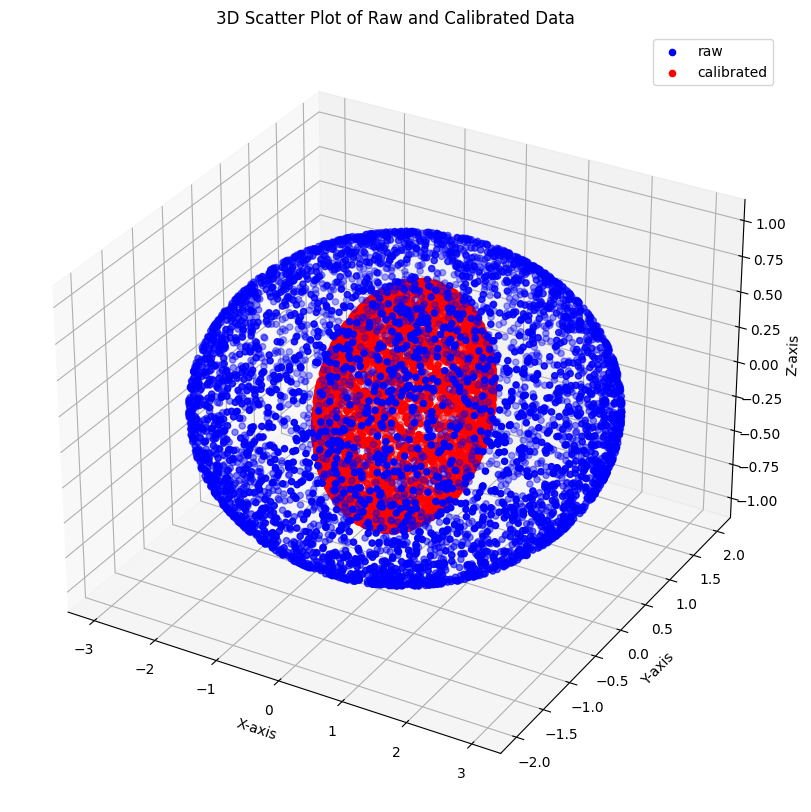

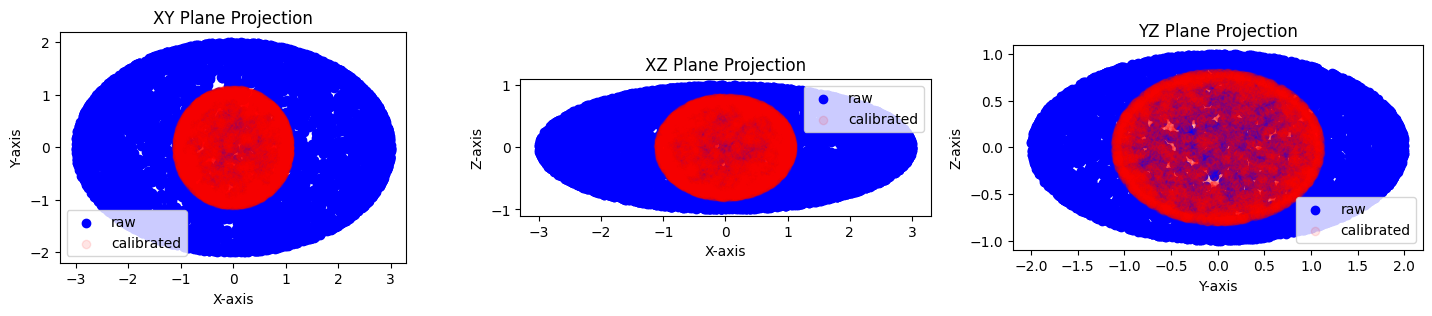

In [8]:
# matplot 3d scatter plot
dfScatter3D(rawdf, calibdf)

In [9]:
# plotly
fig = px.scatter_3d(rawdf, x='x', y='y', z='z', opacity=0.5)
fig.add_scatter3d(x=calibdf['x'], y=calibdf['y'], z=calibdf['z'], mode='markers')
fig.update_traces(marker=dict(size=1))
fig.show()


            x         y         z
0   -0.443268 -0.343640  0.973985
1   -0.280932  1.498688 -0.655526
2    2.901050  0.509205  0.007513
3    2.959231  0.205610  0.128164
4    1.137125 -1.805413 -0.203589
..        ...       ...       ...
995  0.671693 -0.563997  0.932924
996  0.916106  0.326092 -0.938172
997 -2.212000  1.328030 -0.124191
998  0.837237  0.941952  0.836837
999 -2.042987  1.278868  0.356889

[1000 rows x 3 columns]
[-0.443267998532537, -0.3436396941075423, 0.9739846532502294, -0.28093235257259414, 1.4986882968625101, -0.6555258396622908, 2.901049682691035, 0.5092053420071245, 0.00751337931746414, 2.9592307814697696, 0.2056095398086405, 0.12816386887544254, 1.1371252951010533, -1.8054126219057243, -0.20358943127290244, 1.8283742774983918, -0.7442630137022086, -0.7000564085098009, -2.136724262559973, -1.1285810886550915, 0.41747855035122455, -0.34121674224417625, -1.755984085286829, 0.464966055189441, -1.2528019558724095, -0.23484309608864062, 0.9010115845756765, 2.43477930

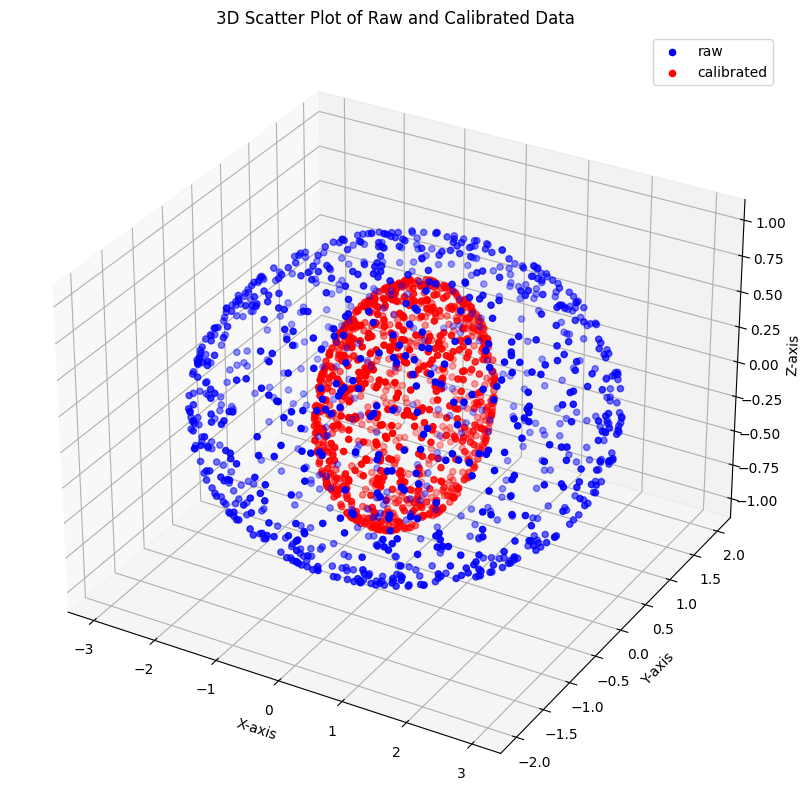

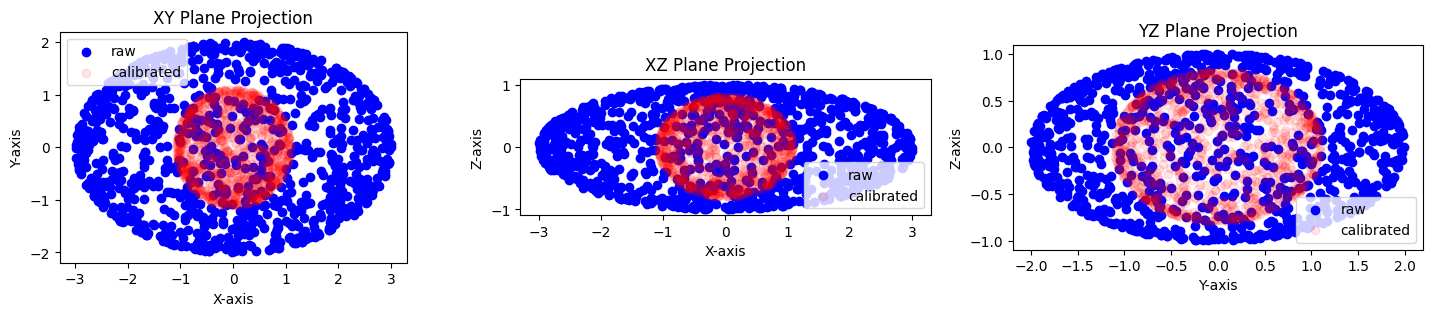

In [10]:
rng = np.random.default_rng(seed=0)
N = 1000
phi = rng.uniform(0, 2*np.pi, size=N)
theta = np.arccos(1 - 2*rng.random(size=N))
a, b, c = 3, 2, 1  
x_raw = a*np.sin(theta)*np.cos(phi)
y_raw = b*np.sin(theta)*np.sin(phi)
z_raw = c*np.cos(theta)
rawdf = pd.DataFrame({'x': x_raw, 'y': y_raw, 'z': z_raw})
print(rawdf)

flatten_ellipsiod_df = rawdf.to_numpy().reshape(np.product(rawdf.shape),)
print(flatten_ellipsiod_df.tolist())

flatten_D = pd.DataFrame({'x^2':x_raw**2, 'y^2':y_raw**2, 'z^2':z_raw**2, '2yz':2*y_raw*z_raw, '2xz':2*x_raw*z_raw, '2xy':2*x_raw*y_raw, '2x':2*x_raw, '2y':2*y_raw, '2z':2*z_raw, '1':np.ones(len(x_raw))})
flatten_D = flatten_D.to_numpy().reshape(np.product(flatten_D.shape),)
print(flatten_D.tolist())

multFactor, bias = getCalibParameters(rawdf, 1.0)
calibdf = rawdf.apply(lambda x: np.dot(multFactor, (x.T - bias)), axis=1).to_list()
calibdf = pd.DataFrame(calibdf, columns =['x','y','z'])

dfScatter3D(rawdf, calibdf)

In [11]:
l = np.round(flatten_D, 2).tolist()
ll = [0.20, 0.12, 0.95, -0.67, -0.86, 0.30, -0.89, -0.69, 1.95, 1.00, 0.08, 2.25, 0.43, -1.96, 0.37, -0.84, -0.56, 3.00, -1.31, 1.00, 8.42, 0.26, 0.00, 0.01, 0.04, 2.95, 5.80, 1.02, 0.02, 1.00, 8.76, 0.04, 0.02, 0.05, 0.76, 1.22, 5.92, 0.41, 0.26, 1.00, 1.29, 3.26, 0.04, 0.74, -0.46, -4.11, 2.27, -3.61, -0.41, 1.00, 3.34, 0.55, 0.49, 1.04, -2.56, -2.72, 3.66, -1.49, -1.40, 1.00, 4.57, 1.27, 0.17, -0.94, -1.78, 4.82, -4.27, -2.26, 0.83, 1.00, 0.12, 3.08, 0.22, -1.63, -0.32, 1.20, -0.68, -3.51, 0.93, 1.00, 1.57, 0.06, 0.81, -0.42, -2.26, 0.59, -2.51, -0.47, 1.80, 1.00, 5.93, 0.49, 0.22, -0.66, 2.28, -3.42, 4.87, -1.40, 0.93, 1.00, 0.36, 0.83, 0.75, -1.58, 1.04, -1.09, 1.20, -1.82, 1.74, 1.00, 1.43, 0.00, 0.84, 0.03, 2.20, 0.03, 2.39, 0.03, 1.83, 1.00, 3.47, 2.41, 0.01, 0.33, -0.39, -5.79, 3.73, -3.11, -0.21, 1.00, 5.16, 0.11, 0.40, 0.41, 2.87, 1.48, 4.55, 0.65, 1.26, 1.00, 0.04, 1.08, 0.73, -1.77, -0.34, 0.42, -0.40, -2.08, 1.70, 1.00, 0.56, 0.97, 0.69, -1.64, -1.24, 1.47, 1.49, 1.97, -1.67, 1.00, 1.94, 1.16, 0.49, -1.52, 1.96, -3.01, 2.79, -2.16, 1.41, 1.00, 2.89, 0.09, 0.66, -0.49, -2.75, 1.03, -3.40, -0.60, 1.62, 1.00, 0.10, 0.41, 0.89, -1.21, 0.59, -0.40, -0.62, 1.28, -1.88, 1.00, 6.25, 0.77, 0.11, -0.59, 1.67, -4.40, -5.00, 1.76, -0.67, 1.00, 6.94, 0.10, 0.20, -0.29, -2.38, 1.66, 5.27, 0.63, -0.90, 1.00, 4.47, 1.95, 0.02, -0.35, -0.53, 5.90, 4.23, 2.79, -0.25, 1.00, 0.54, 0.81, 0.74, -1.54, -1.26, 1.32, -1.47, -1.80, 1.72, 1.00, 1.74, 1.36, 0.47, 1.59, 1.80, 3.07, -2.64, -2.33, -1.37, 1.00, 4.91, 1.71, 0.03, -0.43, -0.73, 5.80, -4.43, -2.62, 0.33, 1.00, 4.76, 1.70, 0.05, 0.56, -0.94, -5.69, -4.36, 2.61, 0.43, 1.00, 4.21, 0.00, 0.53, -0.03, 2.99, -0.10, 4.10, -0.05, 1.46, 1.00, 3.56, 0.02, 0.60, -0.24, 2.92, -0.57, 3.77, -0.30, 1.55, 1.00, 1.39, 3.37, 0.00, 0.16, 0.11, 4.34, -2.36, -3.67, -0.09, 1.00, 3.03, 2.58, 0.02, 0.44, 0.48, 5.59, -3.48, -3.21, -0.27, 1.00, 1.28, 3.43, 0.00, 0.14, 0.08, 4.19, -2.26, -3.70, -0.07, 1.00, 5.01, 1.57, 0.05, -0.57, 1.01, -5.61, -4.48, 2.50, -0.45, 1.00, 1.69, 0.97, 0.57, -1.49, -1.96, 2.56, 2.60, 1.97, -1.51, 1.00, 0.29, 3.87, 0.00, 0.03, 0.01, 2.10, -1.07, -3.94, -0.02, 1.00, 8.26, 0.09, 0.06, -0.15, -1.39, 1.77, -5.75, -0.62, 0.48, 1.00, 0.94, 2.64, 0.24, 1.58, -0.94, -3.14, -1.94, 3.25, 0.97, 1.00, 7.60, 0.03, 0.15, 0.13, -2.13, -0.90, -5.51, 0.33, 0.77, 1.00, 5.24, 1.61, 0.01, 0.31, -0.56, -5.81, 4.58, -2.54, -0.24, 1.00, 4.91, 0.42, 0.35, 0.77, -2.62, -2.88, 4.43, -1.30, -1.18, 1.00, 3.49, 2.40, 0.01, 0.36, -0.44, -5.78, -3.73, 3.10, 0.24, 1.00, 1.14, 0.12, 0.84, -0.63, -1.96, 0.73, -2.14, -0.69, 1.84, 1.00, 1.05, 1.98, 0.39, 1.75, -1.28, -2.88, -2.05, 2.81, 1.25, 1.00, 2.04, 0.41, 0.67, -1.05, -2.34, 1.83, -2.86, -1.28, 1.64, 1.00, 2.20, 2.58, 0.11, 1.07, -0.99, -4.76, -2.97, 3.21, 0.67, 1.00, 4.69, 1.37, 0.14, -0.86, 1.60, -5.07, -4.33, 2.34, -0.74, 1.00, 5.18, 1.57, 0.03, 0.45, -0.83, -5.70, 4.55, -2.50, -0.36, 1.00, 0.16, 3.51, 0.11, -1.21, -0.26, 1.52, 0.81, 3.74, -0.65, 1.00, 4.56, 1.94, 0.01, -0.25, -0.39, 5.95, -4.27, -2.78, 0.18, 1.00, 2.63, 0.40, 0.61, 0.98, 2.53, 2.04, 3.24, 1.26, 1.56, 1.00, 1.85, 2.51, 0.17, -1.29, 1.11, -4.31, 2.72, -3.17, 0.81, 1.00, 0.48, 3.78, 0.00, 0.09, -0.03, -2.70, 1.39, -3.89, -0.04, 1.00, 0.04, 3.98, 0.00, 0.02, 0.00, 0.80, 0.40, 3.99, 0.01, 1.00, 3.38, 1.45, 0.26, -1.23, 1.88, -4.42, 3.68, -2.41, 1.03, 1.00, 4.52, 0.30, 0.42, -0.71, -2.77, 2.32, 4.25, 1.09, -1.30, 1.00, 2.35, 2.89, 0.02, 0.45, -0.41, -5.20, -3.06, 3.40, 0.27, 1.00, 1.62, 1.37, 0.48, -1.62, -1.76, 2.98, 2.54, 2.34, -1.38, 1.00, 6.36, 0.29, 0.22, 0.51, -2.37, -2.73, -5.04, 1.08, 0.94, 1.00, 0.16, 0.80, 0.78, 1.58, -0.71, -0.72, 0.81, -1.79, -1.77, 1.00, 0.05, 1.57, 0.60, 1.94, 0.36, 0.57, 0.46, 2.50, 1.55, 1.00, 5.73, 0.29, 0.29, -0.58, -2.58, 2.59, 4.79, 1.08, -1.08, 1.00, 0.49, 0.10, 0.92, 0.61, -1.34, -0.44, -1.39, 0.64, 1.92, 1.00, 0.66, 2.60, 0.28, 1.70, 0.85, 2.61, 1.62, 3.22, 1.05, 1.00, 2.87, 0.53, 0.55, -1.07, -2.51, 2.46, 3.39, 1.45, -1.48, 1.00, 6.28, 0.85, 0.09, -0.55, -1.50, 4.62, -5.01, -1.85, 0.60, 1.00, 0.21, 0.92, 0.75, -1.66, 0.78, -0.87, -0.91, 1.91, -1.73, 1.00, 0.52, 0.82, 0.74, 1.55, 1.24, 1.31, -1.45, -1.81, -1.72, 1.00, 0.56, 2.31, 0.36, -1.82, -0.90, 2.27, 1.50, 3.04, -1.20, 1.00, 7.52, 0.48, 0.04, -0.29, 1.14, -3.82, 5.49, -1.39, 0.42, 1.00, 1.92, 1.09, 0.51, -1.50, 1.98, -2.90, -2.77, 2.09, -1.43, 1.00, 5.55, 1.50, 0.01, 0.21, 0.40, 5.78, 4.71, 2.45, 0.17, 1.00, 1.88, 0.93, 0.56, -1.44, -2.05, 2.64, -2.74, -1.93, 1.50, 1.00, 3.65, 0.39, 0.50, 0.88, -2.69, -2.40, 3.82, -1.26, -1.41, 1.00, 4.68, 0.32, 0.40, -0.72, 2.74, -2.45, -4.33, 1.13, -1.26, 1.00, 3.88, 0.15, 0.53, -0.56, 2.87, -1.52, 3.94, -0.77, 1.46, 1.00, 4.16, 0.00, 0.54, -0.00, 2.99, -0.00, -4.08, 0.00, -1.47, 1.00, 7.15, 0.82, 0.00, -0.07, 0.20, -4.84, -5.35, 1.81, -0.08, 1.00, 3.64, 1.43, 0.24, 1.17, 1.86, 4.57, -3.81, -2.39, -0.97, 1.00, 7.06, 0.00, 0.21, -0.05, 2.46, -0.29, 5.31, -0.11, 0.93, 1.00, 5.48, 0.27, 0.32, -0.59, 2.66, -2.43, 4.68, -1.04, 1.14, 1.00, 4.35, 0.13, 0.49, -0.50, 2.90, -1.49, -4.17, 0.71, -1.39, 1.00, 0.02, 3.83, 0.04, 0.78, -0.06, -0.56, 0.29, -3.91, -0.40, 1.00, 4.53, 0.00, 0.50, 0.03, -3.00, -0.10, -4.26, 0.05, 1.41, 1.00, 8.07, 0.12, 0.07, -0.19, -1.52, 2.00, -5.68, -0.71, 0.54, 1.00, 0.22, 1.84, 0.52, 1.95, -0.67, -1.26, 0.93, -2.71, -1.44, 1.00, 6.62, 1.04, 0.00, 0.13, -0.33, -5.25, -5.15, 2.04, 0.13, 1.00, 0.08, 3.54, 0.11, -1.23, -0.18, 1.04, -0.55, -3.76, 0.65, 1.00, 0.47, 3.39, 0.10, -1.17, -0.44, 2.53, -1.38, -3.68, 0.64, 1.00, 4.31, 0.40, 0.42, 0.82, -2.70, -2.62, 4.15, -1.26, -1.30, 1.00, 5.03, 1.73, 0.01, 0.24, 0.41, 5.90, 4.48, 2.63, 0.18, 1.00, 0.03, 0.77, 0.80, 1.57, 0.31, 0.31, -0.35, -1.76, -1.79, 1.00, 6.23, 0.67, 0.14, -0.61, 1.88, -4.08, 4.99, -1.63, 0.75, 1.00, 6.37, 0.12, 0.26, 0.35, -2.59, -1.73, 5.05, -0.69, -1.03, 1.00, 7.28, 0.03, 0.18, 0.14, 2.31, 0.90, 5.40, 0.33, 0.86, 1.00, 2.75, 1.63, 0.29, 1.37, -1.78, -4.23, 3.32, -2.55, -1.07, 1.00, 0.61, 0.00, 0.93, -0.12, 1.51, -0.10, 1.57, -0.12, 1.93, 1.00, 3.78, 0.13, 0.55, -0.53, 2.88, -1.39, 3.89, -0.71, 1.48, 1.00, 2.44, 1.99, 0.23, 1.36, 1.50, 4.41, 3.12, 2.82, 0.96, 1.00, 3.95, 0.05, 0.55, 0.34, -2.94, -0.91, 3.97, -0.46, -1.48, 1.00, 4.67, 1.42, 0.13, -0.85, 1.53, -5.15, 4.32, -2.38, 0.71, 1.00, 1.73, 3.22, 0.00, -0.12, 0.09, -4.73, 2.63, -3.59, 0.07, 1.00, 3.39, 0.02, 0.62, 0.24, -2.89, -0.57, -3.68, 0.31, 1.57, 1.00, 0.11, 3.88, 0.02, -0.53, -0.09, 1.29, 0.66, 3.94, -0.27, 1.00, 0.32, 1.25, 0.65, -1.80, 0.91, -1.26, 1.13, -2.23, 1.62, 1.00, 3.44, 0.42, 0.51, -0.92, 2.66, -2.39, 3.71, -1.29, 1.43, 1.00, 0.06, 2.52, 0.36, -1.91, 0.29, -0.77, -0.48, 3.18, -1.20, 1.00, 6.25, 0.17, 0.26, -0.43, -2.56, 2.08, -5.00, -0.83, 1.02, 1.00, 1.81, 0.11, 0.77, 0.59, -2.36, -0.91, -2.69, 0.68, 1.75, 1.00, 7.11, 0.68, 0.04, 0.33, -1.09, -4.38, 5.33, -1.64, -0.41, 1.00, 4.22, 0.13, 0.50, 0.50, 2.90, 1.46, 4.11, 0.71, 1.41, 1.00, 0.02, 0.79, 0.80, -1.59, -0.27, 0.27, -0.30, -1.78, 1.79, 1.00, 2.87, 0.98, 0.44, 1.31, 2.24, 3.35, -3.39, -1.98, -1.32, 1.00, 8.35, 0.12, 0.04, 0.14, 1.19, 2.01, 5.78, 0.69, 0.41, 1.00, 0.15, 1.79, 0.53, 1.96, 0.58, 1.05, -0.79, -2.68, -1.46, 1.00, 6.79, 0.03, 0.24, -0.17, -2.54, 0.91, 5.21, 0.35, -0.98, 1.00, 0.01, 2.56, 0.36, -1.91, 0.14, -0.38, 0.24, -3.20, 1.20, 1.00, 2.78, 0.01, 0.69, -0.15, -2.77, 0.30, -3.33, -0.18, 1.66, 1.00, 4.16, 0.42, 0.43, -0.85, 2.68, -2.65, 4.08, -1.30, 1.31, 1.00, 7.53, 0.65, 0.00, 0.02, 0.06, 4.43, 5.49, 1.61, 0.02, 1.00, 2.44, 2.59, 0.08, -0.92, 0.89, -5.03, 3.12, -3.22, 0.57, 1.00, 4.20, 0.37, 0.44, -0.81, -2.72, 2.49, 4.10, 1.22, -1.33, 1.00, 2.80, 2.74, 0.00, 0.20, -0.21, -5.54, -3.34, 3.31, 0.12, 1.00, 7.29, 0.71, 0.01, -0.18, 0.59, -4.55, -5.40, 1.69, -0.22, 1.00, 8.16, 0.17, 0.05, -0.19, 1.29, -2.36, 5.71, -0.82, 0.45, 1.00, 5.69, 0.43, 0.26, 0.67, 2.43, 3.13, -4.77, -1.31, -1.02, 1.00, 0.02, 3.42, 0.14, -1.40, 0.12, -0.57, -0.31, 3.70, -0.76, 1.00, 0.02, 3.44, 0.14, -1.38, -0.11, 0.54, 0.29, 3.71, -0.74, 1.00, 3.69, 1.18, 0.30, 1.18, -2.09, -4.17, 3.84, -2.17, -1.09, 1.00, 0.20, 3.75, 0.04, 0.79, 0.18, 1.72, 0.89, 3.87, 0.41, 1.00, 1.90, 0.83, 0.58, 1.39, 2.10, 2.52, 2.76, 1.83, 1.52, 1.00, 0.30, 2.25, 0.40, -1.91, 0.70, -1.66, -1.10, 3.00, -1.27, 1.00, 5.98, 0.96, 0.10, -0.61, -1.51, 4.79, -4.89, -1.96, 0.62, 1.00, 6.82, 0.38, 0.15, 0.47, 2.00, 3.22, -5.22, -1.23, -0.77, 1.00, 0.06, 0.16, 0.95, 0.78, -0.46, -0.19, 0.47, -0.79, -1.95, 1.00, 6.50, 0.46, 0.16, 0.55, 2.06, 3.46, -5.10, -1.36, -0.81, 1.00, 0.17, 1.28, 0.66, -1.84, 0.68, -0.94, -0.83, 2.26, -1.63, 1.00, 0.35, 0.06, 0.95, 0.47, -1.14, -0.28, -1.18, 0.48, 1.95, 1.00, 1.48, 3.17, 0.04, 0.74, -0.51, -4.34, 2.44, -3.56, -0.41, 1.00, 1.55, 0.72, 0.65, -1.36, -2.01, 2.11, -2.49, -1.69, 1.61, 1.00, 3.75, 0.12, 0.56, 0.51, -2.88, -1.31, 3.87, -0.68, -1.49, 1.00, 0.64, 0.33, 0.85, -1.05, 1.47, -0.91, -1.60, 1.14, -1.84, 1.00, 1.06, 0.06, 0.87, -0.44, -1.92, 0.49, -2.06, -0.47, 1.86, 1.00, 2.87, 0.57, 0.54, -1.11, -2.49, 2.56, -3.39, -1.51, 1.47, 1.00, 1.68, 1.48, 0.44, 1.62, -1.73, -3.16, 2.59, -2.43, -1.33, 1.00, 2.89, 2.16, 0.14, -1.10, -1.27, 4.99, 3.40, 2.94, -0.75, 1.00, 0.45, 0.09, 0.93, -0.57, 1.29, -0.40, -1.34, 0.59, -1.93, 1.00, 4.73, 0.85, 0.26, 0.94, -2.23, -4.00, 4.35, -1.84, -1.03, 1.00, 8.06, 0.28, 0.04, -0.20, -1.07, 2.98, 5.68, 1.05, -0.38, 1.00, 1.74, 3.20, 0.01, 0.28, -0.21, -4.72, 2.64, -3.58, -0.16, 1.00, 0.26, 0.04, 0.96, 0.39, -1.00, -0.20, -1.02, 0.40, 1.96, 1.00, 1.41, 2.08, 0.32, 1.64, -1.35, -3.43, 2.37, -2.89, -1.14, 1.00, 8.48, 0.01, 0.05, 0.06, 1.35, 0.71, 5.82, 0.24, 0.46, 1.00, 1.50, 0.86, 0.62, 1.46, -1.93, -2.27, -2.45, 1.85, 1.57, 1.00, 6.92, 0.89, 0.01, -0.18, -0.49, 4.97, 5.26, 1.89, -0.19, 1.00, 2.77, 2.50, 0.07, -0.82, -0.87, 5.26, -3.33, -3.16, 0.52, 1.00, 0.19, 3.74, 0.04, -0.82, 0.19, -1.69, -0.88, 3.87, -0.42, 1.00, 0.05, 0.24, 0.93, -0.95, -0.44, 0.22, -0.45, -0.98, 1.93, 1.00, 4.37, 0.26, 0.45, -0.69, 2.80, -2.15, 4.18, -1.03, 1.34, 1.00, 4.37, 2.03, 0.01, -0.23, -0.33, 5.96, 4.18, 2.85, -0.16, 1.00, 3.73, 2.15, 0.05, 0.64, -0.85, -5.66, 3.86, -2.93, -0.44, 1.00, 2.35, 0.16, 0.70, 0.67, 2.56, 1.23, 3.07, 0.80, 1.67, 1.00, 4.47, 1.72, 0.07, -0.71, 1.15, -5.54, -4.23, 2.62, -0.55, 1.00, 3.93, 0.39, 0.47, -0.85, 2.71, -2.48, -3.97, 1.25, -1.36, 1.00, 7.33, 0.02, 0.18, 0.11, -2.31, -0.69, -5.41, 0.25, 0.85, 1.00, 8.79, 0.09, 0.00, 0.03, -0.25, -1.75, 5.93, -0.59, -0.09, 1.00, 0.08, 1.33, 0.66, 1.87, -0.46, -0.65, 0.56, -2.30, -1.62, 1.00, 0.98, 2.90, 0.16, -1.38, 0.80, -3.38, -1.98, 3.41, -0.81, 1.00, 0.09, 2.58, 0.34, 1.89, -0.35, -0.97, -0.60, 3.21, 1.17, 1.00, 0.50, 0.30, 0.87, 1.02, -1.31, -0.77, 1.41, -1.09, -1.87, 1.00, 4.37, 1.66, 0.10, -0.81, 1.32, -5.38, 4.18, -2.58, 0.63, 1.00, 5.19, 0.01, 0.42, 0.13, 2.96, 0.47, -4.56, -0.20, -1.30, 1.00, 2.78, 2.73, 0.01, 0.31, -0.32, -5.51, -3.34, 3.30, 0.19, 1.00, 5.97, 0.00, 0.34, 0.06, -2.83, -0.25, 4.89, -0.10, -1.16, 1.00, 0.42, 0.98, 0.71, -1.66, 1.10, -1.29, -1.30, 1.98, -1.68, 1.00, 0.53, 1.17, 0.65, -1.74, -1.18, 1.58, 1.46, 2.16, -1.61, 1.00, 3.01, 1.18, 0.37, 1.32, -2.11, -3.77, 3.47, -2.17, -1.22, 1.00, 1.15, 2.99, 0.13, -1.22, 0.76, -3.70, 2.14, -3.46, 0.71, 1.00, 0.70, 0.97, 0.68, 1.62, 1.38, 1.64, -1.67, -1.96, -1.65, 1.00, 4.36, 0.14, 0.48, -0.52, 2.90, -1.56, 4.18, -0.74, 1.39, 1.00, 5.53, 0.62, 0.23, -0.76, 2.25, -3.71, 4.70, -1.58, 0.96, 1.00, 0.00, 3.66, 0.09, 1.12, 0.02, 0.12, -0.06, -3.82, -0.59, 1.00, 2.79, 1.78, 0.25, 1.32, -1.66, -4.45, 3.34, -2.67, -0.99, 1.00, 0.00, 0.76, 0.81, 1.57, 0.04, 0.04, 0.05, 1.75, 1.80, 1.00, 2.82, 1.89, 0.21, 1.27, 1.55, 4.62, 3.36, 2.75, 0.92, 1.00, 1.94, 2.86, 0.07, -0.89, -0.73, 4.72, -2.79, -3.38, 0.52, 1.00, 0.23, 1.97, 0.48, 1.95, 0.66, 1.34, -0.95, -2.81, -1.39, 1.00, 0.02, 0.02, 0.99, 0.30, 0.26, 0.04, 0.26, 0.30, 1.99, 1.00, 2.21, 0.58, 0.61, -1.19, 2.32, -2.27, -2.97, 1.53, -1.56, 1.00, 5.73, 1.02, 0.11, -0.67, 1.58, -4.83, 4.79, -2.02, 0.66, 1.00, 7.31, 0.54, 0.05, 0.34, 1.26, 3.96, -5.41, -1.46, -0.47, 1.00, 1.68, 0.21, 0.76, 0.81, 2.26, 1.20, -2.59, -0.93, -1.74, 1.00, 0.25, 0.82, 0.77, 1.58, 0.87, 0.90, 0.99, 1.81, 1.75, 1.00, 8.69, 0.11, 0.01, 0.06, 0.53, 1.91, -5.90, -0.65, -0.18, 1.00, 6.09, 0.06, 0.31, -0.27, -2.74, 1.20, -4.93, -0.49, 1.11, 1.00, 5.41, 0.94, 0.16, -0.78, -1.88, 4.51, 4.65, 1.94, -0.81, 1.00, 5.29, 0.03, 0.40, 0.22, -2.93, -0.80, 4.60, -0.35, -1.27, 1.00, 5.43, 0.56, 0.26, -0.76, -2.36, 3.48, -4.66, -1.49, 1.02, 1.00, 4.33, 0.00, 0.52, -0.08, -3.00, 0.23, 4.16, 0.11, -1.44, 1.00, 0.11, 2.29, 0.42, -1.95, 0.42, -0.98, 0.65, -3.03, 1.29, 1.00, 8.82, 0.07, 0.00, -0.02, 0.24, -1.62, 5.94, -0.54, 0.08, 1.00, 2.93, 0.52, 0.54, -1.07, -2.52, 2.47, -3.42, -1.45, 1.47, 1.00, 1.38, 2.79, 0.15, 1.29, -0.90, -3.92, -2.35, 3.34, 0.77, 1.00, 1.23, 3.20, 0.06, 0.90, 0.56, 3.97, 2.22, 3.58, 0.50, 1.00, 1.67, 2.65, 0.15, 1.27, 1.01, 4.20, -2.58, -3.25, -0.78, 1.00, 0.89, 3.07, 0.13, 1.28, 0.69, 3.31, 1.89, 3.50, 0.73, 1.00, 7.00, 0.88, 0.00, 0.11, 0.31, 4.95, -5.29, -1.87, -0.12, 1.00, 5.24, 1.30, 0.09, 0.69, 1.39, 5.23, -4.58, -2.28, -0.61, 1.00, 5.73, 0.15, 0.33, 0.44, -2.74, -1.84, 4.79, -0.77, -1.14, 1.00, 6.03, 0.64, 0.17, 0.66, 2.03, 3.92, 4.91, 1.60, 0.83, 1.00, 1.91, 0.00, 0.79, 0.00, -2.46, -0.00, -2.77, 0.00, 1.77, 1.00, 0.01, 2.89, 0.28, -1.79, -0.10, 0.32, -0.19, -3.40, 1.05, 1.00, 1.74, 3.19, 0.01, -0.33, -0.24, 4.71, 2.64, 3.57, -0.18, 1.00, 2.25, 0.72, 0.57, -1.28, 2.27, -2.54, -3.00, 1.70, -1.51, 1.00, 6.91, 0.53, 0.10, -0.46, -1.66, 3.84, 5.26, 1.46, -0.63, 1.00, 0.20, 3.73, 0.05, 0.83, 0.19, 1.71, -0.88, -3.86, -0.43, 1.00, 0.80, 0.14, 0.88, 0.69, 1.68, 0.66, 1.79, 0.74, 1.87, 1.00, 5.62, 1.50, 0.00, 0.01, -0.02, -5.81, -4.74, 2.45, 0.01, 1.00, 3.91, 1.80, 0.11, -0.91, 1.34, -5.31, 3.96, -2.69, 0.68, 1.00, 7.92, 0.11, 0.09, 0.20, -1.72, -1.86, -5.63, 0.66, 0.61, 1.00, 1.02, 0.17, 0.84, 0.76, -1.86, -0.83, 2.02, -0.82, -1.84, 1.00, 0.05, 2.17, 0.45, -1.98, 0.30, -0.65, 0.44, -2.94, 1.35, 1.00, 2.15, 0.33, 0.68, -0.95, 2.42, -1.69, 2.94, -1.15, 1.65, 1.00, 3.70, 1.75, 0.15, 1.03, 1.50, 5.09, 3.85, 2.64, 0.78, 1.00, 6.62, 0.73, 0.08, -0.49, -1.47, 4.40, 5.15, 1.71, -0.57, 1.00, 5.79, 0.58, 0.21, 0.70, 2.22, 3.65, 4.81, 1.52, 0.92, 1.00, 3.45, 1.79, 0.17, 1.10, -1.53, -4.97, 3.71, -2.68, -0.82, 1.00, 3.38, 1.89, 0.15, 1.07, 1.43, 5.05, -3.68, -2.75, -0.78, 1.00, 8.86, 0.00, 0.02, 0.01, -0.74, -0.25, -5.95, 0.09, 0.25, 1.00, 1.33, 1.62, 0.45, -1.70, -1.54, 2.93, 2.30, 2.54, -1.34, 1.00, 1.68, 2.76, 0.12, -1.17, -0.91, 4.30, -2.59, -3.32, 0.70, 1.00, 1.45, 3.11, 0.06, -0.87, 0.59, -4.25, -2.41, 3.53, -0.49, 1.00, 0.53, 3.74, 0.01, 0.31, 0.12, 2.81, -1.46, -3.87, -0.16, 1.00, 2.25, 0.06, 0.73, 0.44, -2.57, -0.76, -3.00, 0.51, 1.71, 1.00, 8.14, 0.01, 0.09, -0.05, -1.74, 0.51, -5.71, -0.18, 0.61, 1.00, 0.54, 3.70, 0.02, 0.49, -0.19, -2.82, 1.47, -3.85, -0.25, 1.00, 0.59, 0.11, 0.91, -0.64, -1.46, 0.52, 1.53, 0.67, -1.90, 1.00, 4.73, 0.61, 0.32, 0.89, 2.47, 3.40, -4.35, -1.56, -1.13, 1.00, 0.95, 3.57, 0.00, 0.14, 0.07, 3.69, 1.95, 3.78, 0.08, 1.00, 0.73, 2.20, 0.37, -1.80, 1.03, -2.53, 1.70, -2.97, 1.21, 1.00, 7.06, 0.02, 0.21, 0.11, -2.44, -0.66, -5.31, 0.25, 0.92, 1.00, 1.46, 0.00, 0.84, -0.10, 2.21, -0.14, 2.41, -0.11, 1.83, 1.00, 1.47, 3.24, 0.03, -0.59, -0.40, 4.36, 2.42, 3.60, -0.33, 1.00, 8.33, 0.21, 0.02, -0.14, 0.87, -2.63, 5.77, -0.91, 0.30, 1.00, 0.80, 3.24, 0.10, 1.14, -0.57, -3.22, 1.79, -3.60, -0.63, 1.00, 8.84, 0.05, 0.00, -0.03, 0.37, -1.39, -5.95, 0.47, -0.13, 1.00, 1.32, 3.30, 0.03, -0.60, 0.38, -4.18, 2.30, -3.63, 0.33, 1.00, 5.23, 1.32, 0.09, -0.68, -1.35, 5.26, -4.58, -2.30, 0.59, 1.00, 0.44, 0.43, 0.84, -1.20, -1.22, 0.87, -1.33, -1.31, 1.84, 1.00, 0.44, 0.07, 0.93, 0.52, -1.28, -0.36, 1.33, -0.53, -1.93, 1.00, 2.11, 0.18, 0.72, 0.71, 2.47, 1.22, 2.90, 0.84, 1.70, 1.00, 0.23, 0.29, 0.90, -1.03, 0.91, -0.52, 0.96, -1.08, 1.90, 1.00, 3.30, 1.24, 0.32, 1.27, -2.07, -4.04, -3.63, 2.22, 1.14, 1.00, 0.88, 1.49, 0.53, 1.78, -1.37, -2.30, -1.88, 2.44, 1.46, 1.00, 5.87, 0.00, 0.35, 0.07, -2.85, -0.29, 4.85, -0.12, -1.18, 1.00, 0.18, 1.98, 0.49, -1.96, 0.58, -1.18, 0.84, -2.81, 1.39, 1.00, 8.01, 0.03, 0.10, 0.11, -1.81, -0.97, -5.66, 0.34, 0.64, 1.00, 0.37, 0.05, 0.95, 0.42, -1.18, -0.26, -1.21, 0.43, 1.95, 1.00, 1.18, 0.49, 0.75, 1.21, -1.88, -1.53, 2.18, -1.41, -1.73, 1.00, 5.73, 0.94, 0.13, 0.69, 1.71, 4.64, 4.79, 1.94, 0.72, 1.00, 0.32, 1.98, 0.47, 1.93, 0.77, 1.59, -1.13, -2.81, -1.37, 1.00, 0.08, 0.55, 0.85, 1.37, -0.52, -0.42, 0.56, -1.48, -1.85, 1.00, 0.66, 2.88, 0.21, 1.54, -0.74, -2.76, 1.63, -3.39, -0.91, 1.00, 1.34, 2.49, 0.23, 1.51, -1.11, -3.65, -2.31, 3.16, 0.96, 1.00, 0.75, 3.67, 0.00, -0.06, 0.03, -3.32, 1.73, -3.83, 0.03, 1.00, 0.15, 2.66, 0.32, -1.84, -0.43, 1.25, 0.76, 3.26, -1.13, 1.00, 3.19, 1.95, 0.16, -1.11, 1.42, -4.99, -3.57, 2.79, -0.79, 1.00, 3.87, 0.56, 0.43, -0.98, 2.58, -2.95, -3.94, 1.50, -1.31, 1.00, 8.34, 0.26, 0.01, 0.09, 0.51, 2.96, -5.77, -1.02, -0.18, 1.00, 4.68, 1.52, 0.10, -0.78, -1.36, 5.34, 4.33, 2.47, -0.63, 1.00, 5.79, 1.13, 0.07, 0.58, -1.32, -5.11, -4.81, 2.12, 0.55, 1.00, 5.57, 0.00, 0.38, 0.00, 2.91, 0.01, 4.72, 0.01, 1.23, 1.00, 0.01, 3.37, 0.16, 1.45, 0.08, 0.36, -0.19, -3.67, -0.79, 1.00, 0.04, 0.03, 0.99, -0.34, 0.38, -0.07, 0.38, -0.34, 1.99, 1.00, 2.52, 1.59, 0.32, -1.43, -1.80, 4.00, 3.17, 2.52, -1.14, 1.00, 0.02, 0.11, 0.97, -0.64, -0.29, 0.09, -0.29, -0.65, 1.97, 1.00, 1.59, 3.08, 0.05, 0.82, -0.59, -4.42, 2.52, -3.51, -0.47, 1.00, 8.57, 0.05, 0.04, 0.08, -1.11, -1.31, 5.85, -0.45, -0.38, 1.00, 1.05, 1.04, 0.62, -1.61, 1.62, -2.09, 2.05, -2.04, 1.58, 1.00, 6.86, 0.81, 0.03, -0.33, 0.97, -4.73, -5.24, 1.80, -0.37, 1.00, 6.50, 0.05, 0.27, 0.22, -2.63, -1.11, 5.10, -0.44, -1.03, 1.00, 8.72, 0.11, 0.01, 0.05, -0.43, -1.92, 5.90, -0.65, -0.14, 1.00, 7.92, 0.00, 0.12, 0.03, 1.94, 0.24, -5.63, -0.09, -0.69, 1.00, 0.00, 3.30, 0.17, 1.52, -0.05, -0.21, 0.12, -3.63, -0.83, 1.00, 4.32, 0.69, 0.35, -0.98, 2.45, -3.47, 4.16, -1.67, 1.18, 1.00, 2.39, 0.02, 0.73, -0.27, 2.64, -0.48, -3.09, 0.31, -1.71, 1.00, 3.41, 2.01, 0.12, -0.98, 1.27, -5.23, 3.69, -2.84, 0.69, 1.00, 0.79, 3.54, 0.03, 0.63, 0.30, 3.33, -1.77, -3.76, -0.33, 1.00, 0.25, 1.37, 0.63, 1.86, -0.79, -1.16, -0.99, 2.34, 1.59, 1.00, 0.00, 0.06, 0.99, 0.47, -0.08, -0.02, 0.08, -0.48, -1.99, 1.00, 6.64, 0.67, 0.10, 0.50, 1.59, 4.21, -5.15, -1.63, -0.62, 1.00, 6.18, 1.23, 0.01, 0.17, 0.38, 5.51, 4.97, 2.22, 0.15, 1.00, 5.32, 1.56, 0.02, -0.33, 0.61, -5.77, -4.62, 2.50, -0.26, 1.00, 0.76, 0.08, 0.89, 0.55, 1.65, 0.51, 1.75, 0.58, 1.89, 1.00, 6.42, 0.06, 0.27, 0.27, -2.63, -1.29, -5.07, 0.51, 1.04, 1.00, 0.72, 0.07, 0.90, -0.52, 1.61, -0.46, -1.70, 0.55, -1.90, 1.00, 2.11, 0.25, 0.70, 0.84, -2.43, -1.46, -2.91, 1.01, 1.68, 1.00, 3.21, 0.52, 0.51, -1.03, -2.57, 2.58, -3.58, -1.44, 1.43, 1.00, 4.53, 1.90, 0.02, -0.40, -0.62, 5.87, 4.26, 2.76, -0.29, 1.00, 5.27, 0.46, 0.30, 0.74, -2.52, -3.10, 4.59, -1.35, -1.10, 1.00, 0.73, 1.68, 0.50, 1.83, 1.21, 2.22, -1.71, -2.59, -1.41, 1.00, 0.86, 1.53, 0.52, 1.79, -1.34, -2.29, 1.86, -2.47, -1.44, 1.00, 4.17, 1.06, 0.27, 1.07, -2.13, -4.21, 4.08, -2.06, -1.04, 1.00, 6.12, 0.91, 0.09, -0.58, -1.51, 4.71, -4.95, -1.90, 0.61, 1.00, 8.21, 0.24, 0.03, -0.16, -0.94, 2.83, 5.73, 0.99, -0.33, 1.00, 0.31, 2.29, 0.39, 1.90, 0.70, 1.70, -1.12, -3.03, -1.25, 1.00, 3.54, 0.34, 0.52, -0.84, -2.72, 2.19, -3.77, -1.16, 1.44, 1.00, 0.57, 0.94, 0.70, -1.63, 1.26, -1.46, 1.51, -1.94, 1.67, 1.00, 8.58, 0.16, 0.01, -0.07, -0.49, 2.34, -5.86, -0.80, 0.17, 1.00, 1.15, 2.91, 0.14, -1.29, 0.81, -3.67, 2.15, -3.41, 0.76, 1.00, 0.13, 0.00, 0.99, -0.01, 0.73, -0.00, 0.73, -0.01, 1.99, 1.00, 3.14, 2.60, 0.00, -0.11, 0.12, -5.71, -3.54, 3.23, -0.07, 1.00, 1.91, 2.89, 0.06, 0.86, 0.70, 4.70, 2.76, 3.40, 0.51, 1.00, 2.24, 0.65, 0.59, -1.24, 2.30, -2.42, -3.00, 1.62, -1.53, 1.00, 0.00, 3.56, 0.11, -1.25, 0.04, -0.20, 0.11, -3.77, 0.66, 1.00, 6.93, 0.50, 0.11, -0.46, 1.71, -3.71, -5.26, 1.41, -0.65, 1.00, 6.38, 1.09, 0.02, 0.28, 0.69, 5.28, -5.05, -2.09, -0.27, 1.00, 3.67, 1.73, 0.16, 1.05, 1.53, 5.03, 3.83, 2.63, 0.80, 1.00, 0.20, 3.89, 0.00, -0.26, -0.06, 1.77, -0.89, -3.95, 0.13, 1.00, 0.30, 3.59, 0.07, 1.00, -0.29, -2.06, -1.09, 3.79, 0.53, 1.00, 0.87, 2.51, 0.28, 1.66, 0.98, 2.95, 1.86, 3.17, 1.05, 1.00, 1.23, 0.74, 0.68, -1.42, 1.83, -1.91, 2.22, -1.72, 1.65, 1.00, 1.50, 0.12, 0.80, -0.63, -2.20, 0.86, -2.45, -0.70, 1.79, 1.00, 6.17, 0.03, 0.31, 0.18, -2.76, -0.80, -4.97, 0.32, 1.11, 1.00, 1.78, 0.43, 0.69, -1.09, 2.22, -1.75, 2.67, -1.31, 1.67, 1.00, 3.39, 0.54, 0.49, 1.03, 2.57, 2.71, 3.68, 1.47, 1.40, 1.00, 0.43, 1.56, 0.56, -1.87, -0.99, 1.64, -1.32, -2.50, 1.50, 1.00, 1.87, 2.91, 0.06, 0.87, -0.69, -4.66, -2.73, 3.41, 0.51, 1.00, 1.33, 2.31, 0.27, 1.59, 1.21, 3.51, 2.31, 3.04, 1.05, 1.00, 0.03, 0.06, 0.98, -0.47, -0.36, 0.09, -0.36, -0.47, 1.98, 1.00, 0.49, 0.29, 0.87, 1.01, -1.30, -0.75, -1.39, 1.08, 1.87, 1.00, 0.08, 0.12, 0.96, -0.68, 0.56, -0.20, -0.57, 0.70, -1.96, 1.00, 5.86, 0.36, 0.26, -0.61, 2.47, -2.89, 4.84, -1.19, 1.02, 1.00, 0.14, 0.57, 0.84, 1.38, 0.68, 0.56, 0.74, 1.50, 1.84, 1.00, 8.38, 0.02, 0.06, 0.07, 1.46, 0.86, -5.79, -0.30, -0.50, 1.00, 8.70, 0.09, 0.01, -0.06, -0.61, 1.76, 5.90, 0.60, -0.21, 1.00, 2.29, 2.78, 0.05, 0.74, 0.67, 5.05, 3.03, 3.34, 0.44, 1.00, 3.89, 1.40, 0.22, 1.10, -1.84, -4.67, 3.95, -2.37, -0.93, 1.00, 0.13, 0.89, 0.76, 1.65, -0.62, -0.67, 0.71, -1.89, -1.75, 1.00, 7.56, 0.47, 0.04, -0.28, -1.14, 3.76, -5.50, -1.37, 0.41, 1.00, 0.25, 3.64, 0.06, 0.95, 0.25, 1.91, 1.00, 3.82, 0.50, 1.00, 7.86, 0.50, 0.00, 0.04, 0.16, 3.98, -5.61, -1.42, -0.06, 1.00, 6.42, 0.02, 0.28, 0.14, 2.69, 0.66, 5.07, 0.26, 1.06, 1.00, 0.27, 2.18, 0.43, -1.92, -0.68, 1.55, -1.05, -2.95, 1.30, 1.00, 0.37, 3.64, 0.05, -0.85, -0.27, 2.31, -1.21, -3.81, 0.45, 1.00, 2.91, 2.21, 0.13, 1.05, 1.21, 5.07, -3.41, -2.97, -0.71, 1.00, 0.31, 0.10, 0.94, -0.60, -1.07, 0.34, -1.11, -0.62, 1.94, 1.00, 3.44, 0.38, 0.52, 0.89, 2.68, 2.29, 3.71, 1.23, 1.45, 1.00, 0.00, 2.48, 0.38, -1.94, -0.07, 0.17, 0.11, 3.15, -1.23, 1.00, 6.36, 0.72, 0.11, -0.57, -1.69, 4.28, -5.05, -1.70, 0.67, 1.00, 5.50, 1.50, 0.01, -0.29, 0.55, -5.74, -4.69, 2.45, -0.24, 1.00, 1.88, 0.00, 0.79, -0.08, 2.44, -0.13, 2.74, -0.09, 1.78, 1.00, 7.01, 0.84, 0.01, 0.19, -0.54, -4.86, 5.30, -1.83, -0.20, 1.00, 0.32, 0.29, 0.89, 1.01, 1.07, 0.61, 1.14, 1.07, 1.89, 1.00, 4.22, 0.75, 0.34, -1.02, -2.40, 3.57, -4.11, -1.74, 1.17, 1.00, 0.98, 3.52, 0.01, -0.39, -0.21, 3.71, -1.98, -3.75, 0.21, 1.00, 3.84, 2.28, 0.00, -0.14, -0.19, 5.92, 3.92, 3.02, -0.10, 1.00, 0.58, 1.50, 0.56, 1.83, -1.14, -1.86, -1.52, 2.45, 1.50, 1.00, 0.40, 3.79, 0.01, -0.32, -0.10, 2.48, -1.27, -3.90, 0.16, 1.00, 4.08, 0.93, 0.31, 1.08, -2.27, -3.89, 4.04, -1.93, -1.12, 1.00, 2.22, 2.34, 0.17, -1.26, 1.23, -4.55, -2.98, 3.06, -0.82, 1.00, 0.04, 3.71, 0.07, 1.01, 0.11, 0.77, 0.40, 3.85, 0.52, 1.00, 1.71, 3.24, 0.00, -0.03, 0.02, -4.71, 2.62, -3.60, 0.02, 1.00, 4.28, 0.67, 0.36, 0.98, 2.48, 3.38, -4.14, -1.63, -1.20, 1.00, 6.83, 0.07, 0.22, 0.24, -2.48, -1.35, -5.23, 0.52, 0.95, 1.00, 0.01, 1.93, 0.52, 2.00, -0.12, -0.22, -0.16, 2.78, 1.44, 1.00, 0.87, 0.09, 0.88, -0.57, -1.75, 0.57, 1.87, 0.61, -1.88, 1.00, 3.94, 0.02, 0.56, -0.22, -2.96, 0.59, 3.97, 0.30, -1.49, 1.00, 3.04, 0.41, 0.56, 0.96, 2.61, 2.23, -3.49, -1.28, -1.50, 1.00, 1.17, 3.47, 0.00, 0.17, 0.10, 4.04, 2.17, 3.73, 0.09, 1.00, 1.20, 0.01, 0.86, -0.21, 2.04, -0.25, 2.19, -0.23, 1.86, 1.00, 4.19, 1.19, 0.24, -1.06, -1.99, 4.47, 4.09, 2.19, -0.97, 1.00, 5.44, 0.23, 0.34, -0.56, 2.71, -2.25, -4.67, 0.97, -1.16, 1.00, 0.75, 0.20, 0.87, -0.84, 1.62, -0.78, -1.74, 0.90, -1.86, 1.00, 0.02, 0.55, 0.86, 1.37, 0.23, 0.18, 0.25, 1.48, 1.86, 1.00, 0.00, 2.43, 0.39, 1.95, 0.02, 0.06, -0.04, -3.12, -1.25, 1.00, 3.08, 2.20, 0.11, -0.97, -1.15, 5.21, -3.51, -2.97, 0.65, 1.00, 0.18, 3.47, 0.11, 1.24, 0.29, 1.60, -0.86, -3.73, -0.67, 1.00, 2.43, 0.35, 0.64, -0.95, -2.50, 1.85, 3.12, 1.19, -1.60, 1.00, 2.45, 1.92, 0.25, 1.38, -1.56, -4.34, -3.13, 2.77, 0.99, 1.00, 0.23, 0.00, 0.97, 0.08, 0.95, 0.04, -0.96, -0.08, -1.97, 1.00, 1.05, 0.12, 0.85, 0.63, -1.90, -0.70, -2.05, 0.68, 1.85, 1.00, 3.42, 0.10, 0.59, 0.50, 2.85, 1.19, 3.70, 0.64, 1.54, 1.00, 1.07, 3.52, 0.00, 0.15, 0.08, 3.87, 2.07, 3.75, 0.08, 1.00, 6.44, 0.37, 0.19, 0.53, -2.22, -3.09, 5.08, -1.22, -0.88, 1.00, 0.67, 0.79, 0.73, -1.52, -1.39, 1.46, 1.64, 1.78, -1.71, 1.00, 1.67, 1.33, 0.48, 1.60, -1.79, -2.98, 2.58, -2.31, -1.39, 1.00, 0.20, 0.37, 0.89, 1.14, -0.84, -0.54, 0.89, -1.22, -1.88, 1.00, 5.34, 1.57, 0.01, 0.29, -0.54, -5.79, -4.62, 2.51, 0.23, 1.00, 8.31, 0.17, 0.04, 0.15, -1.08, -2.35, -5.77, 0.81, 0.37, 1.00, 1.75, 3.09, 0.03, 0.63, -0.47, -4.66, 2.65, -3.52, -0.36, 1.00, 1.37, 2.80, 0.15, 1.29, 0.90, 3.91, -2.34, -3.35, -0.77, 1.00, 0.85, 1.02, 0.65, 1.63, -1.49, -1.87, 1.85, -2.02, -1.61, 1.00, 0.02, 3.86, 0.03, 0.72, -0.05, -0.55, 0.28, -3.93, -0.37, 1.00, 0.40, 1.19, 0.66, 1.77, 1.03, 1.38, -1.26, -2.18, -1.62, 1.00, 6.38, 1.05, 0.03, -0.35, 0.85, -5.18, 5.05, -2.05, 0.34, 1.00, 1.24, 2.27, 0.29, 1.64, -1.21, -3.35, 2.23, -3.01, -1.09, 1.00, 0.01, 0.03, 0.99, -0.32, -0.23, 0.04, 0.23, 0.32, -1.99, 1.00, 0.00, 1.16, 0.71, -1.82, -0.03, 0.04, -0.04, -2.15, 1.68, 1.00, 5.45, 0.89, 0.17, -0.78, -1.94, 4.40, 4.67, 1.89, -0.83, 1.00, 2.51, 0.28, 0.65, -0.86, 2.56, -1.68, -3.17, 1.06, -1.61, 1.00, 2.16, 0.55, 0.62, -1.17, 2.32, -2.18, -2.94, 1.48, -1.58, 1.00, 0.35, 1.62, 0.56, -1.90, -0.88, 1.51, 1.18, 2.55, -1.49, 1.00, 6.19, 0.47, 0.20, -0.60, 2.20, -3.39, 4.98, -1.36, 0.89, 1.00, 5.95, 1.21, 0.04, 0.41, 0.91, 5.38, 4.88, 2.20, 0.37, 1.00, 8.99, 0.00, 0.00, -0.00, -0.10, 0.37, 6.00, 0.12, -0.03, 1.00, 0.21, 0.38, 0.88, -1.16, 0.85, -0.56, -0.91, 1.23, -1.88, 1.00, 7.00, 0.01, 0.22, -0.10, 2.48, -0.54, 5.29, -0.21, 0.94, 1.00, 0.07, 3.56, 0.10, -1.21, 0.17, -0.99, -0.52, 3.77, -0.64, 1.00, 1.55, 2.23, 0.27, 1.55, -1.29, -3.72, 2.49, -2.99, -1.04, 1.00, 0.97, 1.57, 0.50, 1.77, 1.39, 2.47, 1.97, 2.51, 1.41, 1.00, 2.98, 0.48, 0.55, 1.03, 2.56, 2.40, -3.45, -1.39, -1.48, 1.00, 8.40, 0.27, 0.00, 0.01, -0.06, -2.99, 5.80, -1.03, -0.02, 1.00, 0.07, 0.64, 0.83, 1.46, 0.47, 0.41, -0.51, -1.60, -1.83, 1.00, 3.48, 0.02, 0.61, 0.24, -2.91, -0.57, 3.73, -0.31, -1.56, 1.00, 1.43, 0.16, 0.80, 0.72, 2.14, 0.96, -2.39, -0.81, -1.79, 1.00, 5.32, 0.03, 0.40, -0.21, 2.93, -0.75, 4.61, -0.32, 1.27, 1.00, 1.34, 1.61, 0.45, 1.70, -1.55, -2.94, 2.32, -2.54, -1.34, 1.00, 0.13, 1.83, 0.53, 1.97, -0.53, -0.99, 0.73, -2.71, -1.45, 1.00, 1.05, 0.33, 0.80, 1.03, -1.83, -1.18, 2.05, -1.15, -1.79, 1.00, 3.76, 1.97, 0.09, 0.84, 1.16, 5.45, -3.88, -2.81, -0.60, 1.00, 3.22, 2.29, 0.07, 0.80, -0.94, -5.43, -3.59, 3.03, 0.53, 1.00, 8.46, 0.12, 0.03, 0.12, 1.01, 2.02, -5.82, -0.70, -0.35, 1.00, 0.10, 2.08, 0.47, 1.97, 0.44, 0.93, 0.64, 2.89, 1.37, 1.00, 0.00, 0.06, 0.98, 0.48, -0.13, -0.03, 0.13, -0.49, -1.98, 1.00, 1.67, 2.47, 0.20, -1.40, -1.15, 4.06, 2.59, 3.14, -0.89, 1.00, 6.32, 0.78, 0.10, -0.57, -1.61, 4.44, -5.03, -1.77, 0.64, 1.00, 2.55, 0.06, 0.70, 0.41, 2.68, 0.78, -3.19, -0.49, -1.68, 1.00, 1.64, 2.55, 0.18, 1.36, 1.09, 4.09, -2.56, -3.19, -0.85, 1.00, 0.03, 3.54, 0.11, -1.26, 0.12, -0.70, 0.37, -3.76, 0.67, 1.00, 1.41, 0.43, 0.74, -1.12, -2.04, 1.55, 2.37, 1.30, -1.72, 1.00, 3.95, 1.75, 0.12, -0.93, -1.40, 5.26, -3.97, -2.65, 0.70, 1.00, 5.76, 0.92, 0.13, 0.69, -1.73, -4.61, -4.80, 1.92, 0.72, 1.00, 0.59, 0.20, 0.88, -0.84, -1.44, 0.69, -1.54, -0.89, 1.88, 1.00, 0.90, 2.96, 0.16, 1.38, 0.76, 3.26, -1.89, -3.44, -0.80, 1.00, 2.56, 0.40, 0.61, -1.00, -2.51, 2.03, -3.20, -1.27, 1.57, 1.00, 0.02, 0.73, 0.81, -1.54, -0.25, 0.24, -0.28, -1.71, 1.81, 1.00, 8.00, 0.06, 0.10, 0.15, 1.77, 1.35, -5.66, -0.48, -0.62, 1.00, 1.04, 0.03, 0.88, -0.30, 1.91, -0.33, -2.04, 0.32, -1.87, 1.00, 0.11, 0.91, 0.76, 1.66, -0.59, -0.64, -0.67, 1.91, 1.74, 1.00, 0.11, 2.87, 0.27, -1.76, -0.35, 1.13, 0.67, 3.39, -1.04, 1.00, 0.72, 2.50, 0.29, -1.72, -0.92, 2.69, -1.70, -3.16, 1.09, 1.00, 0.48, 1.70, 0.52, 1.88, 1.00, 1.81, -1.39, -2.61, -1.44, 1.00, 0.05, 0.17, 0.95, 0.81, 0.43, 0.18, 0.44, 0.83, 1.95, 1.00, 5.46, 0.08, 0.37, -0.34, 2.86, -1.30, 4.67, -0.56, 1.22, 1.00, 0.20, 0.30, 0.90, 1.04, 0.84, 0.49, -0.89, -1.10, -1.90, 1.00, 8.46, 0.15, 0.02, 0.12, 0.88, 2.24, -5.82, -0.77, -0.30, 1.00, 1.21, 1.29, 0.54, -1.67, 1.62, -2.50, 2.20, -2.27, 1.47, 1.00, 0.17, 0.00, 0.98, 0.05, -0.81, -0.02, -0.82, 0.05, 1.98, 1.00, 8.50, 0.09, 0.03, 0.11, -1.06, -1.73, -5.83, 0.59, 0.36, 1.00, 0.02, 3.92, 0.02, 0.52, -0.04, -0.61, -0.31, 3.96, 0.26, 1.00, 2.77, 2.75, 0.00, -0.22, -0.22, 5.52, 3.33, 3.32, -0.13, 1.00, 0.45, 3.28, 0.13, 1.31, 0.48, 2.42, -1.34, -3.62, -0.72, 1.00, 1.46, 1.44, 0.48, -1.66, 1.67, -2.89, 2.41, -2.40, 1.38, 1.00, 1.50, 2.81, 0.13, -1.22, -0.89, 4.10, -2.45, -3.35, 0.73, 1.00, 0.83, 0.43, 0.80, 1.18, -1.63, -1.20, -1.83, 1.32, 1.79, 1.00, 0.10, 0.01, 0.99, 0.21, 0.63, 0.07, -0.63, -0.22, -1.99, 1.00, 7.47, 0.59, 0.02, -0.23, -0.83, 4.19, -5.47, -1.53, 0.30, 1.00, 6.67, 0.53, 0.13, 0.52, -1.84, -3.75, 5.17, -1.45, -0.71, 1.00, 4.25, 1.37, 0.18, 1.01, -1.77, -4.83, -4.12, 2.34, 0.86, 1.00, 1.14, 1.44, 0.51, 1.72, 1.53, 2.57, 2.14, 2.40, 1.43, 1.00, 2.88, 1.22, 0.38, -1.35, 2.08, -3.74, 3.39, -2.21, 1.23, 1.00, 0.34, 0.09, 0.94, -0.58, 1.12, -0.35, 1.16, -0.60, 1.94, 1.00, 7.04, 0.31, 0.14, -0.42, -2.00, 2.94, 5.30, 1.11, -0.75, 1.00, 0.04, 0.15, 0.96, -0.75, -0.38, 0.15, 0.39, 0.77, -1.96, 1.00, 1.29, 0.76, 0.67, -1.42, -1.85, 1.98, -2.27, -1.74, 1.63, 1.00, 0.29, 2.08, 0.45, -1.93, 0.72, -1.55, 1.08, -2.88, 1.34, 1.00, 3.51, 0.98, 0.36, 1.20, 2.26, 3.71, -3.75, -1.98, -1.21, 1.00, 1.07, 3.23, 0.07, -0.98, -0.57, 3.72, 2.07, 3.59, -0.55, 1.00, 0.97, 0.36, 0.80, -1.07, -1.77, 1.18, 1.97, 1.20, -1.79, 1.00, 8.33, 0.01, 0.07, -0.04, -1.56, 0.42, -5.77, -0.14, 0.54, 1.00, 1.41, 3.29, 0.02, -0.52, 0.34, -4.31, 2.38, -3.63, 0.29, 1.00, 0.31, 3.13, 0.18, 1.51, 0.48, 1.97, 1.11, 3.54, 0.85, 1.00, 4.49, 0.52, 0.37, -0.88, -2.58, 3.06, 4.24, 1.44, -1.22, 1.00, 4.94, 0.24, 0.39, -0.62, -2.78, 2.19, -4.45, -0.98, 1.25, 1.00, 1.08, 3.29, 0.06, 0.87, 0.50, 3.77, 2.08, 3.63, 0.48, 1.00, 6.72, 0.61, 0.10, -0.50, -1.65, 4.04, 5.18, 1.56, -0.64, 1.00, 0.06, 1.24, 0.68, 1.84, -0.41, -0.55, 0.49, -2.23, -1.65, 1.00, 1.03, 1.98, 0.39, 1.76, -1.27, -2.85, 2.03, -2.81, -1.25, 1.00, 1.80, 0.44, 0.69, 1.10, -2.23, -1.79, -2.69, 1.33, 1.66, 1.00, 0.32, 1.74, 0.53, -1.92, 0.82, -1.48, -1.12, 2.64, -1.46, 1.00, 0.17, 2.57, 0.34, -1.87, 0.48, -1.32, -0.83, 3.20, -1.17, 1.00, 3.70, 2.34, 0.00, 0.18, -0.23, -5.89, -3.85, 3.06, 0.12, 1.00, 6.98, 0.85, 0.01, 0.20, 0.57, 4.88, -5.28, -1.85, -0.22, 1.00, 8.62, 0.12, 0.01, -0.08, -0.67, 2.03, -5.87, -0.69, 0.23, 1.00, 0.71, 0.52, 0.79, 1.28, -1.50, -1.22, -1.69, 1.44, 1.78, 1.00, 3.31, 2.01, 0.13, -1.02, -1.31, 5.16, -3.64, -2.84, 0.72, 1.00, 0.58, 1.01, 0.68, 1.66, 1.26, 1.53, -1.52, -2.01, -1.65, 1.00, 7.54, 0.49, 0.04, 0.28, 1.08, 3.86, -5.49, -1.40, -0.39, 1.00, 1.84, 0.60, 0.65, 1.24, -2.18, -2.10, -2.71, 1.55, 1.61, 1.00, 4.51, 1.95, 0.01, 0.29, 0.44, 5.94, -4.25, -2.79, -0.21, 1.00, 5.96, 1.13, 0.06, 0.50, 1.16, 5.18, -4.88, -2.12, -0.47, 1.00, 1.59, 1.74, 0.39, -1.64, 1.57, -3.33, -2.52, 2.64, -1.24, 1.00, 0.94, 3.47, 0.03, -0.61, 0.32, -3.62, -1.94, 3.73, -0.33, 1.00, 5.32, 0.21, 0.36, -0.54, -2.76, 2.10, -4.61, -0.91, 1.19, 1.00, 0.61, 0.20, 0.88, 0.83, 1.47, 0.69, -1.56, -0.89, -1.88, 1.00, 4.42, 1.37, 0.17, -0.95, -1.71, 4.92, -4.20, -2.34, 0.81, 1.00, 3.94, 1.44, 0.20, -1.08, 1.79, -4.76, -3.97, 2.40, -0.90, 1.00, 6.48, 0.55, 0.14, 0.56, 1.91, 3.79, -5.09, -1.49, -0.75, 1.00, 2.53, 0.01, 0.72, 0.16, -2.69, -0.30, 3.18, -0.19, -1.69, 1.00, 5.24, 0.55, 0.28, -0.79, 2.43, -3.39, -4.58, 1.48, -1.06, 1.00, 2.60, 2.64, 0.05, -0.73, 0.72, -5.24, 3.23, -3.25, 0.45, 1.00, 1.25, 0.17, 0.82, 0.76, 2.02, 0.94, 2.24, 0.84, 1.81, 1.00, 4.07, 1.80, 0.10, 0.84, -1.26, -5.41, 4.04, -2.68, -0.63, 1.00, 0.37, 0.02, 0.95, -0.30, 1.19, -0.19, 1.21, -0.31, 1.95, 1.00, 0.01, 0.79, 0.80, 1.59, -0.18, -0.18, -0.20, 1.78, 1.79, 1.00, 0.81, 0.00, 0.91, 0.09, 1.72, 0.08, 1.80, 0.09, 1.91, 1.00, 8.71, 0.04, 0.02, -0.06, 0.86, -1.24, -5.90, 0.42, -0.29, 1.00, 1.01, 2.23, 0.33, -1.72, -1.16, 3.01, 2.01, 2.98, -1.15, 1.00, 2.28, 0.03, 0.74, -0.31, 2.59, -0.55, 3.02, -0.36, 1.72, 1.00, 5.01, 1.25, 0.13, -0.81, 1.62, -5.01, 4.48, -2.24, 0.72, 1.00, 7.97, 0.23, 0.06, -0.23, 1.36, -2.68, 5.65, -0.95, 0.48, 1.00, 2.06, 0.53, 0.64, 1.17, 2.29, 2.09, -2.87, -1.46, -1.60, 1.00, 8.15, 0.03, 0.09, 0.11, 1.67, 1.04, -5.71, -0.36, -0.59, 1.00, 2.14, 2.90, 0.04, -0.65, 0.56, -4.99, 2.93, -3.41, 0.38, 1.00, 0.86, 0.77, 0.71, 1.48, 1.56, 1.62, -1.85, -1.75, -1.69, 1.00, 0.00, 3.44, 0.14, -1.39, -0.02, 0.09, 0.05, 3.71, -0.75, 1.00, 6.65, 0.57, 0.12, 0.52, -1.78, -3.89, 5.16, -1.51, -0.69, 1.00, 6.37, 0.45, 0.18, -0.57, 2.14, -3.38, -5.05, 1.34, -0.85, 1.00, 0.19, 3.89, 0.01, 0.33, -0.07, -1.74, 0.88, -3.94, -0.17, 1.00, 8.96, 0.00, 0.00, -0.00, -0.39, 0.07, -5.99, -0.02, 0.13, 1.00, 0.16, 0.36, 0.89, -1.13, -0.75, 0.48, 0.80, 1.20, -1.89, 1.00, 0.71, 3.60, 0.02, -0.55, 0.24, -3.21, -1.69, 3.79, -0.29, 1.00, 6.92, 0.78, 0.04, -0.33, -0.99, 4.66, -5.26, -1.77, 0.38, 1.00, 1.18, 0.83, 0.66, 1.48, 1.77, 1.98, 2.18, 1.82, 1.63, 1.00, 5.55, 0.02, 0.38, 0.17, 2.90, 0.64, 4.71, 0.27, 1.23, 1.00, 0.50, 0.04, 0.93, -0.40, 1.36, -0.29, -1.41, 0.41, -1.93, 1.00, 0.01, 0.59, 0.85, 1.41, -0.16, -0.13, 0.18, -1.53, -1.85, 1.00, 0.06, 0.02, 0.99, -0.28, -0.49, 0.07, -0.49, -0.29, 1.99, 1.00, 0.52, 0.92, 0.71, 1.62, -1.22, -1.38, -1.44, 1.91, 1.69, 1.00, 0.33, 3.34, 0.13, 1.31, 0.41, 2.09, -1.15, -3.66, -0.72, 1.00, 6.08, 0.03, 0.32, 0.18, -2.78, -0.79, -4.93, 0.32, 1.13, 1.00, 8.04, 0.00, 0.11, 0.00, -1.86, -0.03, 5.67, -0.01, -0.65, 1.00, 0.16, 2.58, 0.34, -1.87, 0.46, -1.28, 0.80, -3.21, 1.16, 1.00, 2.03, 2.93, 0.04, -0.71, 0.59, -4.87, 2.85, -3.42, 0.41, 1.00, 0.03, 3.50, 0.12, 1.30, -0.12, -0.63, -0.34, 3.74, 0.70, 1.00, 2.22, 1.99, 0.26, 1.43, 1.51, 4.20, 2.98, 2.82, 1.01, 1.00, 0.62, 2.52, 0.30, -1.75, -0.86, 2.49, 1.57, 3.17, -1.10, 1.00, 6.32, 0.58, 0.15, 0.60, -1.97, -3.82, -5.03, 1.52, 0.78, 1.00, 2.79, 0.01, 0.69, 0.14, 2.77, 0.28, -3.34, -0.17, -1.66, 1.00, 0.64, 2.16, 0.39, 1.83, 1.00, 2.36, 1.60, 2.94, 1.25, 1.00, 0.12, 1.45, 0.62, 1.90, -0.54, -0.83, 0.69, -2.41, -1.58, 1.00, 2.15, 1.13, 0.48, -1.47, 2.03, -3.11, 2.93, -2.12, 1.39, 1.00, 1.22, 2.79, 0.17, 1.36, -0.90, -3.69, -2.21, 3.34, 0.82, 1.00, 0.58, 0.00, 0.94, 0.05, 1.47, 0.04, -1.52, -0.05, -1.93, 1.00, 1.12, 0.23, 0.82, -0.86, -1.91, 1.00, -2.11, -0.95, 1.81, 1.00, 0.15, 2.10, 0.46, 1.96, 0.52, 1.11, -0.76, -2.90, -1.35, 1.00, 1.78, 1.40, 0.45, 1.59, 1.79, 3.16, 2.67, 2.37, 1.35, 1.00, 0.33, 3.85, 0.00, -0.15, 0.04, -2.27, -1.16, 3.92, -0.08, 1.00, 0.02, 0.63, 0.84, 1.46, 0.27, 0.23, -0.29, -1.59, -1.83, 1.00, 3.12, 0.29, 0.58, -0.82, -2.69, 1.90, -3.53, -1.08, 1.52, 1.00, 5.53, 1.30, 0.06, -0.56, 1.16, -5.36, 4.70, -2.28, 0.49, 1.00, 8.07, 0.41, 0.00, -0.02, 0.09, -3.66, -5.68, 1.29, -0.03, 1.00, 5.66, 1.11, 0.09, -0.64, 1.45, -5.02, -4.76, 2.11, -0.61, 1.00, 0.97, 3.14, 0.11, 1.16, -0.65, -3.49, -1.97, 3.54, 0.66, 1.00, 0.09, 2.95, 0.25, 1.73, 0.30, 1.04, 0.61, 3.43, 1.01, 1.00, 1.03, 0.88, 0.67, 1.53, 1.65, 1.90, -2.03, -1.88, -1.63, 1.00, 0.00, 0.13, 0.97, 0.70, -0.10, -0.04, -0.10, 0.71, 1.97, 1.00, 0.28, 0.17, 0.93, 0.80, -1.02, -0.44, 1.06, -0.83, -1.92, 1.00, 0.08, 2.00, 0.49, 1.98, -0.39, -0.78, -0.55, 2.83, 1.40, 1.00, 1.37, 2.23, 0.29, -1.61, -1.26, 3.50, -2.34, -2.99, 1.08, 1.00, 5.85, 0.54, 0.21, 0.68, 2.24, 3.56, -4.84, -1.47, -0.93, 1.00, 3.20, 1.55, 0.26, 1.26, 1.81, 4.46, -3.58, -2.49, -1.01, 1.00, 5.64, 1.49, 0.00, 0.06, -0.12, -5.80, 4.75, -2.44, -0.05, 1.00, 0.18, 0.26, 0.92, 0.97, 0.80, 0.43, 0.84, 1.02, 1.91, 1.00, 2.16, 1.81, 0.31, 1.49, 1.63, 3.95, 2.94, 2.69, 1.11, 1.00, 3.08, 1.27, 0.34, 1.31, 2.05, 3.95, 3.51, 2.25, 1.17, 1.00, 2.72, 0.33, 0.62, -0.90, -2.59, 1.89, 3.30, 1.15, -1.57, 1.00, 8.53, 0.18, 0.01, -0.07, -0.48, 2.49, -5.84, -0.85, 0.16, 1.00, 1.64, 2.13, 0.29, -1.56, -1.37, 3.73, 2.56, 2.92, -1.07, 1.00, 0.38, 1.19, 0.66, 1.77, -1.00, -1.34, 1.23, -2.18, -1.62, 1.00, 8.42, 0.08, 0.05, 0.12, 1.24, 1.61, 5.80, 0.55, 0.43, 1.00, 1.26, 0.57, 0.72, -1.27, 1.90, -1.69, -2.24, 1.50, -1.70, 1.00, 7.61, 0.10, 0.13, -0.23, 1.99, -1.72, -5.52, 0.63, -0.72, 1.00, 0.37, 3.66, 0.04, -0.80, -0.26, 2.34, 1.22, 3.82, -0.42, 1.00, 3.40, 2.45, 0.01, 0.31, -0.36, -5.77, -3.69, 3.13, 0.20, 1.00, 0.26, 3.83, 0.01, 0.45, 0.12, 1.98, 1.01, 3.92, 0.23, 1.00, 0.31, 3.37, 0.12, 1.29, -0.39, -2.05, -1.12, 3.67, 0.70, 1.00, 5.82, 0.63, 0.20, -0.70, 2.13, -3.84, 4.82, -1.59, 0.88, 1.00, 6.77, 0.99, 0.00, 0.06, -0.15, -5.17, -5.20, 1.99, 0.06, 1.00, 4.94, 1.67, 0.03, 0.48, -0.82, -5.74, -4.44, 2.58, 0.37, 1.00, 4.09, 1.28, 0.23, -1.08, -1.92, 4.57, -4.04, -2.26, 0.95, 1.00, 0.65, 0.80, 0.73, -1.53, -1.37, 1.44, -1.61, -1.79, 1.71, 1.00, 0.27, 0.30, 0.90, 1.03, 0.98, 0.56, -1.03, -1.09, -1.89, 1.00, 6.54, 1.01, 0.02, -0.29, -0.74, 5.14, 5.11, 2.01, -0.29, 1.00, 6.09, 0.86, 0.11, -0.61, -1.62, 4.59, -4.93, -1.86, 0.66, 1.00, 0.04, 2.13, 0.46, 1.99, 0.26, 0.57, -0.39, -2.92, -1.36, 1.00, 0.72, 3.68, 0.00, -0.10, 0.04, -3.25, 1.69, -3.84, 0.05, 1.00, 3.56, 0.61, 0.45, 1.05, 2.54, 2.95, -3.77, -1.56, -1.34, 1.00, 2.30, 1.18, 0.45, 1.46, 2.04, 3.29, 3.04, 2.17, 1.34, 1.00, 3.35, 0.50, 0.50, 1.00, 2.59, 2.59, 3.66, 1.42, 1.42, 1.00, 1.27, 2.31, 0.28, 1.61, -1.19, -3.43, -2.26, 3.04, 1.06, 1.00, 3.49, 0.37, 0.52, 0.88, -2.69, -2.28, 3.74, -1.22, -1.44, 1.00, 6.29, 0.08, 0.28, -0.31, 2.65, -1.46, -5.02, 0.58, -1.06, 1.00, 4.98, 1.31, 0.12, -0.79, 1.53, -5.12, 4.46, -2.29, 0.69, 1.00, 2.09, 0.06, 0.75, -0.43, 2.51, -0.72, -2.89, 0.50, -1.73, 1.00, 0.00, 1.92, 0.52, 2.00, -0.10, -0.19, 0.13, -2.77, -1.44, 1.00, 8.47, 0.03, 0.05, 0.08, -1.30, -1.06, -5.82, 0.36, 0.45, 1.00, 0.57, 3.59, 0.04, 0.76, 0.30, 2.86, -1.51, -3.79, -0.40, 1.00, 0.09, 0.20, 0.94, -0.86, 0.58, -0.27, -0.60, 0.89, -1.94, 1.00, 4.43, 1.35, 0.17, 0.96, -1.74, -4.89, 4.21, -2.32, -0.83, 1.00, 0.06, 2.51, 0.37, 1.92, -0.28, -0.75, -0.47, 3.17, 1.21, 1.00, 8.64, 0.01, 0.04, -0.03, -1.16, 0.45, 5.88, 0.15, -0.39, 1.00, 0.11, 1.50, 0.61, 1.92, 0.53, 0.82, -0.67, -2.45, -1.57, 1.00, 1.77, 3.19, 0.00, 0.23, 0.17, 4.76, -2.66, -3.57, -0.13, 1.00, 2.73, 2.77, 0.00, -0.22, -0.22, 5.50, -3.31, -3.33, 0.13, 1.00, 1.00, 2.59, 0.24, 1.58, 0.98, 3.22, -2.00, -3.22, -0.98, 1.00, 6.55, 1.06, 0.01, -0.19, -0.47, 5.26, -5.12, -2.05, 0.18, 1.00, 4.69, 1.63, 0.07, -0.68, -1.15, 5.53, 4.33, 2.55, -0.53, 1.00, 0.06, 0.09, 0.97, -0.58, -0.48, 0.14, -0.49, -0.58, 1.97, 1.00, 6.50, 0.00, 0.28, -0.07, -2.68, 0.36, 5.10, 0.14, -1.05, 1.00, 0.23, 0.50, 0.85, -1.30, -0.88, 0.67, 0.95, 1.41, -1.84, 1.00, 3.64, 0.48, 0.48, -0.95, 2.63, -2.63, -3.81, 1.38, -1.38, 1.00, 2.81, 1.15, 0.40, -1.36, 2.12, -3.59, -3.35, 2.14, -1.27, 1.00, 4.83, 1.84, 0.00, 0.14, 0.23, 5.97, 4.39, 2.72, 0.11, 1.00, 5.63, 0.61, 0.22, -0.74, 2.23, -3.71, -4.75, 1.56, -0.94, 1.00, 4.58, 1.96, 0.00, -0.06, -0.09, 6.00, -4.28, -2.80, 0.04, 1.00, 1.87, 0.78, 0.60, 1.37, -2.11, -2.41, -2.73, 1.77, 1.55, 1.00, 0.08, 0.48, 0.87, -1.30, -0.52, 0.39, -0.56, -1.39, 1.87, 1.00, 0.12, 3.58, 0.09, 1.15, 0.21, 1.29, 0.68, 3.78, 0.61, 1.00, 1.88, 1.35, 0.45, -1.56, -1.85, 3.19, 2.74, 2.32, -1.35, 1.00, 0.00, 3.99, 0.00, -0.24, -0.00, 0.08, -0.04, -3.99, 0.12, 1.00, 0.85, 1.20, 0.61, -1.71, -1.43, 2.02, -1.84, -2.19, 1.56, 1.00, 0.95, 0.10, 0.87, 0.58, -1.82, -0.60, -1.95, 0.62, 1.87, 1.00, 3.83, 2.29, 0.00, -0.17, -0.22, 5.92, 3.91, 3.02, -0.11, 1.00, 1.79, 2.19, 0.25, -1.49, -1.35, 3.96, -2.68, -2.96, 1.01, 1.00, 0.00, 3.69, 0.08, 1.07, 0.00, 0.00, -0.00, -3.84, -0.55, 1.00, 1.99, 2.45, 0.17, 1.28, 1.15, 4.41, 2.82, 3.13, 0.82, 1.00, 1.23, 3.40, 0.01, -0.42, -0.25, 4.09, -2.22, -3.69, 0.23, 1.00, 1.66, 1.21, 0.51, 1.57, -1.85, -2.83, -2.58, 2.20, 1.43, 1.00, 6.44, 1.00, 0.04, -0.38, 0.96, -5.07, 5.07, -2.00, 0.38, 1.00, 0.00, 3.92, 0.02, 0.54, -0.01, -0.11, 0.06, -3.96, -0.27, 1.00, 0.20, 3.90, 0.00, -0.24, 0.05, -1.76, -0.89, 3.95, -0.12, 1.00, 2.83, 0.21, 0.63, -0.73, 2.68, -1.55, 3.36, -0.92, 1.59, 1.00, 4.23, 0.05, 0.52, -0.32, -2.96, 0.90, 4.11, 0.44, -1.44, 1.00, 1.17, 2.75, 0.18, -1.42, -0.92, 3.58, 2.16, 3.32, -0.86, 1.00, 0.01, 2.02, 0.49, 2.00, 0.15, 0.31, 0.22, 2.84, 1.40, 1.00, 0.04, 1.55, 0.61, -1.94, -0.33, 0.53, -0.42, -2.49, 1.56, 1.00, 5.02, 0.06, 0.43, -0.32, -2.93, 1.11, -4.48, -0.50, 1.31, 1.00, 8.28, 0.19, 0.03, 0.16, -1.03, -2.51, -5.76, 0.87, 0.36, 1.00, 0.20, 2.87, 0.26, 1.73, 0.45, 1.50, 0.89, 3.39, 1.02, 1.00, 0.01, 2.82, 0.29, -1.82, 0.11, -0.34, 0.20, -3.36, 1.09, 1.00, 4.62, 1.68, 0.07, -0.66, -1.10, 5.58, 4.30, 2.60, -0.51, 1.00, 0.00, 1.68, 0.58, 1.97, 0.05, 0.08, 0.07, 2.59, 1.52, 1.00, 0.73, 2.36, 0.33, -1.76, 0.98, -2.62, 1.70, -3.07, 1.15, 1.00, 2.56, 0.11, 0.69, -0.56, 2.65, -1.08, -3.20, 0.68, -1.66, 1.00, 1.91, 0.81, 0.58, -1.38, 2.11, -2.49, 2.77, -1.80, 1.53, 1.00, 4.02, 0.98, 0.31, -1.10, -2.22, 3.98, -4.01, -1.98, 1.11, 1.00, 0.18, 1.25, 0.67, 1.83, -0.70, -0.95, 0.85, -2.24, -1.63, 1.00, 0.90, 2.33, 0.32, -1.72, -1.07, 2.91, 1.90, 3.06, -1.12, 1.00, 1.45, 3.31, 0.01, 0.38, -0.25, -4.39, -2.41, 3.64, 0.21, 1.00, 0.54, 0.23, 0.88, -0.90, 1.38, -0.71, -1.47, 0.96, -1.88, 1.00, 7.91, 0.00, 0.12, 0.05, -1.95, -0.38, -5.63, 0.14, 0.69, 1.00, 8.43, 0.11, 0.04, -0.13, 1.09, -1.96, -5.81, 0.68, -0.37, 1.00, 1.13, 2.09, 0.35, -1.72, 1.26, -3.07, 2.12, -2.89, 1.19, 1.00, 1.93, 3.12, 0.01, 0.29, 0.23, 4.90, 2.78, 3.53, 0.16, 1.00, 2.36, 1.91, 0.26, -1.41, 1.57, -4.25, 3.07, -2.77, 1.02, 1.00, 4.26, 1.33, 0.19, 1.02, -1.82, -4.76, 4.13, -2.30, -0.88, 1.00, 4.28, 0.50, 0.40, 0.89, 2.61, 2.93, 4.14, 1.42, 1.26, 1.00, 3.62, 0.01, 0.60, -0.12, -2.94, 0.29, 3.81, 0.15, -1.54, 1.00, 0.23, 1.37, 0.63, -1.86, 0.77, -1.14, -0.97, 2.35, -1.59, 1.00, 4.22, 0.97, 0.29, -1.06, 2.21, -4.05, -4.11, 1.97, -1.07, 1.00, 3.51, 0.06, 0.60, 0.36, -2.89, -0.88, 3.75, -0.47, -1.54, 1.00, 6.17, 0.64, 0.16, 0.63, 1.96, 3.96, 4.97, 1.59, 0.79, 1.00, 0.07, 0.76, 0.80, -1.56, 0.47, -0.45, 0.52, -1.74, 1.79, 1.00, 2.93, 0.03, 0.67, -0.29, 2.79, -0.61, -3.42, 0.36, -1.63, 1.00, 4.12, 2.07, 0.02, -0.44, -0.62, 5.85, 4.06, 2.88, -0.31, 1.00, 0.67, 0.37, 0.83, 1.12, -1.50, -1.00, -1.64, 1.22, 1.82, 1.00, 3.36, 1.29, 0.30, -1.25, 2.02, -4.16, -3.67, 2.27, -1.10, 1.00, 0.01, 3.48, 0.13, 1.33, 0.08, 0.42, 0.23, 3.73, 0.71, 1.00, 0.12, 0.68, 0.82, -1.49, 0.64, -0.58, -0.71, 1.64, -1.81, 1.00, 0.42, 0.06, 0.94, -0.46, 1.25, -0.31, -1.29, 0.47, -1.94, 1.00, 8.15, 0.21, 0.04, 0.19, -1.17, -2.62, 5.71, -0.92, -0.41, 1.00, 2.82, 0.09, 0.67, -0.48, 2.74, -0.99, -3.36, 0.59, -1.63, 1.00, 7.48, 0.35, 0.08, -0.34, 1.56, -3.23, 5.47, -1.18, 0.57, 1.00, 6.91, 0.12, 0.20, 0.31, 2.37, 1.79, 5.26, 0.68, 0.90, 1.00, 5.94, 0.51, 0.21, -0.66, -2.24, 3.49, 4.87, 1.43, -0.92, 1.00, 8.61, 0.12, 0.01, -0.08, -0.69, 2.03, 5.87, 0.69, -0.24, 1.00, 0.22, 0.29, 0.90, -1.02, -0.89, 0.50, -0.94, -1.07, 1.90, 1.00, 0.28, 3.51, 0.09, 1.13, 0.32, 1.99, 1.06, 3.75, 0.61, 1.00, 0.24, 0.03, 0.97, -0.34, -0.97, 0.17, -0.98, -0.34, 1.97, 1.00, 0.61, 3.15, 0.15, -1.35, 0.60, -2.77, 1.56, -3.55, 0.76, 1.00, 2.17, 3.02, 0.00, 0.22, -0.19, -5.12, -2.94, 3.48, 0.13, 1.00, 0.01, 3.69, 0.08, 1.06, 0.04, 0.30, 0.16, 3.84, 0.55, 1.00, 0.21, 3.90, 0.00, 0.19, 0.04, 1.82, -0.92, -3.95, -0.10, 1.00, 1.01, 0.01, 0.89, 0.19, -1.89, -0.20, -2.01, 0.20, 1.88, 1.00, 0.61, 0.50, 0.81, -1.27, -1.40, 1.11, 1.56, 1.42, -1.80, 1.00, 4.36, 0.73, 0.33, 0.99, 2.41, 3.56, 4.18, 1.70, 1.16, 1.00, 0.02, 1.22, 0.69, -1.84, -0.22, 0.30, -0.27, -2.21, 1.66, 1.00, 3.51, 2.26, 0.04, 0.64, -0.80, -5.63, 3.75, -3.01, -0.42, 1.00, 4.74, 1.43, 0.12, 0.82, -1.49, -5.20, 4.35, -2.39, -0.68, 1.00, 7.81, 0.01, 0.13, -0.08, -2.00, 0.66, -5.59, -0.24, 0.72, 1.00, 0.91, 0.84, 0.69, -1.52, -1.58, 1.74, 1.90, 1.83, -1.66, 1.00, 0.11, 2.04, 0.48, 1.97, 0.46, 0.94, 0.66, 2.86, 1.38, 1.00, 4.70, 0.19, 0.43, 0.57, -2.84, -1.88, -4.34, 0.87, 1.31, 1.00, 1.69, 1.36, 0.47, 1.60, -1.79, -3.03, 2.60, -2.33, -1.37, 1.00, 3.07, 2.60, 0.01, -0.33, -0.36, 5.64, -3.50, -3.22, 0.20, 1.00, 0.20, 3.85, 0.01, -0.47, 0.11, -1.77, -0.90, 3.93, -0.24, 1.00, 0.01, 2.85, 0.29, 1.81, -0.10, -0.32, 0.19, -3.38, -1.07, 1.00, 7.58, 0.62, 0.00, 0.08, -0.27, -4.34, -5.51, 1.58, 0.10, 1.00, 3.47, 0.02, 0.61, 0.21, -2.91, -0.50, 3.73, -0.27, -1.56, 1.00, 5.08, 0.52, 0.30, 0.80, -2.49, -3.26, -4.51, 1.44, 1.10, 1.00, 2.44, 2.91, 0.00, -0.07, 0.07, -5.33, 3.12, -3.41, 0.04, 1.00, 5.04, 0.02, 0.44, 0.18, 2.96, 0.62, 4.49, 0.27, 1.32, 1.00, 0.26, 2.79, 0.27, -1.75, -0.53, 1.69, -1.01, -3.34, 1.05, 1.00, 5.51, 1.35, 0.05, -0.53, 1.06, -5.45, -4.69, 2.32, -0.45, 1.00, 8.63, 0.00, 0.04, -0.00, 1.20, -0.07, -5.87, 0.02, -0.41, 1.00, 0.85, 3.40, 0.06, 0.88, 0.44, 3.40, 1.84, 3.69, 0.47, 1.00, 0.27, 0.03, 0.96, -0.32, 1.01, -0.17, 1.03, -0.33, 1.96, 1.00, 0.86, 3.57, 0.01, 0.39, 0.19, 3.51, 1.86, 3.78, 0.21, 1.00, 6.08, 0.45, 0.21, -0.62, -2.27, 3.30, -4.93, -1.34, 0.92, 1.00, 0.11, 0.02, 0.98, 0.31, 0.67, 0.11, -0.67, -0.31, -1.98, 1.00, 3.48, 2.35, 0.02, 0.48, -0.59, -5.73, 3.73, -3.07, -0.31, 1.00, 3.49, 0.07, 0.59, -0.41, 2.88, -0.99, -3.73, 0.53, -1.54, 1.00, 1.78, 2.62, 0.15, 1.24, -1.02, -4.32, 2.67, -3.24, -0.77, 1.00, 2.92, 0.03, 0.67, -0.28, -2.79, 0.59, -3.42, -0.34, 1.63, 1.00, 8.34, 0.29, 0.00, -0.02, 0.11, -3.13, 5.77, -1.08, 0.04, 1.00, 0.07, 0.73, 0.81, 1.54, 0.49, 0.47, -0.55, -1.71, -1.80, 1.00, 6.50, 1.10, 0.00, 0.13, -0.32, -5.34, 5.10, -2.09, -0.13, 1.00, 3.82, 0.24, 0.51, -0.71, 2.80, -1.93, 3.91, -0.99, 1.43, 1.00, 0.68, 2.60, 0.28, 1.69, -0.86, -2.65, 1.65, -3.22, -1.05, 1.00, 3.21, 1.34, 0.31, -1.29, -1.99, 4.14, 3.58, 2.31, -1.11, 1.00, 3.54, 1.55, 0.22, -1.17, -1.76, 4.68, 3.76, 2.49, -0.94, 1.00, 4.48, 1.60, 0.10, 0.81, 1.36, 5.35, -4.23, -2.53, -0.64, 1.00, 0.08, 1.99, 0.49, -1.98, 0.40, -0.80, -0.57, 2.82, -1.40, 1.00, 4.97, 1.71, 0.02, 0.36, -0.62, -5.84, -4.46, 2.62, 0.28, 1.00, 1.71, 2.83, 0.10, 1.07, 0.84, 4.41, 2.62, 3.36, 0.64, 1.00, 0.02, 1.49, 0.63, 1.93, -0.22, -0.34, 0.28, -2.44, -1.58, 1.00, 1.05, 0.79, 0.69, -1.47, 1.70, -1.82, 2.05, -1.77, 1.66, 1.00, 0.49, 0.26, 0.88, -0.96, -1.31, 0.71, 1.39, 1.03, -1.88, 1.00, 5.22, 0.03, 0.41, -0.21, -2.94, 0.74, -4.57, -0.32, 1.29, 1.00, 5.00, 1.34, 0.11, 0.77, -1.48, -5.17, -4.47, 2.31, 0.66, 1.00, 0.35, 2.38, 0.36, 1.86, -0.72, -1.84, 1.19, -3.09, -1.21, 1.00, 3.75, 0.08, 0.56, 0.43, -2.90, -1.12, -3.87, 0.58, 1.50, 1.00, 0.12, 3.69, 0.06, -0.98, -0.18, 1.34, -0.70, -3.84, 0.51, 1.00, 6.87, 0.59, 0.09, 0.46, 1.56, 4.04, -5.24, -1.54, -0.60, 1.00, 7.82, 0.07, 0.11, -0.17, 1.89, -1.43, 5.59, -0.51, 0.68, 1.00, 3.61, 0.49, 0.48, -0.97, 2.62, -2.66, -3.80, 1.40, -1.38, 1.00, 7.43, 0.02, 0.17, -0.12, 2.24, -0.77, 5.45, -0.28, 0.82, 1.00, 6.47, 0.99, 0.03, -0.36, 0.91, -5.07, -5.09, 1.99, -0.36, 1.00, 1.39, 3.04, 0.09, 1.03, 0.69, 4.10, 2.35, 3.49, 0.59, 1.00, 0.14, 1.50, 0.61, -1.91, 0.59, -0.92, 0.75, -2.45, 1.56, 1.00, 0.13, 3.15, 0.20, 1.57, -0.32, -1.30, -0.73, 3.55, 0.89, 1.00, 4.53, 0.39, 0.40, 0.79, 2.69, 2.65, -4.26, -1.24, -1.26, 1.00, 2.88, 2.18, 0.13, -1.08, -1.24, 5.02, -3.39, -2.96, 0.73, 1.00, 0.79, 3.27, 0.10, 1.12, 0.55, 3.21, 1.77, 3.62, 0.62, 1.00, 3.40, 0.07, 0.60, -0.42, -2.87, 1.00, 3.69, 0.54, -1.55, 1.00, 2.76, 0.01, 0.69, 0.15, -2.76, -0.30, 3.32, -0.18, -1.66, 1.00, 1.49, 3.25, 0.02, 0.53, -0.36, -4.40, 2.44, -3.61, -0.30, 1.00, 1.80, 0.77, 0.61, 1.37, 2.09, 2.36, 2.68, 1.76, 1.56, 1.00, 2.30, 2.05, 0.23, -1.38, 1.46, -4.35, 3.04, -2.86, 0.96, 1.00, 0.02, 2.63, 0.34, -1.89, 0.15, -0.40, -0.25, 3.25, -1.17, 1.00, 0.00, 3.77, 0.06, 0.94, 0.02, 0.19, 0.10, 3.88, 0.48, 1.00, 0.05, 1.04, 0.73, 1.75, -0.38, -0.45, 0.44, -2.04, -1.71, 1.00, 0.02, 3.76, 0.06, -0.94, 0.07, -0.52, 0.27, -3.88, 0.48, 1.00, 0.15, 0.14, 0.95, 0.73, -0.75, -0.29, 0.77, -0.75, -1.95, 1.00, 3.47, 2.07, 0.10, -0.90, -1.16, 5.36, 3.73, 2.88, -0.62, 1.00, 0.00, 3.22, 0.20, -1.59, -0.04, 0.15, -0.08, -3.59, 0.88, 1.00, 8.60, 0.14, 0.01, -0.07, 0.55, -2.20, -5.87, 0.75, -0.19, 1.00, 1.21, 2.02, 0.36, -1.71, 1.32, -3.13, -2.20, 2.84, -1.20, 1.00, 0.07, 2.96, 0.25, -1.73, -0.26, 0.88, -0.51, -3.44, 1.01, 1.00, 2.37, 2.27, 0.17, -1.24, 1.26, -4.65, 3.08, -3.02, 0.82, 1.00, 1.69, 3.14, 0.03, 0.59, -0.43, -4.61, -2.60, 3.54, 0.33, 1.00, 2.64, 2.53, 0.08, 0.87, 0.89, 5.16, 3.25, 3.18, 0.55, 1.00, 2.04, 0.00, 0.77, 0.09, -2.51, -0.14, 2.86, -0.10, -1.76, 1.00, 6.28, 0.86, 0.09, 0.55, -1.47, -4.66, 5.01, -1.86, -0.59, 1.00, 0.53, 3.63, 0.03, -0.69, 0.26, -2.79, -1.46, 3.81, -0.36, 1.00, 0.28, 0.68, 0.80, 1.48, -0.95, -0.88, 1.06, -1.65, -1.79, 1.00, 6.18, 1.10, 0.04, 0.41, 0.98, 5.21, 4.97, 2.10, 0.39, 1.00, 5.64, 0.94, 0.14, 0.72, -1.77, -4.60, 4.75, -1.94, -0.74, 1.00, 0.12, 2.19, 0.44, -1.96, 0.46, -1.03, 0.69, -2.96, 1.33, 1.00, 0.54, 1.98, 0.45, -1.88, -0.98, 2.06, 1.46, 2.81, -1.34, 1.00, 0.64, 3.24, 0.12, 1.24, -0.55, -2.87, -1.60, 3.60, 0.69, 1.00, 6.12, 1.27, 0.00, -0.10, -0.22, 5.58, -4.95, -2.26, 0.09, 1.00, 0.37, 0.26, 0.89, 0.97, -1.14, -0.62, -1.21, 1.03, 1.89, 1.00, 0.03, 1.99, 0.50, -1.99, -0.26, 0.52, -0.37, -2.82, 1.41, 1.00, 3.81, 0.73, 0.40, 1.07, 2.45, 3.33, -3.90, -1.71, -1.26, 1.00, 0.56, 3.26, 0.12, -1.27, -0.53, 2.70, 1.50, 3.61, -0.70, 1.00, 0.10, 0.03, 0.98, -0.35, -0.64, 0.12, -0.65, -0.36, 1.98, 1.00, 6.48, 0.02, 0.27, -0.16, -2.67, 0.77, 5.09, 0.30, -1.05, 1.00, 4.91, 1.56, 0.06, -0.63, -1.12, 5.54, 4.43, 2.50, -0.51, 1.00, 0.50, 0.57, 0.80, -1.35, -1.26, 1.06, 1.41, 1.51, -1.79, 1.00, 0.86, 0.65, 0.74, -1.39, 1.59, -1.50, -1.85, 1.62, -1.72, 1.00, 8.73, 0.02, 0.02, 0.05, 0.92, 0.87, 5.91, 0.30, 0.31, 1.00, 2.91, 0.29, 0.60, -0.83, 2.65, -1.83, 3.41, -1.07, 1.56, 1.00, 0.04, 3.88, 0.03, 0.63, 0.06, 0.77, 0.39, 3.94, 0.32, 1.00, 0.14, 3.77, 0.04, 0.80, -0.16, -1.47, -0.76, 3.88, 0.41, 1.00, 4.54, 1.98, 0.00, -0.00, 0.00, -6.00, -4.26, 2.82, -0.00, 1.00, 5.85, 0.40, 0.25, -0.63, 2.42, -3.04, 4.84, -1.26, 1.00, 1.00, 2.82, 2.26, 0.12, 1.05, -1.17, -5.05, -3.36, 3.01, 0.70, 1.00, 1.78, 0.17, 0.76, 0.72, -2.33, -1.10, -2.67, 0.82, 1.74, 1.00, 0.60, 2.71, 0.25, -1.66, 0.78, -2.56, -1.55, 3.29, -1.01, 1.00, 7.09, 0.07, 0.19, -0.24, 2.35, -1.42, 5.32, -0.53, 0.88, 1.00, 3.41, 1.96, 0.13, -1.01, 1.34, -5.17, -3.70, 2.80, -0.72, 1.00, 5.40, 0.80, 0.20, 0.80, 2.07, 4.17, 4.65, 1.79, 0.89, 1.00, 1.44, 1.50, 0.47, 1.67, 1.64, 2.93, -2.40, -2.45, -1.37, 1.00, 0.28, 2.78, 0.27, -1.75, -0.56, 1.77, -1.06, -3.33, 1.05, 1.00, 1.84, 0.88, 0.58, 1.42, -2.06, -2.54, -2.72, 1.87, 1.52, 1.00, 0.36, 2.58, 0.32, -1.80, -0.67, 1.91, 1.19, 3.21, -1.12, 1.00, 4.49, 0.82, 0.30, 0.99, -2.31, -3.84, -4.24, 1.81, 1.09, 1.00, 4.46, 0.32, 0.42, 0.74, -2.75, -2.40, -4.23, 1.13, 1.30, 1.00, 8.81, 0.00, 0.02, 0.02, -0.84, -0.35, 5.94, -0.12, -0.28, 1.00, 0.84, 0.57, 0.77, -1.32, 1.60, -1.38, 1.83, -1.50, 1.75, 1.00, 4.67, 1.87, 0.01, 0.32, 0.51, 5.91, -4.32, -2.74, -0.23, 1.00, 0.08, 0.25, 0.93, 0.97, 0.54, 0.28, 0.56, 1.01, 1.93, 1.00, 1.27, 3.35, 0.02, -0.52, -0.32, 4.13, -2.26, -3.66, 0.29, 1.00, 0.03, 3.87, 0.03, -0.67, 0.06, -0.66, 0.33, -3.94, 0.34, 1.00, 2.23, 0.26, 0.69, 0.85, 2.47, 1.52, 2.99, 1.02, 1.66, 1.00, 1.43, 0.57, 0.70, 1.26, -2.00, -1.81, -2.39, 1.51, 1.67, 1.00, 1.88, 3.04, 0.03, -0.61, 0.48, -4.79, -2.74, 3.49, -0.35, 1.00, 0.12, 0.01, 0.98, -0.22, -0.69, 0.08, -0.69, -0.22, 1.98, 1.00, 2.31, 2.11, 0.21, 1.35, 1.41, 4.42, -3.04, -2.91, -0.93, 1.00, 1.46, 3.07, 0.07, 0.92, 0.64, 4.24, 2.42, 3.51, 0.53, 1.00, 6.72, 0.11, 0.23, 0.32, -2.46, -1.73, -5.19, 0.67, 0.95, 1.00, 1.67, 0.00, 0.81, 0.08, -2.33, -0.11, 2.59, -0.08, -1.80, 1.00, 0.78, 0.00, 0.91, 0.11, 1.69, 0.10, 1.77, 0.12, 1.91, 1.00, 4.00, 1.97, 0.06, -0.71, 1.02, -5.61, -4.00, 2.80, -0.51, 1.00, 0.16, 0.21, 0.93, 0.88, -0.77, -0.37, -0.80, 0.91, 1.93, 1.00, 5.84, 1.18, 0.06, 0.51, -1.14, -5.25, -4.83, 2.17, 0.47, 1.00, 3.59, 1.84, 0.14, -1.02, 1.42, -5.14, 3.79, -2.72, 0.75, 1.00, 2.28, 0.17, 0.70, 0.69, -2.53, -1.24, -3.02, 0.82, 1.68, 1.00, 3.37, 1.22, 0.32, 1.25, -2.08, -4.05, 3.67, -2.21, -1.13, 1.00, 6.97, 0.82, 0.02, 0.26, 0.76, 4.78, -5.28, -1.81, -0.29, 1.00, 2.03, 0.24, 0.71, 0.82, -2.41, -1.39, -2.85, 0.97, 1.69, 1.00, 0.00, 0.36, 0.91, -1.14, 0.02, -0.02, -0.03, 1.19, -1.91, 1.00, 0.71, 1.26, 0.61, -1.75, 1.31, -1.89, 1.68, -2.25, 1.56, 1.00, 3.42, 2.48, 0.00, -0.05, -0.06, 5.82, -3.70, -3.15, 0.03, 1.00, 0.06, 0.45, 0.88, 1.26, 0.46, 0.32, 0.49, 1.34, 1.88, 1.00, 4.06, 2.05, 0.04, 0.54, 0.76, 5.78, 4.03, 2.86, 0.38, 1.00, 4.47, 2.01, 0.00, 0.05, 0.07, 6.00, 4.23, 2.84, 0.03, 1.00, 3.13, 0.58, 0.51, 1.08, -2.52, -2.69, 3.54, -1.52, -1.43, 1.00, 5.31, 1.14, 0.13, -0.76, 1.64, -4.91, -4.61, 2.13, -0.71, 1.00, 1.50, 2.98, 0.09, -1.02, 0.72, -4.23, 2.45, -3.45, 0.59, 1.00, 3.39, 0.90, 0.40, -1.20, 2.33, -3.49, 3.68, -1.90, 1.26, 1.00, 0.03, 0.68, 0.83, 1.50, 0.34, 0.30, 0.37, 1.64, 1.82, 1.00, 7.61, 0.15, 0.12, 0.26, 1.89, 2.11, 5.52, 0.76, 0.69, 1.00, 0.38, 0.77, 0.76, 1.54, 1.08, 1.08, 1.23, 1.76, 1.75, 1.00, 0.11, 2.27, 0.42, -1.95, 0.43, -0.99, 0.66, -3.01, 1.30, 1.00, 8.11, 0.03, 0.09, -0.11, -1.72, 1.05, 5.69, 0.37, -0.60, 1.00, 4.90, 0.40, 0.36, -0.75, -2.64, 2.79, -4.43, -1.26, 1.19, 1.00, 1.10, 3.26, 0.06, 0.91, 0.53, 3.78, 2.09, 3.61, 0.50, 1.00, 0.00, 0.11, 0.97, -0.66, 0.10, -0.04, 0.11, -0.67, 1.97, 1.00, 2.82, 0.02, 0.68, -0.24, 2.77, -0.49, -3.36, 0.29, -1.65, 1.00, 4.37, 0.20, 0.46, 0.61, 2.85, 1.86, -4.18, -0.89, -1.36, 1.00, 0.22, 1.27, 0.66, 1.83, -0.77, -1.07, -0.95, 2.25, 1.62, 1.00, 7.21, 0.25, 0.14, -0.37, 1.98, -2.69, -5.37, 1.00, -0.74, 1.00, 8.28, 0.32, 0.00, 0.02, 0.09, 3.26, 5.75, 1.13, 0.03, 1.00, 0.70, 2.03, 0.41, 1.83, -1.08, -2.39, 1.68, -2.85, -1.29, 1.00, 3.69, 0.71, 0.41, -1.08, 2.47, -3.23, 3.84, -1.68, 1.29, 1.00, 0.00, 2.36, 0.41, -1.97, 0.05, -0.12, 0.08, -3.07, 1.28, 1.00, 1.58, 0.00, 0.82, -0.04, 2.28, -0.06, -2.51, 0.05, -1.82, 1.00, 1.83, 1.82, 0.34, -1.58, 1.58, -3.66, 2.71, -2.70, 1.17, 1.00, 8.84, 0.00, 0.02, 0.01, 0.77, 0.28, 5.95, 0.10, 0.26, 1.00, 1.27, 1.66, 0.44, -1.72, -1.50, 2.91, -2.26, -2.58, 1.33, 1.00, 0.09, 3.47, 0.12, -1.30, 0.21, -1.14, 0.61, -3.72, 0.70, 1.00, 1.71, 2.78, 0.11, 1.13, -0.89, -4.36, -2.61, 3.33, 0.68, 1.00, 3.31, 2.34, 0.05, 0.66, -0.78, -5.57, 3.64, -3.06, -0.43, 1.00, 8.97, 0.00, 0.00, -0.00, -0.35, 0.01, 5.99, 0.00, -0.12, 1.00, 0.68, 0.36, 0.83, 1.10, 1.50, 0.99, -1.65, -1.20, -1.83, 1.00, 0.55, 2.24, 0.38, -1.84, 0.92, -2.23, -1.49, 2.99, -1.23, 1.00, 3.28, 1.60, 0.24, 1.23, 1.76, 4.57, -3.62, -2.53, -0.97, 1.00, 0.00, 3.34, 0.17, 1.49, -0.02, -0.09, -0.05, 3.65, 0.81, 1.00, 0.48, 3.17, 0.16, 1.40, 0.54, 2.45, 1.38, 3.56, 0.79, 1.00, 4.40, 2.01, 0.01, -0.24, -0.36, 5.96, -4.20, -2.84, 0.17, 1.00, 7.46, 0.00, 0.17, 0.03, -2.26, -0.19, -5.46, 0.07, 0.83, 1.00, 0.80, 2.06, 0.39, 1.81, 1.13, 2.57, 1.79, 2.87, 1.26, 1.00, 3.24, 1.09, 0.37, -1.26, 2.18, -3.75, 3.60, -2.09, 1.21, 1.00, 4.63, 1.71, 0.06, -0.63, 1.04, -5.62, 4.30, -2.61, 0.48, 1.00, 7.28, 0.34, 0.11, -0.38, -1.77, 3.12, -5.40, -1.16, 0.66, 1.00, 0.15, 0.82, 0.78, 1.60, 0.68, 0.70, -0.77, -1.81, -1.76, 1.00, 7.82, 0.35, 0.04, -0.25, 1.18, -3.29, -5.59, 1.18, -0.42, 1.00, 0.41, 1.63, 0.55, 1.89, -0.95, -1.64, 1.28, -2.55, -1.48, 1.00, 0.81, 1.06, 0.64, -1.66, 1.44, -1.85, 1.80, -2.06, 1.61, 1.00, 0.01, 0.60, 0.85, -1.42, 0.19, -0.16, 0.21, -1.55, 1.84, 1.00, 0.01, 2.21, 0.45, -1.99, -0.13, 0.29, 0.19, 2.98, -1.33, 1.00, 8.65, 0.09, 0.02, 0.08, 0.74, 1.79, 5.88, 0.61, 0.25, 1.00, 2.65, 2.78, 0.01, 0.34, 0.33, 5.43, -3.25, -3.34, -0.20, 1.00, 5.14, 0.89, 0.21, 0.86, -2.06, -4.27, -4.53, 1.89, 0.91, 1.00, 5.48, 1.49, 0.02, -0.33, 0.63, -5.72, 4.68, -2.44, 0.27, 1.00, 1.68, 1.09, 0.54, -1.54, 1.90, -2.71, 2.59, -2.09, 1.47, 1.00, 0.29, 0.01, 0.97, 0.15, 1.05, 0.08, -1.07, -0.15, -1.97, 1.00, 4.59, 1.92, 0.01, -0.28, 0.43, -5.94, -4.29, 2.77, -0.20, 1.00, 0.17, 1.35, 0.64, -1.86, -0.66, 0.96, -0.83, -2.32, 1.60, 1.00, 0.29, 1.89, 0.49, 1.94, 0.76, 1.48, -1.08, -2.75, -1.41, 1.00, 1.50, 3.25, 0.02, -0.50, -0.34, 4.42, -2.45, -3.61, 0.28, 1.00, 2.51, 2.59, 0.07, 0.87, -0.86, -5.10, 3.17, -3.22, -0.54, 1.00, 3.73, 0.46, 0.47, -0.93, -2.65, 2.63, -3.86, -1.36, 1.37, 1.00, 8.52, 0.04, 0.04, -0.08, -1.22, 1.15, -5.84, -0.39, 0.42, 1.00, 8.90, 0.04, 0.00, -0.00, -0.02, 1.27, -5.97, -0.42, 0.01, 1.00, 5.29, 1.65, 0.00, -0.01, 0.03, -5.91, 4.60, -2.57, 0.01, 1.00, 2.38, 1.30, 0.41, -1.46, 1.98, -3.53, -3.09, 2.28, -1.28, 1.00, 2.68, 2.81, 0.00, -0.03, 0.03, -5.49, 3.28, -3.35, 0.02, 1.00, 7.59, 0.00, 0.16, -0.04, -2.18, 0.31, -5.51, -0.11, 0.79, 1.00, 5.22, 0.82, 0.22, 0.84, 2.12, 4.13, 4.57, 1.81, 0.93, 1.00, 6.91, 0.34, 0.15, 0.45, -2.02, -3.06, -5.26, 1.16, 0.77, 1.00, 0.59, 3.73, 0.00, 0.21, -0.08, -2.96, -1.53, 3.86, 0.11, 1.00, 6.79, 0.09, 0.22, -0.29, -2.46, 1.60, -5.21, -0.61, 0.94, 1.00, 0.39, 0.30, 0.88, -1.04, 1.18, -0.69, 1.26, -1.10, 1.88, 1.00, 1.06, 2.08, 0.36, 1.74, 1.24, 2.97, 2.06, 2.89, 1.20, 1.00, 8.57, 0.09, 0.02, -0.10, 0.92, -1.79, -5.85, 0.61, -0.31, 1.00, 5.36, 0.78, 0.21, -0.81, -2.13, 4.08, -4.63, -1.76, 0.92, 1.00, 0.12, 3.49, 0.11, -1.26, 0.24, -1.31, 0.70, -3.74, 0.67, 1.00, 6.00, 0.40, 0.23, -0.61, 2.36, -3.11, 4.90, -1.27, 0.97, 1.00, 2.84, 0.14, 0.65, -0.60, -2.72, 1.25, -3.37, -0.74, 1.61, 1.00, 4.13, 0.53, 0.41, -0.93, 2.60, -2.96, 4.07, -1.45, 1.28, 1.00, 1.83, 2.22, 0.24, 1.46, -1.33, -4.03, -2.70, 2.98, 0.98, 1.00, 0.04, 2.14, 0.46, 1.99, -0.27, -0.58, 0.40, -2.93, -1.36, 1.00, 0.05, 2.74, 0.31, -1.84, 0.24, -0.71, 0.43, -3.31, 1.12, 1.00, 4.60, 0.23, 0.43, 0.63, 2.82, 2.05, -4.29, -0.96, -1.31, 1.00, 1.46, 2.40, 0.24, -1.51, -1.18, 3.75, 2.42, 3.10, -0.97, 1.00, 0.51, 0.17, 0.90, -0.79, 1.36, -0.60, -1.43, 0.83, -1.90, 1.00, 0.43, 2.78, 0.26, -1.69, 0.67, -2.19, -1.31, 3.33, -1.01, 1.00, 3.51, 0.07, 0.59, -0.41, 2.88, -0.99, 3.75, -0.53, 1.54, 1.00, 0.77, 0.56, 0.77, 1.32, 1.54, 1.31, -1.75, -1.50, -1.76, 1.00, 3.39, 0.62, 0.47, 1.08, -2.52, -2.90, 3.68, -1.58, -1.37, 1.00, 0.73, 3.63, 0.01, 0.43, -0.19, -3.25, -1.70, 3.81, 0.23, 1.00, 7.19, 0.73, 0.02, 0.23, -0.71, -4.59, -5.36, 1.71, 0.27, 1.00, 0.90, 0.08, 0.88, -0.53, -1.78, 0.54, -1.89, -0.57, 1.88, 1.00, 2.29, 1.71, 0.32, 1.47, -1.71, -3.95, -3.03, 2.61, 1.13, 1.00, 6.80, 0.24, 0.18, -0.42, 2.24, -2.54, -5.22, 0.97, -0.86, 1.00, 2.33, 0.54, 0.61, -1.14, -2.38, 2.24, -3.05, -1.47, 1.56, 1.00, 0.29, 0.00, 0.97, -0.13, -1.05, 0.07, 1.07, 0.13, -1.97, 1.00, 0.22, 0.24, 0.92, 0.94, -0.89, -0.46, -0.93, 0.98, 1.91, 1.00, 0.32, 0.00, 0.96, -0.00, -1.11, 0.00, 1.13, 0.00, -1.96, 1.00, 7.41, 0.04, 0.17, 0.16, -2.22, -1.09, -5.45, 0.40, 0.82, 1.00, 5.42, 1.57, 0.01, -0.20, -0.36, 5.83, -4.66, -2.50, 0.16, 1.00, 6.21, 1.21, 0.01, -0.20, -0.45, 5.48, 4.98, 2.20, -0.18, 1.00, 0.02, 3.28, 0.18, 1.53, 0.11, 0.49, 0.27, 3.62, 0.84, 1.00, 0.69, 2.45, 0.31, -1.75, 0.93, -2.59, 1.66, -3.13, 1.12, 1.00, 0.50, 0.55, 0.81, -1.33, 1.27, -1.04, 1.41, -1.48, 1.80, 1.00, 3.03, 0.98, 0.42, -1.28, 2.25, -3.44, -3.48, 1.98, -1.29, 1.00, 0.15, 0.36, 0.89, 1.14, -0.73, -0.47, 0.77, -1.21, -1.89, 1.00, 0.11, 1.71, 0.56, 1.96, -0.51, -0.88, -0.67, 2.61, 1.50, 1.00, 0.32, 1.79, 0.52, 1.92, 0.82, 1.52, -1.13, -2.67, -1.44, 1.00, 6.67, 0.26, 0.19, 0.45, 2.28, 2.61, -5.17, -1.01, -0.88, 1.00, 5.83, 0.41, 0.25, -0.64, 2.42, -3.07, -4.83, 1.27, -1.00, 1.00, 2.63, 2.63, 0.05, -0.73, -0.73, 5.26, -3.24, -3.24, 0.45, 1.00, 1.94, 0.01, 0.78, 0.14, 2.46, 0.22, 2.79, 0.16, 1.77, 1.00, 2.10, 2.49, 0.15, -1.20, -1.10, 4.57, 2.90, 3.15, -0.76, 1.00, 0.10, 0.54, 0.85, -1.36, 0.58, -0.46, -0.62, 1.47, -1.85, 1.00, 1.45, 2.95, 0.10, 1.09, 0.76, 4.13, -2.40, -3.44, -0.64, 1.00, 0.48, 2.66, 0.28, -1.73, -0.73, 2.25, -1.38, -3.26, 1.06, 1.00, 1.59, 3.27, 0.01, 0.27, 0.19, 4.56, -2.52, -3.62, -0.15, 1.00, 0.05, 1.69, 0.57, -1.97, 0.33, -0.56, 0.43, -2.60, 1.51, 1.00, 5.62, 0.74, 0.19, -0.75, -2.07, 4.09, 4.74, 1.73, -0.87, 1.00, 4.90, 1.34, 0.12, -0.80, -1.53, 5.13, 4.43, 2.32, -0.69, 1.00, 3.36, 2.46, 0.01, -0.33, 0.39, -5.75, 3.67, -3.14, 0.21, 1.00, 0.12, 0.08, 0.97, 0.57, -0.68, -0.20, -0.69, 0.58, 1.97, 1.00, 1.69, 0.16, 0.77, -0.70, -2.28, 1.03, -2.60, -0.79, 1.76, 1.00, 7.80, 0.00, 0.13, 0.03, 2.03, 0.23, -5.59, -0.08, -0.73, 1.00, 3.75, 1.74, 0.15, 1.02, 1.49, 5.11, -3.87, -2.64, -0.77, 1.00, 6.90, 0.84, 0.02, -0.28, -0.79, 4.83, 5.25, 1.84, -0.30, 1.00, 0.10, 2.77, 0.30, -1.81, 0.34, -1.04, 0.62, -3.33, 1.09, 1.00, 4.10, 1.75, 0.11, -0.86, -1.32, 5.36, 4.05, 2.65, -0.65, 1.00, 0.59, 1.25, 0.62, -1.76, -1.22, 1.72, -1.54, -2.23, 1.58, 1.00, 5.61, 1.24, 0.07, -0.57, 1.21, -5.29, -4.74, 2.23, -0.51, 1.00, 8.79, 0.01, 0.02, -0.03, 0.86, -0.57, -5.93, 0.19, -0.29, 1.00, 1.84, 2.85, 0.08, -0.98, -0.78, 4.58, -2.71, -3.38, 0.58, 1.00, 2.93, 1.44, 0.32, 1.35, -1.92, -4.10, -3.42, 2.40, 1.12, 1.00, 6.60, 0.26, 0.20, -0.46, -2.31, 2.62, 5.14, 1.02, -0.90, 1.00, 5.07, 0.12, 0.41, -0.44, 2.87, -1.55, 4.50, -0.69, 1.28, 1.00, 4.68, 0.04, 0.47, -0.28, -2.96, 0.89, -4.33, -0.41, 1.37, 1.00, 0.02, 3.71, 0.07, 1.02, 0.08, 0.55, -0.29, -3.85, -0.53, 1.00, 7.76, 0.14, 0.10, 0.24, 1.79, 2.06, -5.57, -0.74, -0.64, 1.00, 0.59, 1.20, 0.63, -1.75, 1.23, -1.69, 1.54, -2.19, 1.59, 1.00, 5.88, 0.48, 0.23, -0.66, -2.31, 3.37, -4.85, -1.39, 0.95, 1.00, 1.64, 0.69, 0.64, 1.33, 2.06, 2.13, 2.57, 1.66, 1.61, 1.00, 1.12, 0.76, 0.69, 1.45, 1.75, 1.85, -2.12, -1.75, -1.66, 1.00, 0.07, 0.10, 0.97, 0.63, 0.50, 0.16, 0.51, 0.65, 1.97, 1.00, 1.63, 2.92, 0.09, -1.02, 0.76, -4.37, 2.56, -3.42, 0.60, 1.00, 0.84, 1.74, 0.47, -1.81, -1.26, 2.42, -1.83, -2.64, 1.37, 1.00, 7.74, 0.54, 0.00, -0.10, 0.37, -4.10, 5.56, -1.47, 0.13, 1.00, 1.44, 0.71, 0.66, 1.37, 1.95, 2.02, -2.40, -1.69, -1.63, 1.00, 0.18, 3.23, 0.17, -1.49, -0.35, 1.53, 0.85, 3.60, -0.83, 1.00, 7.27, 0.46, 0.08, -0.38, -1.51, 3.64, -5.39, -1.35, 0.56, 1.00, 0.10, 2.38, 0.39, -1.94, 0.40, -0.98, 0.64, -3.09, 1.25, 1.00, 0.42, 3.14, 0.17, 1.45, 0.53, 2.30, -1.30, -3.54, -0.82, 1.00, 2.68, 2.78, 0.01, -0.28, 0.27, -5.46, -3.28, 3.33, -0.17, 1.00, 2.28, 2.21, 0.19, 1.31, 1.33, 4.49, -3.02, -2.97, -0.88, 1.00, 1.30, 0.11, 0.83, -0.60, 2.08, -0.75, 2.28, -0.66, 1.82, 1.00, 0.82, 1.93, 0.43, -1.82, -1.18, 2.51, -1.81, -2.78, 1.31, 1.00, 3.54, 1.91, 0.13, 1.00, -1.36, -5.20, -3.76, 2.76, 0.72, 1.00, 6.43, 1.13, 0.00, -0.14, 0.34, -5.38, 5.07, -2.12, 0.13, 1.00, 1.94, 3.06, 0.02, 0.49, -0.39, -4.87, 2.78, -3.50, -0.28, 1.00, 3.34, 2.45, 0.02, 0.39, -0.45, -5.73, 3.65, -3.13, -0.25, 1.00, 5.48, 1.54, 0.01, -0.21, -0.40, 5.80, 4.68, 2.48, -0.17, 1.00, 0.57, 3.68, 0.02, -0.51, 0.20, -2.89, -1.51, 3.84, -0.26, 1.00, 0.54, 3.65, 0.03, -0.63, 0.24, -2.82, 1.48, -3.82, 0.33, 1.00, 0.17, 3.14, 0.20, 1.57, -0.37, -1.48, -0.84, 3.54, 0.88, 1.00, 7.19, 0.80, 0.00, -0.06, -0.19, 4.79, 5.36, 1.79, -0.07, 1.00, 0.64, 1.43, 0.57, -1.81, -1.21, 1.91, -1.60, -2.39, 1.51, 1.00, 0.63, 2.73, 0.25, 1.65, -0.79, -2.62, 1.58, -3.30, -1.00, 1.00, 0.64, 0.43, 0.82, 1.19, 1.45, 1.05, -1.60, -1.32, -1.81, 1.00, 0.58, 0.56, 0.80, 1.34, -1.36, -1.14, -1.52, 1.50, 1.78, 1.00, 5.31, 0.37, 0.32, 0.68, 2.60, 2.79, -4.61, -1.21, -1.13, 1.00, 6.14, 0.05, 0.31, 0.25, 2.74, 1.11, 4.96, 0.45, 1.10, 1.00, 6.85, 0.53, 0.11, -0.47, -1.71, 3.80, -5.24, -1.45, 0.65, 1.00, 0.45, 0.32, 0.87, -1.05, 1.25, -0.76, 1.34, -1.13, 1.87, 1.00, 0.84, 0.11, 0.88, -0.61, -1.72, 0.60, 1.83, 0.65, -1.88, 1.00, 4.89, 1.76, 0.02, -0.33, 0.55, -5.88, -4.42, 2.66, -0.25, 1.00, 0.70, 0.89, 0.70, 1.58, 1.40, 1.58, 1.67, 1.88, 1.67, 1.00, 4.17, 1.64, 0.13, 0.91, -1.46, -5.23, -4.09, 2.56, 0.71, 1.00]

# print(l)
# print(ll)
print(np.subtract(l,ll).sum())

0.0


In [12]:
S = (np.array(flatten_D).reshape(1000,10).T).dot(np.array(flatten_D).reshape(1000,10))
S = pd.DataFrame(S)
S

,0,1,2,3,4,5,6,7,8,9
0,15558.050489,2356.282327,592.322305,-76.933133,-82.269470,-99.493026,-568.760029,-192.612764,148.830645,2910.065163
1,2356.282327,3067.118536,273.531226,38.507808,15.186281,-60.300105,60.987643,-173.056432,63.670003,1302.120007
2,592.322305,273.531226,216.933029,2.398733,7.350747,-19.650102,-6.474837,-53.186721,43.857949,351.129424
3,-76.933133,38.507808,2.398733,1094.124905,-39.300203,30.372563,-26.790703,127.340006,-106.373443,3.477560
4,-82.269470,15.186281,7.350747,-39.300203,2369.289219,-153.866266,297.661290,-26.790703,-12.949675,2.006266
5,-99.493026,-60.300105,-19.650102,30.372563,-153.866266,9425.129306,-385.225527,121.975286,-26.790703,-45.779909
6,-568.760029,60.987643,-6.474837,-26.790703,297.661290,-385.225527,11640.260652,-91.559817,4.012531,-54.423485
7,-192.612764,-173.056432,-53.186721,127.340006,-26.790703,121.975286,-91.559817,5208.480030,6.955119,-117.852248
8,148.830645,63.670003,43.857949,-106.373443,-12.949675,-26.790703,4.012531,6.955119,1404.517698,76.312188
9,2910.065163,1302.120007,351.129424,3.477560,2.006266,-45.779909,-54.423485,-117.852248,76.312188,1000.000000


In [13]:
S11, S12, S21, S22 = S.iloc[0:6, 0:6], S.iloc[0:6, 6:], S.iloc[6:, 0:6], S.iloc[6:, 6:]

print(S22)
S22inv = np.linalg.inv(S22)
S22inv = pd.DataFrame(S22inv)
print(S22inv)


              6            7            8            9
6  11640.260652   -91.559817     4.012531   -54.423485
7    -91.559817  5208.480030     6.955119  -117.852248
8      4.012531     6.955119  1404.517698    76.312188
9    -54.423485  -117.852248    76.312188  1000.000000
              0         1             2         3
0  8.594462e-05  0.000002 -5.202542e-07  0.000005
1  1.622575e-06  0.000193 -2.204981e-06  0.000023
2 -5.202542e-07 -0.000002  7.149808e-04 -0.000055
3  4.908332e-06  0.000023 -5.484992e-05  0.001007


In [14]:
S22a = np.dot(S22inv, S21)
print(pd.DataFrame(S22a))
S22b = np.dot(S12, S22a)
print(pd.DataFrame(S22b))
SS = S11 - S22b
print(pd.DataFrame(SS))


          0         1         2         3         4         5
0 -0.034988  0.011319  0.001058 -0.002023  0.025556 -0.033121
1  0.028444 -0.003481 -0.002290  0.024790 -0.004601  0.021869
2 -0.052485 -0.025548  0.012219 -0.076513 -0.009465 -0.016712
3  2.915518  1.304275  0.349985  0.012128  0.003577 -0.043730
             0            1            2          3          4           5
0  8490.958428  3785.956881  1020.136117  20.281318  -4.647710 -115.118236
1  3785.956881  1697.989191   456.960834   6.506869   6.410016  -63.810061
2  1020.136117   456.960834   123.540758  -0.402637   0.920174  -17.036478
3    20.281318     6.506869    -0.402637  11.391998  -0.251301    5.297835
4    -4.647710     6.410016     0.920174  -0.251301   7.859884  -10.316019
5  -115.118236   -63.810061   -17.036478   5.297835 -10.316019   17.876204
             0            1           2            3            4            5
0  7067.092061 -1429.674555 -427.813813   -97.214451   -77.621759    15.625210
1 -1429

In [15]:
C = np.array([[-1,1,1,0,0,0],[1,-1,1,0,0,0],[1,1,-1,0,0,0],[0,0,0,-4,0,0],[0,0,0,0,-4,0],[0,0,0,0,0,-4]])
print(C)

C.flatten()

[[-1  1  1  0  0  0]
 [ 1 -1  1  0  0  0]
 [ 1  1 -1  0  0  0]
 [ 0  0  0 -4  0  0]
 [ 0  0  0  0 -4  0]
 [ 0  0  0  0  0 -4]]


array([-1,  1,  1,  0,  0,  0,  1, -1,  1,  0,  0,  0,  1,  1, -1,  0,  0,
        0,  0,  0,  0, -4,  0,  0,  0,  0,  0,  0, -4,  0,  0,  0,  0,  0,
        0, -4])

In [16]:
Cinv = np.linalg.inv(C)
print(Cinv)

lll = [0.000000, 0.500000, 0.500000, 0.000000, 0.000000, 0.000000, 0.500000, 0.000000, 0.500000, 0.000000, 0.000000, 0.000000, 0.500000, 0.500000, 0.000000, 0.000000, 0.000000, 0.000000, -0.000000, -0.000000, -0.000000, -0.250000, -0.000000, -0.000000, -0.000000, -0.000000, -0.000000, -0.000000, -0.250000, -0.000000, -0.000000, -0.000000, -0.000000, -0.000000, -0.000000, -0.250000]
np.round(lll, 3)

[[-0.    0.5   0.5  -0.   -0.   -0.  ]
 [ 0.5   0.    0.5   0.    0.    0.  ]
 [ 0.5   0.5   0.    0.    0.    0.  ]
 [-0.   -0.   -0.   -0.25 -0.   -0.  ]
 [-0.   -0.   -0.   -0.   -0.25 -0.  ]
 [-0.   -0.   -0.   -0.   -0.   -0.25]]


array([ 0.  ,  0.5 ,  0.5 ,  0.  ,  0.  ,  0.  ,  0.5 ,  0.  ,  0.5 ,
        0.  ,  0.  ,  0.  ,  0.5 ,  0.5 ,  0.  ,  0.  ,  0.  ,  0.  ,
       -0.  , -0.  , -0.  , -0.25, -0.  , -0.  , -0.  , -0.  , -0.  ,
       -0.  , -0.25, -0.  , -0.  , -0.  , -0.  , -0.  , -0.  , -0.25])

In [17]:
E = np.dot(Cinv, SS)
print(pd.DataFrame(E))

# llll = [-928.744190, 592.849872, -45.018670, 17.401158, 7.603421, 0.448163, 3319.639161, -806.552088, -167.210772, -47.206543, -35.595585, 6.505801, 2818.708785, -30.272606, -305.621712, -32.606756, -34.422737, 9.567587, 24.303614, -8.000236, -0.700343, -270.683226, 9.762225, -6.268683, 19.405436, -2.194067, -1.607643, 9.762225, -590.357340, 35.887559, -3.906306, -0.877487, 0.653406, -6.268683, 35.887559, -2351.813272]
# print(pd.DataFrame(np.array(llll).reshape(6,6)))

# -928.744184     592.849868      -45.018669      17.401155       7.603419        0.448166
# 3319.639124     -806.552081     -167.210771     -47.206540      -35.595593      6.505793
# 2818.708753     -30.272605      -305.621710     -32.606756      -34.422747      9.567583
# 24.303613       -8.000235       -0.700343       -270.683227     9.762226        -6.268682
# 19.405440       -2.194066       -1.607643       9.762226        -590.357334     35.887562
# -3.906303       -0.877489       0.653406        -6.268682       35.887562       -2351.813275

             0           1           2           3           4            5
0  -928.744184  592.849868  -45.018669   17.401155    7.603419     0.448166
1  3319.639124 -806.552081 -167.210771  -47.206540  -35.595593     6.505793
2  2818.708753  -30.272605 -305.621710  -32.606756  -34.422747     9.567583
3    24.303613   -8.000235   -0.700343 -270.683227    9.762226    -6.268682
4    19.405440   -2.194066   -1.607643    9.762226 -590.357334    35.887562
5    -3.906303   -0.877489    0.653406   -6.268682   35.887562 -2351.813275


In [18]:
eigenvalues, eigenvectors = np.linalg.eig(E)
print(pd.DataFrame(eigenvalues))
print(pd.DataFrame(eigenvectors))

# Eigenvalues:
# 247.628372, -2289.097900, -0.000322, -2352.628174, -269.943604, -589.731079, 
# Eigenvectors:
# 0.178957	0.334996	0.107173	0.020022	-0.011745	-0.010510	
# 0.422530	-0.805482	0.241138	-0.051184	0.016806	0.004997	
# 0.888505	-0.488482	0.964555	-0.033296	0.001715	-0.012001	
# 0.000696	-0.007424	-0.000000	0.002659	-0.999304	0.031070	
# 0.001334	-0.004933	-0.000000	-0.020647	-0.031002	-0.999168	
# -0.000171	-0.016765	-0.000000	0.997716	0.002490	-0.020444

# 247.627414, -2289.097208, -2352.627831, 0.000000, -269.943356, -589.730829, 
# 0.178956        0.334996        -0.020020       -0.107173       0.011745        -0.010510
# 0.422529        -0.805482       0.051179        -0.241139       -0.016806       0.004997
# 0.888505        -0.488482       0.033292        -0.964555       -0.001715       -0.012001
# 0.000696        -0.007424       -0.002659       -0.000000       0.999304        0.031070
# 0.001334        -0.004933       0.020647        -0.000000       0.031002        -0.999168
# -0.000171       -0.016765       -0.997716       -0.000000       -0.002490       -0.020444

              0
0 -2.289097e+03
1 -2.352628e+03
2  2.476274e+02
3 -2.926322e-13
4 -2.699434e+02
5 -5.897308e+02
          0         1         2             3         4         5
0  0.334996  0.020020  0.178956 -1.071728e-01 -0.011745 -0.010510
1 -0.805482 -0.051179  0.422529 -2.411387e-01  0.016806  0.004997
2 -0.488482 -0.033292  0.888505 -9.645549e-01  0.001715 -0.012001
3 -0.007424  0.002659  0.000696 -1.354115e-17 -0.999304  0.031070
4 -0.004933 -0.020647  0.001334 -1.119603e-17 -0.031002 -0.999168
5 -0.016765  0.997716 -0.000171  3.721452e-17  0.002490 -0.020444


In [19]:
l = [(idx,eigVal) for idx,eigVal in enumerate(eigenvalues) if eigVal > 0]
if len(l) >= 1: 
    # chose eigen vector with heighest eigen value out of the positive eigen values
    idx = max(l, key=lambda x:x[1])[0]
    V1 = eigenvectors[:,idx]
if V1[0] < 0.0: v1 = -v1

print(eigenvalues[idx])
print(V1)

# 247.627414
# 0.178956, 0.422529, 0.888505, 0.000696, 0.001334, -0.000171,

247.62741395593267
[ 1.78956414e-01  4.22529201e-01  8.88505139e-01  6.96097448e-04
  1.33404913e-03 -1.71481490e-04]


In [20]:
V2 = np.dot(S22a, V1)
V2

# -0.000501, 0.001592, -0.009394, 1.383829, 

array([-5.00535690e-04,  1.59192236e-03, -9.39409094e-03,  1.38382905e+00])

In [21]:
V = np.array([V1[0], V1[1], V1[2], V1[3], V1[4], V1[5], -V2[0], -V2[1], -V2[2], -V2[3]])
V

array([ 1.78956414e-01,  4.22529201e-01,  8.88505139e-01,  6.96097448e-04,
        1.33404913e-03, -1.71481490e-04,  5.00535690e-04, -1.59192236e-03,
        9.39409094e-03, -1.38382905e+00])

In [22]:
A = V[0]
B = V[1]
C = V[2]
D = V[5]
E = V[4]
F = V[3]
G = V[6]
H = V[7]
I = V[8]
J = V[9]

Q = np.array([A, D, E, D, B, F, E, F, C]).reshape(3, 3)
U = np.array([G, H, I])

Q,U

# 0.178956, -0.000171, 0.001334, -0.000171, 0.422529, 0.000696, 0.001334, 0.000696, 0.888505, 
# 0.000501, -0.001592, 0.009394, 

(array([[ 1.78956414e-01, -1.71481490e-04,  1.33404913e-03],
        [-1.71481490e-04,  4.22529201e-01,  6.96097448e-04],
        [ 1.33404913e-03,  6.96097448e-04,  8.88505139e-01]]),
 array([ 0.00050054, -0.00159192,  0.00939409]))

In [23]:
bias = -np.linalg.inv(Q).dot(U)
lmb, V = np.linalg.eig(Q)
lmb1, lmb2, lmb3 = lmb
a = np.sqrt(((bias.T.dot(Q).dot(bias))-J)/lmb1)
b = np.sqrt(((bias.T.dot(Q).dot(bias))-J)/lmb2)
c = np.sqrt(((bias.T.dot(Q).dot(bias))-J)/lmb3)

bias, lmb1, lmb2, lmb3, V, a, b, c

# -0.002715, 0.003784, -0.010572, 
# 0.178954, 0.888509, 0.422528, 
# 0.17895378, 0.88850868, 0.42252830
# 0.999998, 0.001880, -0.000712, 0.000709, 0.001493, 0.999999, -0.001881, 0.999997, -0.001492, 
# 2.78091383, 1.24803603, 1.80979788

(array([-0.00271454,  0.00378392, -0.01057181]),
 0.17895378283306673,
 0.8885086862542414,
 0.4225282850947682,
 array([[-9.99997980e-01, -1.87976177e-03, -7.12197986e-04],
        [-7.09391697e-04, -1.49314105e-03,  9.99998634e-01],
        [ 1.88082261e-03, -9.99997119e-01, -1.49180455e-03]]),
 2.7809137664892325,
 1.248036033798063,
 1.8097978590043537)

In [24]:
V_inv = np.linalg.inv(V)
R = 1
const = R/np.sqrt(((bias.T.dot(Q).dot(bias))-J))
sqrtEigDiag = np.array([[np.sqrt(lmb1), 0, 0], [0, np.sqrt(lmb2), 0], [0, 0, np.sqrt(lmb3)]])
matMult = const*(np.dot(V, np.dot(sqrtEigDiag, V_inv)))

matMult
# 0.359596        -0.000136       0.000830
# -0.000136       0.552548        0.000372
# 0.000830        0.000372        0.801257

# 0.3595956861972808837890625000000000000000      -0.0001361815229756757616996765136718750000     0.0008304273942485451698303222656250000000
# -0.0001361815229756757616996765136718750000     0.5525483489036560058593750000000000000000      0.0003716170031111687421798706054687500000
# 0.0008304273942485451698303222656250000000      0.0003716170031111687421798706054687500000      0.8012567758560180664062500000000000000000

# 0.3595956861972808837890625000000000000000      -0.0001361815229756757616996765136718750000     0.0008304273942485451698303222656250000000
# -0.0001361815229756757616996765136718750000     0.5525483489036560058593750000000000000000      0.0003716170031111687421798706054687500000
# 0.0008304273942485451698303222656250000000      0.0003716170031111687421798706054687500000      0.8012567758560180664062500000000000000000

array([[ 3.59595693e-01, -1.36181522e-04,  8.30427374e-04],
       [-1.36181522e-04,  5.52548354e-01,  3.71617010e-04],
       [ 8.30427374e-04,  3.71617010e-04,  8.01256800e-01]])

In [25]:
np.set_printoptions(threshold = np.inf)
rawdf_flatten_np = rawdf.to_numpy(). flatten()
rawdf_flatten = pd.DataFrame(rawdf_flatten_np)
rawdf_flatten.to_csv('rawdf_flatten.csv', sep="," , index=False, header=False, float_format='%.64f')
# save rawdf_flatten as a text file which is comma separated
rawdf_flatten.to_string('rawdf_flatten.txt', index=False, header=False, float_format='%.64f')
# rawdf_flatten_string = np.array2string(rawdf_flatten_np, floatmode='fixed', precision=64)
# rawdf_flatten_string
np.set_printoptions(threshold=1000)

In [26]:
l = [-0.4432679985325370108917297784500988200306892395019531250000000000, -0.3436396941075423039357872312393737956881523132324218750000000000,  0.9739846532502294262911846089991740882396697998046875000000000000, -0.2809323525725941350650316508108517155051231384277343750000000000,  1.4986882968625101497650575765874236822128295898437500000000000000, -0.6555258396622908323436718092125374823808670043945312500000000000,  2.9010496826910348033834452508017420768737792968750000000000000000,  0.5092053420071245284361793892458081245422363281250000000000000000,  0.0075133793174641397630275641006392106646671891212463378906250000,  2.9592307814697695889094575250055640935897827148437500000000000000,  0.2056095398086404957282979921728838235139846801757812500000000000,  0.1281638688754425381421953034077887423336505889892578125000000000,  1.1371252951010533127629287264426238834857940673828125000000000000, -1.8054126219057242686005793075310066342353820800781250000000000000, -0.2035894312729024380193010301809408701956272125244140625000000000,  1.8283742774983917644959774406743235886096954345703125000000000000, -0.7442630137022085978770746805821545422077178955078125000000000000, -0.7000564085098008870744479281711392104625701904296875000000000000, -2.1367242625599729421992378775030374526977539062500000000000000000, -1.1285810886550915466131073117139749228954315185546875000000000000,  0.4174785503512245532498070588189875707030296325683593750000000000, -0.3412167422441762520968211447325302287936210632324218750000000000, -1.7559840852868289218235986481886357069015502929687500000000000000,  0.4649660551894410076556596322916448116302490234375000000000000000, -1.2528019558724095006141396879684180021286010742187500000000000000, -0.2348430960886406237975165822717826813459396362304687500000000000,  0.9010115845756765384777509098057635128498077392578125000000000000,  2.4347793005852818026824024855159223079681396484375000000000000000, -0.7015386121410708275547563061991240829229354858398437500000000000,  0.4672018125334183036301283209468238055706024169921875000000000000,  0.5998443772904886728269957529846578836441040039062500000000000000, -0.9106747047150356433320439464296214282512664794921875000000000000,  0.8675763035904742181969595549162477254867553710937500000000000000,  1.1972907594634876193850914205540902912616729736328125000000000000,  0.0137354810736576744834014363050300744362175464630126953125000000,  0.9168830256522253474571471087983809411525726318359375000000000000,  1.8638671848513606033037603992852382361888885498046875000000000000, -1.5529041865496178154160133999539539217948913574218750000000000000, -0.1054611244207341730350080410971713718026876449584960937500000000,  2.2725411203537664306395527091808617115020751953125000000000000000,  0.3245394912239811802123767847660928964614868164062500000000000000,  0.6323302251928908379596805389155633747577667236328125000000000000, -0.2005449632589429154183591208493453450500965118408203125000000000, -1.0402025823545044680429327854653820395469665527343750000000000000,  0.8514845558691572779963507855427451431751251220703125000000000000,  0.7465691752773040423818429189850576221942901611328125000000000000,  0.9868450606572295447094234077667351812124252319335937500000000000, -0.8334294828266803900618242550990544259548187255859375000000000000,  1.3934554912557524097849181998753920197486877441406250000000000000, -1.0783357908536579383707021406735293567180633544921875000000000000,  0.7025322150587534064669625877286307513713836669921875000000000000, -1.6985738296094339272457318656961433589458465576171875000000000000, -0.3018548379107610091232061222399352118372917175292968750000000000,  0.8103384185520643434585963404970243573188781738281250000000000000, -0.3110573675688503292313669135182863101363182067871093750000000000,  0.6421772925211977067760926729533821344375610351562500000000000000, -0.9413561166544053282478898836416192352771759033203125000000000000, -2.5006579461933311492316533986013382673263549804687500000000000000,  0.8801775131306844857093096834432799369096755981445312500000000000, -0.3339339278032721347599931505101267248392105102539062500000000000,  2.6345365538338922917205309204291552305221557617187500000000000000,  0.3158629819846568986818624580337200313806533813476562500000000000, -0.4515080833396623583020357273198897019028663635253906250000000000,  2.1137587809646651848538567719515413045883178710937500000000000000,  1.3965374630356734986236233453382737934589385986328125000000000000, -0.1264079916403911818534311350958887487649917602539062500000000000, -0.7341208220785605531588657868269365280866622924804687500000000000, -0.8985733631524562836645486640918534249067306518554687500000000000,  0.8592205717596415048831204330781474709510803222656250000000000000, -1.3178144882857891762029112214804627001285552978515625000000000000, -1.1653675174293167682293415055028162896633148193359375000000000000, -0.6837544808250889394329874448885675519704818725585937500000000000, -2.2151440334519469921303880255436524748802185058593750000000000000, -1.3083057953119374694495036237640306353569030761718750000000000000,  0.1639419915894843315928852689467021264135837554931640625000000000, -2.1815003465972790941407311038346961140632629394531250000000000000,  1.3038033527931169874847228129510767757892608642578125000000000000,  0.2150643512476523855347920743952272459864616394042968750000000000,  2.0520061382087448897948434023419395089149475097656250000000000000, -0.0239842396607050575840780481939873425289988517761230468750000000,  0.7293815119912214761654922767775133252143859863281250000000000000,  1.8874017320239908634960102062905207276344299316406250000000000000, -0.1522510502260466525026316730873077176511287689208984375000000000,  0.7735602283374389820380656601628288626670837402343750000000000000, -1.1808903075947883021257212021737359464168548583984375000000000000, -1.8363832021196089261394490677048452198505401611328125000000000000, -0.0444918658205967348928666638130380306392908096313476562500000000, -1.7396655948313812789507437628344632685184478759765625000000000000, -1.6060218759148676692660728804185055196285247802734375000000000000, -0.1374871791382253349844688727898756042122840881347656250000000000, -1.1307526045752267496169451987952925264835357666015625000000000000, -1.8509852229398244816138685564510524272918701171875000000000000000, -0.0373710854921584095800213276561407838016748428344726562500000000, -2.2389253270363682624122247943887487053871154785156250000000000000,  1.2519344037686965798172877839533612132072448730468750000000000000, -0.2262493559084286509630601358367130160331726074218750000000000000,  1.2993655059845359289738553343340754508972167968750000000000000000,  0.9837624406557732292810669605387374758720397949218750000000000000, -0.7552869261748803575429178636113647371530532836914062500000000000, -0.5345432339008591160478545134537853300571441650390625000000000000, -1.9679235560056733689293650968465954065322875976562500000000000000, -0.0084096898891077003640459608391211077105253934860229492187500000, -2.8741888080765836122054679435677826404571533203125000000000000000, -0.3078589050823414829949342674808576703071594238281250000000000000,  0.2417046426002629755380723963753553107380867004394531250000000000, -0.9683532984429721324204365373589098453521728515625000000000000000,  1.6233087363982829920416861568810418248176574707031250000000000000,  0.4868545948391446165359752740187104791402816772460937500000000000, -2.7561594647007581215802929364144802093505859375000000000000000000,  0.1639635488308902322440729903973988257348537445068359375000000000,  0.3863067150901504098747807347535854205489158630371093750000000000,  2.2882622815835373941695252142380923032760620117187500000000000000, -1.2703010687946030277117870355141349136829376220703125000000000000, -0.1216141067180685486626146030175732448697090148925781250000000000,  2.2156770704516679515450050530489534139633178710937500000000000000, -0.6497731577285360549112169792351778596639633178710937500000000000, -0.5907446823327280327475818921811878681182861328125000000000000000, -1.8669864205052895123060352489119395613670349121093750000000000000,  1.5476949618295592348005129679222591221332550048828125000000000000,  0.1177579401359208494115549115122121293097734451293945312500000000, -1.0686130200753873875640920232399366796016693115234375000000000000, -0.3436364827620105311112297385989222675561904907226562500000000000,  0.9184753453827712021961815480608493089675903320312500000000000000, -1.0233109790578653885972926218528300523757934570312500000000000000,  1.4066383176995804760167629865463823080062866210937500000000000000,  0.6236909925144595856494333929731510579586029052734375000000000000, -1.4290428929610206054690024757292121648788452148437500000000000000, -0.6413440837901868141202044171222951263189315795898437500000000000,  0.8186955331500824772916757865459658205509185791015625000000000000, -1.4840865787439745382414457708364352583885192871093750000000000000,  1.6052148338726792697883638538769446313381195068359375000000000000,  0.3333131719404433535025589208089513704180717468261718750000000000, -2.1666094650185034886646917584585025906562805175781250000000000000,  1.1703736065607424077228415626450441777706146240234375000000000000, -0.3687533161418852234447740556788630783557891845703125000000000000,  2.2764156209643466866054950514808297157287597656250000000000000000, -1.2510763486045659576006983115803450345993041992187500000000000000, -0.1814294638097395662157396145630627870559692382812500000000000000,  0.4059085132279653951314912774250842630863189697265625000000000000,  1.8724868174661362107968898271792568266391754150390625000000000000, -0.3242551799164815062859190675226273015141487121582031250000000000, -2.1364811124360532090804554172791540622711181640625000000000000000, -1.3922373327854251634505544643616303801536560058593750000000000000,  0.0908097381590816654650666350789833813905715942382812500000000000,  1.6203666802170706429109259261167608201503753662109375000000000000,  0.6298668520054483410675061350048054009675979614257812500000000000,  0.7804389260977859787971055993693880736827850341796875000000000000,  1.3595289869322322306999240026925690472126007080078125000000000000, -1.5856666376345773805667249689577147364616394042968750000000000000,  0.4074880899213143004011783432360971346497535705566406250000000000,  0.6928048344858910301269361298182047903537750244140625000000000000, -1.9454444457390678291375252229045145213603973388671875000000000000, -0.0219209578429005319533118267827376257628202438354492187500000000,  0.2002290962346125746673664025365724228322505950927734375000000000,  1.9955081738513129607781593222171068191528320312500000000000000000,  0.0056700698546927989773802636364052887074649333953857421875000000,  1.8382319362953143393468735666829161345958709716796875000000000000, -1.2028414363309991585992975160479545593261718750000000000000000000,  0.5126772242341212093563740381796378642320632934570312500000000000,  2.1257268178094670396660603728378191590309143066406250000000000000,  0.5463925171105226130663368167006410658359527587890625000000000000, -0.6506031163337171463467711873818188905715942382812500000000000000, -1.5314052372684967551208501390647143125534057617187500000000000000,  1.6989803474905806890404846853925846517086029052734375000000000000,  0.1333733280259200015827047991479048505425453186035156250000000000,  1.2717150388870344102087983628734946250915527343750000000000000000,  1.1712297850400970045114945605746470391750335693359375000000000000, -0.6909122503213604993277385801775380969047546386718750000000000000, -2.5216319002865983378569580963812768459320068359375000000000000000,  0.5422582935256368141807570282253436744213104248046875000000000000,  0.4690147393369770156823506113141775131225585937500000000000000000,  0.4026630453188534408681675813568290323019027709960937500000000000, -0.8960855514000526378382005532330367714166641235351562500000000000, -0.8838791717462598507282223181391600519418716430664062500000000000,  0.2294506101136529474526781768872751854360103607177734375000000000,  1.2514493844217104978611132537480443716049194335937500000000000000,  0.7762853071975497343260030902456492185592651367187500000000000000,  2.3942840839093366689382946788100525736808776855468750000000000000,  0.5411395590575590608395373237726744264364242553710937500000000000, -0.5383649810295114690461559803225100040435791015625000000000000000, -0.6965738775654383152513560162333305925130844116210937500000000000,  0.3175093332516250588248851727257715538144111633300781250000000000,  0.9596270939805613409134821267798542976379394531250000000000000000,  0.8102760775254589376004332734737545251846313476562500000000000000,  1.6111401275815904199362194049172103404998779296875000000000000000,  0.5273586729169779108161719705094583332538604736328125000000000000,  1.6954878269698114845454028909443877637386322021484375000000000000,  0.7248509365624808964412295608781278133392333984375000000000000000, -0.7411066086203866865034228794684167951345443725585937500000000000, -2.5051184514442721429361426999093964695930480957031250000000000000, -0.9226809115703795693974598179920576512813568115234375000000000000,  0.2997900003774256472155457231565378606319427490234375000000000000, -0.4534878775013868601462263541179709136486053466796875000000000000,  0.9570701393011766811014240374788641929626464843750000000000000000, -0.8649589861175722704800250539847183972597122192382812500000000000, -0.7234035484557840289809860223613213747739791870117187500000000000, -0.9038988957277322988659307156922295689582824707031250000000000000, -0.8588340012457134076129250388476066291332244873046875000000000000,  0.7483162080570060492590300782467238605022430419921875000000000000,  1.5196288811224802905996966728707775473594665527343750000000000000, -0.6003851537870104060345965990563854575157165527343750000000000000,  2.7425504767522754789865757629740983247756958007812500000000000000, -0.6959661824344572922385054880578536540269851684570312500000000000,  0.2077891015503684490894897862744983285665512084960937500000000000, -1.3849786868414240004199200484436005353927612304687500000000000000,  1.0458396939072081011090631363913416862487792968750000000000000000, -0.7165370068719548735103330727724824100732803344726562500000000000,  2.3560131273022903997116372920572757720947265625000000000000000000,  1.2261884537428977548501052297069691121578216552734375000000000000,  0.0857913261423613043854530246790091041475534439086914062500000000, -1.3719124960868835927385589457117021083831787109375000000000000000, -0.9630866823581427649259012468974106013774871826171875000000000000,  0.7476556098287443496985815727384760975837707519531250000000000000,  1.9115205747194987662140874817850999534130096435546875000000000000, -0.6277296403683129133455054216028656810522079467773437500000000000, -0.7039167378383563988819560108822770416736602783203125000000000000, -2.1625400644633976376951522979652509093284606933593750000000000000,  0.5668585006715467500271188328042626380920410156250000000000000000, -0.6324934088437916823721707260119728744029998779296875000000000000,  1.9709230677793863062419177367701195180416107177734375000000000000, -0.3854062941059397395804353436687961220741271972656250000000000000,  0.7288691190953913157102306286105886101722717285156250000000000000, -2.0405140186702781512906312855193391442298889160156250000000000000,  0.0008905102459584912687542979092825135012390092015266418457031250, -0.7330530339569156783596781679079867899417877197265625000000000000, -2.6730487564724718652087176451459527015686035156250000000000000000,  0.9047688077274903539759520754159893840551376342773437500000000000, -0.0379261062075025023876406748968292959034442901611328125000000000, -1.9074194960153307842887215883820317685604095458984375000000000000, -1.1973374891259134233933991708909161388874053955078125000000000000, -0.4871815170243519732551362722006160765886306762695312500000000000,  2.6567970737534123415457543160300701856613159179687500000000000000, -0.0545871166453828354780952736291510518640279769897460937500000000,  0.4636479584006811816010440452373586595058441162109375000000000000,  2.3410052008697008751880730414995923638343811035156250000000000000, -0.5185692413631216579616989292844664305448532104492187500000000000,  0.5690770323567007071829948472441174089908599853515625000000000000, -2.0848376045593028926816714374581351876258850097656250000000000000,  0.3564433877908897430053514199244091287255287170410156250000000000, -0.6966256298153560289065922006557229906320571899414062500000000000,  0.1426730392858747142881270519865211099386215209960937500000000000, -1.9571070954961475862887709809001535177230834960937500000000000000, -0.2004275961171944619998441794450627639889717102050781250000000000, -2.1285675591392378969146648159949108958244323730468750000000000000,  0.0229815727864691142501296639011343359015882015228271484375000000,  0.7045890687826970033569295992492698132991790771484375000000000000, -2.8411631584935950201042942353524267673492431640625000000000000000, -0.3528436174739372765962741596013074740767478942871093750000000000,  0.2682598274965867224395310586260166019201278686523437500000000000,  0.4655164845433278353326045362337026745080947875976562500000000000, -1.3569004756828955127190283747040666639804840087890625000000000000, -0.7180716364429239328970311362354550510644912719726562500000000000, -2.5737241932034109481719497125595808029174804687500000000000000000,  1.0197451216455248879100281556020490825176239013671875000000000000,  0.0634328365717070075113781513209687545895576477050781250000000000, -0.2760322068487435775985261443565832450985908508300781250000000000, -1.8815590491410196793964360040263272821903228759765625000000000000,  0.3262942087752131459232884935772744938731193542480468750000000000, -0.6875184014377179186894295526144560426473617553710937500000000000, -1.8398881869713652470466058730380609631538391113281250000000000000,  0.3180922702319381456526059537281980738043785095214843750000000000,  2.0768766433374081792351262265583500266075134277343750000000000000, -0.6297810973384614374737111575086601078510284423828125000000000000, -0.6492884044679356758678068217705003917217254638671875000000000000,  2.2417495365125694739560913149034604430198669433593750000000000000,  1.3164548649440721561632017255760729312896728515625000000000000000,  0.0914019449204201833714122926721756812185049057006835937500000000, -0.1745758394143279434995719157086568884551525115966796875000000000, -0.8775653678396208023926305941131431609392166137695312500000000000, -0.8967070054694523673077810599352233111858367919921875000000000000,  2.4962424346667178021164090750971809029579162597656250000000000000, -0.8162509167050351344130376674002036452293395996093750000000000000,  0.3755996981968532932860682649334194138646125793457031250000000000,  2.5231195657432885504078967642271891236305236816406250000000000000, -0.3436470566269572146644861732056597247719764709472656250000000000, -0.5129606583381706164104230083466973155736923217773437500000000000,  2.6989355090747180199173271830659359693527221679687500000000000000,  0.1667336222704382253656518741991021670401096343994140625000000000,  0.4285890146186275839745860594121040776371955871582031250000000000,  1.6589824121974379167454571870621293783187866210937500000000000000, -1.2763181243354793092947829791228286921977996826171875000000000000, -0.5356776039516357723613282360020093619823455810546875000000000000,  0.7834091720146965087678836425766348838806152343750000000000000000, -0.0619979442195922603175972653843928128480911254882812500000000000,  0.9648040470453902450742589280707761645317077636718750000000000000,  1.9441911331532022444434915087185800075531005859375000000000000000, -0.3571184881834090218966082375118276104331016540527343750000000000,  0.7403580368768327701900489046238362789154052734375000000000000000,  1.5619725612182411289552419475512579083442687988281250000000000000,  1.4100876543387845796218016403145156800746917724609375000000000000,  0.4814861869409421402110638155136257410049438476562500000000000000,  1.9874557480210508497719956721994094550609588623046875000000000000, -0.2301394817707663187356104117498034611344337463378906250000000000, -0.7401839292628722422051623652805574238300323486328125000000000000,  2.1602536932245897105531184934079647064208984375000000000000000000, -1.1923940867056910253296564405900426208972930908203125000000000000,  0.3550032473068144289740644126140978187322616577148437500000000000,  1.3169658685668104158850155727122910320758819580078125000000000000, -1.7957765538423056117522946806275285780429840087890625000000000000,  0.0329489175983677246017933271104993764311075210571289062500000000, -1.8403740222253186509249189839465543627738952636718750000000000000,  0.1550901188211298853403263819927815347909927368164062500000000000,  0.7859109599105225107962269248673692345619201660156250000000000000,  0.3286221050572579183146615378063870593905448913574218750000000000,  1.9699917353817602005960907263215631246566772460937500000000000000, -0.1333565720393373177365958781592780724167823791503906250000000000,  0.5660123871570400533315137181489262729883193969726562500000000000, -1.1162825169790278057035948222619481384754180908203125000000000000,  0.8080109321132331601234000117983669042587280273437500000000000000,  1.8550028727150804641610193357337266206741333007812500000000000000, -0.6445685927054636277233612418058328330516815185546875000000000000,  0.7167953243537530383377998077776283025741577148437500000000000000, -0.2423787288744397028228405588379246182739734649658203125000000000,  1.5888800773955771283851845510071143507957458496093750000000000000, -0.6019447903821520950984336195688229054212570190429687500000000000, -2.4999199592878298403775261249393224716186523437500000000000000000, -0.4160396901098358801718291033466812223196029663085937500000000000,  0.5121794275147774078149609522370155900716781616210937500000000000, -1.3466956160679934839663474122062325477600097656250000000000000000,  0.3376203657280669734319644703646190464496612548828125000000000000,  0.8774925778170403756206496836966834962368011474609375000000000000,  2.6655352422290081726430344133405014872550964355468750000000000000, -0.8223713267747168043086958277854137122631072998046875000000000000, -0.2036497604705533315261334337264997884631156921386718750000000000,  2.0532826151121605917637680249754339456558227539062500000000000000,  0.3561482048034604885877740798605373129248619079589843750000000000,  0.7069996879586402105388742711511440575122833251953125000000000000, -0.1514018741245279076057528300225385464727878570556640625000000000, -0.8889578668269256800371636018098797649145126342773437500000000000,  0.8943665525124009363366894831415265798568725585937500000000000000, -1.6942596211871343570010139956139028072357177734375000000000000000, -0.9879159463486631986839370256348047405481338500976562500000000000, -0.6611046330576310081639235249895136803388595581054687500000000000,  2.8893820812299257916322403616504743695259094238281250000000000000,  0.3469881750258176911216878579580225050449371337890625000000000000,  0.2056343580916793201129877388666500337421894073486328125000000000, -0.3934784176058125915176333364797756075859069824218750000000000000, -1.3394163920838060288787119134212844073772430419921875000000000000, -0.7309501521434752513428634301817510277032852172851562500000000000,  2.6052185830183236525670054106740280985832214355468750000000000000,  0.1751028501503665846250612503354204818606376647949218750000000000, -0.4880629361057786663735669208108447492122650146484375000000000000,  0.1200645139821183288164618829796381760388612747192382812500000000, -1.6008850473725892982201912673190236091613769531250000000000000000,  0.5980719400201022217800073121907189488410949707031250000000000000, -1.6662356899065802195991636835969984531402587890625000000000000000, -0.0892409094586743278920693001055042259395122528076171875000000000,  0.8303774082280142021517121975193731486797332763671875000000000000,  2.0402956019372182616677946498384699225425720214843750000000000000, -0.6494359457176385186372158386802766472101211547851562500000000000,  0.6572854951860531702578782642376609146595001220703125000000000000,  2.7449353417394677379093081981409341096878051757812500000000000000,  0.8067141813693180507627289443917106837034225463867187500000000000,  0.0108396710656468268918484199048180016689002513885498046875000000,  1.5610965480790741644057106896070763468742370605468750000000000000, -1.6103134633361226857317660687840543687343597412109375000000000000,  0.2845037208548026330667823913245229050517082214355468750000000000,  2.0492166440767660695598806341877207159996032714843750000000000000,  0.6084867839767564845487868296913802623748779296875000000000000000, -0.6639640863381267577025823811709415167570114135742187500000000000, -1.6723033899129267076943961001234129071235656738281250000000000000,  1.6558771888958649931566924351500347256660461425781250000000000000,  0.0615183138928483905227828643091925187036395072937011718750000000, -2.7005369837417849687710713624255731701850891113281250000000000000,  0.8430602799826730775478722534899134188890457153320312500000000000, -0.1094994008876453428502628639762406237423419952392578125000000000,  2.8568061100928079376615187356946989893913269042968750000000000000, -0.4123897548786948363819249152584234252572059631347656250000000000,  0.2250955110851965146334663359084515832364559173583984375000000000, -2.3860807409301374448773458425421267747879028320312500000000000000, -0.6557601620555725263628232823975849896669387817382812500000000000, -0.5098006767299895214407001731160562485456466674804687500000000000, -0.1546244685652679862197800275680492632091045379638671875000000000,  1.8488380090563116819879496688372455537319183349609375000000000000, -0.3778795825723479939739490873762406408786773681640625000000000000,  0.1456103577557263939468157332157716155052185058593750000000000000,  1.8542909588105840335003904328914359211921691894531250000000000000, -0.3715446681504468440238042603596113622188568115234375000000000000,  1.9216755641304832380455991369672119617462158203125000000000000000, -1.0855979613924555682302752757095731794834136962890625000000000000, -0.5431887768047757303335743017669301480054855346679687500000000000,  0.4436955090685771874170484352362109348177909851074218750000000000,  1.9359784753645055133119967649690806865692138671875000000000000000,  0.2027877425657886589771550234218011610209941864013671875000000000,  1.3779860356497088957894447958096861839294433593750000000000000000,  0.9135311263126640879406181738886516541242599487304687500000000000,  0.7618283175204756396681204932974651455879211425781250000000000000, -0.5522630697590360515647489592083729803562164306640625000000000000,  1.4990463939293545703179688644013367593288421630859375000000000000, -0.6358668882965096136317129094095434993505477905273437500000000000, -2.4455850302916442018386078416369855403900146484375000000000000000, -0.9798038286181312006561938687809742987155914306640625000000000000,  0.3089550288778530884314932336565107107162475585937500000000000000, -2.6121165042158058788857033505337312817573547363281250000000000000, -0.6157282717411429739939876526477746665477752685546875000000000000, -0.3835252321129158925572255611768923699855804443359375000000000000,  0.2347577344860681813898395375872496515512466430664062500000000000, -0.3973952970356078862046445010491879656910896301269531250000000000, -0.9769318187491344840367446522577665746212005615234375000000000000, -2.5491175972056150378364236530615016818046569824218750000000000000, -0.6787304330186473277919390056922566145658493041992187500000000000, -0.4035234708895701349895546172774629667401313781738281250000000000, -0.4172324956311123100860527301847469061613082885742187500000000000,  1.1297509703926256197092925503966398537158966064453125000000000000, -0.8133714622625114465392925922060385346412658691406250000000000000, -0.5881383861583980854348396860586944967508316040039062500000000000,  0.2389333910523475101861379243928240612149238586425781250000000000,  0.9732901027310238983858425854123197495937347412109375000000000000,  1.2181170416025384195535252729314379394054412841796875000000000000, -1.7800034438239913381352153010084293782711029052734375000000000000, -0.2074349397068402656163499386821058578789234161376953125000000000, -1.2455456543931378021738964889664202928543090820312500000000000000, -0.8462338816888181902697851910488680005073547363281250000000000000,  0.8053546156236317532517432482563890516757965087890625000000000000,  1.9353754723029181761262407235335558652877807617187500000000000000, -0.3392623250686767621964179397764382883906364440917968750000000000, -0.7450092616488809271757531860203016549348831176757812500000000000, -0.7992633430044284725823899862007237970829010009765625000000000000,  0.5716915712347359068701280193636193871498107910156250000000000000, -0.9204955060625706897425857277994509786367416381835937500000000000, -1.0307406685346065522423941729357466101646423339843750000000000000, -0.2358056248579186719993572296516504138708114624023437500000000000,  0.9316928449286341340496164775686338543891906738281250000000000000, -1.6942434730071160853270839652395807206630706787109375000000000000, -0.7564944054654737515264173453033436089754104614257812500000000000,  0.7334772992621839682314544006658252328634262084960937500000000000,  1.2966053320400368065179463883396238088607788085937500000000000000, -1.2170160189637320158340116904582828283309936523437500000000000000, -0.6655220702987910685877182004333008080720901489257812500000000000,  1.6989018925427010753281820143456570804119110107421875000000000000,  1.4691459411915022137407049740431830286979675292968750000000000000, -0.3737728539792335991087668389809550717473030090332031250000000000, -0.6701584654219715497802667414362076669931411743164062500000000000,  0.2974677845304397050263389701285632327198982238769531250000000000, -0.9633155531720186681710060838668141514062881469726562500000000000,  2.1739007134597678749798888020450249314308166503906250000000000000, -0.9202571801019574504465481368242762982845306396484375000000000000, -0.5130183897048697927445459754380863159894943237304687500000000000,  2.8390773065680843245672804187051951885223388671875000000000000000,  0.5250423569487374653164124538307078182697296142578125000000000000, -0.1883801490491346097844171936230850405991077423095703125000000000,  1.3192260186510695874062548682559281587600708007812500000000000000, -1.7893762445302756614040617932914756238460540771484375000000000000, -0.0784865074131173151572582469270855654031038284301757812500000000, -0.5111983869252133549920813493372406810522079467773437500000000000,  0.2004395462445342224189204216600046493113040924072265625000000000,  0.9802652805849689787720535605330951511859893798828125000000000000,  1.1871940413894011001616490830201655626296997070312500000000000000, -1.4438747252879002846981393304304219782352447509765625000000000000, -0.5676294084325891331488378455105703324079513549804687500000000000,  2.9124438062334236931860687036532908678054809570312500000000000000,  0.1216004303623405141676627749802719336003065109252929687500000000,  0.2319964271846247927388873222298570908606052398681640625000000000, -1.2251728852779488754265457828296348452568054199218750000000000000,  0.9259157640875936845503701988491229712963104248046875000000000000,  0.7866936009697946818874925156706012785434722900390625000000000000,  2.6296501723233185465744554676348343491554260253906250000000000000,  0.9442160852635953505185284484468866139650344848632812500000000000, -0.0936695942254812397020913294909405522048473358154296875000000000, -1.6639488632052181760201392535236664116382598876953125000000000000, -1.5807909944223446085942441641236655414104461669921875000000000000,  0.2600745197765002014733681789948605000972747802734375000000000000, -0.4377118937959468270015861435240367427468299865722656250000000000,  1.9327580361830132282818794919876381754875183105468750000000000000, -0.2117159099049754356069996674705180339515209197998046875000000000, -0.2251913291704063235787458552294992841780185699462890625000000000, -0.4896615040014623554398554006183985620737075805664062500000000000,  0.9666557465555192241168924738303758203983306884765625000000000000,  2.0895578307126445594121832982636988162994384765625000000000000000, -0.5134077274039592353460648155305534601211547851562500000000000000,  0.6700477768497594688312801736174151301383972167968750000000000000,  2.0902988278553138457027671393007040023803710937500000000000000000,  1.4257219151229361120414296237868256866931915283203125000000000000, -0.0796618596371373999254217324050841853022575378417968750000000000,  1.9323517868770816452439476051949895918369293212890625000000000000, -1.4653250722660466909275100988452322781085968017578125000000000000, -0.2198148324479504700512677572987740859389305114746093750000000000,  1.5344398752130306018415240032481960952281951904296875000000000000,  0.4010397351996037307308995423227315768599510192871093750000000000,  0.8355716814543494574962778642657212913036346435546875000000000000, -2.1135261711093638048453158262418583035469055175781250000000000000,  1.3103766765059501331336377916159108281135559082031250000000000000, -0.2727557508898835192390208703727694228291511535644531250000000000, -1.9827939914283143618689564391388557851314544677734375000000000000,  0.6243149462353366763167628050723578780889511108398437500000000000, -0.6824422967342207435592627007281407713890075683593750000000000000, -2.7069008485014252052280880889156833291053771972656250000000000000,  0.1266382387902878214891444486056570895016193389892578125000000000,  0.4264327481761374105673212397960014641284942626953125000000000000,  2.9645504276514573760437087912578135728836059570312500000000000000, -0.2944378339859379245524451107485219836235046386718750000000000000, -0.0426615572804216955371536812435806496068835258483886718750000000,  0.2812603313521339631897433264384744688868522644042968750000000000, -1.1514839641475147491433972390950657427310943603515625000000000000, -0.8122385498462956210374841248267330229282379150390625000000000000, -0.9909693723710442103680406944476999342441558837890625000000000000,  1.7042489235190121377172545180656015872955322265625000000000000000, -0.4059193704915337042038459003379102796316146850585937500000000000, -0.3020533830658144180958402102987747639417648315429687500000000000,  1.6072528956406548772406495118048042058944702148437500000000000000,  0.5865553440830664211347311720601283013820648193359375000000000000,  0.7044311650001362501427593088010326027870178222656250000000000000, -0.5455361334382506921514277564710937440395355224609375000000000000, -0.9329853499970075514369227676070295274257659912109375000000000000,  2.0908897306831057960607722634449601173400878906250000000000000000, -1.2876040853724324275475510148680768907070159912109375000000000000,  0.3158499120752393807265434588771313428878784179687500000000000000, -2.2787212522866764352613699884386733174324035644531250000000000000, -0.1023489442107229502321175118595419917255640029907226562500000000, -0.6484048816578590335168996716674882918596267700195312500000000000, -1.6676829034817992614136983320349827408790588378906250000000000000,  1.6516212223030948269553164209355600178241729736328125000000000000,  0.0949650485530135340939139609872654546052217483520507812500000000,  2.4435951935791777600570640061050653457641601562500000000000000000, -0.0520422312439898226976708883739775046706199645996093750000000000, -0.5795351244069893992261199855420272797346115112304687500000000000, -0.6518428640152083008985073320218361914157867431640625000000000000,  0.9880999875466374149368675716686993837356567382812500000000000000, -0.8418453482614979277443012506410013884305953979492187500000000000,  0.7295114508241975492808251146925613284111022949218750000000000000,  1.0809695299947832403120173694333061575889587402343750000000000000, -0.8054466678232232723644301586318761110305786132812500000000000000,  1.7352481471106442345586629016906954348087310791015625000000000000, -1.0849962913669826125584449982852675020694732666015625000000000000, -0.6092049213085343195572818331129383295774459838867187500000000000,  1.0710033450672022947713912799372337758541107177734375000000000000, -1.7288088631945326412164831708651036024093627929687500000000000000,  0.3540553381997926796209696931327925994992256164550781250000000000, -0.8358334392201363094443422596668824553489685058593750000000000000, -0.9824924816321116693984549783635884523391723632812500000000000000, -0.8252593289275991228493012386024929583072662353515625000000000000,  2.0885057218735556539002118370262905955314636230468750000000000000, -0.3723228047131768025934661636711098253726959228515625000000000000,  0.6933204518158391227444781179656274616718292236328125000000000000,  2.3508680131031614024550435715354979038238525390625000000000000000, -0.7897080789581485404937666316982358694076538085937500000000000000,  0.4796100467546426382448032654792768880724906921386718750000000000, -0.0315683211991090104109325409353914437815546989440917968750000000, -1.9122888970533566954657089809188619256019592285156250000000000000, -0.2927064481431483344842092719773063436150550842285156250000000000,  1.6689004191581378044872963073430582880973815917968750000000000000, -1.3328986169547987206129846526891924440860748291015625000000000000, -0.4963622404838982649089018650556681677699089050292968750000000000,  0.0235166063192195108622062349468251341022551059722900390625000000,  0.8744111602553058526510199044423643499612808227539062500000000000,  0.8993274336089169818109212428680621087551116943359375000000000000,  1.6795788535243625361204067303333431482315063476562500000000000000,  1.3752994210868698665706233441596850752830505371093750000000000000,  0.4622716559556199200642367941327393054962158203125000000000000000, -1.3938149786717093370214115566341206431388854980468750000000000000, -1.6917836789424438581619369870168156921863555908203125000000000000,  0.2619335726804527531008659479994093999266624450683593750000000000, -0.4759093495979467847156740845093736425042152404785156250000000000, -1.4035866657260072098978298527072183787822723388671875000000000000, -0.6944930487218393677650851714133750647306442260742187500000000000,  0.1306848734632088671059335638346965424716472625732421875000000000,  0.1517512430725062866354591051276656799018383026123046875000000000,  0.9961652849444597723760352891986258327960968017578125000000000000, -1.4874344335731193300631503007025457918643951416015625000000000000,  0.7636354321355800500725763413356617093086242675781250000000000000, -0.7799911602840980950901439427980221807956695556640625000000000000,  2.3930457503758830739570839796215295791625976562500000000000000000, -1.0088559984582450290702126949327066540718078613281250000000000000,  0.3305388830634112817818959229043684899806976318359375000000000000, -2.7029026855343429858180570590775460004806518554687500000000000000, -0.7318466472548160739464151447464246302843093872070312500000000000, -0.2331471074856855396628674270687042735517024993896484375000000000, -1.2964490999306108598432274447986856102943420410156250000000000000, -0.4634513224338532300095039317966438829898834228515625000000000000, -0.8715215744566965350159648551198188215494155883789062500000000000,  0.4960602398374883703624504960316698998212814331054687500000000000,  0.9030501766183252065900433080969378352165222167968750000000000000,  0.8768029102052143919365789770381525158882141113281250000000000000, -2.9478412898799746244549169205129146575927734375000000000000000000, -0.3242140750857748776603273199725663289427757263183593750000000000, -0.0905069089384814562393444248300511389970779418945312500000000000, -2.4674273481217783299257462203968316316604614257812500000000000000, -0.2439762280838920494030475083491182886064052581787109375000000000,  0.5555650159005427468628113274462521076202392578125000000000000000,  2.3262951032744023649456721614114940166473388671875000000000000000,  0.9697205670665464127822019690938759595155715942382812500000000000, -0.4044949720261389325415279927256051450967788696289062500000000000,  2.3010748550495017106243267335230484604835510253906250000000000000, -0.1748000085182590257470991446098196320235729217529296875000000000, -0.6356366593824958055591878292034380137920379638671875000000000000, -2.3291947503916556883041266701184213161468505859375000000000000000, -0.7473911381643459916901406359102111309766769409179687500000000000,  0.5075011121589469986759013409027829766273498535156250000000000000,  2.0808900337917646261587378830881789326667785644531250000000000000,  0.0558926741941363561250177838246600003913044929504394531250000000, -0.7197891425388889263814462537993676960468292236328125000000000000,  0.3250882181378771940138960871991002932190895080566406250000000000, -1.5126258502828311414134532242314890027046203613281250000000000000,  0.6451730589370971991058922867523506283760070800781250000000000000,  2.9697088281652357366624528367538005113601684570312500000000000000, -0.2720566570808599649033965306443860754370689392089843750000000000,  0.0398554616749807258391236075567576335743069648742675781250000000, -1.7117097943339896204406613833270967006683349609375000000000000000, -0.7228828455944710240643757970246952027082443237304687500000000000,  0.7374347776024279266238181662629358470439910888671875000000000000, -1.1738803397486949897654540109215304255485534667968750000000000000,  1.6717537697388686890320741440518759191036224365234375000000000000,  0.3849665855658733759625533821235876530408859252929687500000000000,  1.1109453250775391808247150038368999958038330078125000000000000000,  1.7882847191206008297115204186411574482917785644531250000000000000,  0.2517462241243501042120556121517438441514968872070312500000000000, -1.2919040570775877085907268337905406951904296875000000000000000000, -1.6273132397183083241998247103765606880187988281250000000000000000, -0.3905338300811755924968338149483315646648406982421875000000000000,  0.9438111942629348050104454159736633300781250000000000000000000000,  1.7513982720437939466506804819800890982151031494140625000000000000,  0.3662997615976565923823216053278883919119834899902343750000000000, -2.6449732887782428925049771351041272282600402832031250000000000000, -0.9362944746895673908682056207908317446708679199218750000000000000, -0.0593106502967647442048360062472056597471237182617187500000000000, -2.2893602848039629193976907117757946252822875976562500000000000000, -1.1420271329582571961935855142655782401561737060546875000000000000, -0.3026404262548383905517823677655542269349098205566406250000000000,  2.3935679396522693274107496108626946806907653808593750000000000000, -0.3839121653815339985094112762453733012080192565917968750000000000, -0.5714706446364626879486081634240690618753433227539062500000000000,  2.4554488151903344217430458229500800371170043945312500000000000000,  0.7989497073307618713045030744979158043861389160156250000000000000,  0.4129231415680141847879269789700629189610481262207031250000000000, -1.3835716158531090602679114454076625406742095947265625000000000000,  0.0001575002497280397404082891155141510353132616728544235229492188,  0.8873011218791120313653664197772741317749023437500000000000000000, -0.0946102974886689207512091570606571622192859649658203125000000000, -1.6999282235392658702011203786241821944713592529296875000000000000,  0.5258958462515851417506951293034944683313369750976562500000000000,  1.3188371643812584199650927985203452408313751220703125000000000000,  1.7869487394691481174646696672425605356693267822265625000000000000, -0.0918939542766869649215166759859130252152681350708007812500000000, -1.4994564312331000177636042280937545001506805419921875000000000000,  0.8476336770797263664434240126865915954113006591796875000000000000, -0.7553545155285530388056258743745274841785430908203125000000000000,  2.6277408538713773467065948352683335542678833007812500000000000000,  0.7307360425991423769076504868280608206987380981445312500000000000, -0.3150897378349448718637404454057104885578155517578125000000000000, -0.4423494580071077875160767689521890133619308471679687500000000000, -1.9310345186719157783983291665208525955677032470703125000000000000, -0.2145576209372419829168876503899809904396533966064453125000000000,  0.8963593240733406242171099620463792234659194946289062500000000000,  0.3675780992138373282074326198198832571506500244140625000000000000,  0.9364551498632165404956140264403074979782104492187500000000000000, -2.3715058724068458495537470298586413264274597167968750000000000000,  1.2248938548662637870734215539414435625076293945312500000000000000,  0.0039263616079700872085744833839271450415253639221191406250000000,  1.9777059395473504110896101337857544422149658203125000000000000000, -1.3431783117079119094228190078865736722946166992187500000000000000,  0.3381964038729681210071476016310043632984161376953125000000000000, -2.8137368852927715501266447972739115357398986816406250000000000000,  0.3298092738504262433352209882286842912435531616210937500000000000,  0.3051671467005154791962695526308380067348480224609375000000000000,  1.0102872071187698477245930916978977620601654052734375000000000000, -0.4120270813823525002383973969699582085013389587402343750000000000, -0.9187760910036255612709510387503542006015777587890625000000000000,  0.2215278599994794372918249791837297379970550537109375000000000000, -1.4717751423376266295406367135001346468925476074218750000000000000,  0.6730651900602391268790825051837600767612457275390625000000000000,  1.4675824617985495645910987150273285806179046630859375000000000000, -0.5759324148702219536843927016889210790395736694335937500000000000,  0.8232645644829867936920209103845991194248199462890625000000000000,  1.9237868456760169877384214487392455339431762695312500000000000000,  1.3218498321355898195150757601368241012096405029296875000000000000,  0.3898216786473477912799978639668552204966545104980468750000000000,  2.5735291903997508100587765511590987443923950195312500000000000000,  0.8547608107442533631470382715633604675531387329101562500000000000, -0.2853966845746875313771795390493934974074363708496093750000000000,  2.4068081479207905637451858638087287545204162597656250000000000000,  0.7590599998829707928393872862216085195541381835937500000000000000,  0.4607828304336288316456204938731389120221138000488281250000000000,  1.8571817691125267479890226240968331694602966308593750000000000000, -1.3376323559768781290557626562076620757579803466796875000000000000, -0.4116417208399252847250693321257131174206733703613281250000000000, -1.8387591928855850920143666371586732566356658935546875000000000000, -1.3741703724526750374224093320663087069988250732421875000000000000, -0.3901837391101252161540458018862409517168998718261718750000000000, -2.9763013011535077723124231852125376462936401367187500000000000000,  0.0427476540508565441833788156600348884239792823791503906250000000,  0.1236118478753904792455386996152810752391815185546875000000000000,  1.1520147755244620757508755559683777391910552978515625000000000000,  1.2719209897153120891744038090109825134277343750000000000000000000, -0.6693985856138968681960932372021488845348358154296875000000000000, -1.2944499975854779627582047396572306752204895019531250000000000000, -1.6608590230819901822911788258352316915988922119140625000000000000,  0.3524329157611282292705823238065931946039199829101562500000000000, -1.2050919436321365640907288252492435276508331298828125000000000000,  1.7640095514377074348288942928775213658809661865234375000000000000, -0.2463875871411478346573176168021745979785919189453125000000000000, -0.7276519357849210445365883970225695520639419555664062500000000000, -1.9336616365854826238290797846275381743907928466796875000000000000, -0.0800459448226459729935911013853910844773054122924804687500000000, -1.5001106389813376740249850627151317894458770751953125000000000000,  0.2543967040815492408611930841288994997739791870117187500000000000,  0.8566117546575904295735881532891653478145599365234375000000000000, -2.8533839051267135822342879691859707236289978027343750000000000000, -0.0893470812211992204687760477099800482392311096191406250000000000,  0.3055484618568249932657465706142829731106758117675781250000000000,  0.7340417603537841007010911198449321091175079345703125000000000000, -1.9226913462244501484832426285720430314540863037109375000000000000, -0.1262771049681986335055938752702786587178707122802734375000000000,  0.7658428053123864653883856590255163609981536865234375000000000000,  0.3365048671968350890715271361841587349772453308105468750000000000, -0.9521148894753046487693382005090825259685516357421875000000000000, -2.1741572976879832701513350912136957049369812011718750000000000000, -0.7821744054070570717485111345013137906789779663085937500000000000, -0.5673032937448547752268268595798872411251068115234375000000000000,  0.9757654707644561886681344731186982244253158569335937500000000000,  1.8897099372188481680723270983435213565826416015625000000000000000,  0.0381860077785556653595655518529383698478341102600097656250000000,  0.8515888455374712728840336239954922348260879516601562500000000000, -1.4844542840709391562370456085773184895515441894531250000000000000,  0.6070590548601133562556242395658046007156372070312500000000000000, -2.6571014576567049125799258035840466618537902832031250000000000000,  0.1243477168030278912080888176205917261540889739990234375000000000,  0.4600750597821369192175211537687573581933975219726562500000000000,  1.2062777720551993709818816569168120622634887695312500000000000000, -0.0572169781811622257805538538377732038497924804687500000000000000,  0.9151519561625411913752259351895190775394439697265625000000000000,  1.2104806287934151143304006836842745542526245117187500000000000000,  1.8006346050143551273947650770423933863639831542968750000000000000, -0.1631616242229675661778998119189054705202579498291015625000000000,  2.8856632993490829441896039497805759310722351074218750000000000000, -0.4552260566895943716403394319058861583471298217773437500000000000,  0.1515395462647592117466643912848667241632938385009765625000000000,  0.8947890207828764763675621907168533653020858764648437500000000000, -1.8005509910390273820013362637837417423725128173828125000000000000, -0.3170854945682399228523706824489636346697807312011718750000000000, -2.9733245465167494892000377149088308215141296386718750000000000000,  0.2344782059862930700955274687657947652041912078857421875000000000, -0.0629250662342185629327673268562648445367813110351562500000000000,  1.1497711791116538293522353342268615961074829101562500000000000000, -1.8170465129534354442597532397485338151454925537109375000000000000,  0.1664317236228513852136501327549922280013561248779296875000000000, -2.2878086387772493814907193154795095324516296386718750000000000000, -1.1503940189132171312280661368276923894882202148437500000000000000,  0.2959480500857006313175645573210204020142555236816406250000000000, -0.6650316039813619628517926685162819921970367431640625000000000000, -0.6534448311702342193640902223705779761075973510742187500000000000,  0.9187555069581903044451109963119961321353912353515625000000000000,  0.6649755811164842489446868967206683009862899780273437500000000000, -0.2671234346658359348758438045479124411940574645996093750000000000, -0.9659341411576976010877615408389829099178314208984375000000000000,  1.4510534424783310125661728307022713124752044677734375000000000000,  0.4205707939010049911665589661424746736884117126464843750000000000,  0.8496054230272696017323141859378665685653686523437500000000000000,  0.4810935642351945595862616755766794085502624511718750000000000000, -0.5424149432191842645778478981810621917247772216796875000000000000,  0.9490678203455844563762866528122685849666595458984375000000000000, -1.8169108892183889469862378973630256950855255126953125000000000000,  1.1117448537798493291006707295309752225875854492187500000000000000,  0.5693941639878878913094695235486142337322235107421875000000000000, -0.9405554545895401519217671193473506718873977661132812500000000000,  1.2202694312214936722682523395633324980735778808593750000000000000,  0.7276275066651129996841973479604348540306091308593750000000000000,  2.4229852829111520051696970767807215452194213867187500000000000000, -0.0606530316750577488948970028559415368363261222839355468750000000, -0.5888656742444530189928286745271179825067520141601562500000000000,  0.4190393307495070551738081121584400534629821777343750000000000000, -1.4071844188810100906295019740355201065540313720703125000000000000,  0.6967406710786909762589402816956862807273864746093750000000000000, -2.8304211877559612986487991292960941791534423828125000000000000000,  0.1719697410772272061496579453887534327805042266845703125000000000,  0.3200998660571507947736336063826456665992736816406250000000000000, -0.6065393932883236249864467026782222092151641845703125000000000000,  0.2136798999992446379536659151199273765087127685546875000000000000,  0.9735032380329722290213112501078285276889801025390625000000000000,  1.0880834480567191935307391759124584496021270751953125000000000000, -0.7026953888409174231455267545243259519338607788085937500000000000, -0.8631381754127623873174002255836967378854751586914062500000000000,  2.3947433638452877424640519166132435202598571777343750000000000000,  0.9689051708499221149395452812314033508300781250000000000000000000,  0.3579192108709873254568378797557670623064041137695312500000000000, -0.5639972675617256347990746689902152866125106811523437500000000000, -1.4062630178899677702020198921672999858856201171875000000000000000, -0.6857568254078973968290711127337999641895294189453125000000000000,  0.2796154055591577591854957063333131372928619384765625000000000000, -0.7423681355692244299149251673952676355838775634765625000000000000, -0.9238696826921835025814289110712707042694091796875000000000000000,  0.8127363734711613441064059770724270492792129516601562500000000000, -1.6966660646189306582698463898850604891777038574218750000000000000, -0.4549040416359615424113371773273684084415435791015625000000000000, -1.1557325301815251084036617612582631409168243408203125000000000000,  1.5781116349282611199811299229622818529605865478515625000000000000,  0.4785162914925822907896701963181840255856513977050781250000000000,  0.8664924954392908551525920302083250135183334350585937500000000000, -1.9145025216235138643128266267012804746627807617187500000000000000,  0.0157090505268832787699739839126777951605618000030517578125000000,  0.3820754853069099898910110368888126686215400695800781250000000000,  1.6299832382063839109065384036512114107608795166015625000000000000, -0.5653038780309526112333173841761890798807144165039062500000000000, -1.7854526204947598344574544171337038278579711914062500000000000000,  1.3970744503137795256009212607750669121742248535156250000000000000, -0.3972923141018194770346383393189171329140663146972656250000000000, -1.9683989789136451253881432421621866524219512939453125000000000000,  0.7490704255472591110986968487850390374660491943359375000000000000, -0.6551433964616047989082403546490240842103958129882812500000000000, -2.8874830542104858999152838805457577109336853027343750000000000000, -0.5124731058679152795320987934246659278869628906250000000000000000, -0.0891484854436011553424634712428087368607521057128906250000000000,  2.1637597769511667245012631610734388232231140136718750000000000000,  1.2337997469435999509101975490921176970005035400390625000000000000, -0.3150052102995073433078232483239844441413879394531250000000000000, -2.4062313412030800208185610244981944561004638671875000000000000000,  1.0617178743331578960606975670089013874530792236328125000000000000,  0.2736075518949154239400911592383636161684989929199218750000000000,  2.3604442904644287182236439548432826995849609375000000000000000000,  0.0029730486814862964843608761356108516338281333446502685546875000,  0.6171874255058036329302240119432099163532257080078125000000000000, -0.0973108697790056181853302064155286643654108047485351562500000000, -1.8366632288764506153455613457481376826763153076171875000000000000, -0.3944805315478400187245711094874422997236251831054687500000000000,  0.1921210709916312542322458511989680118858814239501953125000000000, -0.1719879685452159745473466045950772240757942199707031250000000000,  0.9942353178923952761181226378539577126502990722656250000000000000,  1.5869057788317104673581070528598502278327941894531250000000000000,  1.2614890762060919637832512307795695960521697998046875000000000000, -0.5677618825987899020546478823234792798757553100585937500000000000, -0.1455713993184624133192528461222536861896514892578125000000000000, -0.3247709626095105495124926164862699806690216064453125000000000000,  0.9855335592038609870968457471462897956371307373046875000000000000,  1.2602602342653865807875490645528770983219146728515625000000000000, -1.7538042155719317793938216709648258984088897705078125000000000000, -0.2336018412632258622885217391740297898650169372558593750000000000,  2.9266195918182602575541295664152130484580993652343750000000000000, -0.2237395889662544823384138226174400188028812408447265625000000000, -0.1892277013213465863827877910807728767395019531250000000000000000,  1.0244594558994184474443045473890379071235656738281250000000000000, -1.0215775639301578614492882479680702090263366699218750000000000000,  0.7889751584024786712490140416775830090045928955078125000000000000, -2.6196219112180170185411043348722159862518310546875000000000000000,  0.9022282510398177413080134101619478315114974975585937500000000000, -0.1844045835999789939574355912554892711341381072998046875000000000,  2.5494155984061426245546044810907915234565734863281250000000000000, -0.2180888883109753095812521905827452428638935089111328125000000000, -0.5156941265466956636487338982988148927688598632812500000000000000,  2.9523311304439880942140916886273771524429321289062500000000000000, -0.3246233634266949552582559590518940240144729614257812500000000000, -0.0719839164333801739825702270536567084491252899169921875000000000, -2.8144816528179568138057220494374632835388183593750000000000000000, -0.0433566264841457396639334831434098305180668830871582031250000000, -0.3455211012314767793363046166632557287812232971191406250000000000,  0.0590329105356598368703480161912011681124567985534667968750000000, -1.8170715515624584757148340941057540476322174072265625000000000000, -0.4173434254110007235460955143935279920697212219238281250000000000,  2.0792481490974128455206937360344454646110534667968750000000000000, -0.8334995120835789750302069478493649512529373168945312500000000000,  0.5881802352290554924962862060056068003177642822265625000000000000, -1.5470508427681921581609003624180331826210021972656250000000000000,  0.1557412701965698864636777898340369574725627899169921875000000000, -0.8532330128266208957299454596068244427442550659179687500000000000,  1.8460252276835589224646128059248439967632293701171875000000000000, -1.4175848936364376928764841068186797201633453369140625000000000000,  0.3449171019175553132285472202056553214788436889648437500000000000, -0.8862020090669523453286160474817734211683273315429687500000000000, -1.8811851312745397901693422682001255452632904052734375000000000000, -0.1674039121860591838863996372310793958604335784912109375000000000, -0.4973522389062719484265073788264999166131019592285156250000000000,  1.1707439659202298898321714659687131643295288085937500000000000000,  0.7936342233704254400805666591622866690158843994140625000000000000,  0.0397472665701640859303722663753433153033256530761718750000000000, -0.2379302240405107848886245847097598016262054443359375000000000000, -0.9928100340782595178978908734279684722423553466796875000000000000, -2.5770200789181418876694351638434454798698425292968750000000000000, -0.8174829076069658473358003902831114828586578369140625000000000000, -0.3082822170847627774037391645833849906921386718750000000000000000,  2.4861188069998845229235939768841490149497985839843750000000000000,  1.1088815418834450099438981851562857627868652343750000000000000000,  0.0764287330636318346099855602915340568870306015014648437500000000, -2.3075933020754968438836840505246073007583618164062500000000000000,  1.2503559673825341835851077121333219110965728759765625000000000000, -0.1322394925822926170511095733672846108675003051757812500000000000,  0.8729133041583249097428165441669989377260208129882812500000000000,  0.2907389747006453029065653481666231527924537658691406250000000000,  0.9456233554146489250769036516430787742137908935546875000000000000, -2.5341089408968402452160262328106909990310668945312500000000000000,  0.2548922400729791704065974045079201459884643554687500000000000000,  0.5198407078728268793099687172798439860343933105468750000000000000, -0.8489975180221093209453897543426137417554855346679687500000000000,  0.2727098568381400300886241439002333208918571472167968750000000000, -0.9493781131675835815997288591461256146430969238281250000000000000, -1.4529034512647907018134674217435531318187713623046875000000000000,  0.5032456531908875430048055932275019586086273193359375000000000000,  0.8379369599417589853374010999687016010284423828125000000000000000, -1.7923043993544645058335618159617297351360321044921875000000000000, -0.7198851649963345922245139263395685702562332153320312500000000000,  0.7165982119086122814621830912074074149131774902343750000000000000,  2.1287689986285758259043632278917357325553894042968750000000000000,  1.3785809533133028814688714192016050219535827636718750000000000000, -0.1461545223354399347659438035407220013439655303955078125000000000,  2.2953679669261148887926538009196519851684570312500000000000000000, -0.6762970352368935511577774377656169235706329345703125000000000000, -0.5479442506822403968769208404410164803266525268554687500000000000, -0.8557182386699474507807394729752559214830398559570312500000000000, -1.2970128886611462792899374107946641743183135986328125000000000000, -0.7057463205684428864117307966807857155799865722656250000000000000,  0.9275104966100875536483272298937663435935974121093750000000000000, -1.2368836961355118564398480884847231209278106689453125000000000000, -0.7224565656844365024724652357690501958131790161132812500000000000,  2.0417689833789083309056877624243497848510742187500000000000000000, -1.0313785540372160109967580865486524999141693115234375000000000000, -0.5204443128097467896608918636047746986150741577148437500000000000, -2.4746655875175913585906073421938344836235046386718750000000000000, -0.9523156042579919988710912548413034528493881225585937500000000000,  0.3046845285065578057270840872661210596561431884765625000000000000,  2.8657982944076332287863806413952261209487915039062500000000000000,  0.4933345439451291003507549248752184212207794189453125000000000000, -0.1631623078099478929559040807362180203199386596679687500000000000, -0.5604664215841989038935366806981619447469711303710937500000000000, -1.5138205159139783706478965541464276611804962158203125000000000000, -0.6262462368813048740889826149214059114456176757812500000000000000, -1.8826286125846449781562341740936972200870513916015625000000000000, -0.5812422574633866467763709806604310870170593261718750000000000000,  0.7223083169710582396305653674062341451644897460937500000000000000,  0.7537234363401742465171651019772980362176895141601562500000000000, -0.9716850117645013940048670519900042563676834106445312500000000000,  0.8371588536906677813220767347957007586956024169921875000000000000, -2.9288604932975896844027374754659831523895263671875000000000000000, -0.4000163967114632734833890026493463665246963500976562500000000000,  0.0828296083099702706853406652953708544373512268066406250000000000,  1.0742298431766350574889656854793429374694824218750000000000000000, -1.7063387545048351867649216728750616312026977539062500000000000000,  0.3793193271428879076445639384473906829953193664550781250000000000,  0.3659246978307831299481733822176465764641761779785156250000000000, -0.0045831074316403487903248681334389402763918042182922363281250000,  0.9925305399472355016854407949722371995449066162109375000000000000, -1.7707976704557373270887410399154759943485260009765625000000000000,  1.6130079553526679436714630355709232389926910400390625000000000000, -0.0337270353784879725611567380383348790928721427917480468750000000,  1.3814984041390256930270652446779422461986541748046875000000000000,  1.7010604443091679183197584279696457087993621826171875000000000000,  0.2540444471558274686096012828784296289086341857910156250000000000, -1.4980569704355495286307586866314522922039031982421875000000000000,  0.8086505815592790469281680998392403125762939453125000000000000000, -0.7662690886839732540281033834617119282484054565429687500000000000,  0.0542338320448152721997558955990825779736042022705078125000000000, -1.8864599928205767476185883424477651715278625488281250000000000000,  0.3316479486021891021074736727314302697777748107910156250000000000, -2.6324895363568141526400268048746511340141296386718750000000000000,  0.7047052476382048569192306786135304719209671020507812500000000000, -0.3253421271629183819662500809499761089682579040527343750000000000, -2.5254733012167047689899845863692462444305419921875000000000000000, -1.0445917082443327839058611061773262917995452880859375000000000000, -0.1361567608566482678877918033322202973067760467529296875000000000,  1.9145902144202608941014887022902257740497589111328125000000000000,  1.3147943642307091671739271987462416291236877441406250000000000000,  0.4006667797236809769323429009091341868042945861816406250000000000, -0.4474332653159796557851279885653639212250709533691406250000000000, -1.9733829085086220800349110504612326622009277343750000000000000000,  0.0647758871480007408782952893488982226699590682983398437500000000, -0.5435670387927062918720366724301129579544067382812500000000000000,  1.8943230956475589632503897519200108945369720458984375000000000000,  0.2646800784290114783026126588083570823073387145996093750000000000,  0.9308321673108762572823593473003711551427841186523437500000000000,  1.5852868726375819452556470423587597906589508056640625000000000000,  0.5248279000508414560144387905893381685018539428710937500000000000,  1.1082583848555824790338419916224665939807891845703125000000000000, -0.8601327485089226287939823123451787978410720825195312500000000000,  0.8237549241813968414760438463417813181877136230468750000000000000, -1.2258908199640634606453204469289630651473999023437500000000000000, -0.3500861183123677444761767674208385869860649108886718750000000000,  0.8957573483743015430036393809132277965545654296875000000000000000, -2.4845328583891181928322566818678751587867736816406250000000000000,  0.1618344477393922342667309521857532672584056854248046875000000000,  0.5545937553757296356593542441260069608688354492187500000000000000,  1.3342603286612060298210735709290020167827606201171875000000000000, -0.6563630166645066932318286490044556558132171630859375000000000000,  0.8333614297703404449890740579576231539249420166015625000000000000,  1.8402812156021273182204822660423815250396728515625000000000000000,  0.7361334667616495908148976923257578164339065551757812500000000000,  0.6987375095689269954846167820505797863006591796875000000000000000, -0.6584211744053286574640537764935288578271865844726562500000000000, -1.2475430492336698762301239185035228729248046875000000000000000000,  0.7501602290169904208028128778096288442611694335937500000000000000, -1.3657369496045443924003848223946988582611083984375000000000000000,  1.7070895738385181150675862227217294275760650634765625000000000000,  0.2534022395304623698208956739108543843030929565429687500000000000,  1.1544405633875896022288998210569843649864196777343750000000000000,  1.5201405524150293224749930232064798474311828613281250000000000000,  0.5236522979821456313942462656996212899684906005859375000000000000, -0.1809166899539696726773030377444229088723659515380859375000000000, -0.2359741673461360489394422756959102116525173187255859375000000000,  0.9911822673551138329628429346485063433647155761718750000000000000, -0.6968399925775544678785422547662165015935897827148437500000000000,  0.5417070930148518703717286371102090924978256225585937500000000000,  0.9341757645613271154871881662984378635883331298828125000000000000, -0.2864974908890294824637123838328989222645759582519531250000000000,  0.3479639409800143190487631272844737395644187927246093750000000000, -0.9801072307102149938629054304328747093677520751953125000000000000,  2.4211008407424592370205118641024455428123474121093750000000000000, -0.5962932482621462471072959488083142787218093872070312500000000000,  0.5097110329097543912624246331688482314348220825195312500000000000,  0.3718842478990824207407683843484846875071525573730468750000000000,  0.7517350617899604126037615969835314899682998657226562500000000000,  0.9183447972142739779144449130399152636528015136718750000000000000, -2.8946778839794586879463622608454897999763488769531250000000000000, -0.1478965575600414972257112822262570261955261230468750000000000000, -0.2520195796162264523232465762703213840723037719726562500000000000,  2.9500564250375242991708546469453722238540649414062500000000000000,  0.2990075206587563538818130837171338498592376708984375000000000000, -0.1032820947810223627394421441749727819114923477172851562500000000,  1.5146499525908667660445416913717053830623626708984375000000000000,  1.6681449536032175728905713185667991638183593750000000000000000000,  0.2222969615663678843997530520937289111316204071044921875000000000,  1.9727419436684046072372211710899136960506439208984375000000000000, -1.1828993416106388103514746035216376185417175292968750000000000000, -0.4666636673510661803554455673292977735400199890136718750000000000,  0.3559000542182290116599574503197800368070602416992187500000000000, -0.9425707462631648381190530017192941159009933471679687500000000000, -0.8739658031103891833168972880230285227298736572265625000000000000, -2.7496849815844743858406218350864946842193603515625000000000000000, -0.6839467453692873455395329074235633015632629394531250000000000000,  0.2072894952103340737714631814014865085482597351074218750000000000,  0.5003335987849110155778475927945692092180252075195312500000000000,  1.9078894575817555434582573070656508207321166992187500000000000000,  0.2493483461691979041763289615118992514908313751220703125000000000, -2.8035504464159641813125745102297514677047729492187500000000000000, -0.7095735400099230094639324306626804172992706298828125000000000000, -0.0283666957811557519930634185811868519522249698638916015625000000,  2.5346260791860082406401488697156310081481933593750000000000000000,  0.1292108362885275030240705973483272828161716461181640625000000000,  0.5310478005507192067469190988049376755952835083007812500000000000, -0.5241144572684113267513339451397769153118133544921875000000000000, -1.4755421822994307934351354560931213200092315673828125000000000000,  0.6520521783190926790041430649580433964729309082031250000000000000, -0.6065698412100059000451324209279846400022506713867187500000000000, -1.9074082526941182891278003808110952377319335937500000000000000000,  0.2226379677692524039489541110015125013887882232666015625000000000, -1.7050355487291237732705440066638402640819549560546875000000000000, -1.4854505158848669843507650512037798762321472167968750000000000000, -0.3540380548439336361177254275389714166522026062011718750000000000, -0.5537866972980521884650784159020986407995223999023437500000000000, -0.3106888127760131235177709640993271023035049438476562500000000000,  0.9704599901610997392253921134397387504577636718750000000000000000,  1.8535899069244952119817071434226818382740020751953125000000000000,  0.6171319212228807415954179305117577314376831054687500000000000000,  0.7232095046477113875482700677821412682533264160156250000000000000,  0.0533505686319258112804142513141414383426308631896972656250000000,  1.5747524103757155611305051934323273599147796630859375000000000000, -0.6162162427411668197407834668410941958427429199218750000000000000, -2.5228867264804972769809410237940028309822082519531250000000000000, -0.8487206720379795177322534982522483915090560913085937500000000000,  0.3357094167204679457938709674635902047157287597656250000000000000, -2.3444560418581237293267349741654470562934875488281250000000000000,  1.2252068612697586402759952761698514223098754882812500000000000000, -0.1183118284517322704729735960427206009626388549804687500000000000,  1.3719231107639455746749490572256036102771759033203125000000000000, -0.0458785186120451299318645510538772214204072952270507812500000000,  0.8890126290562905264636128777056001126766204833984375000000000000,  2.6484383975175949110791862040059641003608703613281250000000000000, -0.9172344614822622865801804437069222331047058105468750000000000000, -0.1015470200670372663553919778678391594439744949340820312500000000,  0.5690590940462468827476527621911372989416122436523437500000000000,  0.5362605679944637548928199066722299903631210327148437500000000000,  0.9445238132822590948478591599268838763236999511718750000000000000, -2.0537735229652782642517649946967139840126037597656250000000000000, -0.8684340651154807133593749313149601221084594726562500000000000000,  0.5854831275771357201875844111782498657703399658203125000000000000, -0.9892191274493467023631865231436677277088165283203125000000000000, -1.8766062451136127364748062973376363515853881835937500000000000000,  0.1042064029221038412575950360405840910971164703369140625000000000,  1.9597936200136956141903965544770471751689910888671875000000000000,  1.5112608483795784142245111070224083960056304931640625000000000000, -0.0476246030049919666371494031409383751451969146728515625000000000, -0.7612688050891096569472438204684294760227203369140625000000000000,  1.2231640026411878530154808686347678303718566894531250000000000000,  0.7493832210072250976651275777840055525302886962890625000000000000, -0.6353914342129859393892843399953562766313552856445312500000000000, -1.9477474179193621228733945827116258442401885986328125000000000000,  0.0819266042143102363182194380897271912544965744018554687500000000,  2.0193201051341183038800863869255408644676208496093750000000000000, -0.9638327439639836624607482917781453579664230346679687500000000000, -0.5609670030643082450083625190018210560083389282226562500000000000, -1.4902073530820123536955179588403552770614624023437500000000000000,  1.5282142768208133443152973995893262326717376708984375000000000000, -0.4115748310645939156415806792210787534713745117187500000000000000,  0.2009733277030577025534796575811924412846565246582031250000000000,  1.9255665483437798268795404510456137359142303466796875000000000000,  0.2618407116137719259363336732349125668406486511230468750000000000,  1.3077810442574187010933428609860129654407501220703125000000000000, -1.7998979791973466202392728519043885171413421630859375000000000000,  0.0077106374136261864732366788643957988824695348739624023437500000, -2.0697665605218391604580574494320899248123168945312500000000000000, -0.8158350230225756005708603879611473530530929565429687500000000000, -0.5980055851808614431064370364765636622905731201171875000000000000, -2.6136088211765269306852133013308048248291015625000000000000000000,  0.2581714725127827736450569773296592757105827331542968750000000000,  0.4736478748470982491625136390211991965770721435546875000000000000, -0.0804820319792419192062027377687627449631690979003906250000000000,  1.3878257483091849255885108505026437342166900634765625000000000000,  0.7195590432318876850104061304591596126556396484375000000000000000,  0.9333031529097564060748482006601989269256591796875000000000000000,  0.3055816592406275788995628772681811824440956115722656250000000000, -0.9380144447018650133429673587670549750328063964843750000000000000,  1.9851785436760240877163141703931614756584167480468750000000000000,  0.1494059330463052837068005374021595343947410583496093750000000000, -0.7460146968214281804065990399976726621389389038085937500000000000, -1.7438766998917987205430790709215216338634490966796875000000000000, -0.6388525925567731800214232862344942986965179443359375000000000000, -0.7483756949247811762759852172166574746370315551757812500000000000,  1.0837571582258600511039503544452600181102752685546875000000000000,  1.8626994292942289366266095385071821510791778564453125000000000000,  0.0456554770170068124901519013292272575199604034423828125000000000,  1.0949416632355184475500209373421967029571533203125000000000000000, -0.1131099836076343428947765801240166183561086654663085937500000000,  0.9292958236230788315879181027412414550781250000000000000000000000,  2.0465216404563744134748048963956534862518310546875000000000000000,  1.0927282037700467576257779001025483012199401855468750000000000000, -0.4859270165462773460873791009362321346998214721679687500000000000, -2.3333054758459081945431989879580214619636535644531250000000000000,  0.4829486166226874543916380844166269525885581970214843750000000000, -0.5803157169657759961722831576480530202388763427734375000000000000, -0.8682724483461523590221986523829400539398193359375000000000000000,  0.4509858519146228150731303685461170971393585205078125000000000000, -0.9302615772238993496756620515952818095684051513671875000000000000,  0.1236060671321262682820218969936831854283809661865234375000000000,  0.7383864491919390760088504066516179591417312622070312500000000000,  0.9284388812756843023521469149272888898849487304687500000000000000, -0.0182968964040694376249618358087900560349225997924804687500000000, -1.5602028949519484157804072310682386159896850585937500000000000000, -0.6256233165940267015869835631747264415025711059570312500000000000, -1.7561922451103266773486666352255269885063171386718750000000000000, -1.4842782140195973639151816314551979303359985351562500000000000000,  0.3264037565883086133844415144267259165644645690917968750000000000, -0.4291838380466805880075753520941361784934997558593750000000000000, -1.8638937088003124653567965651745907962322235107421875000000000000, -0.3331794275232370372563650562369730323553085327148437500000000000,  1.5579078829732406763497465362888760864734649658203125000000000000,  0.5950817685035663107129266791162081062793731689453125000000000000, -0.8011205921123402129424562190251890569925308227539062500000000000, -1.5664711317947563884445116855204105377197265625000000000000000000,  1.3864743167929269862526098222588188946247100830078125000000000000,  0.4967637906400030334275186305603710934519767761230468750000000000, -0.4810389069476654344548194330855039879679679870605468750000000000, -0.0401712243215222655767782100610929774120450019836425781250000000, -0.9868564391631384768999168954906053841114044189453125000000000000, -1.0257473637957466028325370643869973719120025634765625000000000000,  0.3391652449631248344985579024069011211395263671875000000000000000,  0.9243026171742527719032977984170429408550262451171875000000000000,  1.8501401215826294155419873277423903346061706542968750000000000000,  0.3217967991246976078301145207660738378763198852539062500000000000,  0.7705688285412339855184882253524847328662872314453125000000000000,  1.0326709879373894285237156509538181126117706298828125000000000000,  1.8761840755338130559692899623769335448741912841796875000000000000,  0.0386445177618477755943082740941463271155953407287597656250000000,  2.5377615074446056020462947344640269875526428222656250000000000000, -0.6088042812651971447124310543586034327745437622070312500000000000, -0.4379016330863343964274747577292146161198616027832031250000000000,  0.8175392373294204650946426227164920419454574584960937500000000000,  0.8902770906966865904763608341454528272151947021484375000000000000, -0.8529878646025704780342380217916797846555709838867187500000000000,  1.2910593451373890694355850428109988570213317871093750000000000000, -1.1530938612901795448095754181849770247936248779296875000000000000, -0.6945428951001555439859203033847734332084655761718750000000000000,  0.4444577815805335618826177324081072583794593811035156250000000000, -0.6083406626952296836208233798970468342304229736328125000000000000, -0.9410266831819293908978352192207239568233489990234375000000000000, -2.3109481927823001257138457731343805789947509765625000000000000000,  1.2535675880642527246777717664372175931930541992187500000000000000,  0.1172827211506257127915375804150244221091270446777343750000000000, -2.8829215899965285885286903067026287317276000976562500000000000000,  0.4070479622709700096017115811264375224709510803222656250000000000,  0.1873692159752899100144674093826324678957462310791015625000000000,  1.3234786215835405709384531292016617953777313232421875000000000000, -1.7588325488861209500157656293595209717750549316406250000000000000, -0.1789001845889123532007403127863653935492038726806640625000000000, -1.1686428538262387810675591026665642857551574707031250000000000000, -1.6743655685097578178499588830163702368736267089843750000000000000, -0.3838979540228113496169726204243488609790802001953125000000000000,  0.9230317713196894979787998636311385780572891235351562500000000000, -1.0120905190356936920181851746747270226478576660156250000000000000, -0.8057623103489619520445330635993741452693939208984375000000000000,  0.1406927476517669250988262774626491591334342956542968750000000000, -1.9635960615057368450209196453215554356575012207031250000000000000, -0.1840468515370485003135314627797924913465976715087890625000000000, -0.6316458507035462854872776006232015788555145263671875000000000000, -1.0889065626939127273686835906119085848331451416015625000000000000, -0.8119358991641713041431671626924071460962295532226562500000000000,  2.5258751205312162113614249392412602901458740234375000000000000000, -1.0250181370706101802170451264828443527221679687500000000000000000,  0.1686432683055760772816711323685012757778167724609375000000000000,  1.1129000906035615425793139365850947797298431396484375000000000000, -1.5071059799874024776045189355500042438507080078125000000000000000, -0.5427168700957311076038536157284397631883621215820312500000000000,  0.1135990032022432955072233085047628264874219894409179687500000000,  0.1585102506854403070502002037756028585135936737060546875000000000, -0.9961349134660226756210477105923928320407867431640625000000000000, -0.0180327313243063211412042790016130311414599418640136718750000000, -1.0774488801544823690647945113596506416797637939453125000000000000,  0.8424605905436337582870010010083205997943878173828125000000000000,  2.3351546562390868011505062895594164729118347167968750000000000000,  0.9430092401784503364225997756875585764646530151367187500000000000, -0.4144880738876104975254577311716275289654731750488281250000000000, -1.5853484867718787842960637135547585785388946533203125000000000000,  0.5313742310393814172186921496177092194557189941406250000000000000, -0.8063197177651302283152290328871458768844604492187500000000000000, -1.4688000257129039116676949561224319040775299072265625000000000000,  0.7424272008967884861618813374661840498447418212890625000000000000, -0.7889818086936148944232627400197088718414306640625000000000000000,  0.5919057550309620996387138802674598991870880126953125000000000000,  1.2732259592587744645442171531612984836101531982421875000000000000, -0.7455171810128238263359889970161020755767822265625000000000000000,  2.4881229101624264821168708294862881302833557128906250000000000000, -0.6821348317588915577402985945809632539749145507812500000000000000,  0.4425056866367447772070420342060970142483711242675781250000000000,  2.4396059021092124652341226465068757534027099609375000000000000000,  1.1019700150616480449627943016821518540382385253906250000000000000,  0.1873981903387703096264260693715186789631843566894531250000000000,  2.9981854581710027929375428357161581516265869140625000000000000000,  0.0615500692642613478344770783223793841898441314697265625000000000, -0.0161933923508471785956963628905214136466383934020996093750000000, -0.4551019039873100413551298970560310408473014831542968750000000000,  0.6151965992377275149749493721174076199531555175781250000000000000, -0.9393456251639210607962127141945529729127883911132812500000000000,  2.6453146405666925211619400215568020939826965332031250000000000000, -0.1026704656483870686800585758646775502711534500122070312500000000,  0.4688748585996390660923793802794534713029861450195312500000000000, -0.2619659000108102708814783454727148637175559997558593750000000000,  1.8860953110545530808650482867960818111896514892578125000000000000, -0.3209922016830680235877082395745674148201942443847656250000000000,  1.2446683909661626632470188269508071243762969970703125000000000000, -1.4938887824805395787564066267805173993110656738281250000000000000, -0.5195582829119825829522483218170236796140670776367187500000000000,  0.9860663666775598690250603794993367046117782592773437500000000000,  1.2532307978526795455564979420159943401813507080078125000000000000,  0.7066235361808665960126063509960658848285675048828125000000000000, -1.7259170074865295418931054882705211639404296875000000000000000000, -0.6939892694938659678527415053395088762044906616210937500000000000, -0.7406875930422371911987511339248158037662506103515625000000000000,  2.8979894422906604667389274254674091935157775878906250000000000000, -0.5166872494398523363301478639186825603246688842773437500000000000, -0.0104580456587158379666568919219571398571133613586425781250000000, -0.2561843416041168497443436535832006484270095825195312500000000000, -0.7997100070771157032112341767060570418834686279296875000000000000, -0.9125917529775344760878397210035473108291625976562500000000000000,  1.8655667810555351948664792871568351984024047851562500000000000000, -0.1530859667303127169546428376634139567613601684570312500000000000, -0.7793823145927907258823097436106763780117034912109375000000000000, -1.1946865756554172488534959484240971505641937255859375000000000000, -0.4030247736432016614216422567551489919424057006835937500000000000, -0.8948779437297510463977801009605173021554946899414062500000000000,  2.3064009870794772716351417329860851168632507324218750000000000000, -0.1615949280444094471320681805082131177186965942382812500000000000,  0.6343641098740828709878769586794078350067138671875000000000000000,  1.1592260685548303467129471755470149219036102294921875000000000000, -1.2692176055544424073673326347488909959793090820312500000000000000, -0.6692981339451276046048633361351676285266876220703125000000000000,  0.3644567997815909565773040412750560790300369262695312500000000000, -1.3545327335145118663461971664219163358211517333984375000000000000, -0.7256386962323296829779906147450674325227737426757812500000000000,  1.0249973443425390851047040996490977704524993896484375000000000000, -0.5763087208278636630609526037005707621574401855468750000000000000, -0.8945566266940836452903340614284388720989227294921875000000000000, -1.9399909235901562354342786420602351427078247070312500000000000000, -1.4033800125031798966546148221823386847972869873046875000000000000, -0.2990940826576899969069245344144292175769805908203125000000000000, -1.7935657384178551598807871414464898407459259033203125000000000000,  1.5145082774851101881097292789490893483161926269531250000000000000,  0.2629358743515343710406284571945434436202049255371093750000000000, -2.9078267114620661715207461384125053882598876953125000000000000000, -0.3481604777635983749561887634627055376768112182617187500000000000, -0.1737841732933912142211596574270515702664852142333984375000000000,  0.3218587993438957184366699948441237211227416992187500000000000000,  1.4426517463744750191523280591354705393314361572265625000000000000,  0.6842358085501851761023317521903663873672485351562500000000000000,  0.0636854994013072855940649219519400503486394882202148437500000000, -0.2428700677348511471898007130221230909228324890136718750000000000, -0.9923723511595030633003489128896035254001617431640625000000000000,  1.2935155567761835726514618727378547191619873046875000000000000000,  1.5704317103189431303889023183728568255901336669921875000000000000, -0.4444399786539882657443456537293968722224235534667968750000000000, -2.5136087830177471502679509285371750593185424804687500000000000000, -0.8831904554054245126692990197625476866960525512695312500000000000,  0.3208865808225273563714097235788358375430107116699218750000000000, -1.5966683355695074908453534590080380439758300781250000000000000000, -0.2442523483562858976902987251378362998366355895996093750000000000, -0.8377494324687349003255576462834142148494720458984375000000000000, -1.2798419947738808311044067522743716835975646972656250000000000000, -1.5969482918903816770495041055255569517612457275390625000000000000, -0.4247817495461113646015860467741731554269790649414062500000000000,  0.1861989222766071427894729595209355466067790985107421875000000000, -1.8812316201555108197140953052439726889133453369140625000000000000,  0.3337509120801423478930303190281847491860389709472656250000000000,  1.1854061609627288831347868836019188165664672851562500000000000000,  0.6523306273339236627251125355542171746492385864257812500000000000, -0.8587690109166206120505648868856951594352722167968750000000000000, -1.9868373089600419589828561583999544382095336914062500000000000000, -1.3235758838176610030501478831865824759006500244140625000000000000,  0.3513162530985892706425488540844526141881942749023437500000000000, -2.3996178124410385557041536230826750397682189941406250000000000000,  0.9603076274336316275892500016198027878999710083007812500000000000,  0.3600779530994273613941913936287164688110351562500000000000000000, -0.7677051568944956994045014653238467872142791748046875000000000000, -0.4466715285525434953051160391623852774500846862792968750000000000,  0.9405506082215766561205327889183536171913146972656250000000000000, -0.9470400603183418697383899598207790404558181762695312500000000000, -1.7191740781998516851558633788954466581344604492187500000000000000, -0.4018161857332604447456958496331935748457908630371093750000000000, -1.6000912129753257495679008570732548832893371582031250000000000000, -0.6352072690290790912825968916877172887325286865234375000000000000,  0.7839968460996329380208180737099610269069671630859375000000000000, -0.1385636189823547526067670787597307935357093811035156250000000000, -0.8557563124438184454234601616917643696069717407226562500000000000,  0.9026555067224808492909460255759768187999725341796875000000000000, -2.8275820546476904127075613359920680522918701171875000000000000000, -0.2384417193147645996909034238342428579926490783691406250000000000, -0.3121355125648934691895419746288098394870758056640625000000000000, -1.0218589989920805471967923949705436825752258300781250000000000000,  0.1618869188338909748114957665166002698242664337158203125000000000, -0.9367104137813266895307151571614667773246765136718750000000000000, -0.3366863619477191149620409760245820507407188415527343750000000000,  0.9542231944440819901842587569262832403182983398437500000000000000,  0.8716474190255105725100293057039380073547363281250000000000000000,  0.3347856771661925634475664992351084947586059570312500000000000000,  1.6940662749952408727693864420871250331401824951171875000000000000, -0.5196935342843692628989060722233261913061141967773437500000000000, -0.8490569002252777996986310427018906921148300170898437500000000000, -1.5816443976557370554303361132042482495307922363281250000000000000,  0.5426790159067162999662059519323520362377166748046875000000000000, -0.6938868917286704629532323451712727546691894531250000000000000000, -1.3031424620175122708332082765991799533367156982421875000000000000, -0.7224660976115636623617888290027622133493423461914062500000000000,  0.2207359963128298629975176936568459495902061462402343750000000000,  0.4126663939381924883775809576036408543586730957031250000000000000,  0.9757114285591474978076576007879339158535003662109375000000000000,  2.3362075149570316057179297786206007003784179687500000000000000000, -0.2785086836027152457084810066589852795004844665527343750000000000,  0.6117014977969719158323869123705662786960601806640625000000000000, -0.4440727443674762908720765608450165018439292907714843750000000000, -0.5478565782233698611136674117005895823240280151367187500000000000, -0.9502905420933726032828303686983417719602584838867187500000000000, -2.9088395570368983378273242124123498797416687011718750000000000000, -0.3853070223854740961044740288343746215105056762695312500000000000, -0.1507809496673793159260412721778266131877899169921875000000000000,  1.0998743688096095372230820430559106171131134033203125000000000000, -1.1367726827806201583825895795598626136779785156250000000000000000,  0.7365617629020291268204800871899351477622985839843750000000000000, -0.4097377238778973085331358561234083026647567749023437500000000000,  0.0231905290954439388673158362053072778508067131042480468750000000,  0.9905612856799912435690202983096241950988769531250000000000000000, -2.9163011062979879994827570044435560703277587890625000000000000000,  0.2961102564483078514179226203850703313946723937988281250000000000,  0.1819355711551312870799534948673681356012821197509765625000000000, -0.1545520063183026537867448269025771878659725189208984375000000000,  1.9800468659326491138727988072787411510944366455078125000000000000,  0.1311471171120217604766367003321647644042968750000000000000000000,  1.6649103935787237240617741917958483099937438964843750000000000000,  1.6585582922643844483445718651637434959411621093750000000000000000, -0.0656067928951635098711037130669865291565656661987304687500000000, -0.6679657814738435561707774468231946229934692382812500000000000000, -1.8107159849144129903919520074850879609584808349609375000000000000, -0.3615958247400217762113072694774018600583076477050781250000000000,  1.2071955298080616625355787618900649249553680419921875000000000000, -1.1985701801359731621943183199618943035602569580078125000000000000,  0.6920497236640410498864639521343633532524108886718750000000000000, -1.2249361973638264178276813254342414438724517822265625000000000000, -1.6748884632298477459499963515554554760456085205078125000000000000,  0.3632745736586487916852661328448448330163955688476562500000000000, -0.9127719159529871228997421894746366888284683227539062500000000000,  0.6576942496277625727074678252392914146184921264648437500000000000,  0.8940285569613972693758796594920568168163299560546875000000000000, -0.3148154853254875873425078225409379228949546813964843750000000000, -0.1081398854681312332592924008167756255716085433959960937500000000, -0.9930077308546489955887182077276520431041717529296875000000000000, -2.7327555386508888268792816234054043889045715332031250000000000000, -0.7668959840086042589746284647844731807708740234375000000000000000,  0.1522993772598737749479624881132622249424457550048828125000000000,  2.5826938867349813477858333499170839786529541015625000000000000000, -0.7250571263852487735590557349496521055698394775390625000000000000, -0.3569702221081031967564456408581463620066642761230468750000000000, -2.0620456856679370005736018356401473283767700195312500000000000000,  1.1715022928001448399015771428821608424186706542968750000000000000,  0.4294735718990110306947372009744867682456970214843750000000000000,  1.0692303001757035296748199471039697527885437011718750000000000000,  1.2015650633973105065877007291419431567192077636718750000000000000,  0.7155642460198776699797917899559251964092254638671875000000000000,  1.6963647409014572797758546585100702941417694091796875000000000000, -1.1037689295216634999263760619214735925197601318359375000000000000,  0.6129308918654863269637189659988507628440856933593750000000000000,  0.5790923239992743498660843215475324541330337524414062500000000000, -0.3005162726013372864741768353269435465335845947265625000000000000,  0.9696193131879797810768195631681010127067565917968750000000000000,  2.6523592185380922003901105199474841356277465820312500000000000000,  0.5533062791178688932802742783678695559501647949218750000000000000, -0.3765572022630627735395592026179656386375427246093750000000000000,  0.1937136675401313345989962044768617488443851470947265625000000000,  0.3828690029619405965632950028521008789539337158203125000000000000, -0.9793790833307909338145691435784101486206054687500000000000000000, -1.1340710071959043681033563188975676894187927246093750000000000000, -0.8716396670793897794027316194842569530010223388671875000000000000,  0.8167981258057832594232650080812163650989532470703125000000000000,  0.5385002504405733692038893423159606754779815673828125000000000000, -1.4415584124408504784753404237562790513038635253906250000000000000,  0.6695200190516024107978410029318183660507202148437500000000000000, -1.8746124223362707894580125866923481225967407226562500000000000000, -0.9908634114060317354955031987628899514675140380859375000000000000, -0.6033936517620189787791673552419524639844894409179687500000000000,  1.0356441837166319164253991402802057564258575439453125000000000000,  1.7960166975449192161562450564815662801265716552734375000000000000, -0.2727779264751125087862249074532883241772651672363281250000000000,  0.9862997325947370219623167031386401504278182983398437500000000000,  0.5993791916562783983479789640114177018404006958007812500000000000, -0.8955996224041962161521723828627727925777435302734375000000000000, -2.8860625660375940348956191883189603686332702636718750000000000000, -0.0722377475366843546655815089252428151667118072509765625000000000,  0.2705758689116928294993158488068729639053344726562500000000000000,  1.1877794063500046739534354856004938483238220214843750000000000000, -1.8138821755476373098758813284803181886672973632812500000000000000,  0.1438752745415335654310950985745876096189022064208984375000000000,  0.5572774324372768983693049449357204139232635498046875000000000000,  1.7697435016803879648250585887581110000610351562500000000000000000,  0.4271949495619591363748668300104327499866485595703125000000000000,  2.1197126191542055018146584188798442482948303222656250000000000000,  0.7215163966981987808679832596681080758571624755859375000000000000, -0.6087783863437430387222093486343510448932647705078125000000000000, -2.2225295591105811432441896613454446196556091308593750000000000000, -0.4922079208007031914107187731133308261632919311523437500000000000,  0.6249673702555362808652716921642422676086425781250000000000000000,  1.0410048112692258381883902984554879367351531982421875000000000000,  1.8130621388934546889259991075959987938404083251953125000000000000,  0.2403982261129502806529245617639389820396900177001953125000000000,  2.5921083822870731872001215378986671566963195800781250000000000000,  0.7792576803858073386521709835506044328212738037109375000000000000, -0.3187960749246884217811270900710951536893844604492187500000000000,  0.2458127448526565561603973719684290699660778045654296875000000000, -1.1130866097848270968029282812494784593582153320312500000000000000, -0.8267682761802710444953845581039786338806152343750000000000000000,  1.0127370297050088954193824974936433136463165283203125000000000000, -1.4065431907420149482135229845880530774593353271484375000000000000, -0.6256592325045050584364503265533130615949630737304687500000000000, -1.3430924832038086957908262775163166224956512451171875000000000000,  0.6649596457366909740827054520195815712213516235351562500000000000,  0.8300747682541969041380980343092232942581176757812500000000000000, -0.5621995558074226462252909186645410954952239990234375000000000000,  1.3185837588703483991281473208800889551639556884765625000000000000, -0.7281589889613896415809790596540551632642745971679687500000000000, -0.4134693374557857903361934859276516363024711608886718750000000000,  1.6019016395118657047902388512738980352878570556640625000000000000, -0.5826513314128562992522120111971162259578704833984375000000000000, -1.9230425148576799632138545348425395786762237548828125000000000000,  1.5305880213746594353807495281216688454151153564453125000000000000,  0.0585312650590936248140572217835142510011792182922363281250000000, -2.6410937694881631010446199070429429411888122558593750000000000000, -0.9238841951108158756511556930490769445896148681640625000000000000, -0.1075531844281879256808309719417593441903591156005859375000000000, -2.9351692766836152692633277183631435036659240722656250000000000000, -0.3455692936779152790727209776378003880381584167480468750000000000,  0.1135735246746508442239331770906574092805385589599609375000000000, -0.8440733006954987960313019357272423803806304931640625000000000000,  0.7221712838931595435099097812781110405921936035156250000000000000,  0.8890753433685560924715218789060600101947784423828125000000000000, -1.8191923939038012747460015816614031791687011718750000000000000000, -1.4185736030468900636947182647418230772018432617187500000000000000,  0.3594361529804279142830125692853471264243125915527343750000000000, -0.7600941469630463354079097371140960603952407836914062500000000000, -1.0064810402243076215000883166794665157794952392578125000000000000, -0.8261690503635680249416850529087241739034652709960937500000000000, -2.7460607539790138353907877899473533034324645996093750000000000000, -0.7020249783686396405357754701981320977210998535156250000000000000, -0.1972765761242772641903542307773022912442684173583984375000000000, -1.3561051034798163872352461112313903868198394775390625000000000000,  0.7741657716299219504918482925859279930591583251953125000000000000,  0.8036362156472467432877238024957478046417236328125000000000000000, -2.1245603151852736623084183520404621958732604980468750000000000000, -1.3969779225313503356886712936102412641048431396484375000000000000, -0.1028818124785445820013052298236289061605930328369140625000000000, -2.4420564261596386934627389564411714673042297363281250000000000000, -1.0606972070541715869040899633546359837055206298828125000000000000, -0.2368622759899476348799396419053664430975914001464843750000000000, -1.2621063602126620928345346328569576144218444824218750000000000000,  1.3198966433102199413696098417858593165874481201171875000000000000, -0.6224772597552975517132267668785061687231063842773437500000000000, -0.9710530298784856295668532766285352408885955810546875000000000000,  1.8639780035766626564708303703810088336467742919921875000000000000, -0.1631715246379709660651258218422299250960350036621093750000000000, -2.3073074765151377896188478189287707209587097167968750000000000000, -0.4547493589372946787285911796061554923653602600097656250000000000,  0.5973124070968145460369669308420270681381225585937500000000000000, -0.7798535806671533787692851547035388648509979248046875000000000000, -0.4431452487426771336131992029550019651651382446289062500000000000, -0.9398568769223085705988296467694453895092010498046875000000000000, -2.1021534599931737119504759903065860271453857421875000000000000000, -1.1712600996862396751652113380259834229946136474609375000000000000,  0.4074702215602773458513752302678767591714859008789062500000000000, -1.9845436464445691537861193864955566823482513427734375000000000000,  1.1987374891845228308540072248433716595172882080078125000000000000, -0.4507278665804607120648483942204620689153671264648437500000000000, -2.5464415664056736510190148692345246672630310058593750000000000000, -0.7444505764386062374171615374507382512092590332031250000000000000, -0.3754508936927155593465954552812036126852035522460937500000000000,  1.5905319467921206211258322582580149173736572265625000000000000000, -0.0950619080315056041996513158665038645267486572265625000000000000, -0.8465534964999644751415530663507524877786636352539062500000000000, -2.2881613368926752016818682022858411073684692382812500000000000000,  0.7410819457824112665988991466292645782232284545898437500000000000, -0.5300536852295743006635575511609204113483428955078125000000000000,  1.6128848964932349652201537537621334195137023925781250000000000000, -1.6254416125808544002495636959793046116828918457031250000000000000,  0.2245900784065018862545315414536162279546260833740234375000000000,  1.1189635772143451397653279855148866772651672363281250000000000000,  0.4182203192105102829145835130475461483001708984375000000000000000,  0.9039651531641925696902717390912584960460662841796875000000000000,  2.0178449742229123131664891843684017658233642578125000000000000000, -1.3413769551439251870306179625913500785827636718750000000000000000, -0.3126756136731911883686052533448673784732818603515625000000000000,  0.6070910257072134053046852386614773422479629516601562500000000000, -0.1552450686030020787775640656036557629704475402832031250000000000,  0.9762293199416298694615079512004740536212921142578125000000000000, -0.0995749541619701528105679244617931544780731201171875000000000000,  0.8888772653992708105974429599882569164037704467773437500000000000,  0.8951941778420260398263508250238373875617980957031250000000000000,  0.8998849107047611761700522947649005800485610961914062500000000000,  0.0457035389704010808209488914144458249211311340332031250000000000,  0.9536775204536991346060403884621337056159973144531250000000000000, -2.9508410835234815117189555166987702250480651855468750000000000000,  0.2108253310655823498098726531679858453571796417236328125000000000, -0.1462609651340192606916446038667345419526100158691406250000000000,  1.0071607886094968709045360810705460608005523681640625000000000000,  1.4923794631674407451527031298610381782054901123046875000000000000, -0.5748850229199105044131101749371737241744995117187500000000000000,  1.5091326562528466492807410759269259870052337646484375000000000000, -0.1812549958025852225862450950444326736032962799072265625000000000,  0.8594958816686666391859716895851306617259979248046875000000000000,  2.2389897730731127545311665016924962401390075683593750000000000000, -1.1178132433007084145515364070888608694076538085937500000000000000,  0.3614070174797540113686977747420314699411392211914062500000000000,  2.8226394963499776835647026018705219030380249023437500000000000000, -0.4747832070714302910019455339352134615182876586914062500000000000,  0.2416409900800537413623203519819071516394615173339843750000000000, -1.4336853707287262604808120158850215375423431396484375000000000000, -0.7305738386493746405747629069082904607057571411132812500000000000, -0.7988627650806662261473434227809775620698928833007812500000000000, -2.8556339518496276497216967982240021228790283203125000000000000000, -0.1818935013308436432488690570608014240860939025878906250000000000, -0.2926721582503563068300422855827491730451583862304687500000000000,  1.4626570983477205079026362000149674713611602783203125000000000000, -1.7041164289024630651425695759826339781284332275390625000000000000,  0.1904980038765760608221455640887143090367317199707031250000000000, -0.9264016494823745784259472202393226325511932373046875000000000000, -0.8769872303630831256171518361952621489763259887695312500000000000, -0.8440175175144658537007558152254205197095870971679687500000000000,  0.0252109292274870014360921288698591524735093116760253906250000000,  1.8545695162270123823589074163464829325675964355468750000000000000, -0.3742624161646885272425322455092100426554679870605468750000000000,  2.5796899984359926705224097531754523515701293945312500000000000000, -0.7533985383850074768474769371096044778823852539062500000000000000, -0.3444929377243879375924962005228735506534576416015625000000000000, -2.5240534513997792132045105972792953252792358398437500000000000000,  0.6699074833557173702658360525674652308225631713867187500000000000, -0.4241865539412377206218707215157337486743927001953125000000000000,  0.4408542967832310144338237023475812748074531555175781250000000000, -1.9711996223304115716246087686158716678619384765625000000000000000, -0.0836557755778331857410279326359159313142299652099609375000000000, -2.9936032310735418704439325665589421987533569335937500000000000000, -0.0117617190082774762671657953205794910900294780731201171875000000,  0.0650029352580705904740554501586302649229764938354492187500000000,  0.3990244688285185525877807322103762999176979064941406250000000000,  0.5977139586962519901547352674242574721574783325195312500000000000, -0.9449832465493380739829376580019015818834304809570312500000000000, -0.8448810150714717304154532939719501882791519165039062500000000000,  1.8974190361169953611408800497883930802345275878906250000000000000, -0.1436540301784956508157620191923342645168304443359375000000000000, -2.6304938713076713163729891675757244229316711425781250000000000000, -0.8853730234951397992659849478513933718204498291015625000000000000,  0.1876047452206361654258870430567185394465923309326171875000000000,  1.0882588012718561465419497835682705044746398925781250000000000000,  0.9114571569093551373086370404053013771772384643554687500000000000,  0.8128479389345595329530169692588970065116882324218750000000000000,  2.3556514837496895786728146049426868557929992675781250000000000000,  0.1358936518363546008814068954961840063333511352539062500000000000,  0.6154813063987392141029886261094361543655395507812500000000000000, -0.7037045365008289810049291190807707607746124267578125000000000000,  0.2069055644423657969177554605266777798533439636230468750000000000, -0.9665791697162628981487841883790679275989532470703125000000000000,  0.0881575141631781439288673141163599211722612380981445312500000000, -0.7653809680027189310536073207913432270288467407226562500000000000, -0.9234091541546717296640167660370934754610061645507812500000000000, -0.2463046606205986088777848408426507376134395599365234375000000000, -0.1432264353656166888661971370311221107840538024902343750000000000,  0.9940477261979931977720070790383033454418182373046875000000000000, -0.7219147264068804803471834929951000958681106567382812500000000000,  0.9572157772605740522209316623047925531864166259765625000000000000,  0.8444096904718314533511147601529955863952636718750000000000000000, -0.5725561486822852153011353948386386036872863769531250000000000000, -1.8281885043168206728125824156450107693672180175781250000000000000, -0.3577809292701515930801292597607243806123733520507812500000000000, -2.4656752244277586605392116325674578547477722167968750000000000000,  0.1604425195978412266306634137436049059033393859863281250000000000,  0.5639667674339987613052471715491265058517456054687500000000000000,  2.8347412475183935143263624922838062047958374023437500000000000000, -0.0059210306752097907265208753813112707575783133506774902343750000, -0.3273060371779639154965479974634945392608642578125000000000000000,  0.3978164134152848974146365890192100778222084045410156250000000000, -1.6069881116857722691548815419082529842853546142578125000000000000,  0.5803560038883930349840056805987842381000518798828125000000000000,  1.4243618164860503139124148219707421958446502685546875000000000000, -1.7111531690772234792774497691425494849681854248046875000000000000,  0.2063146969612076053746108073028153739869594573974609375000000000, -0.1686256935057027783742000792699400335550308227539062500000000000,  1.8714466370545344009457267020479775965213775634765625000000000000,  0.3482276101071741236658851903484901413321495056152343750000000000,  1.4895615482542758911677083233371376991271972656250000000000000000,  1.4090922132876699812698007008293643593788146972656250000000000000,  0.5070327018249797257354316570854280143976211547851562500000000000,  0.7845130067576412402630126052827108651399612426757812500000000000,  1.5860185352992923757398102679871954023838043212890625000000000000, -0.5502288468369856966333486525400076061487197875976562500000000000, -2.5132642150236113032235607533948495984077453613281250000000000000,  0.7595023128775516552124713598459493368864059448242187500000000000,  0.3923723455727651243662990054872352629899978637695312500000000000, -1.6714832788900728655079319651122204959392547607421875000000000000, -0.0852275797482878461064359498777776025235652923583984375000000000, -0.8293103046510631459753426497627515345811843872070312500000000000,  0.8006813089427504692707771027926355600357055664062500000000000000,  1.4713106751871529720432363319559954106807708740234375000000000000,  0.6225583827990621710313234871136955916881561279296875000000000000,  0.3441196815891007787513444782234728336334228515625000000000000000, -1.2048971486749757708878405537689104676246643066406250000000000000, -0.7898722176720577303754566855786833912134170532226562500000000000,  1.4648894952546036574148047293419949710369110107421875000000000000, -1.0607276704945194367724070616532117128372192382812500000000000000,  0.6930228942064908803644129875465296208858489990234375000000000000, -1.1035574681372086747188632216420955955982208251953125000000000000,  1.6710834821998252763819436950143426656723022460937500000000000000,  0.4081109468482167490499534778791712597012519836425781250000000000, -0.7587175301991140319302076022722758352756500244140625000000000000, -0.0256508478990689660348412104440285474993288516998291015625000000, -0.9674058832128316076648388843750581145286560058593750000000000000, -1.0564303310183447148773439039359800517559051513671875000000000000, -0.4745979633560618027310340494295815005898475646972656250000000000,  0.9053641192210148957997262186836451292037963867187500000000000000, -0.3814712569511238271502406860236078500747680664062500000000000000, -1.4505977071797617750092967980890534818172454833984375000000000000, -0.6765889805118819877449709565553348511457443237304687500000000000,  1.3331969997623791535090731485979631543159484863281250000000000000,  1.1833411904088675381530038066557608544826507568359375000000000000,  0.6726332103307344212339557998348027467727661132812500000000000000, -0.5778418580477967525510507584840524941682815551757812500000000000,  1.9610622377171316177424387205974198877811431884765625000000000000, -0.0381914935810928751758197563503927085548639297485351562500000000, -0.1452130152875271418277947077513090334832668304443359375000000000, -0.7946524614259878882549514855782035738229751586914062500000000000, -0.9163999598475758290305748232640326023101806640625000000000000000, -1.7666668041472584071982510067755356431007385253906250000000000000, -0.5379670062208183889396195809240452945232391357421875000000000000,  0.7621402086386719343380491409334354102611541748046875000000000000,  2.3517661375071088336596858425764366984367370605468750000000000000, -1.1399214787415863359143486377433873713016510009765625000000000000,  0.2461929763999471942881314134865533560514450073242187500000000000, -2.8400567873095696747043348295846953988075256347656250000000000000,  0.6434865515078254105674204765819013118743896484375000000000000000, -0.0163599287594232700726593066065106540918350219726562500000000000, -2.3795962993955166453474703303072601556777954101562500000000000000,  1.0547734620377060554829995453474111855030059814453125000000000000, -0.3044650272582665739840024343720870092511177062988281250000000000, -0.9853753447572886070560116422711871564388275146484375000000000000,  1.7718275432600818497519412630936130881309509277343750000000000000,  0.3275237960940267645248979988537030294537544250488281250000000000,  0.3028753507872270489542643190361559391021728515625000000000000000,  1.7173172612115803481458442547591403126716613769531250000000000000,  0.5025064650398060051017523619520943611860275268554687500000000000, -1.0134321226054501252633599506225436925888061523437500000000000000, -0.9393919495626507076835309817397501319646835327148437500000000000, -0.8156406176428573351344653019623365253210067749023437500000000000, -0.0494589607475910686407161165334400720894336700439453125000000000,  0.3563159016578221760518374594539636746048927307128906250000000000,  0.9838637841698840702520101331174373626708984375000000000000000000,  0.5280468907041979687022603684454225003719329833984375000000000000, -0.4133547923472288831980847589875338599085807800292968750000000000, -0.9624463371139009293386834542616270482540130615234375000000000000, -0.2766440285681784350124701177264796569943428039550781250000000000,  1.4135708523188352803146017322433181107044219970703125000000000000,  0.7013920550333714309942934050923213362693786621093750000000000000, -1.1712821867115530416469937335932627320289611816406250000000000000, -1.4942387549185418560426796830142848193645477294921875000000000000,  0.5379396663315451077025386439345311373472213745117187500000000000, -2.4183891468831162363528619607677683234214782714843750000000000000, -0.7363226605021581105958716761961113661527633666992187500000000000, -0.4632624704093250000980219738266896456480026245117187500000000000, -1.7893681494147477550882285868283361196517944335937500000000000000, -1.2459218379935812492931290762498974800109863281250000000000000000, -0.5061223903897056342060523093095980584621429443359375000000000000,  2.3744665829818809577034244284732267260551452636718750000000000000, -1.2212573749899728881018745596520602703094482421875000000000000000, -0.0260382205734861101042998399179850821383297443389892578125000000,  0.4197607897583190417201137734082294628024101257324218750000000000,  0.5089405478189433784663719961827155202627182006835937500000000000,  0.9569050107652865566620903337025083601474761962890625000000000000,  1.4695646698665867369015813892474398016929626464843750000000000000,  1.3451736013204576014601343558751977980136871337890625000000000000,  0.5546793509445744341235240426613017916679382324218750000000000000,  1.7551354380577446345768066748860292136669158935546875000000000000,  1.1254053122038030210205761250108480453491210937500000000000000000,  0.5840273092374890229194761559483595192432403564453125000000000000,  1.6494591931775393067738377794739790260791778564453125000000000000,  0.5728763817754698450812611554283648729324340820312500000000000000, -0.7846345812790644913548021577298641204833984375000000000000000000, -2.9209279502961589258802632684819400310516357421875000000000000000, -0.4254017807130960338035663426126120612025260925292968750000000000,  0.0823305602451117612972097958845552057027816772460937500000000000,  1.2802675689482987397838087417767383158206939697265625000000000000,  1.4584598667986676812091673127724789083003997802734375000000000000, -0.5348861031418892242328411157359369099140167236328125000000000000,  0.6148138435890976305486788078269455581903457641601562500000000000, -1.0915876443925511818378026873688213527202606201171875000000000000, -0.8124712556011254305232682781934272497892379760742187500000000000,  2.9011742127876956054421953012933954596519470214843750000000000000,  0.2766360452239349787539879343967186287045478820800781250000000000,  0.2136979458753594518505281030229525640606880187988281250000000000, -1.1222942565465883202335817259154282510280609130859375000000000000,  0.7519006217193301422341278339445125311613082885742187500000000000, -0.8477688282651921758414914620516356080770492553710937500000000000, -2.7583343348262050476193962822435423731803894042968750000000000000,  0.3125625165340645827960486258234595879912376403808593750000000000, -0.3608288625048868270006607872346648946404457092285156250000000000,  0.6123583272010187927847368882794398814439773559570312500000000000,  1.9124359644690207549189153724000789225101470947265625000000000000, -0.2097198695534980006360825655065127648413181304931640625000000000, -1.8431562691414820065460844489280134439468383789062500000000000000,  1.5656324104042631528699303089524619281291961669921875000000000000,  0.0986374209927218387194969295705959666520357131958007812500000000,  0.5069426571495584399329459301952738314867019653320312500000000000,  1.9575915256414768705894857703242450952529907226562500000000000000,  0.1157770052585114090026863209459406789392232894897460937500000000, -0.5578076415568774537590002182696480304002761840820312500000000000,  1.8346716334495527522818747456767596304416656494140625000000000000,  0.3520267712682189631401286078471457585692405700683593750000000000,  2.4116797035203219046195499686291441321372985839843750000000000000, -0.7955401790356078084442970066447742283344268798828125000000000000,  0.4421929707709463808207317470078123733401298522949218750000000000, -2.6017082027557116852278795704478397965431213378906250000000000000,  0.9940197927486037476896285625116433948278427124023437500000000000,  0.0297113780444406005987190155792632140219211578369140625000000000, -2.2221886807383253170655734720639884471893310546875000000000000000,  1.2918411360113879471356312933494336903095245361328125000000000000,  0.1846790145219772139029146273969672620296478271484375000000000000, -2.0211955152482299347127536748303100466728210449218750000000000000, -1.1315704321451829361677710039657540619373321533203125000000000000,  0.4753656478734917811834748135879635810852050781250000000000000000, -0.8054153821527203493957358659827150404453277587890625000000000000, -0.8968500598773646581562957180722150951623916625976562500000000000,  0.8525478803701169727702335876529105007648468017578125000000000000, -0.5171375240286317787052894345833919942378997802734375000000000000, -0.5453444286439360633167439118551556020975112915039062500000000000, -0.9465385801300986168271833776088897138833999633789062500000000000,  2.5570459921258237301344706793315708637237548828125000000000000000,  1.0046736704909100534877097743446938693523406982421875000000000000, -0.1454629123230331555483019201346905902028083801269531250000000000, -2.4669241009337490311281726462766528129577636718750000000000000000, -0.9299079942582082480839744675904512405395507812500000000000000000,  0.3280659664720620427580399791622767224907875061035156250000000000, -0.1941410610615176002280435341162956319749355316162109375000000000, -1.4595540469171472963694213831331580877304077148437500000000000000, -0.6806156292241285488131552483537234365940093994140625000000000000,  0.8469716938509370685039812087779864668846130371093750000000000000, -1.9179386505387086003793228883296251296997070312500000000000000000,  0.0259046296746527626719824866086128167808055877685546875000000000, -1.8873961830458059196757858444470912218093872070312500000000000000, -0.7823576260858338127235356296296231448650360107421875000000000000, -0.6716933720299873566972337357583455741405487060546875000000000000,  1.5178256446667208745537891445565037429332733154296875000000000000,  1.0853517619872992128193800454027950763702392578125000000000000000,  0.6704667782043880475129071783157996833324432373046875000000000000,  1.8299819728224986370435090066166594624519348144531250000000000000,  0.7085262155987303023252366074302699416875839233398437500000000000,  0.7088053198646370178792608385265339165925979614257812500000000000, -1.1275775679358372993732473332784138619899749755859375000000000000,  1.5210313697767905427582491029170341789722442626953125000000000000,  0.5294768765947216460077129340788815170526504516601562500000000000,  1.8686892551258145189763126836623996496200561523437500000000000000, -0.6097369039056039774493456206982955336570739746093750000000000000, -0.7204549111354302537435501108120661228895187377929687500000000000, -2.5078355473784386120428280264604836702346801757812500000000000000,  0.2905195202038245994025089657952776178717613220214843750000000000, -0.5292402611460341743665480862546246498823165893554687500000000000,  2.2309968632492545026480001979507505893707275390625000000000000000, -1.1466152667099289708119158603949472308158874511718750000000000000,  0.3439183065148457285609140399174066260457038879394531250000000000, -1.4468382637720589301011386851314455270767211914062500000000000000,  0.2497575350661250526140833017052500508725643157958984375000000000, -0.8670708467311629696894215157954022288322448730468750000000000000,  0.0668679730756424200999177287485508713871240615844726562500000000, -1.3857598200090359696901032293681055307388305664062500000000000000, -0.7207084128354341867606080995756201446056365966796875000000000000, -2.9111211111655430627820351219270378351211547851562500000000000000,  0.1818901140609181787954895526127074845135211944580078125000000000,  0.2238389414888980188944600513423210941255092620849609375000000000, -0.7542308478728900755783115528174676001071929931640625000000000000, -1.8941034843541426635482594065251760184764862060546875000000000000, -0.1997144647494145663912945565243717283010482788085937500000000000, -0.3004184672759795948770999984844820573925971984863281250000000000,  0.4459627395539221272890983982506440952420234680175781250000000000, -0.9696656080612453543210449424805119633674621582031250000000000000,  2.1041370292674455022563506645383313298225402832031250000000000000, -1.1624640224820088629797965040779672563076019287109375000000000000, -0.4125976657504124567310554994037374854087829589843750000000000000, -0.2354799362935606488189677065747673623263835906982421875000000000,  1.5854283334673997529762345948256552219390869140625000000000000000,  0.6045188581141243133743046200834214687347412109375000000000000000,  2.9388387501985659966408093168865889310836791992187500000000000000,  0.0760760676198624086197241922491230070590972900390625000000000000, -0.1972603390294724590159347599183092825114727020263671875000000000, -0.3365684111770845809985530650010332465171813964843750000000000000, -1.2249145370171892199806507051107473671436309814453125000000000000, -0.7825021514245649179031261155614629387855529785156250000000000000, -1.3321625309769244971391799481352791190147399902343750000000000000, -1.7873283502801091682243850300437770783901214599609375000000000000, -0.0646546979494127260768010501124081201851367950439453125000000000, -1.6529567482496794195157008289243094623088836669921875000000000000, -1.6639200161727609739159561286214739084243774414062500000000000000,  0.0652490041814467597314219915460853371769189834594726562500000000, -1.0015616894495602551273805147502571344375610351562500000000000000, -1.6095573719714306726302766037406399846076965332031250000000000000, -0.4907879810937703091155981383053585886955261230468750000000000000, -2.5591359625560952117950819229008629918098449707031250000000000000, -1.0273576760472709068494623352307826280593872070312500000000000000,  0.0919115441016086776038207517558475956320762634277343750000000000,  2.1657270694362114049624778999714180827140808105468750000000000000,  1.2774013107770918473704568896209821105003356933593750000000000000, -0.2662871290684000746828985484171425923705101013183593750000000000, -0.2436426825815714014566992773325182497501373291015625000000000000, -0.2919862946832206818115196256258059293031692504882812500000000000,  0.9859463728704784823975160179543308913707733154296875000000000000,  2.5499616215628808646442848839797079563140869140625000000000000000,  0.0705209212813164565414325579695287160575389862060546875000000000, -0.5256219625670019990337777926470153033733367919921875000000000000,  0.4755491827060395193527142509992700070142745971679687500000000000,  0.7062023847153322542169462394667789340019226074218750000000000000, -0.9220586210833987550472556904423981904983520507812500000000000000, -1.9074656145663351214381009413045831024646759033203125000000000000,  0.6899800023224105238739412016002461314201354980468750000000000000, -0.6904436593907651298351879631809424608945846557617187500000000000, -1.6758708565563791292873929705820046365261077880859375000000000000,  1.0709159353922239610312772128963842988014221191406250000000000000, -0.6334227792646106580676246267103124409914016723632812500000000000,  2.1971405619295061306672778300708159804344177246093750000000000000,  1.3576874687557081156086269402294419705867767333984375000000000000,  0.0528246678355832541273962021932675270363688468933105468750000000, -2.3729616276891136728011133527616038918495178222656250000000000000,  0.7816977078231306386157939414260908961296081542968750000000000000, -0.4707190332151647282898920821025967597961425781250000000000000000, -2.1391673353815359170937426824821159243583679199218750000000000000, -1.4015439438728214405216476734494790434837341308593750000000000000,  0.0216817931091386577324708895275762188248336315155029296875000000, -1.3666693609911446660731826341361738741397857666015625000000000000,  0.8833358579134911181540701363701373338699340820312500000000000000,  0.7729151040420925156126941146794706583023071289062500000000000000, -0.2784812249750034940376508529880084097385406494140625000000000000, -0.6957753301908355947347217806964181363582611083984375000000000000,  0.9329294221016666277535023255040869116783142089843750000000000000,  0.3418154086929705570696569338906556367874145507812500000000000000,  1.8919198497353650889607479257392697036266326904296875000000000000,  0.3036080461675351171990655529953073710203170776367187500000000000,  1.3724594341548728149149383170879445970058441162109375000000000000,  1.1617673813965398998959699383703991770744323730468750000000000000, -0.6732609154560194042460352648049592971801757812500000000000000000, -0.0207003271517585754613044457528303610160946846008300781250000000, -1.9963886203355678539139717031503096222877502441406250000000000000,  0.0596699894733674907065790193883003666996955871582031250000000000, -0.9212617813578273251451378200727049261331558227539062500000000000, -1.0963341131219905832949734758585691452026367187500000000000000000,  0.7779526287435283293802967818919569253921508789062500000000000000, -0.9758288984688296974212562417960725724697113037109375000000000000,  0.3092745975977568284598362424731021746993064880371093750000000000,  0.9328894011674331299133200445794500410556793212890625000000000000,  1.9557828728531654327582600672030821442604064941406250000000000000,  1.5124628932614643250786912176408804953098297119140625000000000000, -0.0557168899141290280274674273641721811145544052124023437500000000, -1.3381211362932479147502817795611917972564697265625000000000000000, -1.4803461096101704352889782967395149171352386474609375000000000000,  0.5031817061978748339967637548397760838270187377929687500000000000, -0.0008013510218250366294590047999690796132199466228485107421875000, -1.9214879144442147396176778784138150513172149658203125000000000000, -0.2774364383236456177428408409468829631805419921875000000000000000,  1.4094934708232076392420140109607018530368804931640625000000000000,  1.5650580325526963765270238582161255180835723876953125000000000000,  0.4085425591697726122042411134316353127360343933105468750000000000, -1.1094726103445693432547614065697416663169860839843750000000000000, -1.8444548230389816723118201480247080326080322265625000000000000000,  0.1128124992453035935202620976269827224314212799072265625000000000, -1.2879106752987221629069836126291193068027496337890625000000000000,  1.0978073427603276535080567555269226431846618652343750000000000000,  0.7172190838664433965021771655301563441753387451171875000000000000,  2.5371229535241619501562126970384269952774047851562500000000000000, -0.9985995044694748745683909874060191214084625244140625000000000000,  0.1883569116408178867327904981721076183021068572998046875000000000,  0.0287472937786623153333387392649456160143017768859863281250000000, -1.9809781099932388670481486769858747720718383789062500000000000000, -0.1372574549635098006827860217526904307305812835693359375000000000, -0.4448379400901087965536362389684654772281646728515625000000000000,  1.9741319649779844880299606302287429571151733398437500000000000000, -0.0609425257232431225040691913363843923434615135192871093750000000,  1.6812146317969649533807796615292318165302276611328125000000000000, -0.4599181171585777772037317845388315618038177490234375000000000000,  0.7956539479661954850087113300105556845664978027343750000000000000,  2.0555626262312092222828141530044376850128173828125000000000000000,  0.2191009470798142566572153100423747673630714416503906250000000000, -0.7200810551108576262890892394352704286575317382812500000000000000,  1.0796895702137359052130705094896256923675537109375000000000000000,  1.6583103019521909793354552675737068057060241699218750000000000000, -0.4277572068955775019816201165667735040187835693359375000000000000,  0.1085986471236923822658582139411009848117828369140625000000000000,  1.4218463993945760215353857347508892416954040527343750000000000000,  0.7023373810223840774114023588481359183788299560546875000000000000, -0.2111431339789346106616818588008754886686801910400390625000000000, -1.2448847734109580454031629415112547576427459716796875000000000000,  0.7794946977273187194157344492850825190544128417968750000000000000, -2.2407385540031619086676073493435978889465332031250000000000000000, -0.2478501601512354546308358749229228124022483825683593750000000000,  0.6532715875038399566676616814220324158668518066406250000000000000, -2.8776416997028801958435906271915882825851440429687500000000000000,  0.4367312976864902163143256075272802263498306274414062500000000000,  0.1795136140855596029730634199950145557522773742675781250000000000,  0.4430316116421071370723439031280577182769775390625000000000000000,  1.6943999895499015639899198504281230270862579345703125000000000000,  0.5103367636250603078806875601003412157297134399414062500000000000,  0.1023608610249952671766848766310431528836488723754882812500000000, -1.6784693443611502505774524252046830952167510986328125000000000000,  0.5426978634787791300198023236589506268501281738281250000000000000,  2.1501865951802749954424598399782553315162658691406250000000000000,  1.2978806273443745933349191545858047902584075927734375000000000000, -0.2552963048708624116400756065559107810258865356445312500000000000,  0.0325011787723661696447585711666761199012398719787597656250000000,  1.2968962807835078265839001687709242105484008789062500000000000000,  0.7611817388757133873156135450699366629123687744140625000000000000,  0.8518715054344858650381411280250176787376403808593750000000000000, -1.5361193192175337518534661285229958593845367431640625000000000000,  0.5739796910619137104703213481116108596324920654296875000000000000, -1.5994375115468753012493152709794230759143829345703125000000000000,  0.3387170259639192826384146428608801215887069702148437500000000000, -0.8288987938076232131479059717094060033559799194335937500000000000,  1.3827173505829764010854887601453810930252075195312500000000000000, -0.9009921004854168913311696087475866079330444335937500000000000000,  0.7646039284665453461542483637458644807338714599609375000000000000, -2.0043739608189077294753133173799142241477966308593750000000000000, -0.9923529357526544858458805720147211104631423950195312500000000000,  0.5544532080971578125172527506947517395019531250000000000000000000,  0.4254260862334917625560137821594253182411193847656250000000000000, -1.1178850207252641890676159164286218583583831787109375000000000000, -0.8169905531983234769910495742806233465671539306640625000000000000,  0.9508892523226281090487077563011553138494491577148437500000000000,  1.5278062103531431237257720567868091166019439697265625000000000000, -0.5621267198902989425945975199283566325902938842773437500000000000, -1.2060384204095087046226808524806983768939971923828125000000000000,  1.8195396562909982307587597460951656103134155273437500000000000000,  0.1034628578879707716531299865891924127936363220214843750000000000, -0.7367820258690753743024970390251837670803070068359375000000000000,  0.4807687859118648932010842145245987921953201293945312500000000000, -0.9390947377936271767140397059847600758075714111328125000000000000, -2.8126754786075331971062496450031176209449768066406250000000000000,  0.0683735384179006144833579128317069262266159057617187500000000000,  0.3461435211872815886913201666175154969096183776855468750000000000, -2.9028600611903883077502541709691286087036132812500000000000000000,  0.3381666488605589715454868837696267291903495788574218750000000000, -0.1874095129039837770434928643226157873868942260742187500000000000,  1.0620011328713891973762883935705758631229400634765625000000000000, -1.4459875271385314032812630102853290736675262451171875000000000000,  0.5932653289061802226456165954004973173141479492187500000000000000,  1.3876365748925840737371117938891984522342681884765625000000000000,  1.7656755466271305543557446071645244956016540527343750000000000000,  0.0815420342298582706552778631703404244035482406616210937500000000,  1.5368607945205003950661648559616878628730773925781250000000000000, -1.3828681941916538544745662875357083976268768310546875000000000000,  0.5093927651435496972709415786084719002246856689453125000000000000,  2.0637094219136535855341207934543490409851074218750000000000000000, -1.1521217443345379560781793770729564130306243896484375000000000000, -0.4415236580959397971746227540279505774378776550292968750000000000,  2.0689326926596969258298486238345503807067871093750000000000000000,  0.7084579425609911496053427981678396463394165039062500000000000000,  0.6315953377839635951573882266529835760593414306640625000000000000,  1.9035430002695530316003669213387183845043182373046875000000000000,  0.0749615139029724958374956145235046278685331344604492187500000000, -0.7720017833780409288735313566576223820447921752929687500000000000, -0.4841603098396338178410758246172918006777763366699218750000000000,  1.1725357017231585743388677656184881925582885742187500000000000000, -0.7938792839798542999574237910564988851547241210937500000000000000, -2.0541683274560118555029930575983598828315734863281250000000000000,  0.9852024661933269644720212454558350145816802978515625000000000000, -0.5371207922123488742727204225957393646240234375000000000000000000,  1.8745838483363432835915318719344213604927062988281250000000000000, -0.2347420266941512012603965331436484120786190032958984375000000000, -0.7718629557829141951685869571520015597343444824218750000000000000,  2.4829889608775137510576769273029640316963195800781250000000000000,  0.7969070628131573741370630159508436918258666992187500000000000000,  0.3952325433557430378606056819990044459700584411621093750000000000,  0.2598478937373963626455974917917046695947647094726562500000000000, -0.8693179953892679057148029642121400684118270874023437500000000000,  0.8964202309202546903321717763901688158512115478515625000000000000, -1.7108910703179749379643226347980089485645294189453125000000000000,  0.1775318078123342691032604534484562464058399200439453125000000000, -0.8166283851054696452109737947466783225536346435546875000000000000,  2.0309424771750252958213422971311956644058227539062500000000000000,  1.4395285861709401498131910557276569306850433349609375000000000000, -0.1537410940505478662565508329862495884299278259277343750000000000, -0.8195524203032398258272905877674929797649383544921875000000000000,  0.6113177353372336586545543468673713505268096923828125000000000000,  0.9121091394196050305964718063478358089923858642578125000000000000, -1.8333873425623608000023523345589637756347656250000000000000000000,  1.1348186042599972545019682002020999789237976074218750000000000000, -0.5518766978672012823992076846479903906583786010742187500000000000,  0.1131425301967128593805256286941585130989551544189453125000000000,  1.8667084717367696811152200098149478435516357421875000000000000000,  0.3569699024567100642535422139189904555678367614746093750000000000, -0.3528808331332519698797511864540865644812583923339843750000000000,  0.8220003877297548111613423316157422959804534912109375000000000000, -0.9040147911397172775238573194656055420637130737304687500000000000, -0.6469457031971470595266282543889246881008148193359375000000000000,  0.2373941268220439160252510646387236192822456359863281250000000000, -0.9692299532993045030337952994159422814846038818359375000000000000,  2.8539529345136127602700071292929351329803466796875000000000000000, -0.4598002464441958703211810188804520294070243835449218750000000000, -0.2052819328693855638334753166418522596359252929687500000000000000, -1.6778684091694138214023723776335828006267547607421875000000000000,  0.2957542475275136695245237206108868122100830078125000000000000000, -0.8156761890138571891029073412937577813863754272460937500000000000,  2.7348176641506185546859342139214277267456054687500000000000000000, -0.5906879622098236692906425560067873448133468627929687500000000000,  0.2859136892443178146194782129896339029073715209960937500000000000,  2.6289092942539826758263643569080159068107604980468750000000000000,  0.3404037665606030604870113620563643053174018859863281250000000000,  0.4506930210410006187871090332919266074895858764648437500000000000,  2.4367462684771452607890296349069103598594665527343750000000000000,  0.7164783786973758505922660333453677594661712646484375000000000000, -0.4603440467008056424802475703472737222909927368164062500000000000,  2.9337603325988528268908339668996632099151611328125000000000000000,  0.3453505460368794244274681659589987248182296752929687500000000000, -0.1177094170034062026175547543971333652734756469726562500000000000, -0.4692559209845573731101353587291669100522994995117187500000000000, -0.5362173676233537022994823928456753492355346679687500000000000000,  0.9506055662695500618752930677146650850772857666015625000000000000,  0.5316925591532645212211605212360154837369918823242187500000000000,  1.8730270050820834182303542547742836177349090576171875000000000000,  0.3025420372197787366452814694639528170228004455566406250000000000, -0.4923952051157245990431476911908248439431190490722656250000000000, -0.1709651868591309797906774292641784995794296264648437500000000000,  0.9827275816693976651094999397173523902893066406250000000000000000,  0.7796576233353429419281610535108484327793121337890625000000000000, -1.7738245425470731131412094327970407903194427490234375000000000000,  0.3818978336261086292680033693613950163125991821289062500000000000, -1.4720456183919292669770584325306117534637451171875000000000000000,  1.7378785298790431212978546682279556989669799804687500000000000000,  0.0646208445819834581547169705117994453758001327514648437500000000,  0.0783006809883240034730889078673499170690774917602539062500000000,  1.9215508329091683936695744705502875149250030517578125000000000000,  0.2760966810508084789965721483895322307944297790527343750000000000, -0.4611564277833981595478007875499315559864044189453125000000000000, -1.9738681862380085263453111110720783472061157226562500000000000000, -0.0482868876477694844440158306042576441541314125061035156250000000, -1.0031953757743821142867091111838817596435546875000000000000000000,  0.1020631119382569701459217981209803838282823562622070312500000000,  0.9410491226216752824740297000971622765064239501953125000000000000,  0.7817733969703497542980130674550309777259826660156250000000000000,  0.7099100752633128452728783486236352473497390747070312500000000000, -0.8978302640334038242642122895631473511457443237304687500000000000,  2.0881971218523558420088193088304251432418823242187500000000000000,  0.8524390350524494452955082124390173703432083129882812500000000000,  0.5777797625590324059885460883378982543945312500000000000000000000, -0.1341370440834709354405163139745127409696578979492187500000000000, -1.1066844792569312527774627596954815089702606201171875000000000000,  0.8317530713960679111806939545203931629657745361328125000000000000,  1.8746032596718236185040495911380276083946228027343750000000000000, -1.5027268114120595488003573336754925549030303955078125000000000000, -0.2121162972208875119317639246219187043607234954833984375000000000,  2.1761568786280238718688906374154612421989440917968750000000000000, -1.1946334785165642067283897631568834185600280761718750000000000000, -0.3420941482848474102240743377478793263435363769531250000000000000, -2.7952588707514700594458645355189219117164611816406250000000000000, -0.1182881832316041298414077687084500212222337722778320312500000000,  0.3582434977819929367015561183507088571786880493164062500000000000,  0.9516000853573876039348533595330081880092620849609375000000000000,  0.9142673233867690818499340821290388703346252441406250000000000000, -0.8309109201933473354273473887587897479534149169921875000000000000,  0.3304125032617041268778734774969052523374557495117187500000000000,  1.4289382242528034794304403476417064666748046875000000000000000000,  0.6909440054530979757885233993874862790107727050781250000000000000, -2.1684399596361858542081790801603347063064575195312500000000000000,  0.4345724788139985750312632717395899817347526550292968750000000000,  0.6559935935436069787130008990061469376087188720703125000000000000,  1.3013958937167755536279400985222309827804565429687500000000000000, -1.1653009633547120049712475520209409296512603759765625000000000000, -0.6872678980836949280686098973092157393693923950195312500000000000, -1.7512107754922900948457709091599099338054656982421875000000000000, -1.6110886555480774529058862754027359187602996826171875000000000000,  0.1017326800543358195083598616292874794453382492065429687500000000, -0.4512724610759757393196878183516673743724822998046875000000000000,  1.9627292886103546720732992980629205703735351562500000000000000000, -0.1195659186132094764509758988424437120556831359863281250000000000,  0.0945103649398499195966039110317069571465253829956054687500000000, -1.6877945398688221079197546714567579329013824462890625000000000000, -0.5355790605704950912979711574735119938850402832031250000000000000, -2.7532420856749579840538899588864296674728393554687500000000000000,  0.7882696237533639571637422704952768981456756591796875000000000000,  0.0489645770720466069758636251663119764998555183410644531250000000,  1.8629349404861657024667920268257148563861846923828125000000000000, -0.1350288822085167483866285920157679356634616851806640625000000000, -0.7809146780607998383771928274654783308506011962890625000000000000, -2.2545128881187417313469723012531176209449768066406250000000000000,  0.7220001552321319016058964734838809818029403686523437500000000000,  0.5521958321060098651145153780817054212093353271484375000000000000,  1.5622709623721029448262243022327311336994171142578125000000000000, -1.7068977077180202961415034224046394228935241699218750000000000000,  0.0209096595158549392046154480340192094445228576660156250000000000,  2.2439024002312466521402711805421859025955200195312500000000000000,  0.1370618437062736671983032010757597163319587707519531250000000000,  0.6601879894718611918591477660811506211757659912109375000000000000, -0.5067566855021643501544303944683633744716644287109375000000000000, -1.6694209427518229560405416123103350400924682617187500000000000000,  0.5241419996821782278928480991453398019075393676757812500000000000, -2.3472914017770047934163812897168099880218505859375000000000000000,  1.1599560961939554548649766729795373976230621337890625000000000000, -0.2267774848402725473839325331937288865447044372558593750000000000, -2.9368577186668067824371064489241689443588256835937500000000000000,  0.0121875324730925226751621082144083629827946424484252929687500000, -0.2039968775427393465893288748702616430819034576416015625000000000,  0.9209754892512983515118207833438646048307418823242187500000000000,  1.8432631357582474063150357324047945439815521240234375000000000000,  0.2373842234756758096114737099924241192638874053955078125000000000,  0.5162386251683103166598698408051859587430953979492187500000000000, -0.1632410516443332515468256360691157169640064239501953125000000000,  0.9816958393947661232203927283990196883678436279296875000000000000,  0.9284136741983285423529537183640059083700180053710937500000000000,  1.8905505546549168371939231292344629764556884765625000000000000000,  0.1033547828399448281766481727572681847959756851196289062500000000, -2.4659967195763794478580166469328105449676513671875000000000000000, -0.6699397428602152926302437663252931088209152221679687500000000000,  0.4605572525810938677715000721946125850081443786621093750000000000, -0.3366934852613437945123564531968440860509872436523437500000000000, -0.1574297186015205241016445825152914039790630340576171875000000000, -0.9905595071759485392703936668112874031066894531250000000000000000,  1.8661638550613286469115337240509688854217529296875000000000000000, -1.5341758203047244357719591789646074175834655761718750000000000000, -0.1569209669955529129481419658986851572990417480468750000000000000, -1.8674833201107245983507709752302616834640502929687500000000000000,  0.2646315938528476241486941944458521902561187744140625000000000000, -0.7713580245300242221873077141935937106609344482421875000000000000,  1.3336945193159930322934769719722680747509002685546875000000000000, -1.6199411150649676294221990247024223208427429199218750000000000000, -0.3825046394084853362826947886787820607423782348632812500000000000, -1.7098155330700812726263393415138125419616699218750000000000000000, -0.1724464205475250977439571897775749675929546356201171875000000000,  0.8171509356676778246253434190293774008750915527343750000000000000,  2.8872984304704480962300294777378439903259277343750000000000000000, -0.5417630791954164415358263795496895909309387207031250000000000000,  0.0186085313453074538414533378727355739101767539978027343750000000, -0.2731086566669540527385606765164993703365325927734375000000000000, -0.8550291825038993653862462451797910034656524658203125000000000000, -0.8994129647259234694445240165805444121360778808593750000000000000,  2.5489951104509582791024513426236808300018310546875000000000000000, -1.0471570829082219589167834783438593149185180664062500000000000000, -0.0627282722508392953653100221345084719359874725341796875000000000,  1.9549089507987749136930233362363651394844055175781250000000000000, -0.4937712513369287847808664082549512386322021484375000000000000000,  0.7172291114367732589585102687124162912368774414062500000000000000,  0.8232312784986246523288855314604006707668304443359375000000000000, -1.6113563196349640627147437044186517596244812011718750000000000000, -0.5249586848547187489799625836894847452640533447265625000000000000,  1.7921037951421894263148715253919363021850585937500000000000000000,  1.1558531230931696764940852517611347138881683349609375000000000000, -0.5560147872301632876457233578548766672611236572265625000000000000,  1.8801772912488601274816346631268970668315887451171875000000000000,  1.2444833452883099500496655309689231216907501220703125000000000000, -0.4690736806488503551904045707487966865301132202148437500000000000, -2.1161898667240102156483771977946162223815917968750000000000000000, -1.2634800408841480034993765002582222223281860351562500000000000000, -0.3214345219517667495701118696160847321152687072753906250000000000, -0.2839302020968801909539536154625238850712776184082031250000000000,  1.4121694612394271040045623522019013762474060058593750000000000000, -0.7017741658751928124360119909397326409816741943359375000000000000, -2.2302524166658521664885483914986252784729003906250000000000000000,  1.3082943944784333201170056781847961246967315673828125000000000000,  0.1393624997594491987662479459686437621712684631347656250000000000,  1.3092714275203543028425201555364765226840972900390625000000000000,  1.6823227340874822299809920878033153712749481201171875000000000000,  0.3193459149255543638723509047849802300333976745605468750000000000,  0.1401662951278411228805964583443710580468177795410156250000000000, -1.2194800541009529482039397407788783311843872070312500000000000000, -0.7912231953980067844511836483434308320283889770507812500000000000,  1.0255022184136024510081597327371127903461456298828125000000000000, -0.8871469031036632868492119996517430990934371948242187500000000000,  0.8284878150873791202712936865282244980335235595703125000000000000,  0.6971751224410018821231460606213659048080444335937500000000000000,  0.5127584968405741738806113971804734319448471069335937500000000000, -0.9382237341241286276982691560988314449787139892578125000000000000, -2.2842867650618163821718553663231432437896728515625000000000000000, -0.1616868521756273935352510306984186172485351562500000000000000000,  0.6431876380004066806606033424031920731067657470703125000000000000, -2.2366777117885816572595558682223781943321228027343750000000000000,  1.1564360328120690812880866360501386225223541259765625000000000000,  0.3313689020344128821626838998781749978661537170410156250000000000,  0.5949864936969888606910217276890762150287628173828125000000000000, -1.5442625497697792802398453204659745097160339355468750000000000000, -0.6037209363991388189063513891596812754869461059570312500000000000, -1.9359474872976742965136054408503696322441101074218750000000000000,  0.2885559157569816957078501218347810208797454833984375000000000000,  0.7501675490078150154715785902226343750953674316406250000000000000, -0.3490092851033707588292998025281121954321861267089843750000000000, -1.9202481990728645921961970088887028396129608154296875000000000000,  0.2542194896619475730226156429125694558024406433105468750000000000, -2.6205287462781532425992736534681171178817749023437500000000000000, -0.7704324022052450038344773020071443170309066772460937500000000000, -0.2976398635940242787256693191011436283588409423828125000000000000,  2.7962288706706597274376235873205587267875671386718750000000000000, -0.2563741021621649407435938883281778544187545776367187500000000000,  0.3388242452042571351000788126839324831962585449218750000000000000, -1.9005268207453436257736711922916583716869354248046875000000000000,  0.7003576859763961381943886408407706767320632934570312500000000000, -0.6899573903863450707873994360852520912885665893554687500000000000,  2.7264425166046932780261613515904173254966735839843750000000000000, -0.1410871150036875631972321798457414843142032623291015625000000000,  0.4111938799405573385925549700914416462182998657226562500000000000, -2.5443419947983096918164847011212259531021118164062500000000000000,  0.9968475502382718733684896506019867956638336181640625000000000000, -0.1796563005882988450778725564305204898118972778320312500000000000,  1.1769290768123223944741084778797812759876251220703125000000000000,  1.7426606065717036297968434155336581170558929443359375000000000000,  0.2947483807015668366702243474719580262899398803710937500000000000,  0.3753536017449737305362589268042938783764839172363281250000000000, -1.2245665734526023360473345746868290007114410400390625000000000000,  0.7806757944824911366055175676592625677585601806640625000000000000, -0.3658628288715078946680137050861958414316177368164062500000000000,  1.7762317137220358098659289680654183030128479003906250000000000000,  0.4431448739255364754896504564385395497083663940429687500000000000, -2.1285660251040559032276178186293691396713256835937500000000000000, -0.6220810791621925739391940624045673757791519165039062500000000000, -0.6323229415247512141817765041196253150701522827148437500000000000, -1.6969549590761237034541863977210596203804016113281250000000000000, -1.4778343979755128589914647818659432232379913330078125000000000000,  0.3661141631646469551952804977190680801868438720703125000000000000,  0.8870673500303041247860846851835958659648895263671875000000000000,  1.8075944862716342154129733899026177823543548583984375000000000000,  0.3093840486822316271364741169236367568373680114746093750000000000,  1.8440781377171826527217035618377849459648132324218750000000000000,  0.2699941910684215407023600619140779599547386169433593750000000000, -0.7771284664119049168107267178129404783248901367187500000000000000,  1.6609926977086604260591684578685089945793151855468750000000000000, -0.0904162995751071202343851496152637992054224014282226562500000000, -0.8315119606872493074334329321573022753000259399414062500000000000,  1.2190663208745502466001653374405577778816223144531250000000000000, -1.8032727840717206468923450302099809050559997558593750000000000000, -0.1480779278016951805430068134228349663317203521728515625000000000,  1.3403637028703401234963621391216292977333068847656250000000000000,  0.8791541078796799579819776226941030472517013549804687500000000000,  0.7791999648409935197435061127180233597755432128906250000000000000,  1.5181467000984969484278508389252237975597381591796875000000000000, -1.4310784202498880723908314394066110253334045410156250000000000000,  0.4815788092818575893971910772961564362049102783203125000000000000, -0.1244565930543022475029957263359392527490854263305664062500000000,  1.6228091941486011418049884014180861413478851318359375000000000000, -0.5830107465243142828015265877183992415666580200195312500000000000,  0.0496635886778771171168322950961737660691142082214355468750000000,  1.9404992227379291858113674607011489570140838623046875000000000000,  0.2415401399135215232405471397214569151401519775390625000000000000,  0.2193526282657099479855844492703909054398536682128906250000000000, -1.0221439823922431333613758397405035793781280517578125000000000000, -0.8564223518546603131085248605813831090927124023437500000000000000,  0.1346104703161140336842294118468998931348323822021484375000000000, -1.9386582790415456400978655437938868999481201171875000000000000000,  0.2416354450555027177927058801287785172462463378906250000000000000,  0.3849068502013039405618144428444793447852134704589843750000000000, -0.3727394390695953352299341077014105394482612609863281250000000000, -0.9740661433982578110146732797147706151008605957031250000000000000,  1.8631744061779047516580476440140046179294586181640625000000000000,  1.4387376281084798268494751027901656925678253173828125000000000000, -0.3111194333834195191457183682359755039215087890625000000000000000, -0.0408011935296950442597641028896759962663054466247558593750000000, -1.7933402604273400715584330100682564079761505126953125000000000000,  0.4424903465174193639697364233143161982297897338867187500000000000, -2.9330839226338625280732230748981237411499023437500000000000000000,  0.3752535657224687071220614598132669925689697265625000000000000000, -0.0943895097543751143698287364713905844837427139282226562500000000, -1.1007398224456101942791974579449743032455444335937500000000000000,  1.4206659940850396850464676390402019023895263671875000000000000000, -0.6006676972887690091340573417255654931068420410156250000000000000, -0.2552066367132605484435714515711879357695579528808593750000000000, -1.7194493618015933567022557326708920300006866455078125000000000000,  0.5036236282105599482150637413724325597286224365234375000000000000,  1.5403921232066872804011836706195026636123657226562500000000000000, -1.5081605102150450470332998520461842417716979980468750000000000000,  0.4095334508757167979453583939175587147474288940429687500000000000, -1.3005902440466263758622744717285968363285064697265625000000000000,  1.7709951397818530782757306951680220663547515869140625000000000000,  0.1671697409308906812075434800135553814470767974853515625000000000,  1.6244141263149498577433860191376879811286926269531250000000000000,  1.5894504323682208113410752048366703093051910400390625000000000000,  0.2742637058417619067007819921855116263031959533691406250000000000,  1.4287944999799819800756495169480331242084503173828125000000000000, -0.0498116306485577794993524491928837960585951805114746093750000000, -0.8789490934629610174866343186295125633478164672851562500000000000,  2.5054052289495833960586423927452415227890014648437500000000000000, -0.9293398795451128791000883211381733417510986328125000000000000000, -0.2943318728536818973395838838769122958183288574218750000000000000, -0.7310711148523105773477936963899992406368255615234375000000000000,  1.9061187441997329283793760623666457831859588623046875000000000000, -0.1797020757630919951530756861757254227995872497558593750000000000,  0.5305063444263776739617810562776867300271987915039062500000000000, -0.8256077421218631640087437517649959772825241088867187500000000000, -0.8934887734703124140267505026713479310274124145507812500000000000,  2.4868484494051870115072233602404594421386718750000000000000000000,  1.0476574501422399876560120901558548212051391601562500000000000000,  0.1960770797428347256285974253842141479253768920898437500000000000,  2.3743563430085852239415089570684358477592468261718750000000000000, -0.9693770315413048344055368943372741341590881347656250000000000000, -0.3723984336605194456204515063291182741522789001464843750000000000,  0.3465228721430659297730869639053707942366600036621093750000000000, -1.4794887028702832232340824702987447381019592285156250000000000000,  0.6628999044400742945981619413942098617553710937500000000000000000,  0.7318032542419368180475203189416788518428802490234375000000000000,  1.4065561673351352212080200843047350645065307617187500000000000000, -0.6677543984943346000449082566774450242519378662109375000000000000, -0.7976567785281688527376786623790394514799118041992187500000000000,  1.8012992960425262545243185741128399968147277832031250000000000000,  0.3437078163758407467476274632645072415471076965332031250000000000, -2.4729735556772762805621823645196855068206787109375000000000000000, -1.1288428939184020904917815641965717077255249023437500000000000000,  0.0437894772154552511245206858347955858334898948669433593750000000, -0.6046162113861333065045755574828945100307464599609375000000000000,  0.5145674093015307759557686040352564305067062377929687500000000000,  0.9450858335398653053971429471857845783233642578125000000000000000, -0.1834785046631823013374429365285323001444339752197265625000000000, -1.4106378891853348367391163264983333647251129150390625000000000000,  0.7062469127495736298527617691433988511562347412109375000000000000, -1.9509194161402172440489266591612249612808227539062500000000000000, -0.8527397561821716820418259885627776384353637695312500000000000000, -0.6287370034209187608098545752000063657760620117187500000000000000,  0.7491062281052538462944312414037995040416717529296875000000000000,  1.8045001549820467445783833682071417570114135742187500000000000000, -0.3515589152492241686864815619628643617033958435058593750000000000, -0.3235110039324346486999672833917429670691490173339843750000000000, -0.1786711543944467239786177970017888583242893218994140625000000000,  0.9901466233821791806946066571981646120548248291015625000000000000,  2.5461000266019953031104705587495118379592895507812500000000000000,  0.1503324810812254608283211609887075610458850860595703125000000000, -0.5235058082118876354726921817928086966276168823242187500000000000,  2.2155112540095647233329145819880068302154541015625000000000000000,  1.2494595584131953369677603404852561652660369873046875000000000000, -0.2536235640360746668164892980712465941905975341796875000000000000,  0.7053386351997383840739530569408088922500610351562500000000000000,  0.7535369723691666132836530778149608522653579711914062500000000000, -0.8959729026196524559466638493177015334367752075195312500000000000, -0.9254677330548415348232538235606625676155090332031250000000000000,  0.8091973454066506699078331621421966701745986938476562500000000000, -0.8608915728278896395408992248121649026870727539062500000000000000,  2.9547738186317094033483954262919723987579345703125000000000000000,  0.1476817299104054292957499683325295336544513702392578125000000000,  0.1564322432992047984257055759371723979711532592773437500000000000,  1.7058897933063159602085079313837923109531402587890625000000000000, -0.5359612121786443417192913329927250742912292480468750000000000000,  0.7777187127842652980547200058936141431331634521484375000000000000,  0.1950317682513394990095889625081326812505722045898437500000000000,  1.9696354315333131079768236304516904056072235107421875000000000000,  0.1609586592134277516219498238569940440356731414794921875000000000, -0.3795876745028558540973051549372030422091484069824218750000000000,  1.9405187652460540448373649269342422485351562500000000000000000000,  0.2063663870275810052756781942662200890481472015380859375000000000, -2.1298643758705733119995784363709390163421630859375000000000000000,  1.4084945032468187964269645817694254219532012939453125000000000000, -0.0000442534637554001280190449363338700550229987129569053649902344,  2.4176932278550595789567978499690070748329162597656250000000000000, -0.6295169258051407368270702136214822530746459960937500000000000000,  0.5014538248671096543063185890787281095981597900390625000000000000, -1.6793448175502700969730085489572957158088684082031250000000000000,  1.5044761094674576895613427041098475456237792968750000000000000000,  0.3475377141582045581458260130602866411209106445312500000000000000, -1.3334311950304191807248344048275612294673919677734375000000000000,  0.4106070958166500028951872991456184536218643188476562500000000000,  0.8719464386625053187174216873245313763618469238281250000000000000, -0.7771197337951630812469261400110553950071334838867187500000000000,  1.6468851316633570380787432441138662397861480712890625000000000000, -0.5048174572539411153471178295149002224206924438476562500000000000,  2.6621409307570638169693211239064112305641174316406250000000000000, -0.2668799389279015166209774179151281714439392089843750000000000000,  0.4413048374150172481478193731163628399372100830078125000000000000, -1.8477706509013338553870653413468971848487854003906250000000000000,  1.3997856718573560286245083261746913194656372070312500000000000000, -0.3616465102845708434742277859186287969350814819335937500000000000,  2.3229368373920693535694681486347690224647521972656250000000000000,  0.8967485462568917098380438801541458815336227416992187500000000000,  0.4465433972011839669491450877103488892316818237304687500000000000, -1.1979155512481032275218240101821720600128173828125000000000000000, -1.2238357234230521353168796849786303937435150146484375000000000000, -0.6827238832421766989710931738954968750476837158203125000000000000, -0.5324050338490063927210371730325277894735336303710937500000000000, -1.6666661106392104407802889909362420439720153808593750000000000000,  0.5235083624650416211920855857897549867630004882812500000000000000, -1.3575251059078230486676375221577472984790802001953125000000000000,  0.9369507299739473493715991025965195149183273315429687500000000000,  0.7587931264282519183694830644526518881320953369140625000000000000,  0.5961547318845925591546119903796352446079254150390625000000000000,  1.6058048005644953715176370678818784654140472412109375000000000000, -0.5620131627798861106981576085672713816165924072265625000000000000, -2.1193173885175391468749239720636978745460510253906250000000000000,  0.9059892107813484196654485458566341549158096313476562500000000000,  0.5438194955957071918817291589220985770225524902343750000000000000, -2.1126841945290806279444950632750988006591796875000000000000000000,  0.5672080856384039693196541520592290908098220825195312500000000000,  0.6508698637854191115792445998522453010082244873046875000000000000,  2.9683436335517860982236015843227505683898925781250000000000000000, -0.0584581534634584995546724428550078300759196281433105468750000000, -0.1419103875351058752229960191471036523580551147460937500000000000,  0.9145035116910668060441480520239565521478652954101562500000000000, -0.7518928033161347279644814989296719431877136230468750000000000000,  0.8750658422737156438842021088930778205394744873046875000000000000, -2.1601963350209198999607451696647331118583679199218750000000000000, -1.3679332788648546070930933638010174036026000976562500000000000000, -0.1170273089941891164755816134857013821601867675781250000000000000,  0.2780409178690631533115151796664576977491378784179687500000000000,  0.5040793814498554237246707998565398156642913818359375000000000000,  0.9632685789472836823676971107488498091697692871093750000000000000, -1.1290679441919744263600478006992489099502563476562500000000000000, -1.8306789522546258464075208394206129014492034912109375000000000000,  0.1432124949487045550977626362509909085929393768310546875000000000,  0.1670859347994067267695328382615116424858570098876953125000000000, -1.9679372144533251454134870073175989091396331787109375000000000000,  0.1694219946117472286317706675617955625057220458984375000000000000,  1.4925451776682179261257488178671337664127349853515625000000000000,  0.5100583328823780071559212956344708800315856933593750000000000000,  0.8291193461202714942714919743593782186508178710937500000000000000, -1.1968423852361760317819516785675659775733947753906250000000000000,  0.7541322801975676171082341170404106378555297851562500000000000000,  0.8358600652967655975089655839838087558746337890625000000000000000, -1.3716431015138912385964431450702250003814697265625000000000000000,  1.7443028987387652062324150392669253051280975341796875000000000000, -0.1740886895092137454099656679318286478519439697265625000000000000, -0.3472994787532335814184136779658729210495948791503906250000000000, -0.1097185482469564404839346138942346442490816116333007812500000000,  0.9917603436113842096943926662788726389408111572265625000000000000, -1.5210140035763877186525405704742297530174255371093750000000000000, -1.4535028074464244607355567495687864720821380615234375000000000000, -0.4634421905218951143190508901170687749981880187988281250000000000,  1.2095264795547386871277240061317570507526397705078125000000000000,  1.7531008498241944515427803708007559180259704589843750000000000000,  0.2628856676989524965293298919277731329202651977539062500000000000, -2.5931668476139839718541679758345708250999450683593750000000000000,  0.3336174917909058290632628995808772742748260498046875000000000000,  0.4743485920561454349808627739548683166503906250000000000000000000,  1.2931020801569506062378422939218580722808837890625000000000000000, -0.0424571817769266723896492976564331911504268646240234375000000000, -0.9020859242551725332148748748295474797487258911132812500000000000,  0.8829311568674161891934204504650551825761795043945312500000000000,  0.0588242770548194973678768349145684624090790748596191406250000000,  0.9552572025491334883895433449652045965194702148437500000000000000, -1.9994956269328019171638288753456436097621917724609375000000000000,  1.4018557501695236844341252435697242617607116699218750000000000000, -0.2539287439943747615167524145363131538033485412597656250000000000, -0.4016239074945235354441308572859270498156547546386718750000000000,  0.4572358923711246636578664492844836786389350891113281250000000000,  0.9642672951847306439532303556916303932666778564453125000000000000, -2.4171437919867280186281277565285563468933105468750000000000000000,  1.0865181743797822644381767531740479171276092529296875000000000000,  0.2359948131563906759122772882619756273925304412841796875000000000,  1.8935792360837726544531278705107979476451873779296875000000000000, -1.3580263802122372052139098741463385522365570068359375000000000000,  0.3748818281404903141051931925176177173852920532226562500000000000, -1.5099219666826242391977075385511852800846099853515625000000000000,  0.4110006049773934910795958330709254369139671325683593750000000000,  0.8393160102542998046715183591004461050033569335937500000000000000,  1.8347196986332352519610822128015570342540740966796875000000000000, -1.1048843409089745826179296273039653897285461425781250000000000000, -0.5663795804325918448185461784305516630411148071289062500000000000, -2.6406829603051669153046532301232218742370605468750000000000000000, -0.9045314388075221812002268961805384606122970581054687500000000000, -0.1437184649946345316173790251923492178320884704589843750000000000, -1.4263054461834758779303911069291643798351287841796875000000000000,  0.4873732103132905613129821631446247920393943786621093750000000000,  0.8453273081010572731486263364786282181739807128906250000000000000, -0.0129678657719986822893787348220939747989177703857421875000000000,  0.5973881392002188261969308769039344042539596557617187500000000000, -0.9543391261629312616321385576156899333000183105468750000000000000,  0.8401610438389309765128132312383968383073806762695312500000000000, -1.1233530662457915649810047398204915225505828857421875000000000000,  0.7785174421557710111585492995800450444221496582031250000000000000, -1.8503731838115395902377713355235755443572998046875000000000000000, -1.5739349183208428684110913309268653392791748046875000000000000000,  0.0158431360337685477046587578797698370181024074554443359375000000,  0.2426209293253427656811282986382138915359973907470703125000000000,  0.6686538765458990285495133321091998368501663208007812500000000000,  0.9389808050196781774587861946201883256435394287109375000000000000,  2.0159301221726657615818112390115857124328613281250000000000000000,  1.4324359244224424969615938607603311538696289062500000000000000000,  0.1883590595912656706634180636683595366775989532470703125000000000,  2.1152632390744559032214056060183793306350708007812500000000000000,  1.4178397661305426336042501134215854108333587646484375000000000000,  0.0168484221903465423986201443540267064236104488372802734375000000,  1.7704224621949968820899812271818518638610839843750000000000000000, -0.7587195021802204397687319215037859976291656494140625000000000000, -0.7126148966721126409851194694056175649166107177734375000000000000, -2.3034939204990996231003919092472642660140991210937500000000000000,  1.0664806446387218308302635705331340432167053222656250000000000000, -0.3550913162833194691714311375108081847429275512695312500000000000,  1.2253302222883426519928207198972813785076141357421875000000000000, -1.7272941868243456564613325099344365298748016357421875000000000000,  0.2954448865154514769493232506647473201155662536621093750000000000,  1.8414378914329505576574774750042706727981567382812500000000000000, -0.9477782021472462847810902530909515917301177978515625000000000000,  0.6313977942230564188719199592014774680137634277343750000000000000,  0.1847071526804520413822530144898337312042713165283203125000000000,  0.8219633841390954209771280147833749651908874511718750000000000000,  0.9095621478248350211259776187944225966930389404296875000000000000,  2.7592227287155015602593266521580517292022705078125000000000000000,  0.3818105206043104216107053616724442690610885620117187500000000000,  0.3429749857481476649212481788708828389644622802734375000000000000,  0.6171090677060331319836450347793288528919219970703125000000000000,  0.8790961325657958846946371522790286689996719360351562500000000000,  0.8743476219062273901982962343026883900165557861328125000000000000,  0.3286815154790000970130847690597875043749809265136718750000000000, -1.5071141300746959679202063853153958916664123535156250000000000000,  0.6481884335912333483520342269912362098693847656250000000000000000,  2.8470005544113594631028263393091037869453430175781250000000000000,  0.1843864450331808568783742430241545662283897399902343750000000000, -0.3014947080205314655643178411992266774177551269531250000000000000, -2.2141689400539985577154311613412573933601379394531250000000000000, -0.6292360660071861788722458186384756118059158325195312500000000000,  0.5968989626655327729309874484897591173648834228515625000000000000,  1.0471681428124999246875859171268530189990997314453125000000000000,  1.8050745959679628249716643040301278233528137207031250000000000000,  0.2521632435124750437616114595584804192185401916503906250000000000,  0.0525950636935856863374283420853316783905029296875000000000000000, -0.3337264432529907232094501523533836007118225097656250000000000000,  0.9858241755951611118291566526750102639198303222656250000000000000, -1.6796564516012206791373273517820052802562713623046875000000000000,  0.1459247354392326501137944205765961669385433197021484375000000000, -0.8253512814866651448042489391809795051813125610351562500000000000, -2.0913177428952893777136523567605763673782348632812500000000000000, -0.4441127755891674522281675763224484398961067199707031250000000000, -0.6817142399053812695797205378767102956771850585937500000000000000, -0.4730556582658361763904508734412956982851028442382812500000000000,  1.1274805141995090096429521508980542421340942382812500000000000000,  0.8107603185288212443992961198091506958007812500000000000000000000, -2.6850015793682491249683153000660240650177001953125000000000000000,  0.5008462978316263747302627962199039757251739501953125000000000000, -0.3691372429468784965855832069792086258530616760253906250000000000,  2.8767165175016642386651710694422945380210876464843750000000000000,  0.5664994136611991581986558230710215866565704345703125000000000000,  0.0164266387868784932702048706687492085620760917663574218750000000,  0.8386291846838965780008834371983539313077926635742187500000000000, -1.4246377663446503358812833539559505879878997802734375000000000000, -0.6437837256478818881433312526496592909097671508789062500000000000,  1.9213618781078487529612175421789288520812988281250000000000000000, -0.8414116395149071614412150665884837508201599121093750000000000000,  0.6425148551982420297434828171390108764171600341796875000000000000,  0.0383523199305244658074975916406401665881276130676269531250000000, -1.5368845582744634636895852963789366185665130615234375000000000000,  0.6397913958875223183753178091137669980525970458984375000000000000, -1.2563998509202738418366607220377773046493530273437500000000000000,  0.0230448964687285789976201044737535994499921798706054687500000000, -0.9080054156279815380514719436177983880043029785156250000000000000,  1.3540271528399154821187266861670650541782379150390625000000000000, -1.3503322437151459300963551868335343897342681884765625000000000000,  0.5834730156984770932382389219128526747226715087890625000000000000,  2.9736792346398126518636217952007427811622619628906250000000000000,  0.0476024270938207386127949405363324331119656562805175781250000000,  0.1300142426280157526008451895904727280139923095703125000000000000, -1.1281592138193994312445056493743322789669036865234375000000000000, -1.2893818814694508745333223487250506877899169921875000000000000000,  0.6655506581174859270788601861568167805671691894531250000000000000,  0.3063749434823598294386215457052458077669143676757812500000000000, -1.8623108811848712029757280106423422694206237792968750000000000000,  0.3500286183700070941071658126020338386297225952148437500000000000, -1.3073702286668131833380357420537620782852172851562500000000000000,  1.6674451908226342045082901677233166992664337158203125000000000000,  0.3391071266824164931463769789843354374170303344726562500000000000,  1.8183249673675918600679324299562722444534301757812500000000000000, -1.5313131013074194886058876363676972687244415283203125000000000000, -0.2154129705723441812192930910896393470466136932373046875000000000,  2.9949022946099805864150766865350306034088134765625000000000000000,  0.0023835746017365549639932531533759174635633826255798339843750000, -0.0582594413208300868078914902525866637006402015686035156250000000, -0.8233305744782863921926718830945901572704315185546875000000000000, -0.6003348148282229290728650994424242526292800903320312500000000000, -0.9135536542575477536587413851520977914333343505859375000000000000, -0.7449754871175057191479140783485490828752517700195312500000000000,  1.4957193701873292557280592518509365618228912353515625000000000000, -0.6156626553107434896006111557653639465570449829101562500000000000, -1.8101729186703561236271298184874467551708221435546875000000000000, -1.2630922778049893384633151072193868458271026611328125000000000000, -0.4868971228833323117157760862028226256370544433593750000000000000, -0.0233976282933929073670764609005345846526324748992919921875000000,  1.8271723475710901496427140955347567796707153320312500000000000000,  0.4065703818530529978225729337282245978713035583496093750000000000,  0.6893318839380647711223559781501535326242446899414062500000000000,  1.7796246948814919974779513722751289606094360351562500000000000000,  0.3942542088642104203266569584229728206992149353027343750000000000, -2.0981783114827616820718958479119464755058288574218750000000000000, -1.4193325939521159728684551737387664616107940673828125000000000000,  0.0849911731691084249007417383836582303047180175781250000000000000, -2.7313223779002546720562349946703761816024780273437500000000000000,  0.0350728588827496773339120750279107596725225448608398437500000000,  0.4132675123349047741072581629850901663303375244140625000000000000,  0.8959974990677996853349895900464616715908050537109375000000000000,  1.4364843041228230191563852713443338871002197265625000000000000000,  0.6284321213839316744298457706463523209095001220703125000000000000,  1.8005582474034136364338110070093534886837005615234375000000000000, -1.0426228433715050147867486884933896362781524658203125000000000000,  0.6066391580106986758380571700399741530418395996093750000000000000,  2.1516520267458560944362488953629508614540100097656250000000000000, -1.3071036113911915776952810119837522506713867187500000000000000000,  0.2418043036214490570934287916315952315926551818847656250000000000, -2.6980990028663072166636993642896413803100585937500000000000000000, -0.5790556574315359750215748135815374553203582763671875000000000000,  0.3275879014052795468181500382343074306845664978027343750000000000, -0.3847582205631340235285620110516902059316635131835937500000000000, -0.9061433544289373420710376194620039314031600952148437500000000000, -0.8822002550103982265738977730507031083106994628906250000000000000, -2.7973068772209432886199920176295563578605651855468750000000000000,  0.5880193932429209624501709186006337404251098632812500000000000000, -0.2100526175576614695827970535901840776205062866210937500000000000,  0.6412878832288418928797568696609232574701309204101562500000000000, -1.2762863718252570599531736661447212100028991699218750000000000000, -0.7396477629613372739569854275032412260770797729492187500000000000,  0.8995339961748985979639314791711512953042984008789062500000000000, -1.0308556995669047040564691997133195400238037109375000000000000000,  0.8027622987558562517307336747762747108936309814453125000000000000,  0.1033737183972478629323532572925614658743143081665039062500000000, -0.7725685088369302899735657774726860225200653076171875000000000000,  0.9217359315407749331683362470357678830623626708984375000000000000,  0.0961346161536473786668466345872730016708374023437500000000000000,  1.4879082113545274435040255411877296864986419677734375000000000000, -0.6674619201281551950089010460942517966032028198242187500000000000,  2.9411756624306870655516377155436202883720397949218750000000000000,  0.3041006581734214120338322118186624720692634582519531250000000000,  0.1253492895636541537562891335255699232220649719238281250000000000, -1.6267676625646534382951813313411548733711242675781250000000000000, -1.6681595060073535208289285947103053331375122070312500000000000000, -0.1013386307265915636799391563727112952619791030883789062500000000, -2.2674006717003507560548314359039068222045898437500000000000000000,  0.9426181044412588194703062072221655398607254028320312500000000000,  0.4545699053472687101162819089950062334537506103515625000000000000,  2.3407359308853901147529086301801726222038269042968750000000000000, -1.2220905060938007657966863916954025626182556152343750000000000000,  0.1335700359036623152686473758876672945916652679443359375000000000,  1.2959706487605382463357273081783205270767211914062500000000000000, -1.0464124283213227517563836954650469124317169189453125000000000000,  0.7346017359936685142685064420220442116260528564453125000000000000, -0.5343464512046129932798521622316911816596984863281250000000000000, -0.0766994248390432675765993053573765791952610015869140625000000000, -0.9832620067973911748282489497796632349491119384765625000000000000, -2.1430015232936905356098122865660116076469421386718750000000000000,  1.3854477686255426416295222225016914308071136474609375000000000000, -0.0993014781609557195540816110224113799631595611572265625000000000, -0.4126281459810862140002996056864503771066665649414062500000000000, -1.1615410620134136721048889739904552698135375976562500000000000000,  0.8023637527796576573990705583128146827220916748046875000000000000, -0.5386613127581677540334226250706706196069717407226562500000000000, -1.3759854456825679758225078330724500119686126708984375000000000000, -0.7031546463375348832158806544612161815166473388671875000000000000, -1.2261044690373947840811297282925806939601898193359375000000000000, -1.8037823018196506019705793733010068535804748535156250000000000000,  0.1398407817648676665367446503296378068625926971435546875000000000,  1.5845623782235116472350000549340620636940002441406250000000000000, -1.6098506573127622232277644798159599304199218750000000000000000000, -0.2703945691239213466872115532169118523597717285156250000000000000, -1.9315077655094690101122978376224637031555175781250000000000000000, -0.6799090333972742650203713310474995523691177368164062500000000000,  0.6854970695263062907542916946113109588623046875000000000000000000, -2.9189668240952162392432001070119440555572509765625000000000000000, -0.1968298056280408936391523866404895670711994171142578125000000000,  0.2088229558391111462256617414823267608880996704101562500000000000, -2.9830623094923880422868478490272536873817443847656250000000000000, -0.2120727064826388730267581195221282541751861572265625000000000000,  0.0040260789786482602953254783528791449498385190963745117187500000,  2.2992101353014069431424104550387710332870483398437500000000000000, -1.2846722050753158761438044166425243020057678222656250000000000000,  0.0054948068196470504012673963245561026269569993019104003906250000, -1.5441540131193294271838567510712891817092895507812500000000000000,  1.1420849987995989049949230320635251700878143310546875000000000000, -0.6395121889795324365834972013544756919145584106445312500000000000,  1.6377964118761316747452383424388244748115539550781250000000000000, -1.6755741537624802006689606059808284044265747070312500000000000000,  0.0084211212156015593371938265931930800434201955795288085937500000, -2.7547422674045378698792774230241775512695312500000000000000000000, -0.0564386167279994008239007996508007636293768882751464843750000000,  0.3950004326149562094983025417604949325323104858398437500000000000,  2.2838785367345062482513640134129673242568969726562500000000000000,  0.9048369485288808578005159688473213464021682739257812500000000000,  0.4644897495270808862599665189918596297502517700195312500000000000, -2.6281901652568526728259712399449199438095092773437500000000000000,  0.5817168917999984145694725157227367162704467773437500000000000000,  0.3845962869302609887789401454938342794775962829589843750000000000, -0.7667150627597835166326945000037085264921188354492187500000000000,  1.9304108776194393026770512733492068946361541748046875000000000000,  0.0553314864817193927115646090442169224843382835388183593750000000, -2.6052367729677716745584348245756700634956359863281250000000000000, -0.3074561422477014582810284082370344549417495727539062500000000000,  0.4714104696562026464157213467842666432261466979980468750000000000,  0.6280784868322405456453338956634979695081710815429687500000000000, -0.5518109090569107699764117569429799914360046386718750000000000000,  0.9381070204188113326182474338565953075885772705078125000000000000,  1.0278162158998869202264359046239405870437622070312500000000000000,  1.4433099934678486064854041615035384893417358398437500000000000000,  0.6015277233413336421818939925287850201129913330078125000000000000, -2.9272937527752604935926683538127690553665161132812500000000000000,  0.3062690883333985536474131095019401982426643371582031250000000000, -0.1563115078612251629408547159982845187187194824218750000000000000, -2.3152427048413541932347925467183813452720642089843750000000000000, -0.8804230248106263978513652546098455786705017089843750000000000000,  0.4589330182053113493800822197954403236508369445800781250000000000,  0.3509292425947305726907643474987708032131195068359375000000000000, -1.8688939328583482613055366527987644076347351074218750000000000000,  0.3363411741857291192836498794349608942866325378417968750000000000,  2.4485233209104007023881877103121951222419738769531250000000000000, -0.6347297929830737484024894001777283847332000732421875000000000000,  0.4828444940871113866265318392834160476922988891601562500000000000, -1.6849671890661441775449702618061564862728118896484375000000000000, -0.3697352957634231218619902392674703150987625122070312500000000000,  0.8064532187762170067912848026026040315628051757812500000000000000,  2.0329112389882966205334469123044982552528381347656250000000000000, -0.7272250743637673764396822662092745304107666015625000000000000000,  0.6392135097682714039990514720557257533073425292968750000000000000, -1.3523057202081656402725684529286809265613555908203125000000000000,  1.4908907916790630210357448959257453680038452148437500000000000000,  0.4910385474218078583064084341458510607481002807617187500000000000,  0.1979670952220420054867844328327919356524944305419921875000000000, -1.4628899969135373826389923124224878847599029541015625000000000000, -0.6786999793152385107575241818267386406660079956054687500000000000,  0.2145078159880848267526687322970246896147727966308593750000000000, -1.6541184710785725719972560909809544682502746582031250000000000000,  0.5575485614188999683449310396099463105201721191406250000000000000, -2.1457985299538782086870014609303325414657592773437500000000000000, -0.4775511983363672774416386346274521201848983764648437500000000000, -0.6567956377599629691488303251389879733324050903320312500000000000,  1.2075908092478679911607741814805194735527038574218750000000000000,  1.5507296147499944893866086204070597887039184570312500000000000000, -0.4865992164193215230305611385119846090674400329589843750000000000, -0.7169849225920682522783522472309414297342300415039062500000000000,  0.4150192320558697689492078097828198224306106567382812500000000000, -0.9485890372360119560113389525213278830051422119140625000000000000, -0.6563599742738932540930818504421040415763854980468750000000000000,  1.6672139073826772737163537385640665888786315917968750000000000000, -0.5071802884563710867027452877664472907781600952148437500000000000,  1.8736322789497046326090412549092434346675872802734375000000000000, -0.2637637679989307537553600013779941946268081665039062500000000000,  0.7697738918620844472684439097065478563308715820312500000000000000, -0.8757202802874251013065531878964975476264953613281250000000000000, -0.7489724828391638444813338537642266601324081420898437500000000000, -0.8800855062991338462197177250345703214406967163085937500000000000,  1.8401954609278068364375258170184679329395294189453125000000000000, -0.7889927179937163970180336036719381809234619140625000000000000000, -0.6841892420331197044447435473557561635971069335937500000000000000, -0.8524739527261810945191200517001561820507049560546875000000000000,  1.9042513508381981868211596520268358290195465087890625000000000000,  0.1127427966621962901472286944226652849465608596801757812500000000, -2.6819395061939252933314037363743409514427185058593750000000000000,  0.8559400447656512200822476188477594405412673950195312500000000000,  0.1328221135333011171386630167035036720335483551025390625000000000, -0.9474394925264243427776023054320830851793289184570312500000000000, -0.2845804538102460479187527653266442939639091491699218750000000000,  0.9380914329961462794216231486643664538860321044921875000000000000, -1.5141250572091400350416279252385720610618591308593750000000000000,  1.3059315069552834831512200253200717270374298095703125000000000000,  0.5647169235997604452848008804721757769584655761718750000000000000, -2.6082603438697899989051620650570839643478393554687500000000000000,  0.4874607428143687970489850158628541976213455200195312500000000000, -0.4297722307713555678354566680354764685034751892089843750000000000, -1.5267806491567674775922114349668845534324645996093750000000000000, -0.7327644417821312927685539762023836374282836914062500000000000000,  0.7789464011866580328558029577834531664848327636718750000000000000,  0.5343394592682221277968324102403130382299423217773437500000000000,  0.0639858026454877687472233560583845246583223342895507812500000000, -0.9834897858958691063691048839245922863483428955078125000000000000, -0.4673658136162434084681649437698069959878921508789062500000000000,  0.4922571966945192278863885348982876166701316833496093750000000000,  0.9566350525521647440996275690849870443344116210937500000000000000,  0.5674694402312400187682328578375745564699172973632812500000000000,  0.0005269828651693508241374286349412159324856474995613098144531250, -0.9819469214866525241802719392580911517143249511718750000000000000, -2.7230290226133035957900574430823326110839843750000000000000000000,  0.1999824589367741878298545543657382950186729431152343750000000000,  0.4075848552783198353033355942898197099566459655761718750000000000, -2.3282146332938151722657948994310572743415832519531250000000000000, -1.2515379850930041794043745539966039359569549560546875000000000000,  0.0782695719382483501291858374315779656171798706054687500000000000,  2.4919650916772386750608347938396036624908447265625000000000000000,  1.0986202406755749549915890383999794721603393554687500000000000000, -0.0909429046236160804062009788140130694955587387084960937500000000,  0.1351192388684522571740131979822763241827487945556640625000000000,  1.8119823126345093733391422574641183018684387207031250000000000000,  0.4208936278076716996920936253445688635110855102539062500000000000,  0.8277657874550258254586765360727440565824508666992187500000000000, -1.5638166851133064039203190986881963908672332763671875000000000000,  0.5590048594185255126376432599499821662902832031250000000000000000,  0.7064129530107260412918890324363019317388534545898437500000000000, -0.7391920519577681591982809550245292484760284423828125000000000000,  0.8988616095462211852407108381157740950584411621093750000000000000, -1.7418408642251685947144324018154293298721313476562500000000000000,  0.9888421293875699902287124132271856069564819335937500000000000000, -0.6468660088628087612150352470052894204854965209960937500000000000,  0.3865842671249125617194408732757437974214553833007812500000000000, -0.6036229482668530321731736876245122402906417846679687500000000000, -0.9446187420885250318747239361982792615890502929687500000000000000, -0.3373844348216760713476958244427805766463279724121093750000000000,  1.3061754867087942422188007185468450188636779785156250000000000000,  0.7488850481780979784218743589008226990699768066406250000000000000, -0.5671892473197178707877696979267057031393051147460937500000000000, -1.3361769663809046626568033389048650860786437988281250000000000000, -0.7196616771001510537431045122502837330102920532226562500000000000, -2.5833337741749780036570882657542824745178222656250000000000000000, -0.5057145847448897280074220361711923032999038696289062500000000000, -0.4410788942346743901623540295986458659172058105468750000000000000, -2.4154986971806637896520442154724150896072387695312500000000000000,  0.6364163817668861966581062006298452615737915039062500000000000000, -0.5004506823532710590995975508121773600578308105468750000000000000, -1.6212711187790951328224764438346028327941894531250000000000000000, -1.6218406319368496859567585488548502326011657714843750000000000000,  0.2243890791954929186946543495650985278189182281494140625000000000,  1.3926831674166793018088128519593738019466400146484375000000000000,  0.0783014867145587073471446615258173551410436630249023437500000000,  0.8848501799642818355096096638590097427368164062500000000000000000,  1.4502070697296847168189515286940149962902069091796875000000000000,  1.5764241784976216198543852442526258528232574462890625000000000000, -0.3808462472156597944383804588142083957791328430175781250000000000, -0.3114011350023186963653643033467233180999755859375000000000000000,  0.7347983054472650987776205511181615293025970458984375000000000000, -0.9242528571963699590696705854497849941253662109375000000000000000, -1.2021325099717796724974050448508933186531066894531250000000000000, -1.7188532244701044682244628347689285874366760253906250000000000000, -0.3175164933788796606251025878009386360645294189453125000000000000, -0.6898011511194783729195023624924942851066589355468750000000000000, -1.6299911633160266699604790119337849318981170654296875000000000000,  0.5318953728377093792545338146737776696681976318359375000000000000, -1.2609299866207572815568482837988995015621185302734375000000000000, -1.8088024647652014564869205059949308633804321289062500000000000000, -0.0734705281986338526456492559191246982663869857788085937500000000,  0.2166740909046991903075252139387885108590126037597656250000000000, -1.2996381090226838406209708409733138978481292724609375000000000000,  0.7566497138979386694046525008161552250385284423828125000000000000,  2.3698529416992006879638665850507095456123352050781250000000000000,  0.8627704325326573941978836046473588794469833374023437500000000000, -0.4357570922991794160061829188634874299168586730957031250000000000,  2.2146184920599081280556674755644053220748901367187500000000000000,  1.1584878787239936137609674915438517928123474121093750000000000000, -0.3457283877776271552306752710137516260147094726562500000000000000,  1.8334771849314850378220853599486872553825378417968750000000000000, -1.5686441117835558944904050804325379431247711181640625000000000000,  0.1064120012608060494851969224328058771789073944091796875000000000, -0.3458728599231027933669224694313015788793563842773437500000000000,  0.2902803961136747878946096079744165763258934020996093750000000000,  0.9826710125944611018411478653433732688426971435546875000000000000, -1.2991410112920827035765114487730897963047027587890625000000000000, -0.3967786766523507258064284997089998796582221984863281250000000000,  0.8792678562130544772657003704807721078395843505859375000000000000, -2.7935724414268556792251274600857868790626525878906250000000000000, -0.0409953623069073264106876308687787968665361404418945312500000000, -0.3639553727384077785877991573215695098042488098144531250000000000, -1.9373952964200735760158522680285386741161346435546875000000000000, -1.3188674024069162449279701831983402371406555175781250000000000000, -0.3848266866559469923103620203619357198476791381835937500000000000,  2.6259402492642296422786785115022212266921997070312500000000000000,  0.9191314413782127878960181988077238202095031738281250000000000000, -0.1504186537640260501458300268495804630219936370849609375000000000,  0.3120547284496563156253046145138796418905258178710937500000000000, -1.6644181260413577483348035457311198115348815917968750000000000000,  0.5446175544247546795872949587646871805191040039062500000000000000,  2.0252676816639043622103599773254245519638061523437500000000000000,  1.3233395276349084745959316933294758200645446777343750000000000000, -0.3262631743539262663134081776661332696676254272460937500000000000, -0.7703726029389265095304040187329519540071487426757812500000000000, -1.1163402103466901760242535601719282567501068115234375000000000000,  0.7889895968795994640743174386443570256233215332031250000000000000, -2.3693171758516111680137328221462666988372802734375000000000000000,  1.1154375860778127371730761296930722892284393310546875000000000000, -0.2553611497545246744600433430605335161089897155761718750000000000, -2.9649467641207847279360976244788616895675659179687500000000000000,  0.0961827259567046566335335455733002163469791412353515625000000000, -0.1446358159084963346252550309145590290427207946777343750000000000, -1.3567238602802318414575211136252619326114654541015625000000000000, -1.6875419549238634964183347619837149977684020996093750000000000000,  0.2890127266099637992624593607615679502487182617187500000000000000, -1.7104724117726710641562704040552489459514617919921875000000000000,  1.1990823324566357577225517161423340439796447753906250000000000000,  0.5616679167684286433370743907289579510688781738281250000000000000,  2.5689899751179918752086450695060193538665771484375000000000000000,  0.5097033755754231121315456221054773777723312377929687500000000000, -0.4491654066561240887800465770851587876677513122558593750000000000,  2.2519110642978881209330666024470701813697814941406250000000000000, -0.3433920848741016107474877117056166753172874450683593750000000000,  0.6380160899743867464195545835536904633045196533203125000000000000, -2.1626690387214253519232443068176507949829101562500000000000000000, -0.2068308341733822164343337135505862534046173095703125000000000000,  0.6852906838654364563012677535880357027053833007812500000000000000, -0.1426968168086704957797650195061578415334224700927734375000000000, -1.9258580092191976973481359891593456268310546875000000000000000000, -0.2655282381314604811528568006906425580382347106933593750000000000, -2.7862392675086726789857038966147229075431823730468750000000000000, -0.3700222859162520250286831924313446506857872009277343750000000000, -0.3212490617409012316763039507350185886025428771972656250000000000,  0.7698310936735668352781658541061915457248687744140625000000000000, -1.0962421735496767905004844578797928988933563232421875000000000000,  0.7960618035267452707870461381389759480953216552734375000000000000, -2.4247242869954237498575366771547123789787292480468750000000000000, -0.6948910607066850486646103490784298628568649291992187500000000000,  0.4754233859287828600770353659754619002342224121093750000000000000,  1.2825111911413855647623449840466491878032684326171875000000000000,  0.8312400016901067001384717514156363904476165771484375000000000000,  0.8028079318294925048604682160657830536365509033203125000000000000, -1.0575985097634517106968132793554104864597320556640625000000000000, -0.8733720446631964007266901717230211943387985229492187500000000000, -0.8276629247631878127933191535703372210264205932617187500000000000,  0.2553003041387333360567879481095587834715843200683593750000000000,  0.3226310500967533578808854599628830328583717346191406250000000000,  0.9832269697905728911280220927437767386436462402343750000000000000,  1.2784780456269633219790193834342062473297119140625000000000000000, -1.7083301902809449046571899089030921459197998046875000000000000000,  0.2979768445595259440672464279487030580639839172363281250000000000, -0.9157731005218587849725508931442163884639739990234375000000000000, -1.3201976408442737120907395365065895020961761474609375000000000000,  0.6863579851373571294459452474256977438926696777343750000000000000,  2.7819188049863043943332741037011146545410156250000000000000000000, -0.7368737534893836649274589944980107247829437255859375000000000000,  0.0660102459682684744590730474556039553135633468627929687500000000, -1.2011461722819867237177504648570902645587921142578125000000000000, -0.8429179476561811101831267478701192885637283325195312500000000000, -0.8136747147785975409206571384856943041086196899414062500000000000,  0.4242719784723409937043925310717895627021789550781250000000000000,  1.7977534963802428435997171618510037660598754882812500000000000000, -0.4147527526332263625441498788859462365508079528808593750000000000, -2.6966746904136780216276747523806989192962646484375000000000000000, -0.6746508475465498033685207701637409627437591552734375000000000000,  0.2796524907745953636428737354435725137591361999511718750000000000,  0.3188126911016850306701542194787180051207542419433593750000000000, -1.5439726294315294641279479037621058523654937744140625000000000000,  0.6266926091276197041679552057757973670959472656250000000000000000, -0.6489799668551464728594169173447880893945693969726562500000000000, -1.7720980538121071656831873042392544448375701904296875000000000000, -0.4100242675596182384545329568936722353100776672363281250000000000, -1.6380777683368394903595799405593425035476684570312500000000000000,  1.6671267858445992793292589340126141905784606933593750000000000000, -0.0838317459752798144201335617253789678215980529785156250000000000, -1.5088511224321750070487269113073125481605529785156250000000000000, -1.4871855812078254022168266601511277258396148681640625000000000000, -0.4405799392961933791390549686184385791420936584472656250000000000,  1.1406074849694203265926262247376143932342529296875000000000000000, -0.3275314969660216846136790991295129060745239257812500000000000000,  0.9102894278345350365100330236600711941719055175781250000000000000, -0.9040963077185980578676094410184305161237716674804687500000000000, -1.3882804727342539230505735758924856781959533691406250000000000000,  0.6537187516793865338371460893540643155574798583984375000000000000, -1.8808838777682217457964952700422145426273345947265625000000000000,  1.3815021213213969364375088844099082052707672119140625000000000000,  0.3602533966401146314773029644129564985632896423339843750000000000,  2.5349178972563115586069670825963839888572692871093750000000000000, -1.0612107798492975696547091501997783780097961425781250000000000000,  0.0669266064148247158405169443540216889232397079467773437500000000,  1.3922316533675747063369954048539511859416961669921875000000000000, -1.7496757836490246518224012106657028198242187500000000000000000000, -0.1388920406541942764722108449859661050140857696533203125000000000,  1.8272016175613772226427045097807422280311584472656250000000000000, -1.5666709699483245543660814291797578334808349609375000000000000000, -0.1241879894907237241730157961683289613574743270874023437500000000,  2.3403647094327784117240298655815422534942626953125000000000000000,  1.2394245764230622519619373633759096264839172363281250000000000000, -0.0858313238588604143775029342577909119427204132080078125000000000, -0.7545075415269379970339969077031128108501434326171875000000000000,  1.9175619972345983033079619417549110949039459228515625000000000000, -0.1322326821228856363887871339102275669574737548828125000000000000,  0.7381387227685981544667015441518742591142654418945312500000000000, -1.9102043411269991057821471258648671209812164306640625000000000000,  0.1650487537445184393902763986261561512947082519531250000000000000, -0.4176711102129678776506693793635349720716476440429687500000000000,  1.7719161797199549646109062450705096125602722167968750000000000000,  0.4423743023979186395067131343239452689886093139648437500000000000,  2.6822401357118357267950159439351409673690795898437500000000000000,  0.8928743510668019078835300206264946609735488891601562500000000000, -0.0362590817625772290910823869580781320109963417053222656250000000, -0.7990798357328585677095134087721817195415496826171875000000000000, -1.1951476793899764583528622097219340503215789794921875000000000000,  0.7562789734493808868620590146747417747974395751953125000000000000,  0.7922746631204736766918017565330956131219863891601562500000000000, -1.6513155819074201158258574650972150266170501708984375000000000000, -0.4985427395379787851581454560800921171903610229492187500000000000, -0.7990234206493457280728875957720447331666946411132812500000000000, -0.6586632443825920502078474783047568053007125854492187500000000000, -0.9058714476420214323226787200837861746549606323242187500000000000, -0.7617811765341024887732146453345194458961486816406250000000000000,  0.7488692242813040911286748269048985093832015991210937500000000000,  0.8918070250999143855352713217143900692462921142578125000000000000, -2.3034062602666076635671288386220112442970275878906250000000000000, -0.6054601461423727570831943012308329343795776367187500000000000000, -0.5646542822224575042255878543073777109384536743164062500000000000,  2.4780416839759307201518367946846410632133483886718750000000000000,  0.2247483733271284922494714919594116508960723876953125000000000000,  0.5523342176640533285336687185917980968952178955078125000000000000, -2.6179925875142604496659259893931448459625244140625000000000000000, -0.7250164746393850112582413203199394047260284423828125000000000000,  0.3271772901312600678735975634481292217969894409179687500000000000,  0.6716931873015390408454550197347998619079589843750000000000000000, -0.5639974196632853153943187862751074135303497314453125000000000000,  0.9329236488357031120699502935167402029037475585937500000000000000,  0.9161062004442557249461742685525678098201751708984375000000000000,  0.3260919939338412509854947529674973338842391967773437500000000000, -0.9381715938382579889065482348087243735790252685546875000000000000, -2.2120004442076419692853050946723669767379760742187500000000000000,  1.3280299399734896148572715901536867022514343261718750000000000000, -0.1241912107852320562573211759627156425267457962036132812500000000,  0.8372372870388756771475868845300283282995223999023437500000000000,  0.9419521579853322723607789157540537416934967041015625000000000000,  0.8368371355116457355194370393292047083377838134765625000000000000, -2.0429865349664506624094428843818604946136474609375000000000000000,  1.2788675410105987406694794117356650531291961669921875000000000000,  0.3568887308986685713563247190904803574085235595703125000000000000, ]
len(l)

3000

In [27]:
bias, matMult

# Bias Matrix: 
# -0.0027145354542881250381469726562500000000, 0.0037839179858565330505371093750000000000, -0.0105718057602643966674804687500000000000, 
# Scaling Matrix: 
# 0.3595956861972808837890625000000000000000, -0.0001361815229756757616996765136718750000, 0.0008304273942485451698303222656250000000, 
# -0.0001361815229756757616996765136718750000, 0.5525483489036560058593750000000000000000, 0.0003716170031111687421798706054687500000, 
# 0.0008304273942485451698303222656250000000, 0.0003716170031111687421798706054687500000, 0.8012567758560180664062500000000000000000, 

(array([-0.00271454,  0.00378392, -0.01057181]),
 array([[ 3.59595693e-01, -1.36181522e-04,  8.30427374e-04],
        [-1.36181522e-04,  5.52548354e-01,  3.71617010e-04],
        [ 8.30427374e-04,  3.71617010e-04,  8.01256800e-01]]))